In [1]:
%%capture
%%bash
apt-get install cmake
apt-get install zlib1g-dev
pip install gym[atari]
pip install JSAnimation

In [2]:
import numpy as np
# import cPickle as pickle
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
import gym

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
import keras.backend as K


%matplotlib inline

/usr/local/lib/python3.7/dist-packages/scipy/fft/__init__.py:97: DeprecationWarning: The module numpy.dual is deprecated.  Instead of using dual, use the functions directly from numpy or scipy.
  from numpy.dual import register_func
/usr/local/lib/python3.7/dist-packages/scipy/sparse/sputils.py:17: DeprecationWarning: `np.typeDict` is a deprecated alias for `np.sctypeDict`.
  supported_dtypes = [np.typeDict[x] for x in supported_dtypes]
/usr/local/lib/python3.7/dist-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecati

In [4]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=fb8f6f42f398b66e379f1c4f2cdc3fc36d3bf538e17875efdf2911cd15365b6e
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built AutoROM.accept-rom-license


In [3]:
%ls

'=0.21.0'   sample_data/


In [4]:
env = gym.make("PongDeterministic-v4")
env.env.get_action_meanings()

/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:139: DeprecationWarning: WARN: Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. 
  "Function `hash_seed(seed, max_bytes)` is marked as deprecated and will be removed in the future. "
/usr/local/lib/python3.7/dist-packages/gym/utils/seeding.py:176: DeprecationWarning: WARN: Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. 
  "Function `_bigint_from_bytes(bytes)` is marked as deprecated and will be removed in the future. "


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [5]:
action_space = [4,5] #[No-op, up, down]

In [6]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='once'))

In [7]:
observation = env.reset()
cum_reward = 0
frames = []
r = []
for t in range(100):
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    p = np.random.dirichlet([1]*len(action_space), 1).ravel()
    a = np.random.choice(len(action_space), p=p)
    action = action_space[a]
    observation, reward, done, info = env.step(action)
    r.append(reward)
    if done:
        break
        
r = np.array(r)
# env.render(close=True)
# display_frames_as_gif(frames)
print(t)

99


In [8]:
gamma = 0.99
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(discounted_r))):
        if r[t] != 0: running_add = 0 # reset the sum, since this was a game boundary (pong specific!)
        running_add =  r[t] + running_add * gamma # belman equation
        discounted_r[t] = running_add
    return discounted_r

def discount_n_standardise(r):
    dr = discount_rewards(r)
    dr = (dr - dr.mean()) / dr.std()
    return dr

## Preprocess image

In [9]:
def preprocess(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I[I != 0] = 1 # everything else (paddles, ball) just set to 1
    return I.astype(np.float)[:,:,None]

## Reinforcement Learning

It turns out that action 2 makes the racket go up and 3 makes the racket go down. It has 6 actions by default because it's an Atari game, and there were 6 buttons in the controller. See [here](https://ai.stackexchange.com/questions/2449/what-are-different-actions-in-action-space-of-environment-of-pong-v0-game-from) for source of this answer.

In [10]:
model = Sequential()
model.add(Conv2D(4, kernel_size=(3,3), padding='same', activation='relu', input_shape = (80,80,1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(12, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(len(action_space), activation='softmax'))
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy') #

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 12)        876       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 12)       0

In [14]:
episodes = 0
n_episodes = 1000
reward_sums = np.zeros(n_episodes)
losses = np.zeros(n_episodes)
time_taken = np.zeros(n_episodes)
reward_sum = 0
im_shape = (80, 80, 1)

prev_frame = None
buffer = 1000
xs = np.zeros((buffer,)+im_shape)
ys = np.zeros((buffer,1))
rs = np.zeros((buffer))

k = 0

observation = env.reset()

while episodes < n_episodes:
    # Get the current state of environment
    x = preprocess(observation)
    xs[k] = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    prev_frame = x
    
    # Take an action given current state of policy model
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    ys[k] = a
    
    # Renew state of environment
    observation, reward, done, _ = env.step(action)
    reward_sum += reward #record total rewards
    rs[k] = reward # record reward per step
    
    k += 1
    
    if done or k==buffer:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        # Gather state, action (y), and rewards (and preprocess)
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        ep_r = discount_n_standardise(ep_r)
        
        model.fit(ep_x, ep_y, sample_weight=ep_r, batch_size=512, epochs=1, verbose=0)
        
        time_taken[episodes] = k
        k = 0
        prev_frame = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          ep_y,
                                          sample_weight=ep_r,
                                          batch_size=len(ep_x), 
                                          verbose=0)
        episodes += 1
        print(episodes)
        
        # Print out metrics like rewards, how long each episode lasted etc.
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            ave_loss = np.mean(losses[max(0,episodes-200):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


1
2


KeyboardInterrupt: ignored

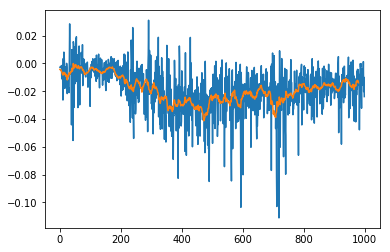

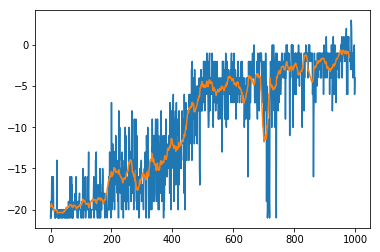

In [ ]:
window = 20
plt.plot(losses[:episodes])
plt.plot(np.convolve(losses[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

plt.plot(reward_sums[:episodes])
plt.plot(np.convolve(reward_sums[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

## Result


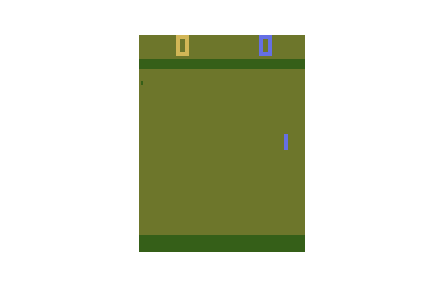
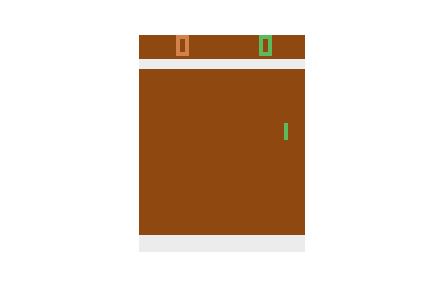
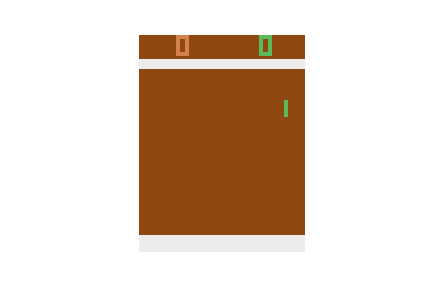
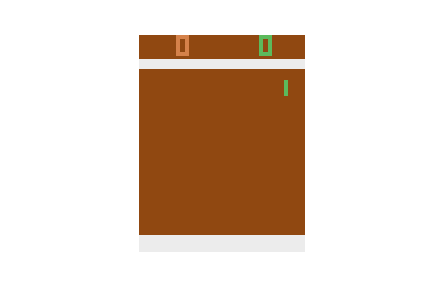
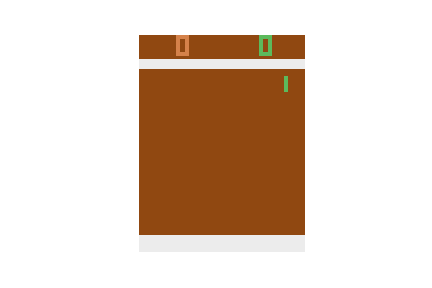
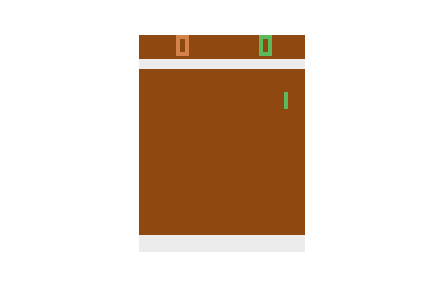
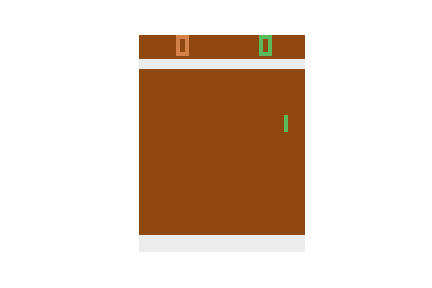
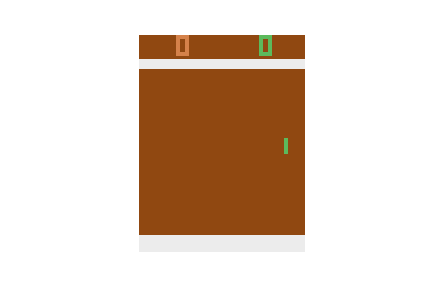
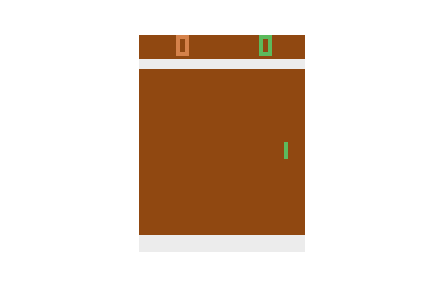
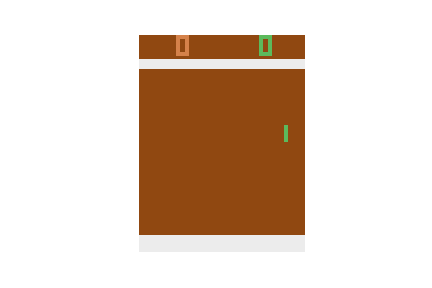
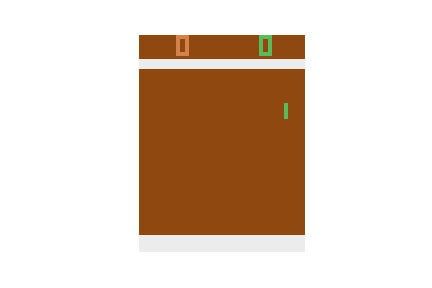
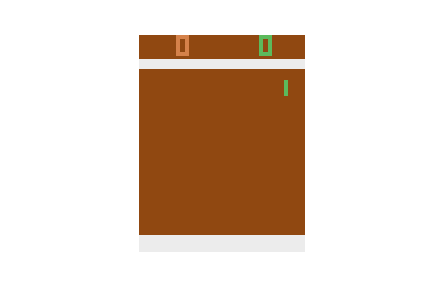
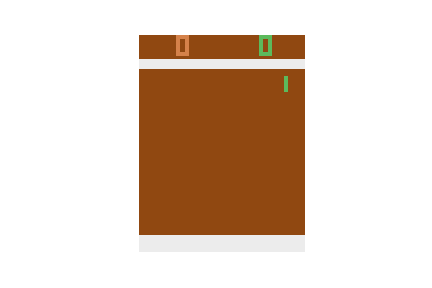
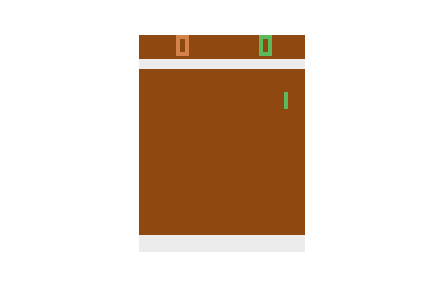
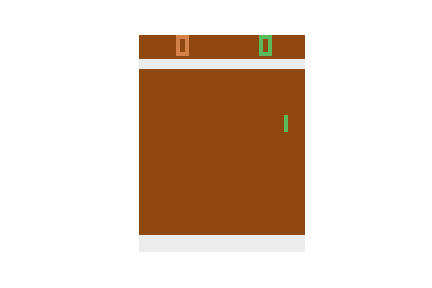
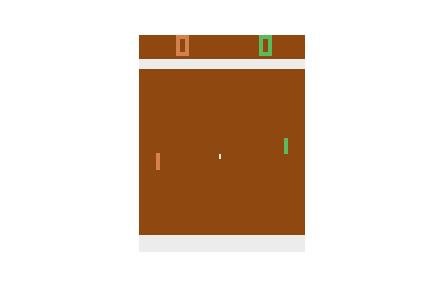
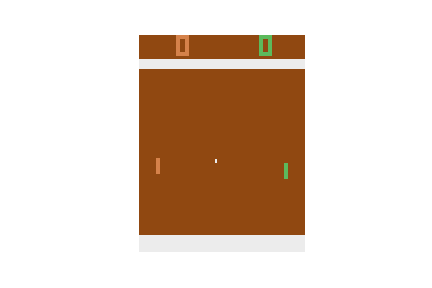
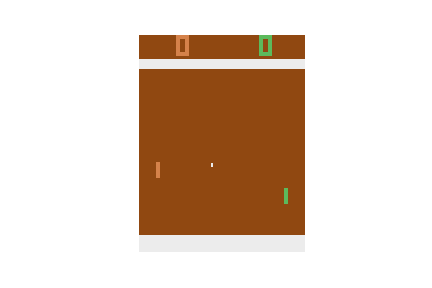
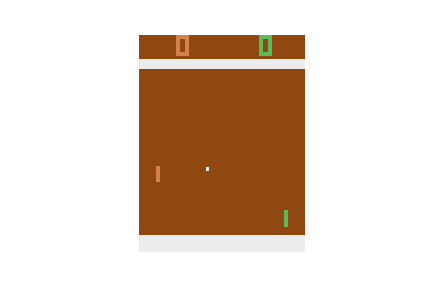
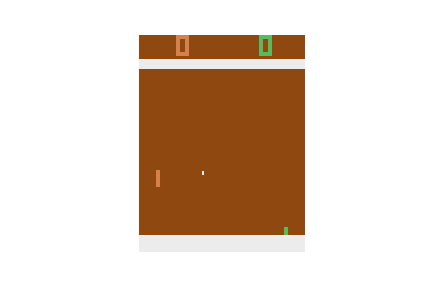
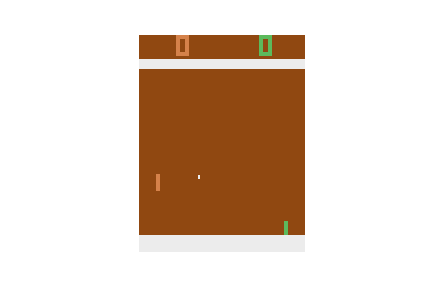
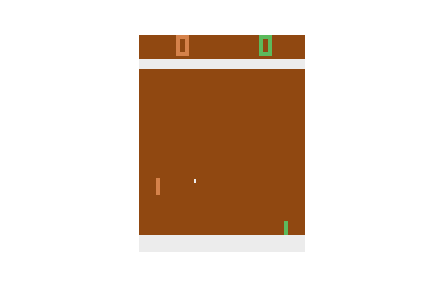
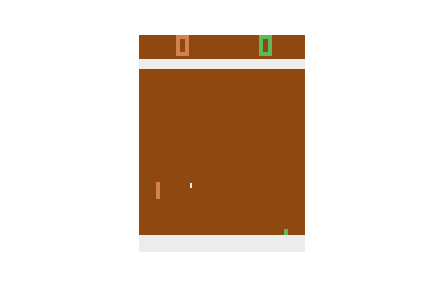
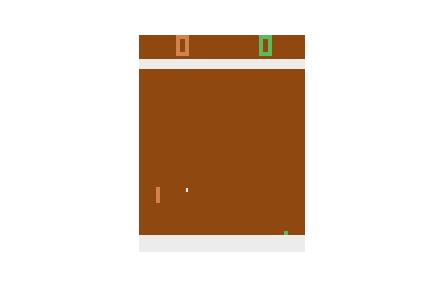
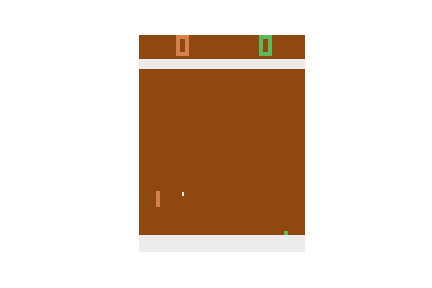
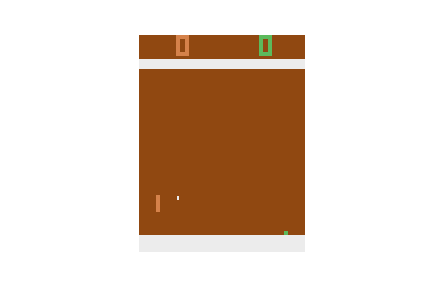
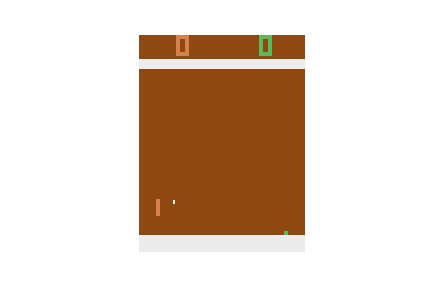
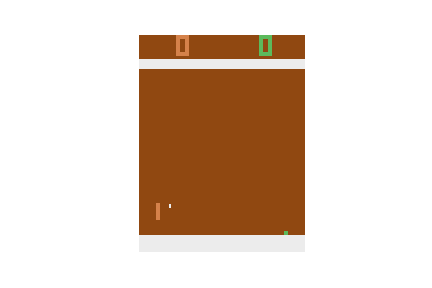
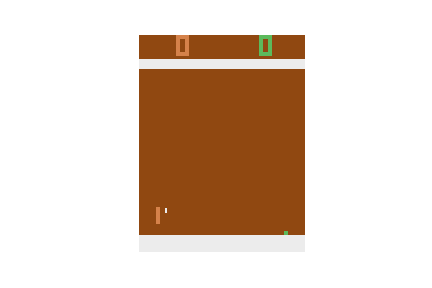
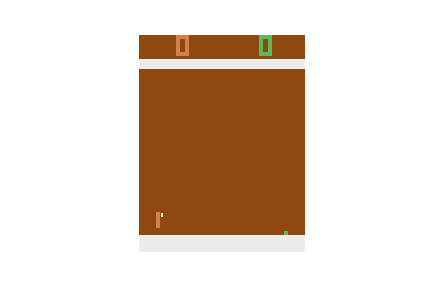
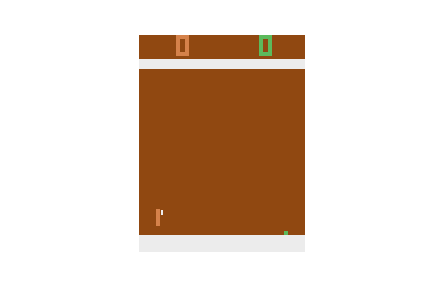
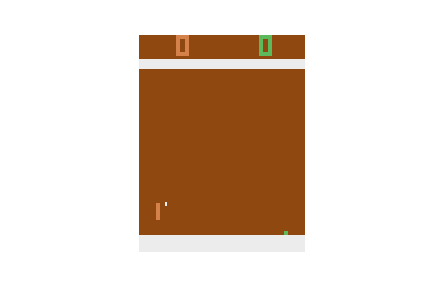
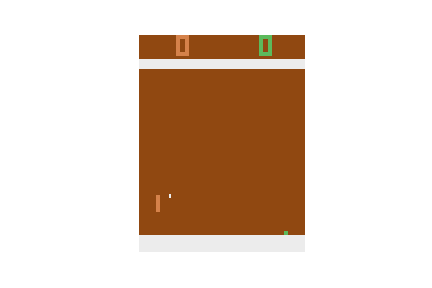
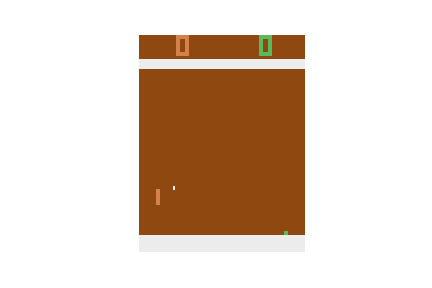
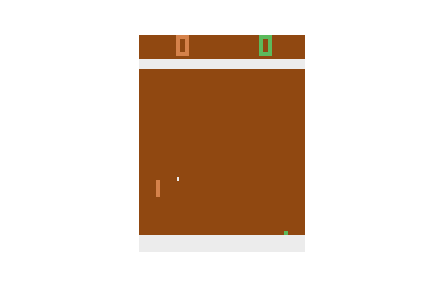
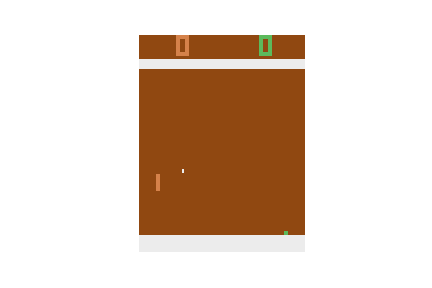
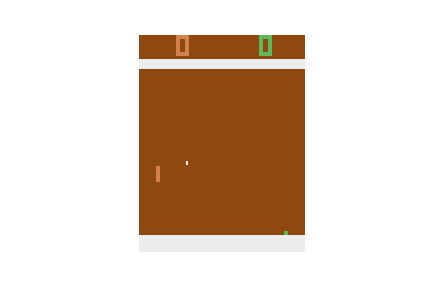
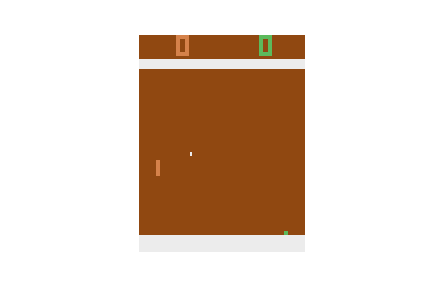
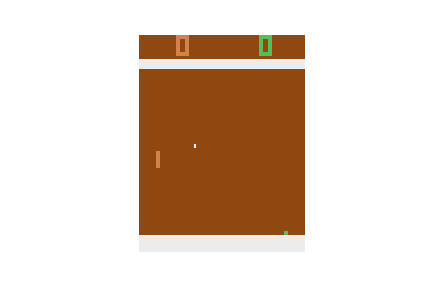
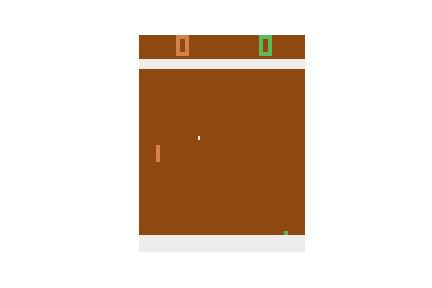
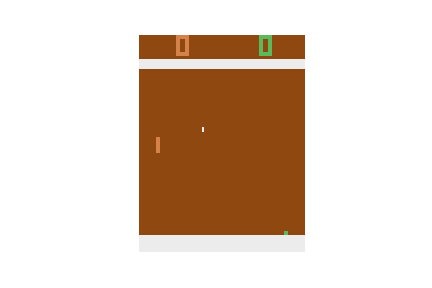
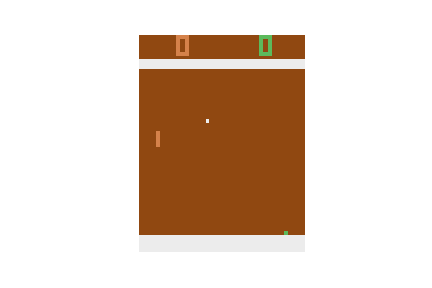
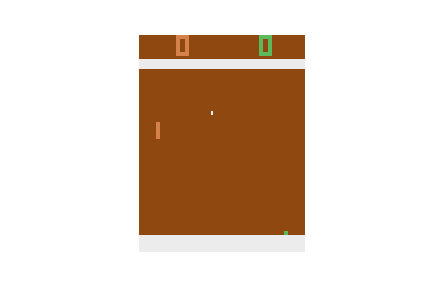
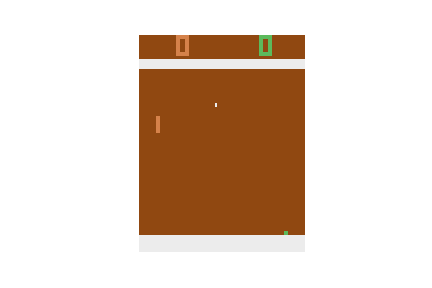
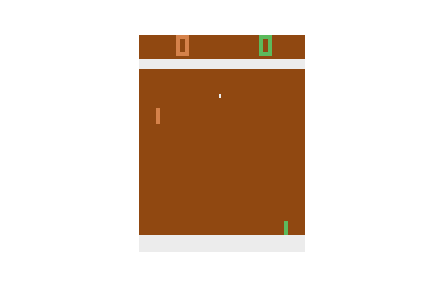
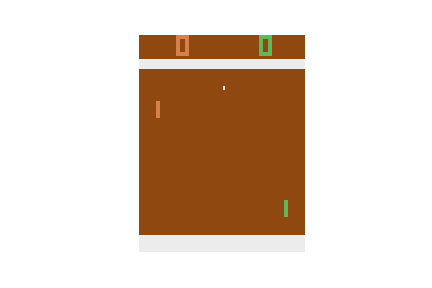
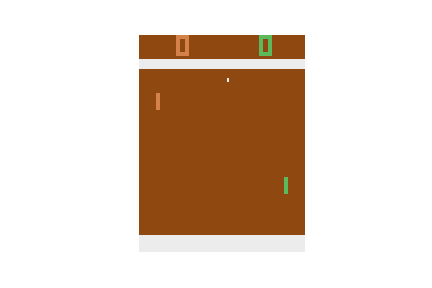
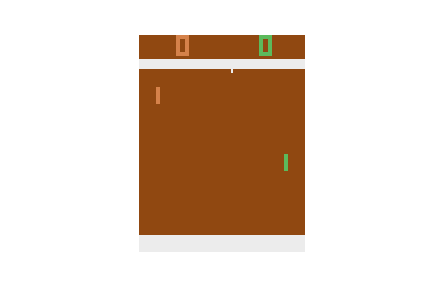
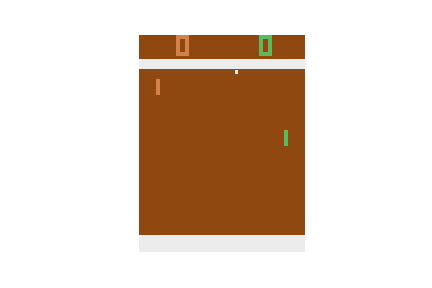
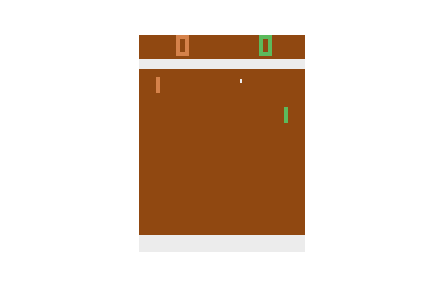
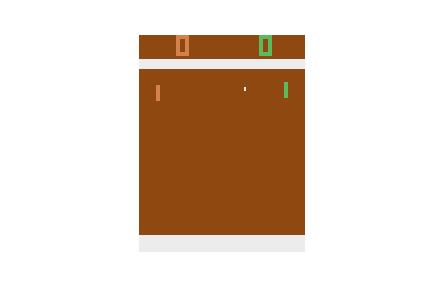
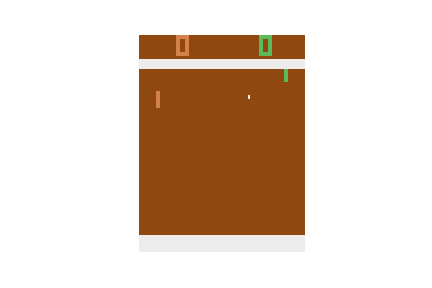
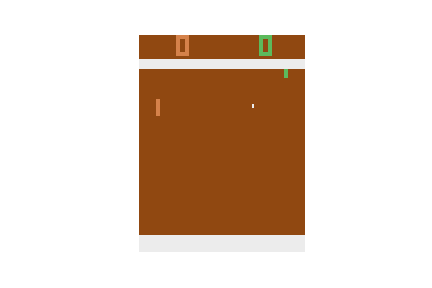
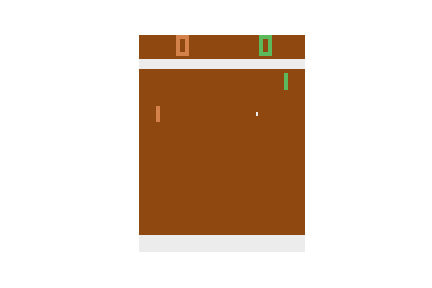
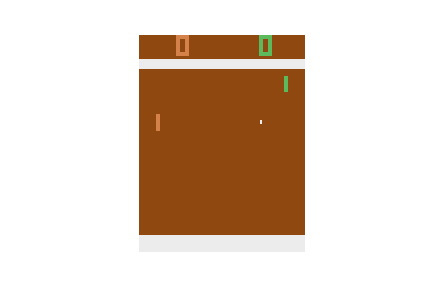
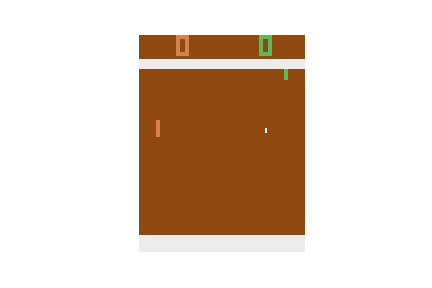
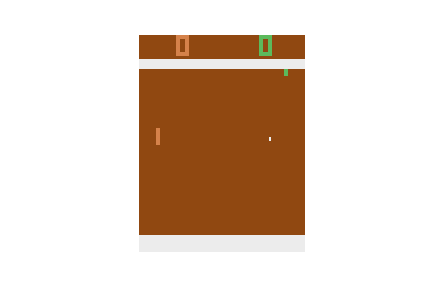
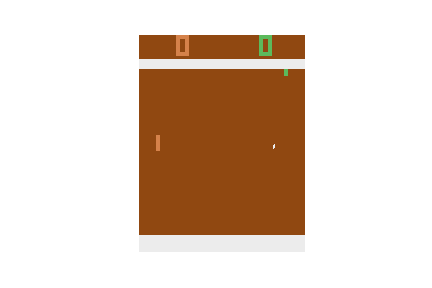
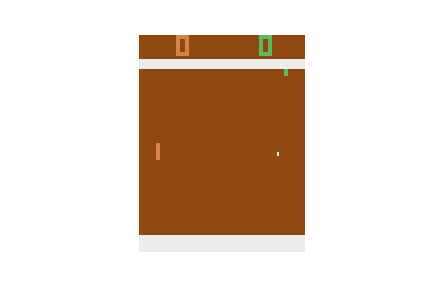
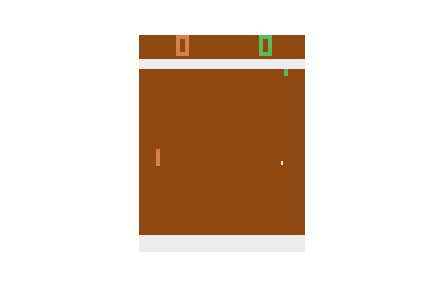
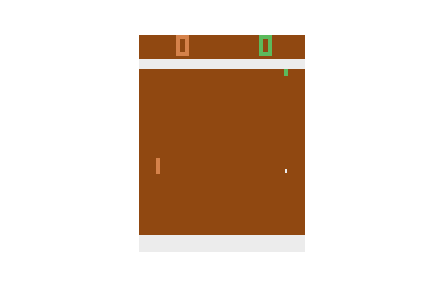
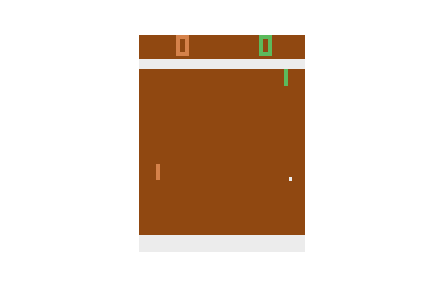
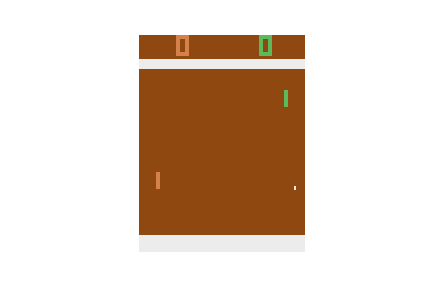
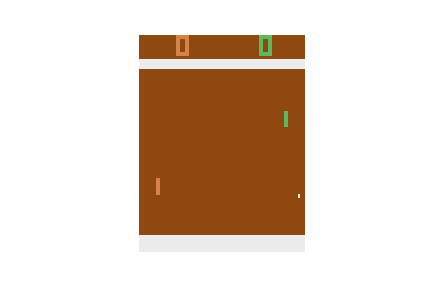
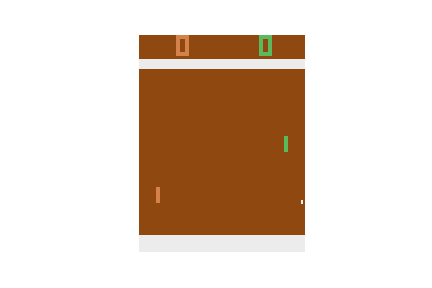
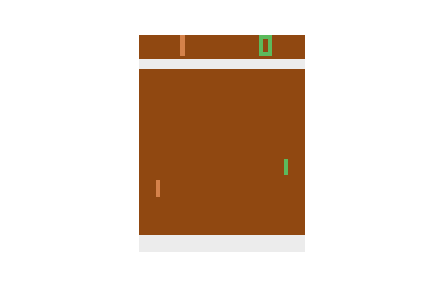
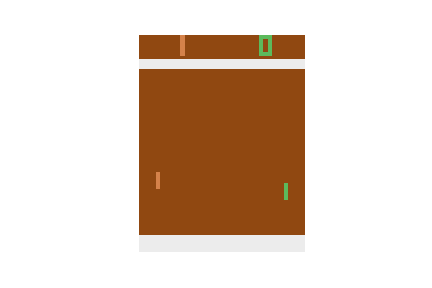
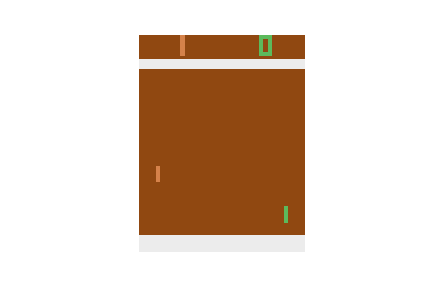
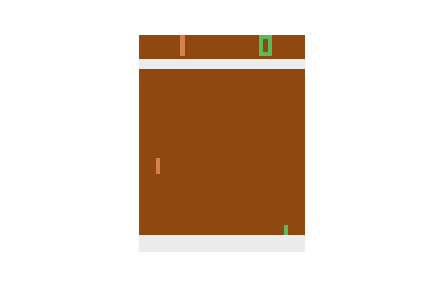
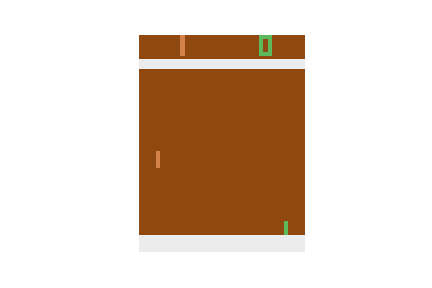
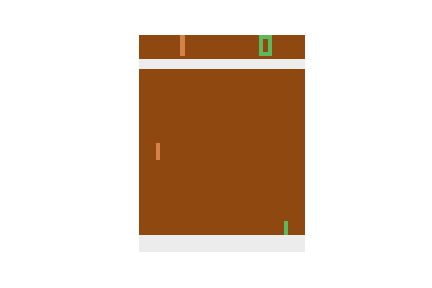
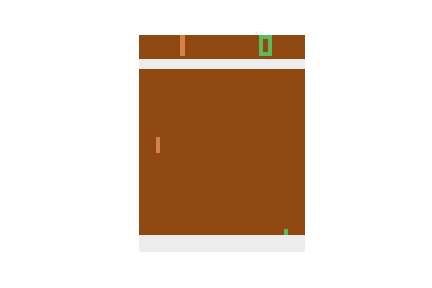
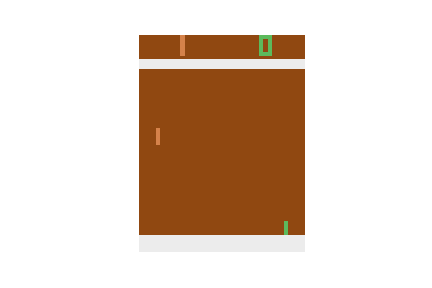
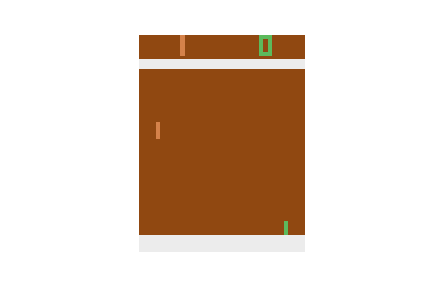
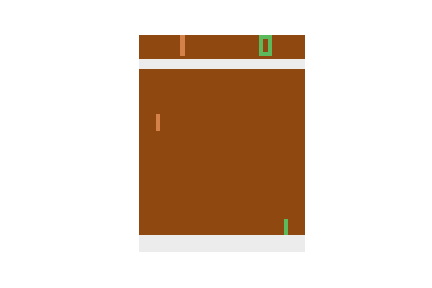
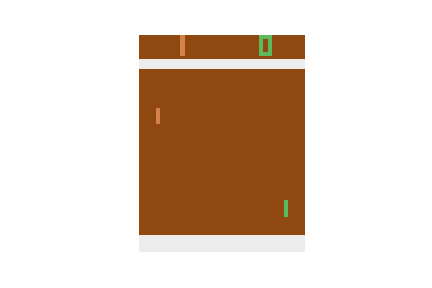
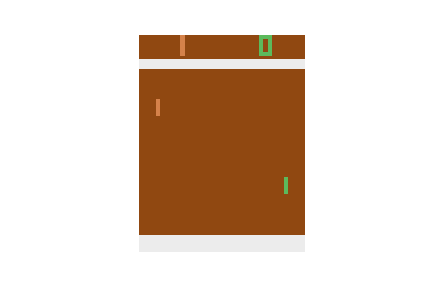
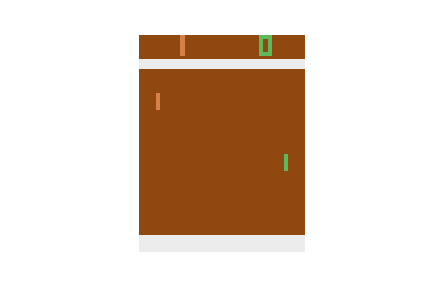
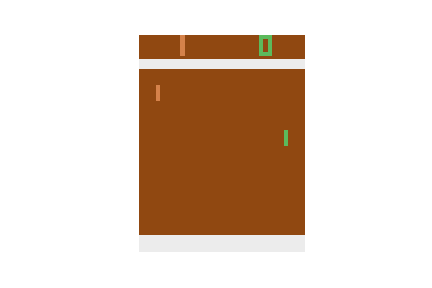
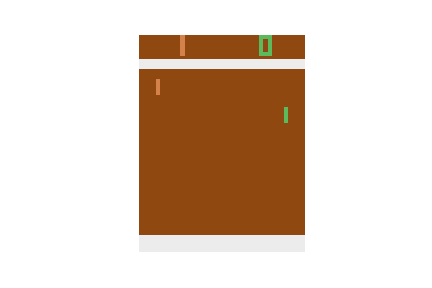
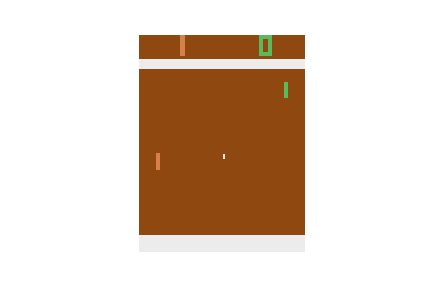
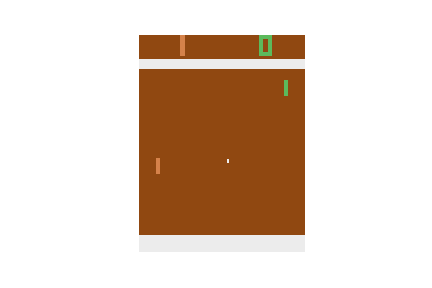
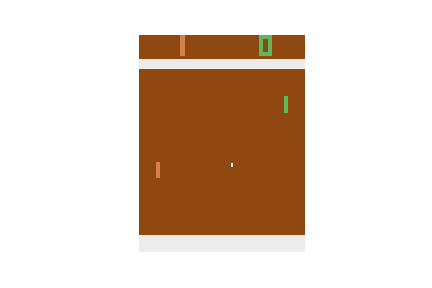
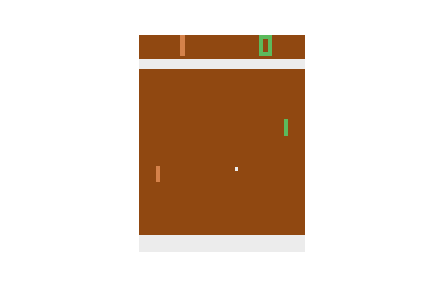
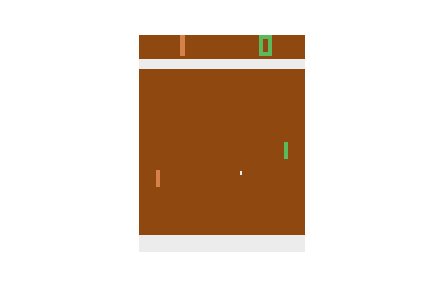
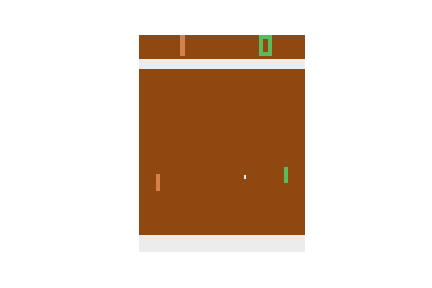
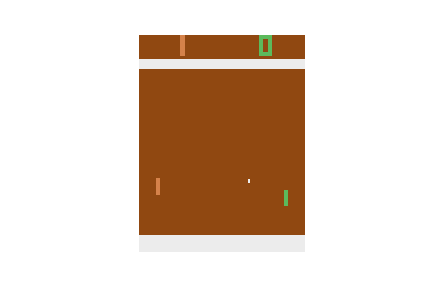
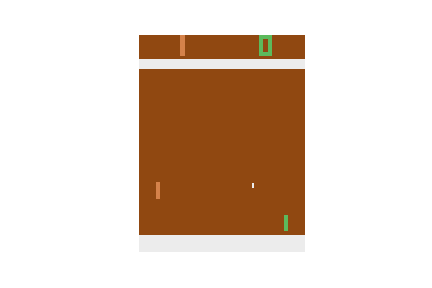
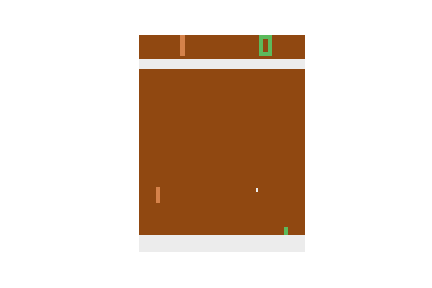
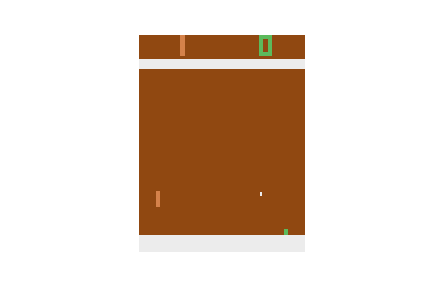
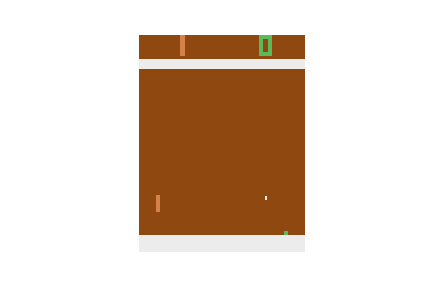
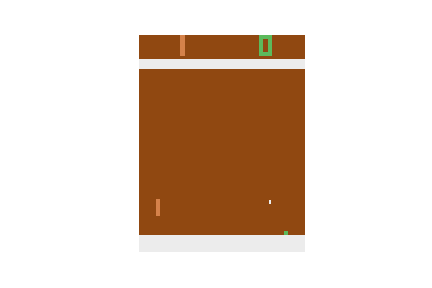
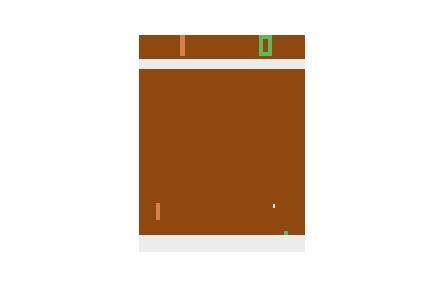
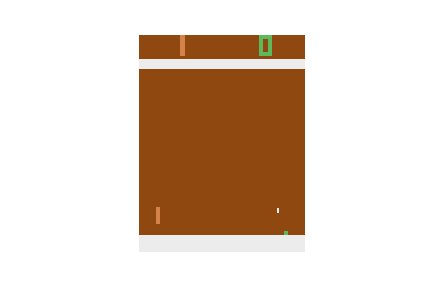
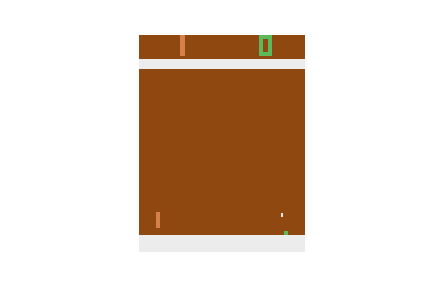
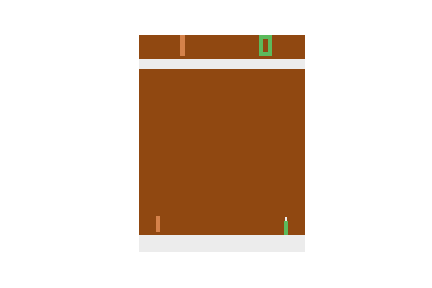
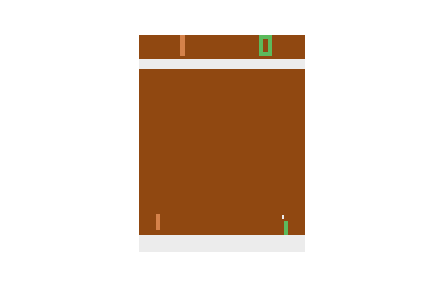
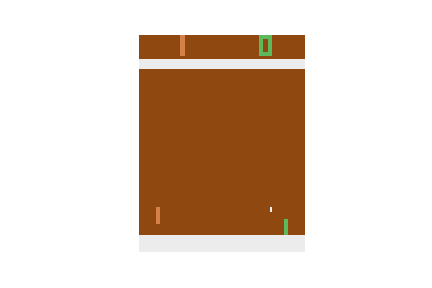
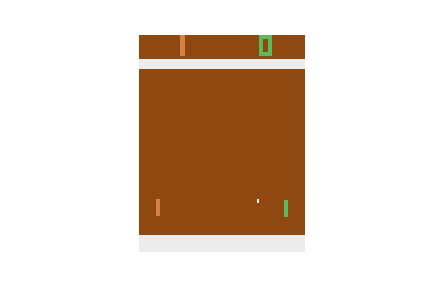
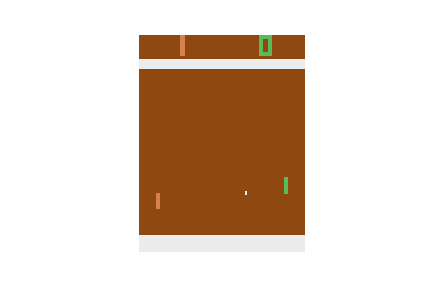
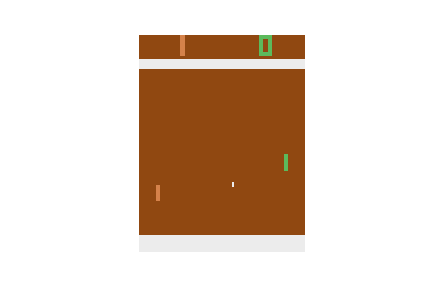
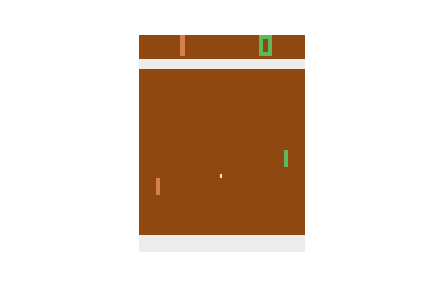
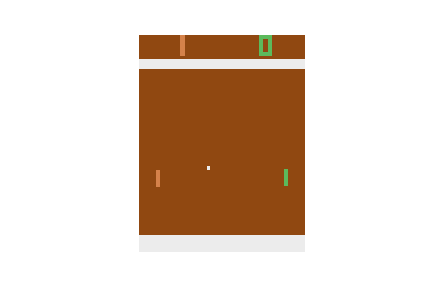
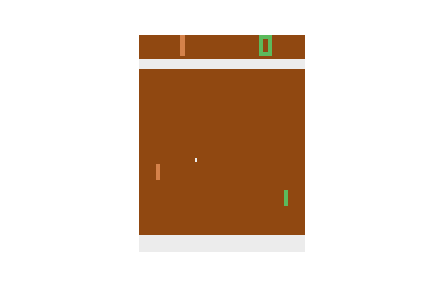
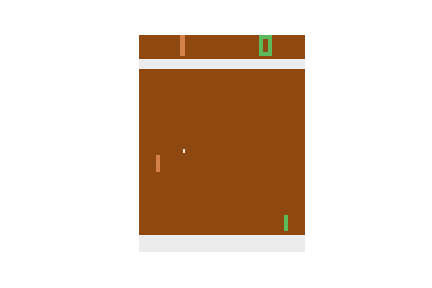
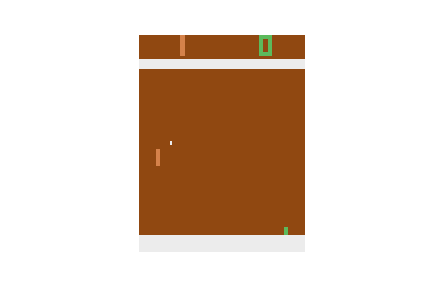
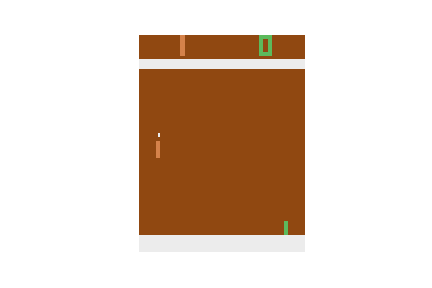
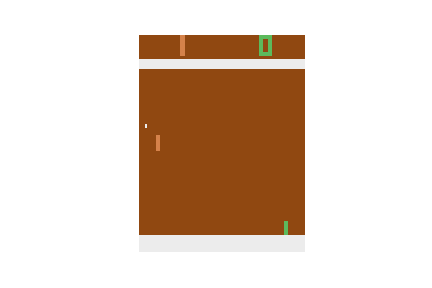
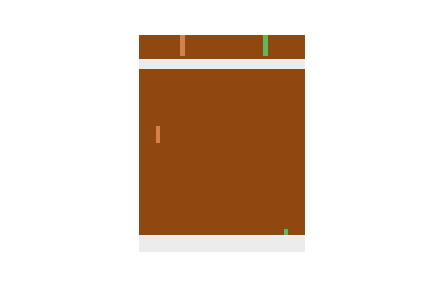
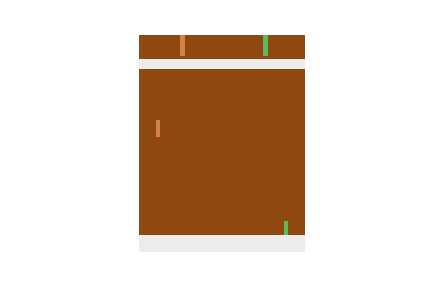
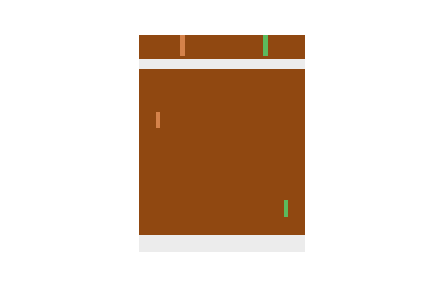
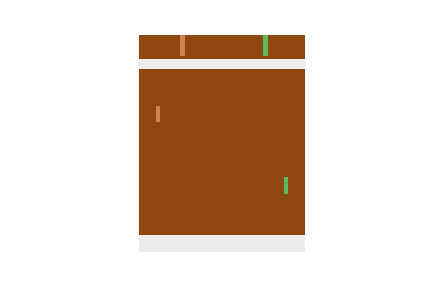
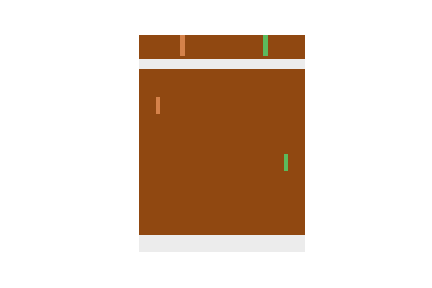
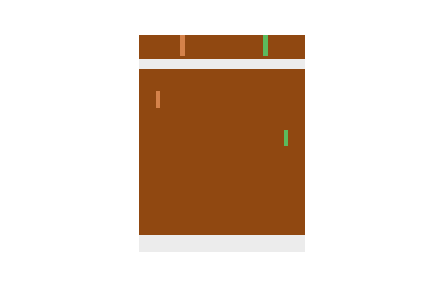
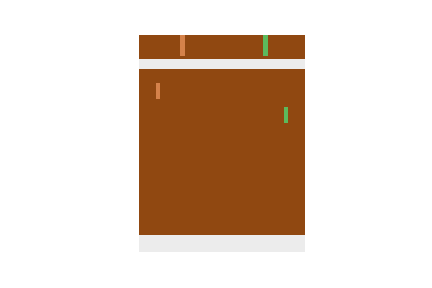
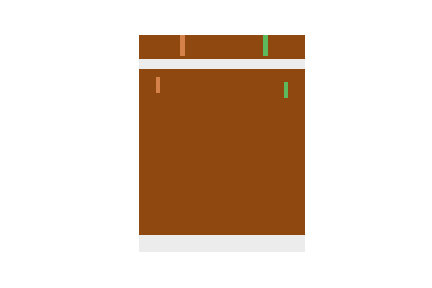
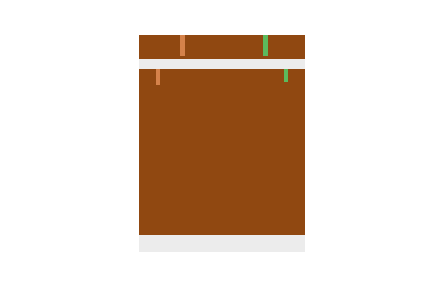
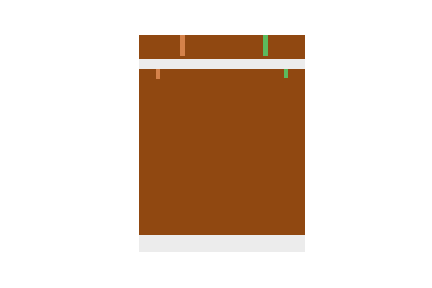
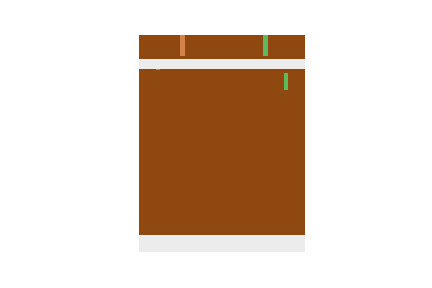
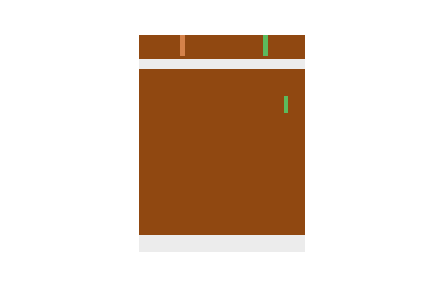
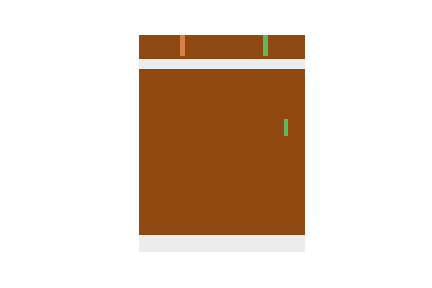
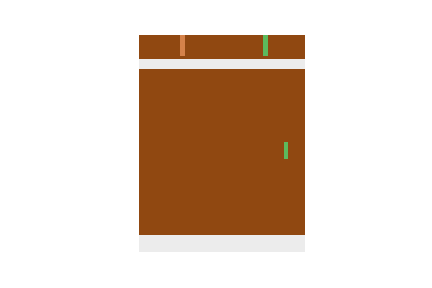
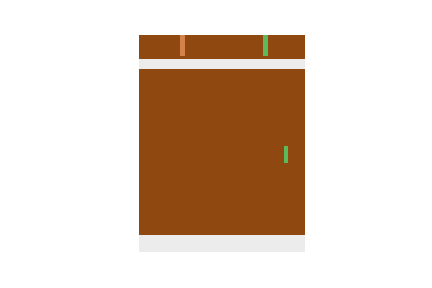
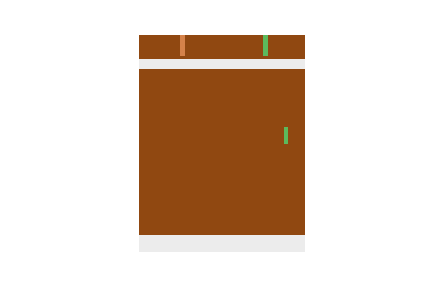
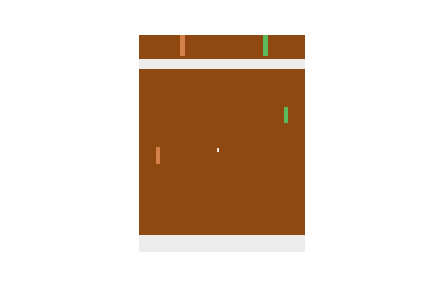
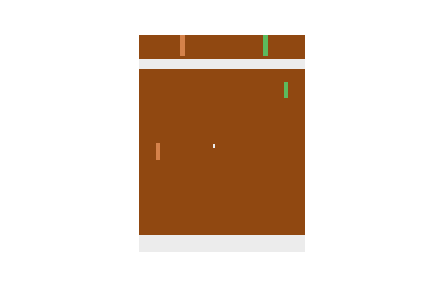
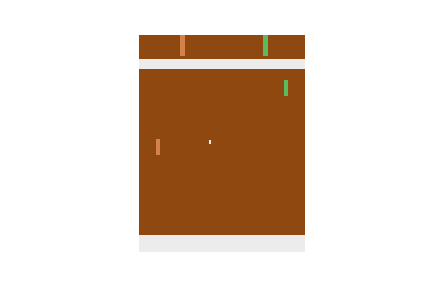
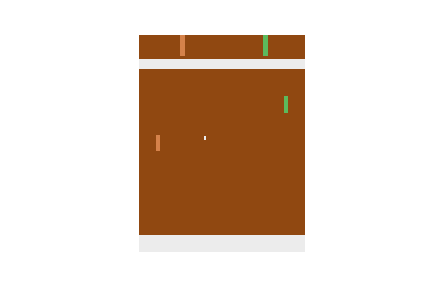
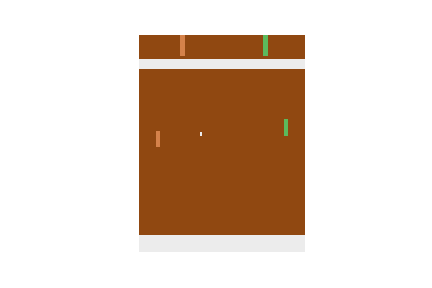
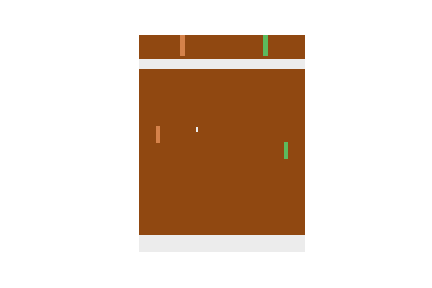
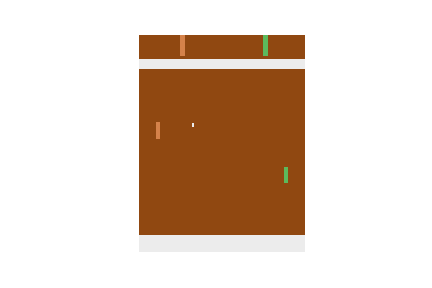
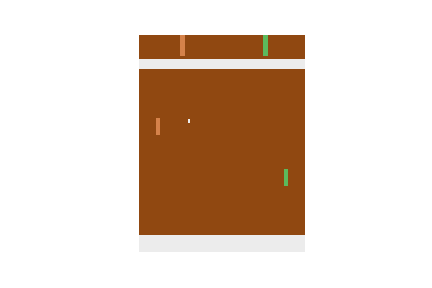
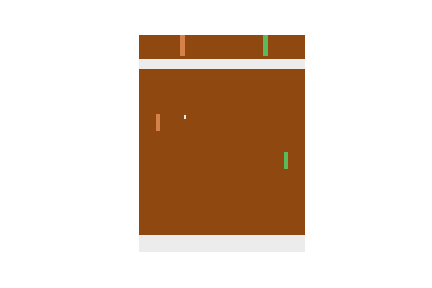
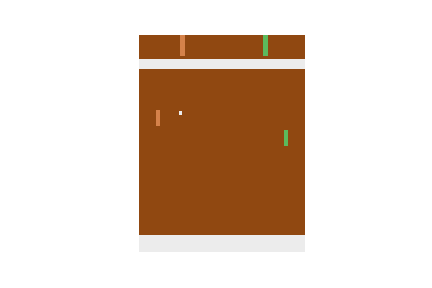
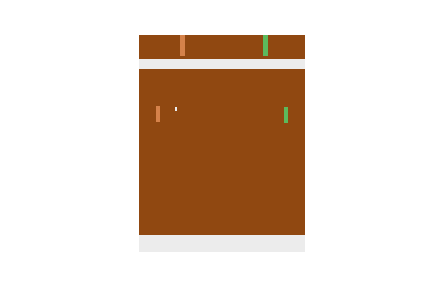
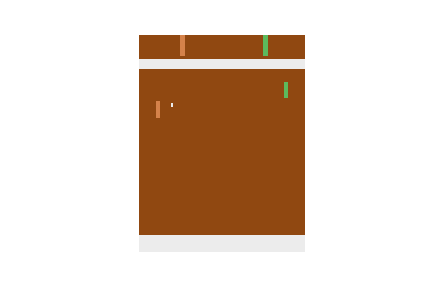
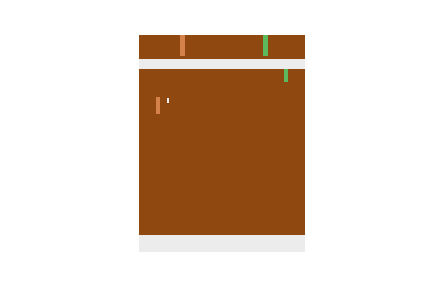
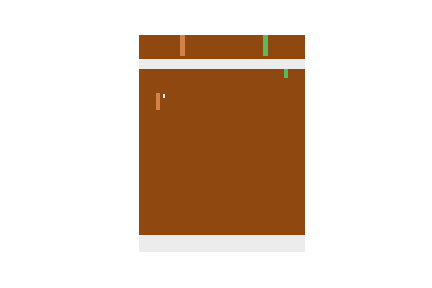
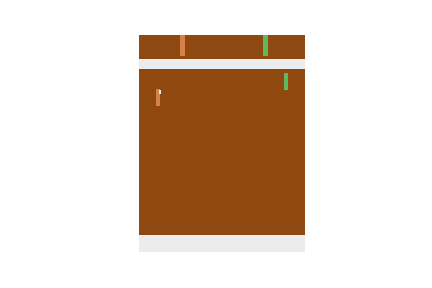
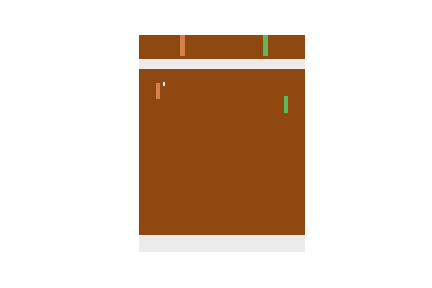
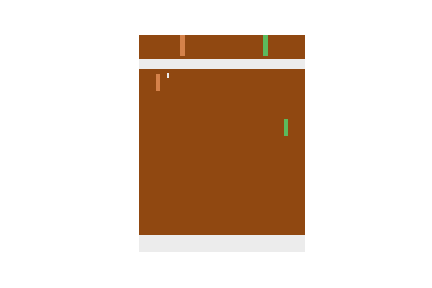
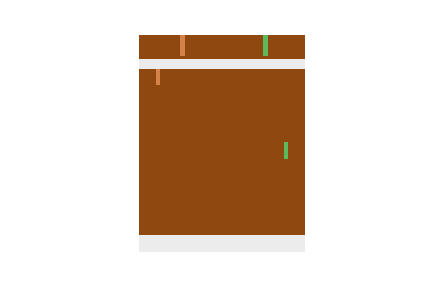
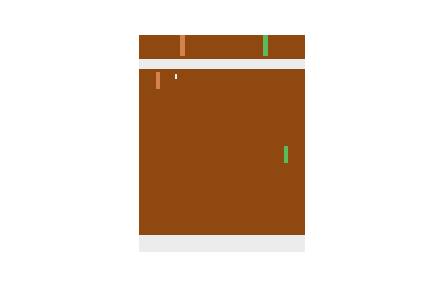
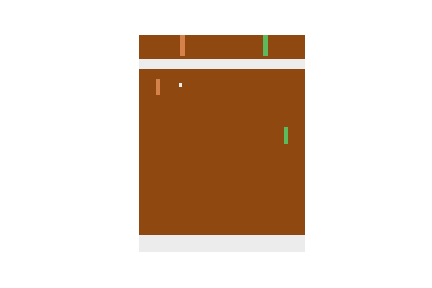
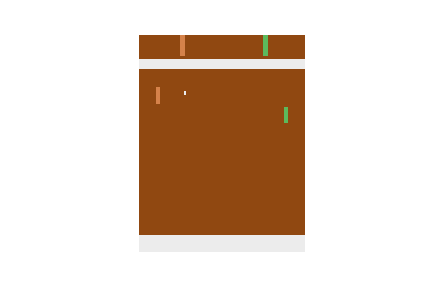
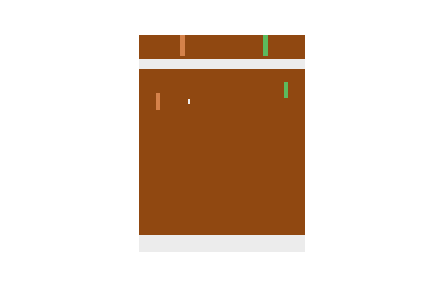
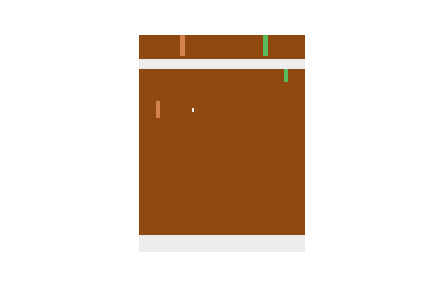
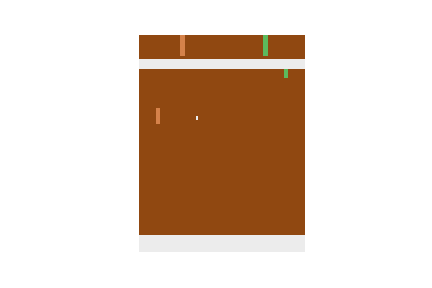
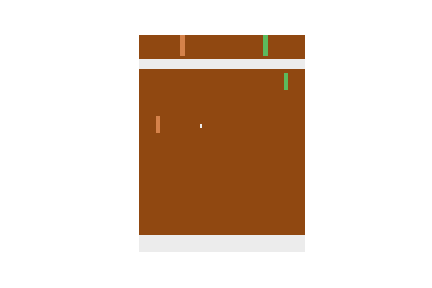
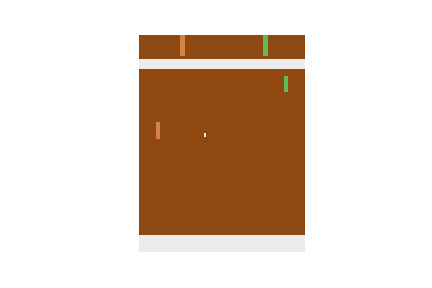
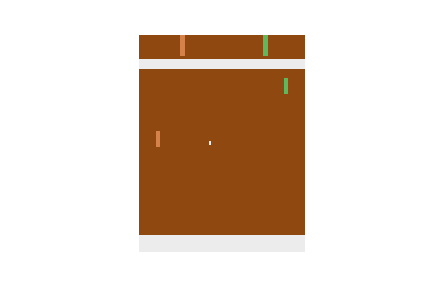
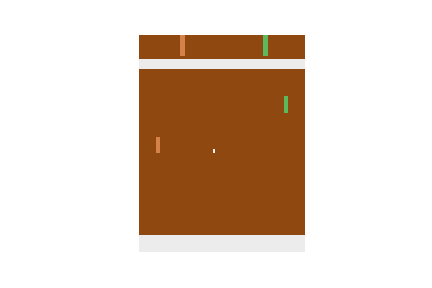
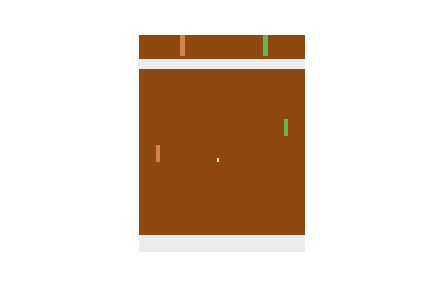
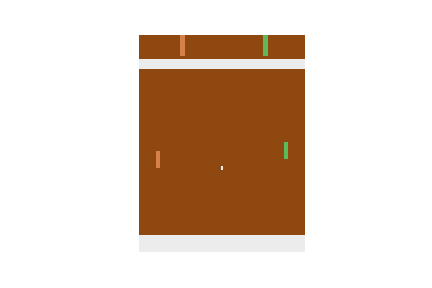
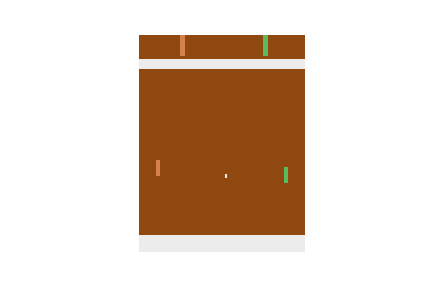
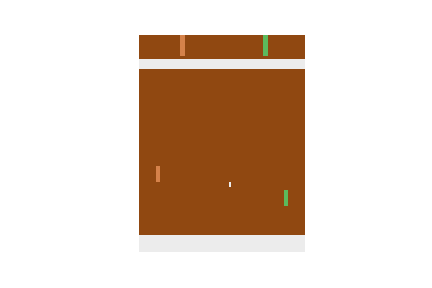
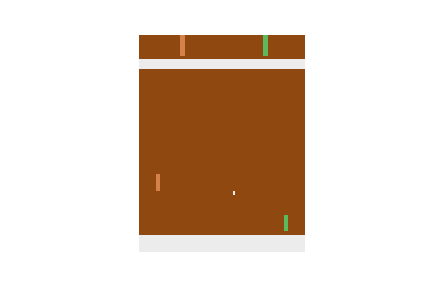
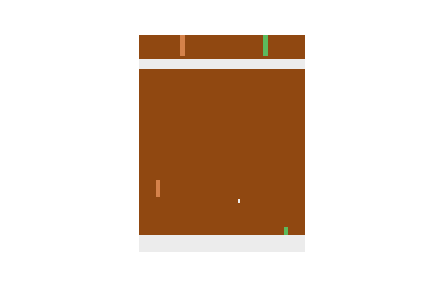
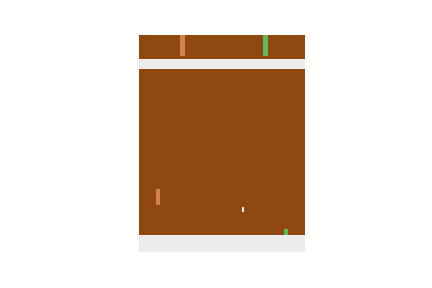
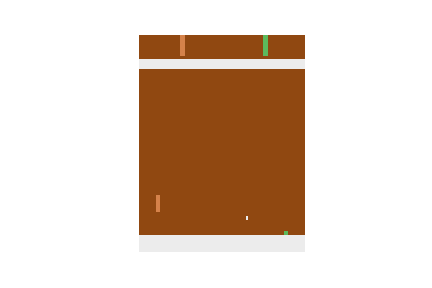
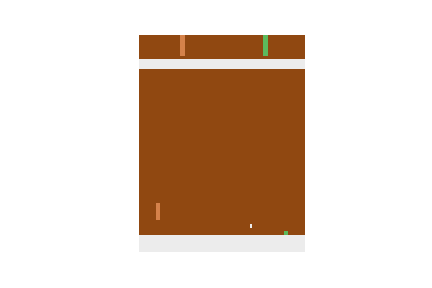
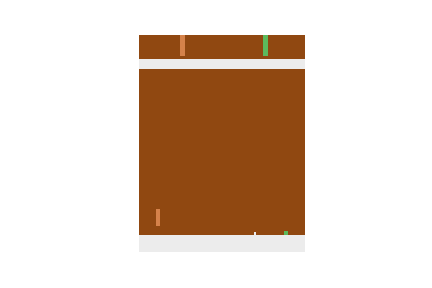
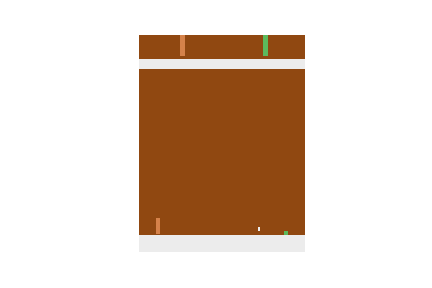
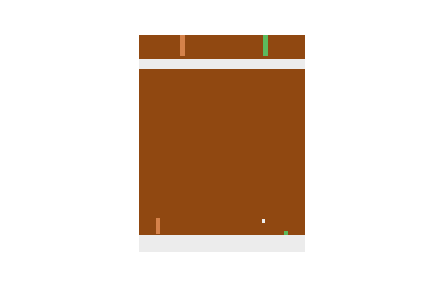
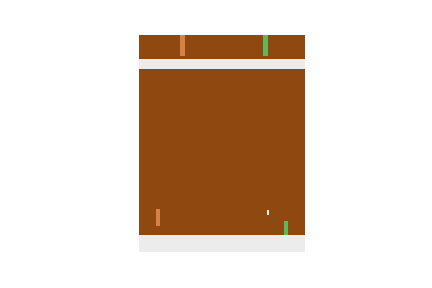
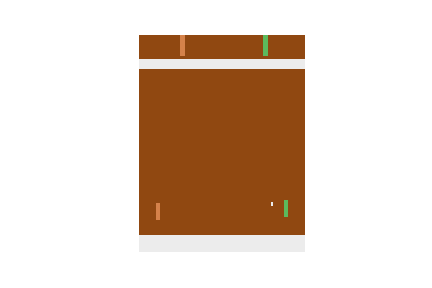
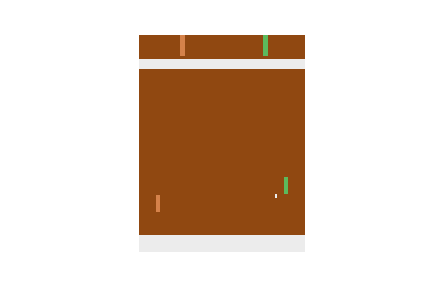
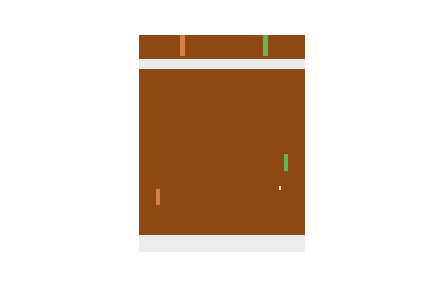
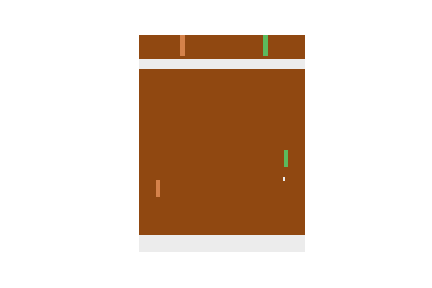
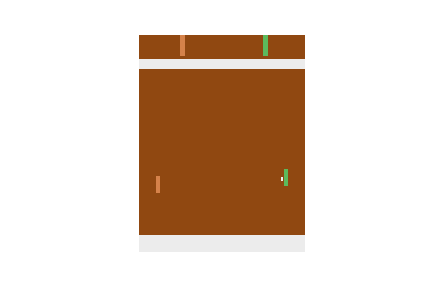
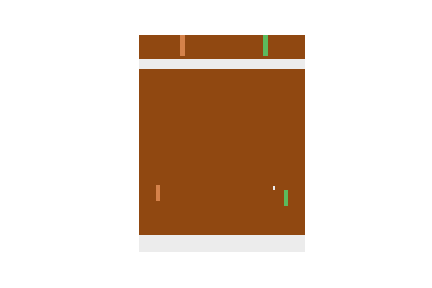
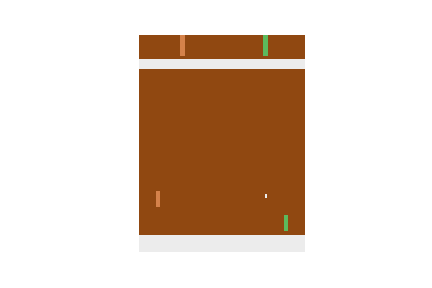
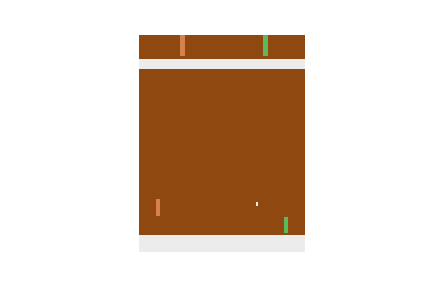
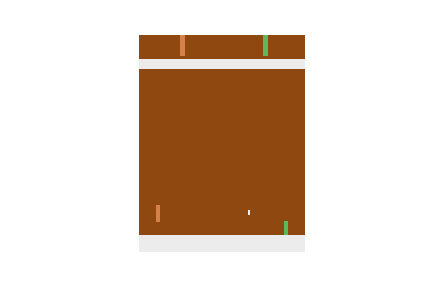
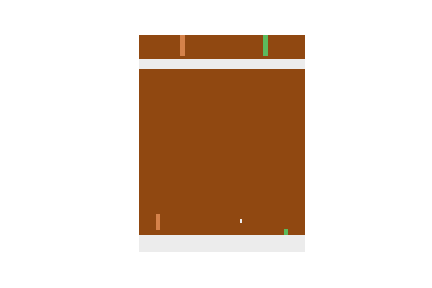
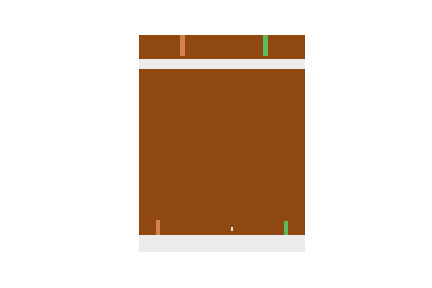
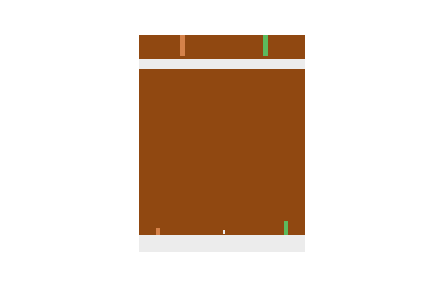
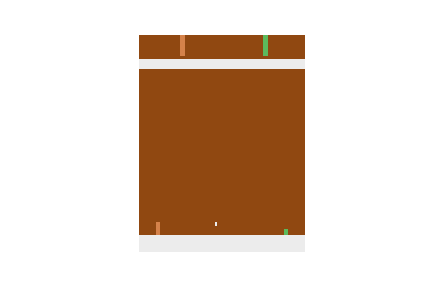
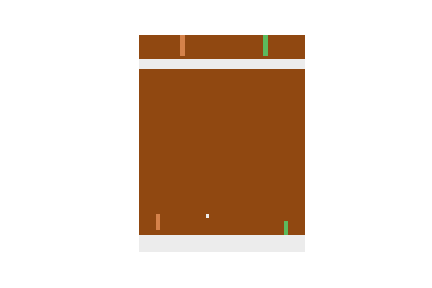
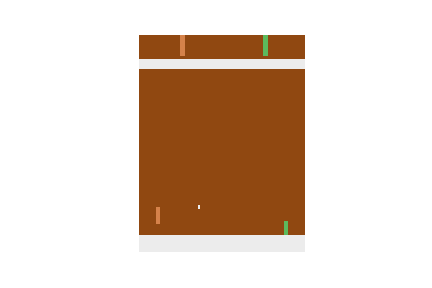
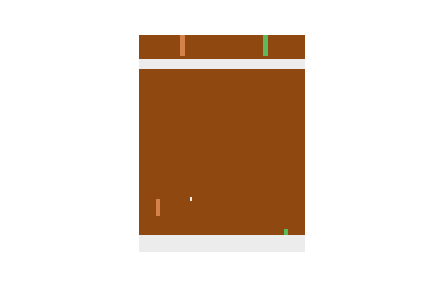
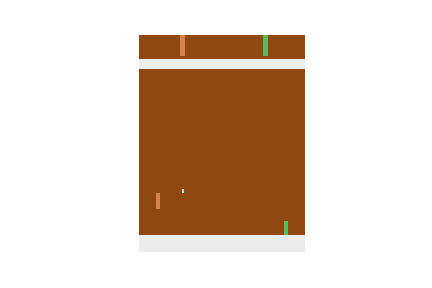
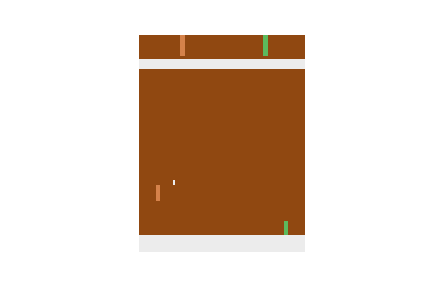
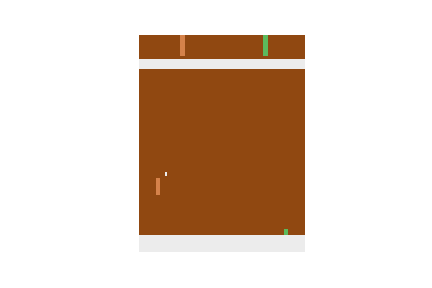
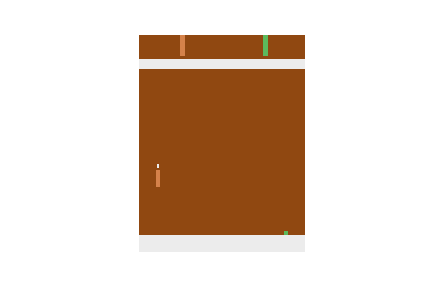
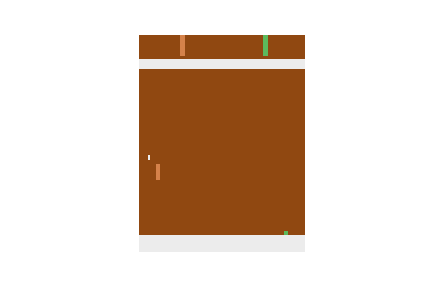
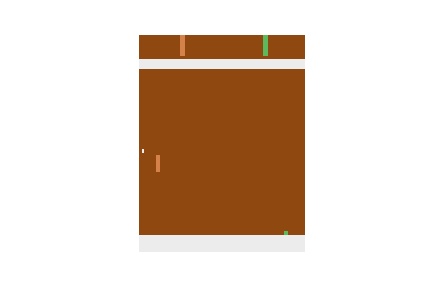
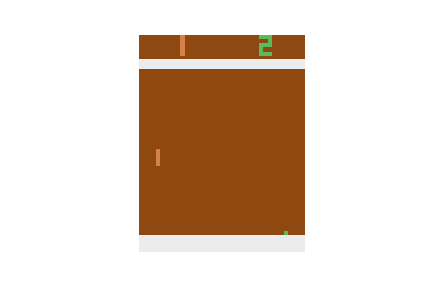
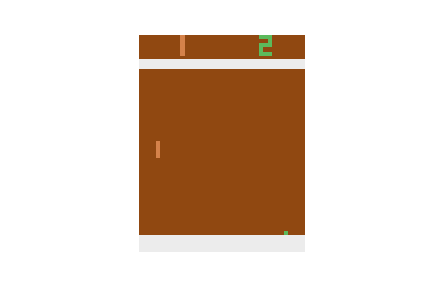
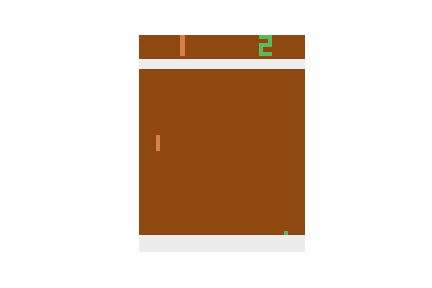
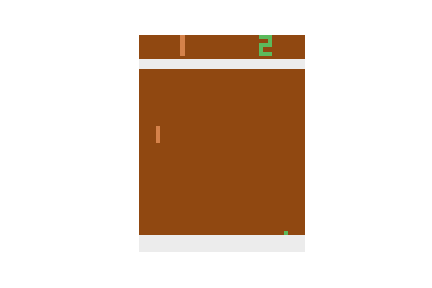
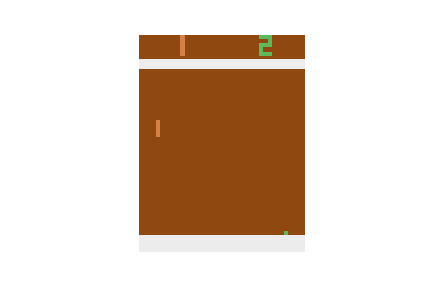
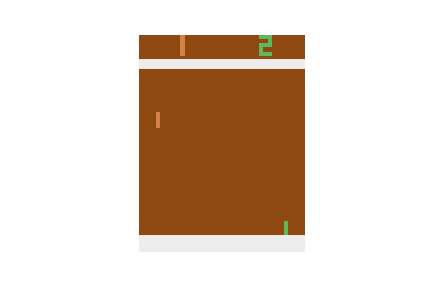
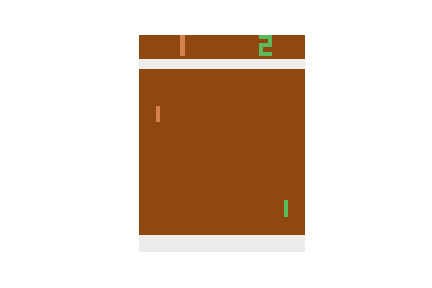
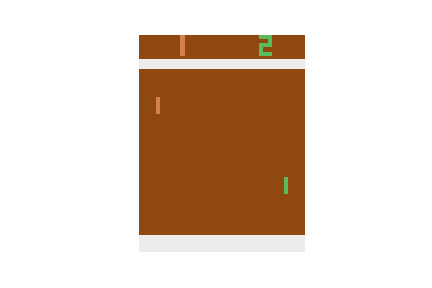
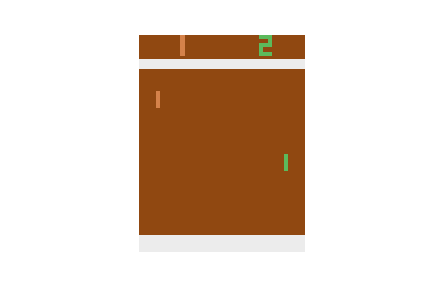
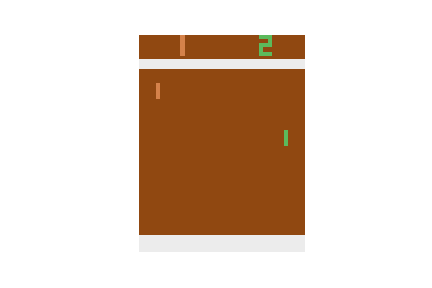
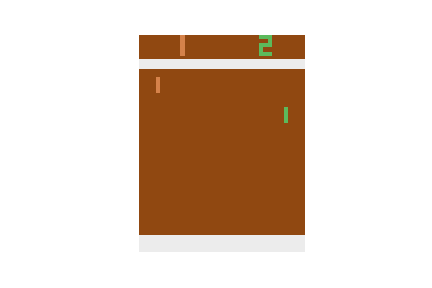
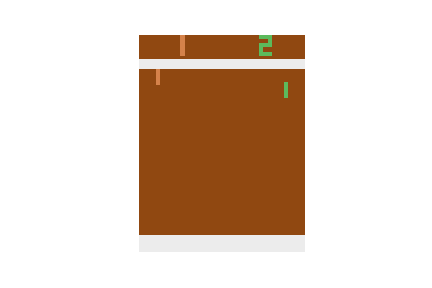
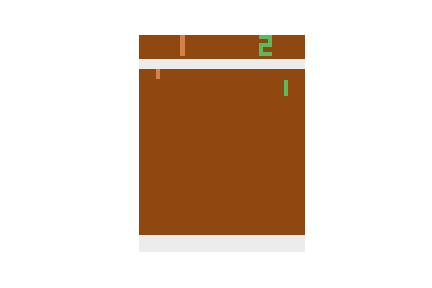
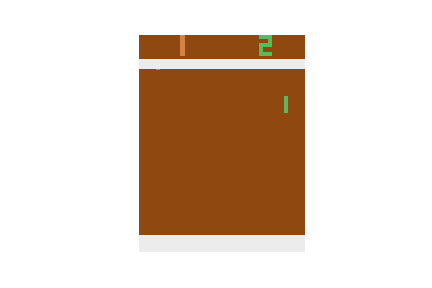
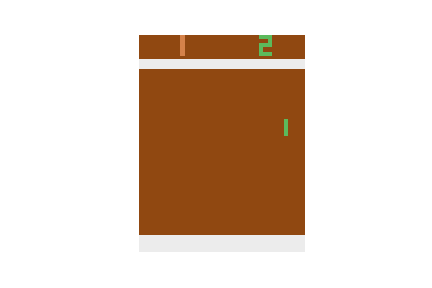
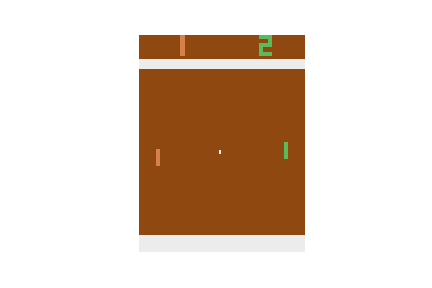
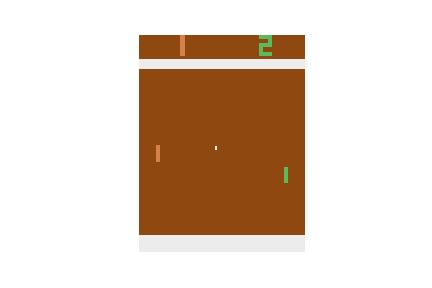
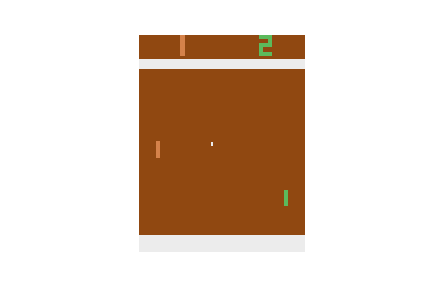
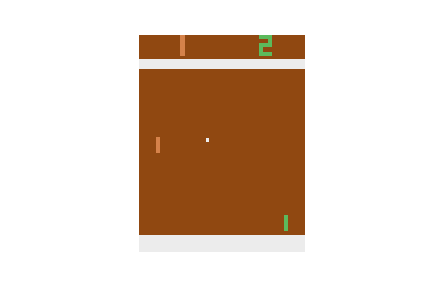
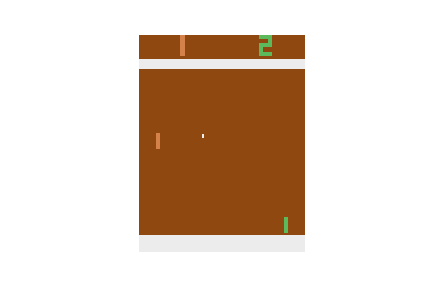
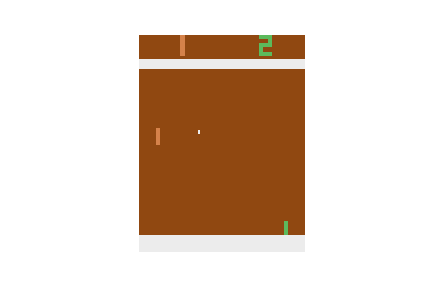
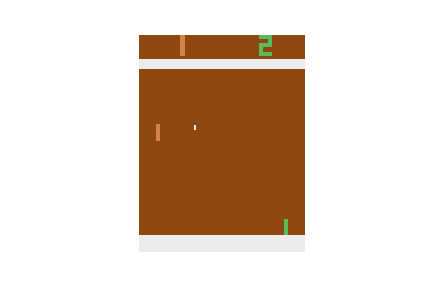
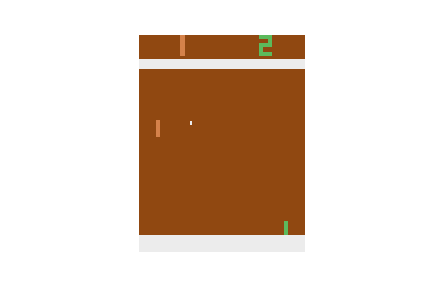
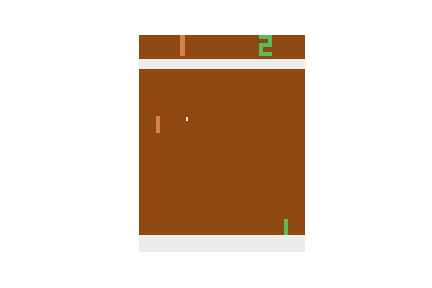
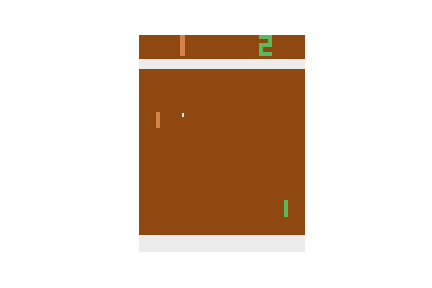
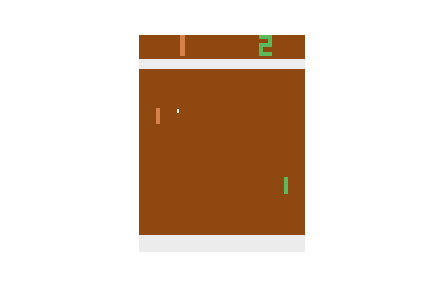
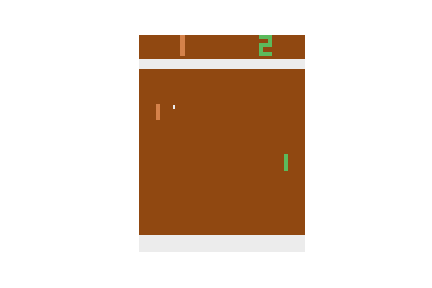
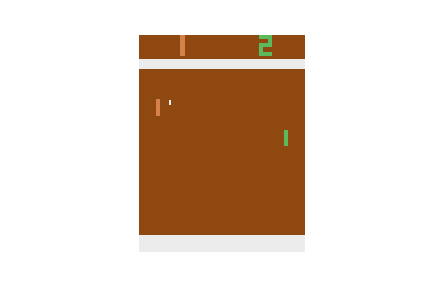
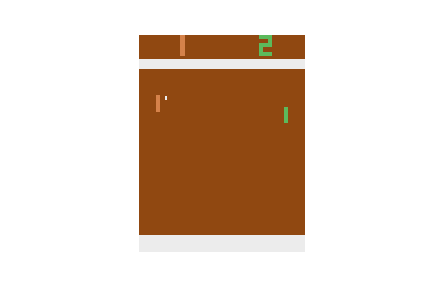
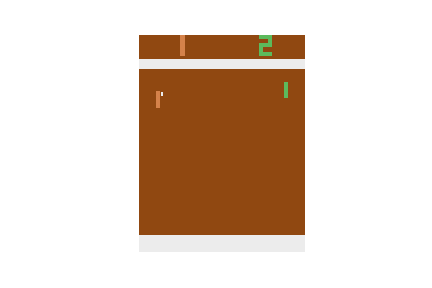
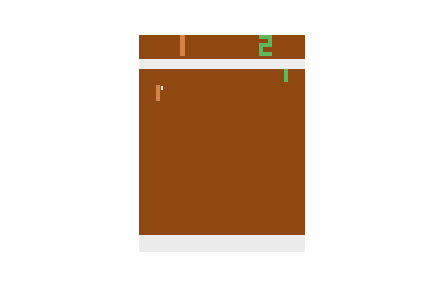
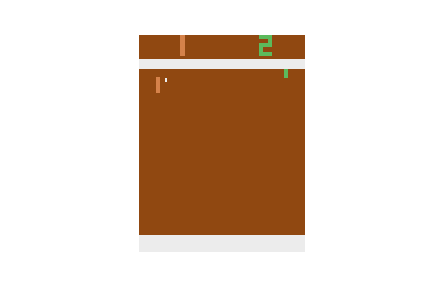
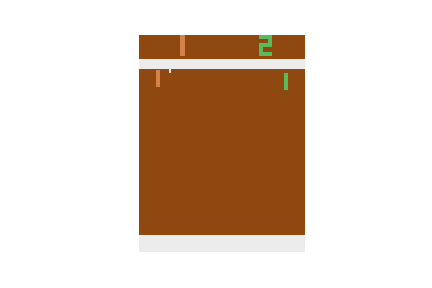
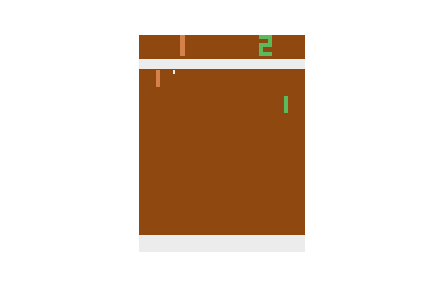
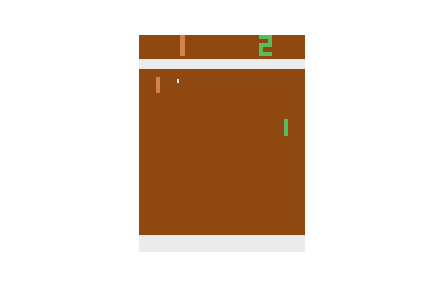
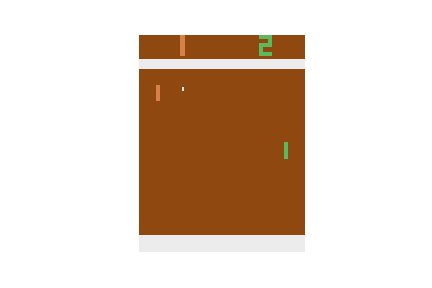
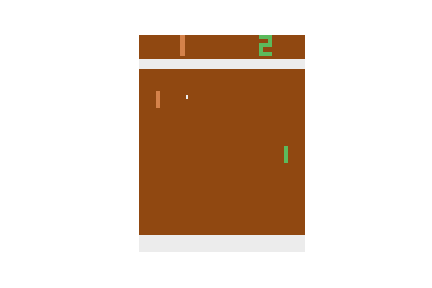
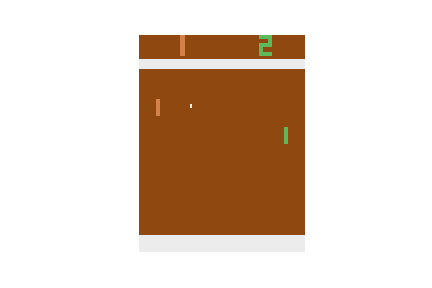
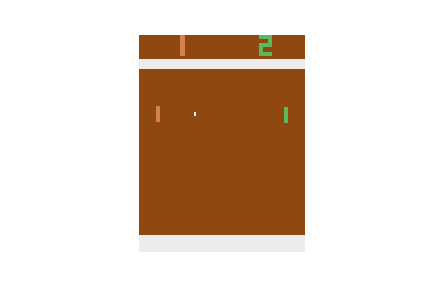
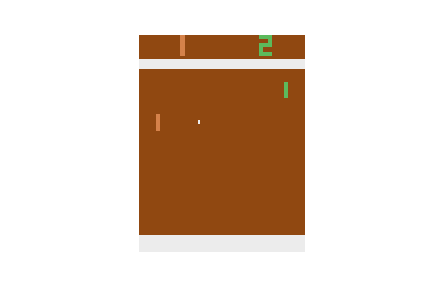
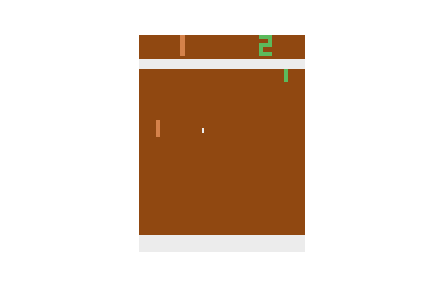
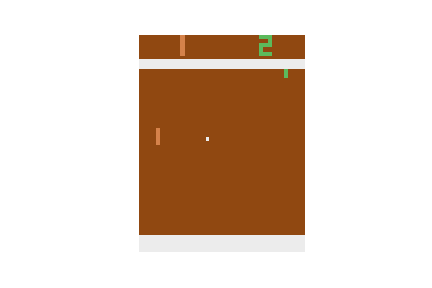
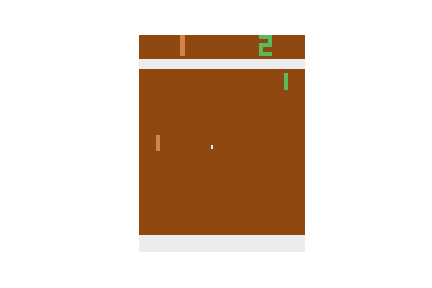
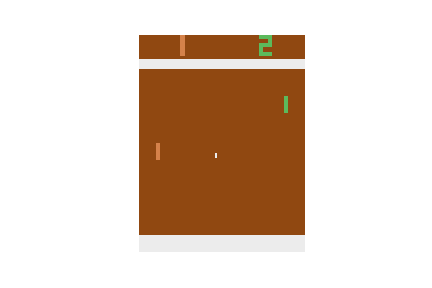
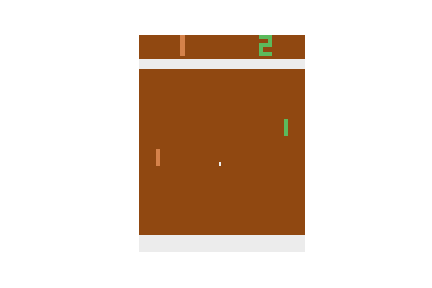
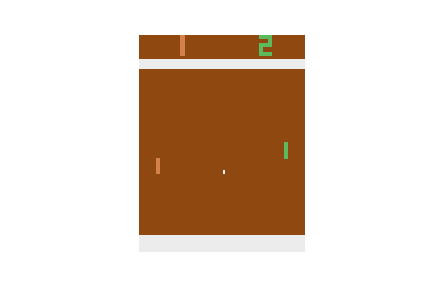
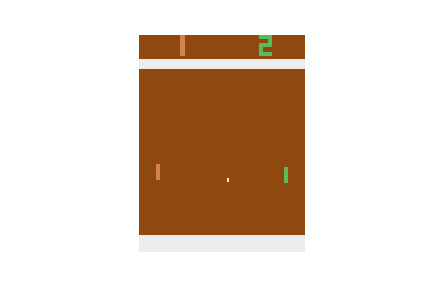
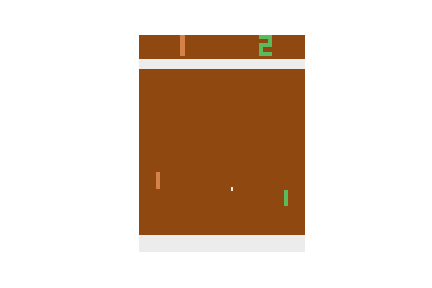
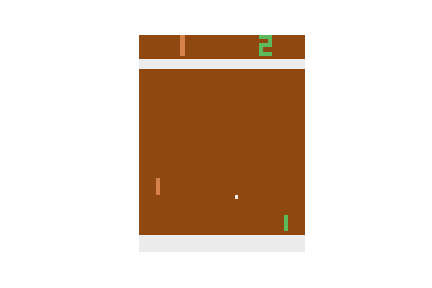
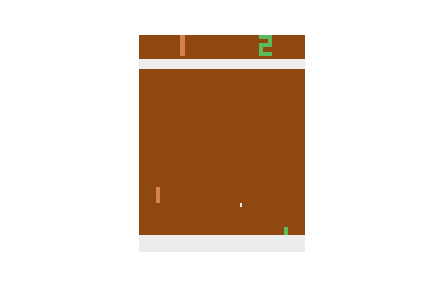
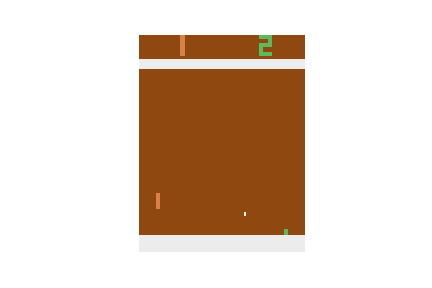
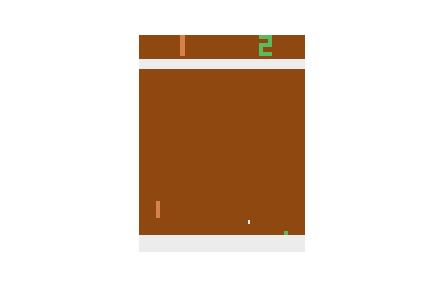
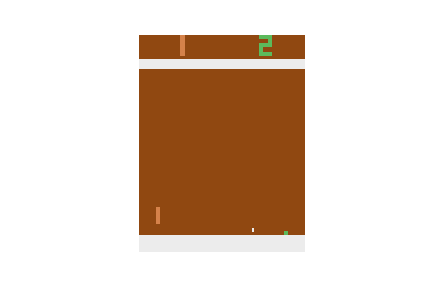
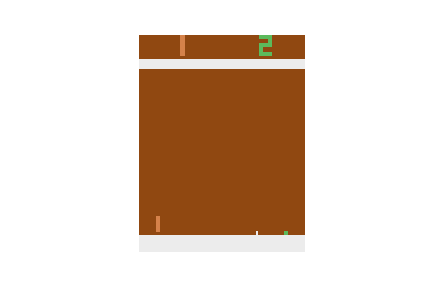
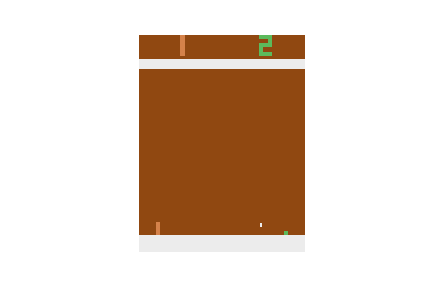
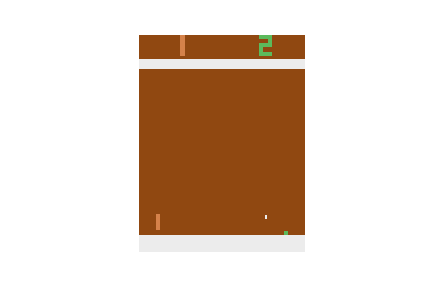
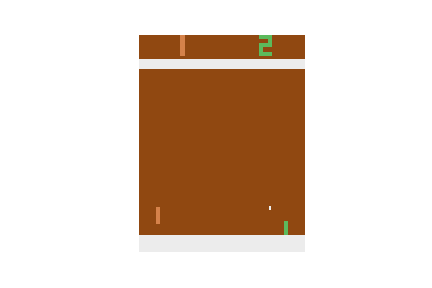
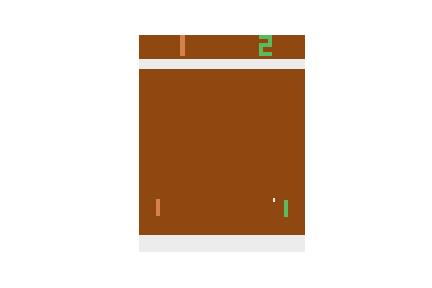
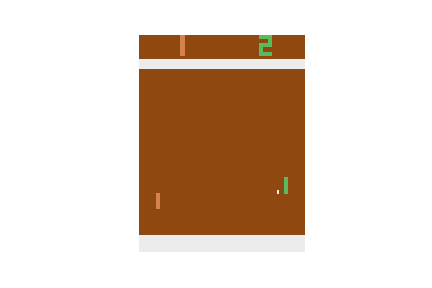
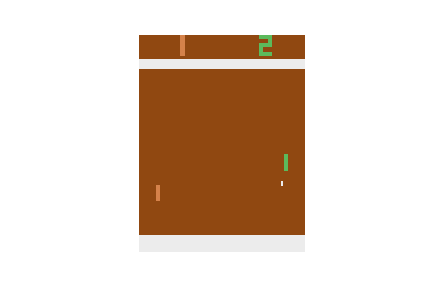
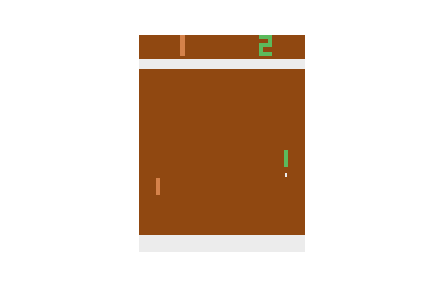
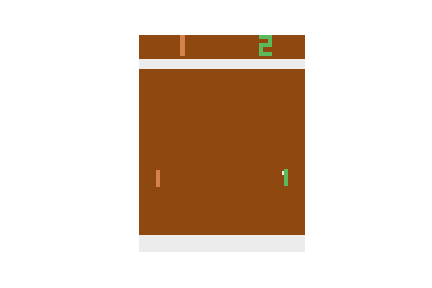
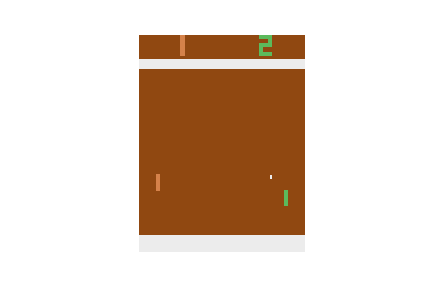
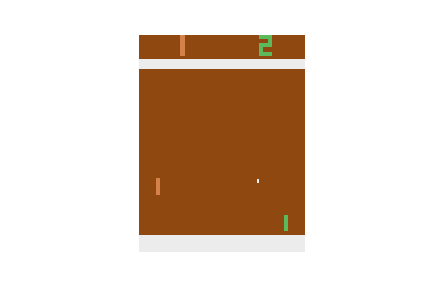
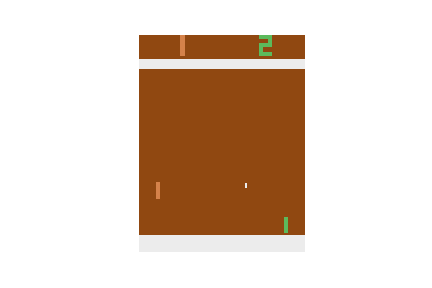
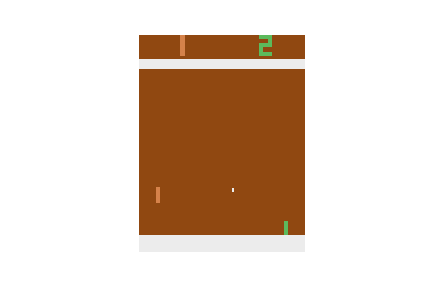
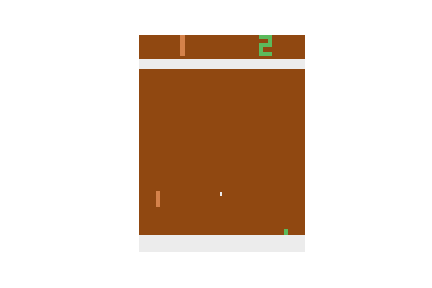
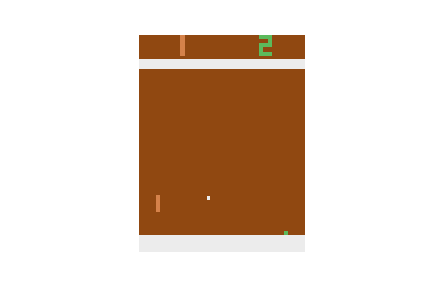
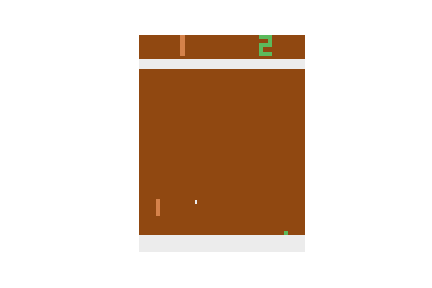
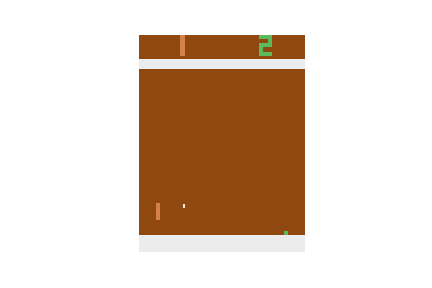
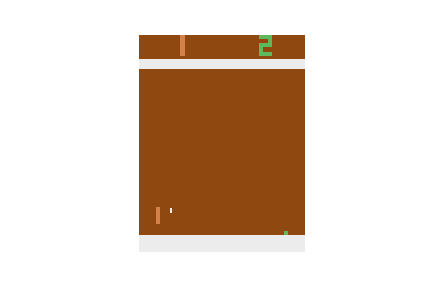
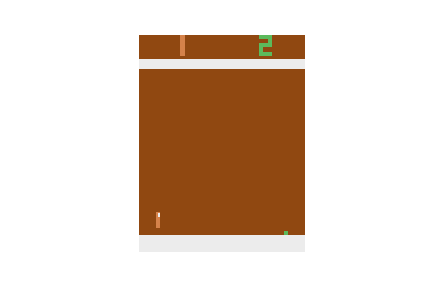
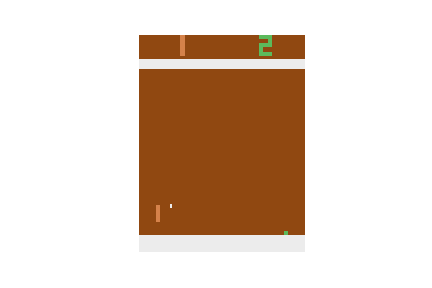
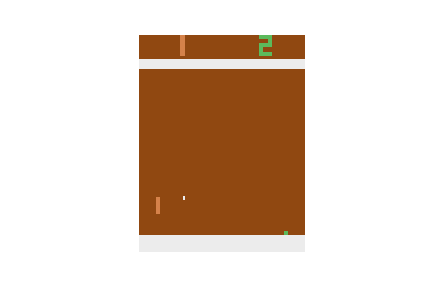
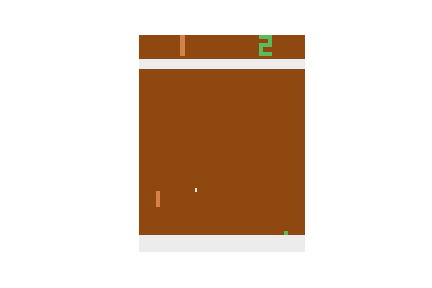
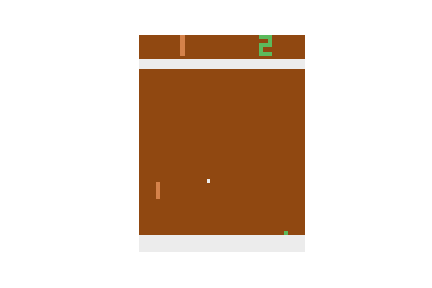
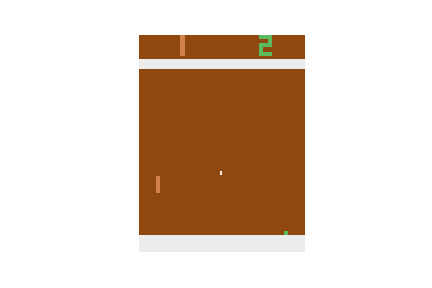
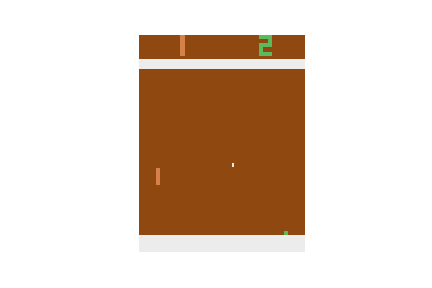
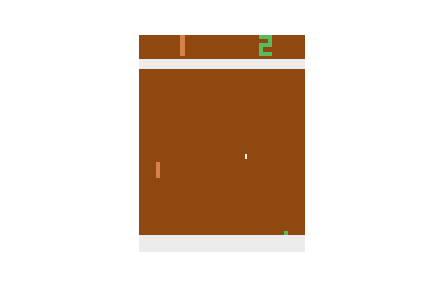
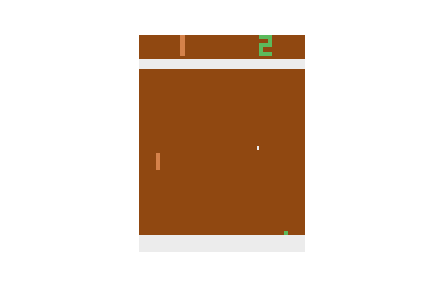
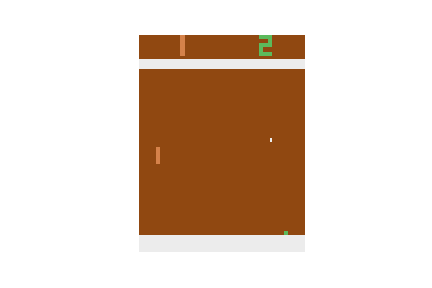
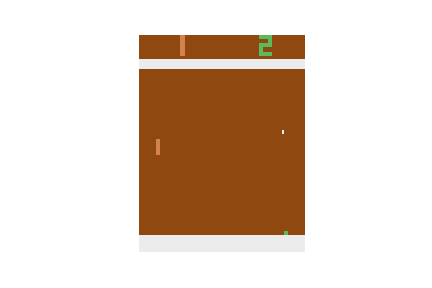
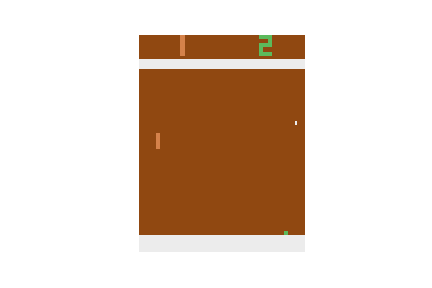
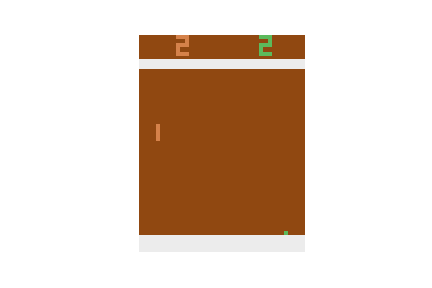
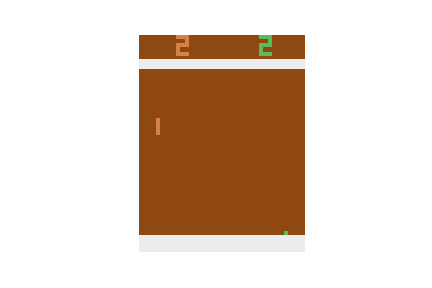
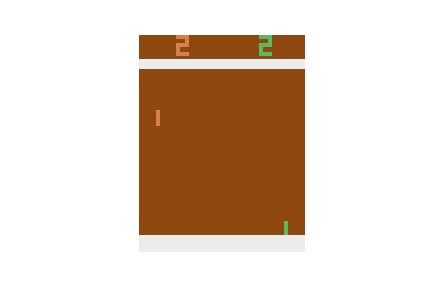
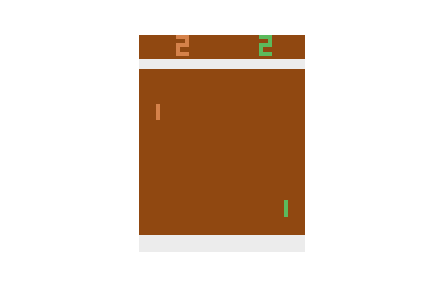
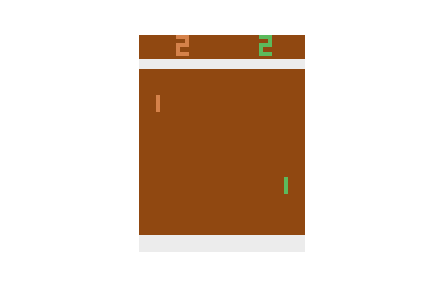
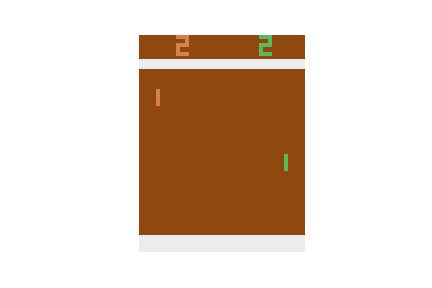
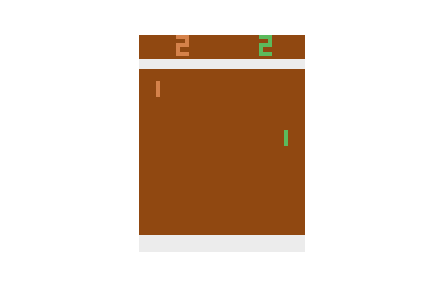
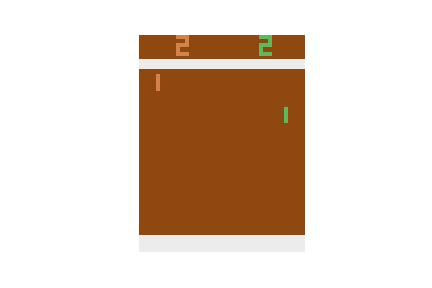
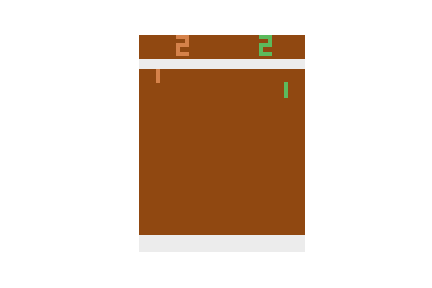
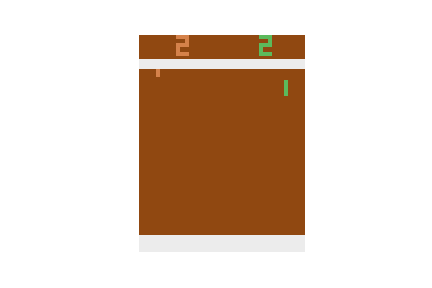
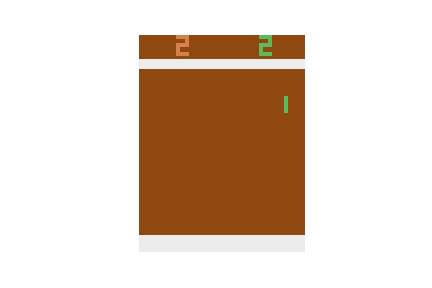
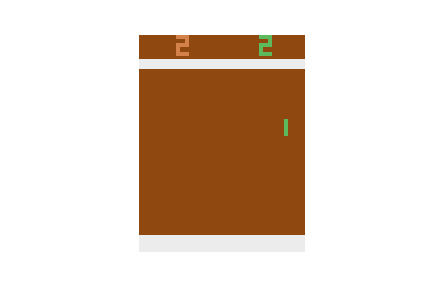
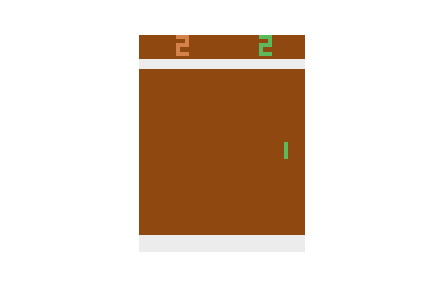
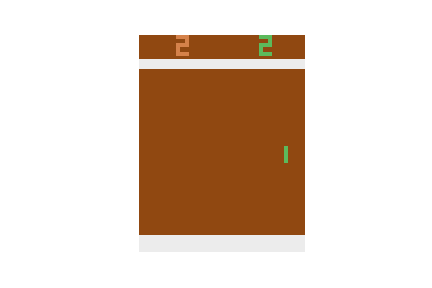
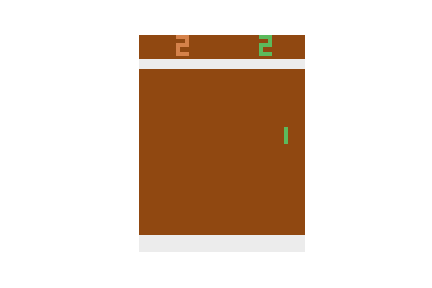
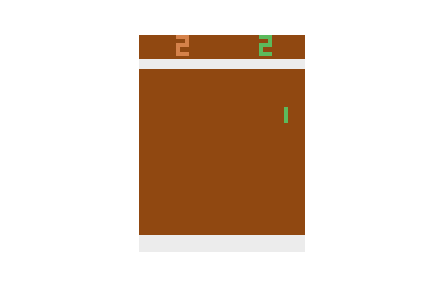
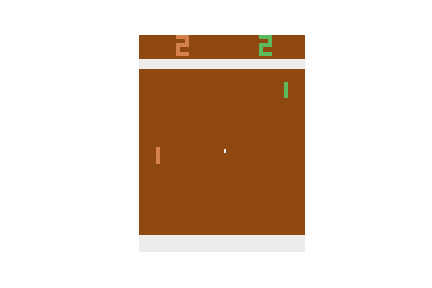
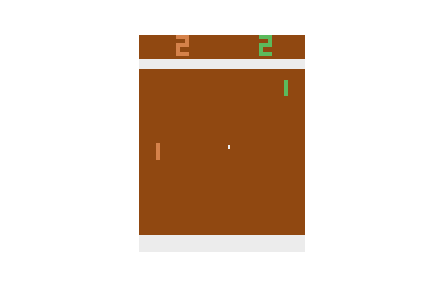
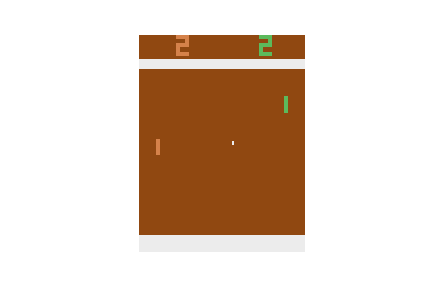
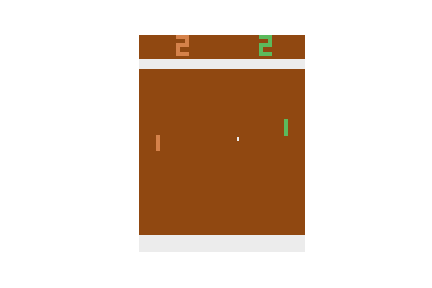
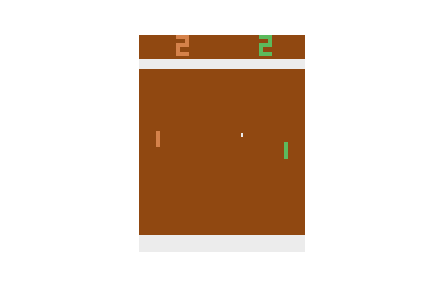
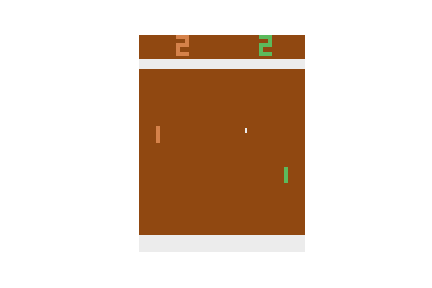
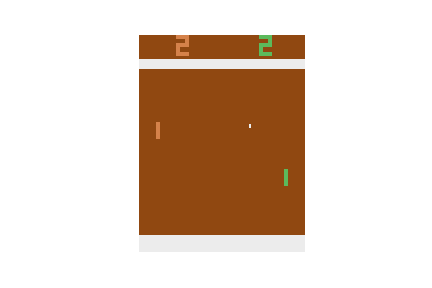
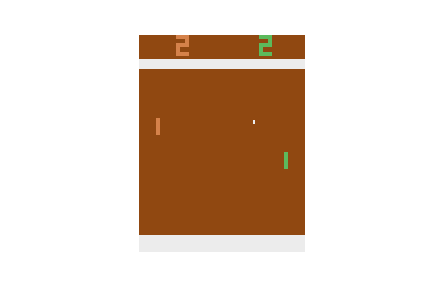
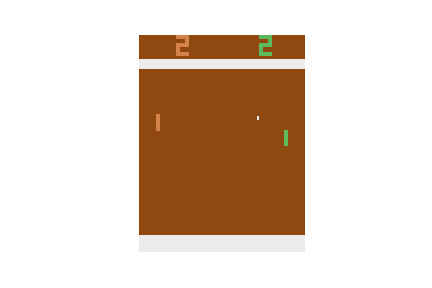
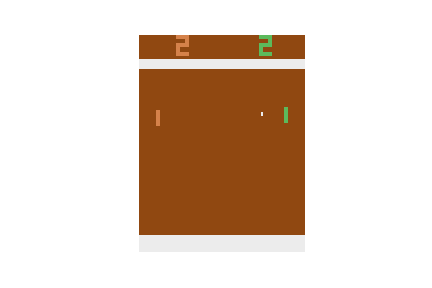
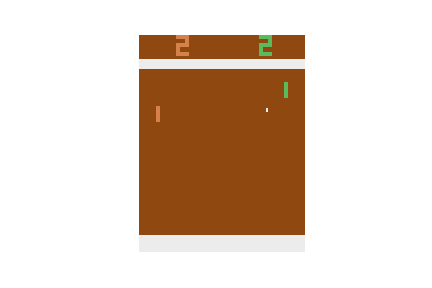
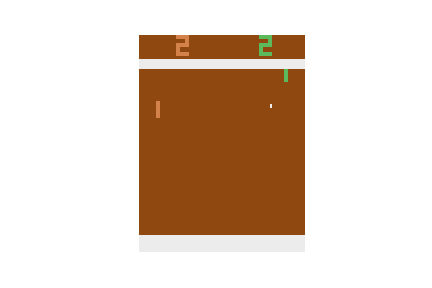
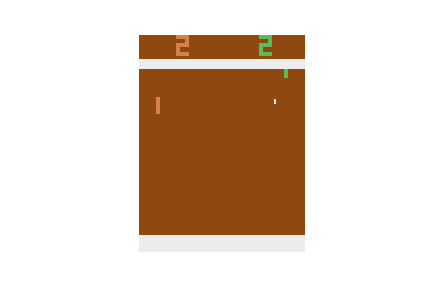
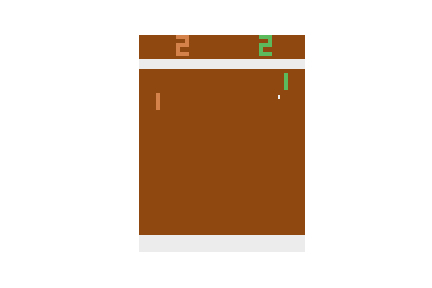
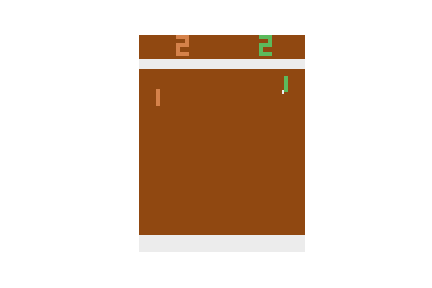
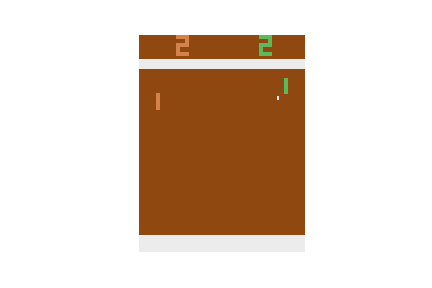
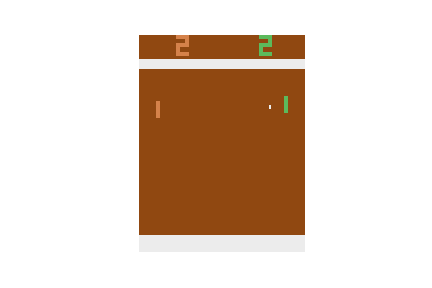
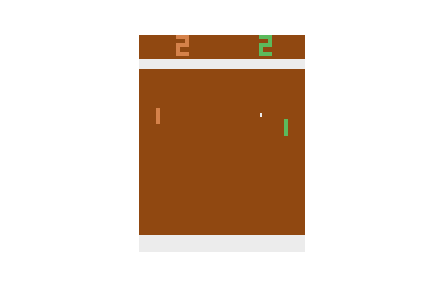
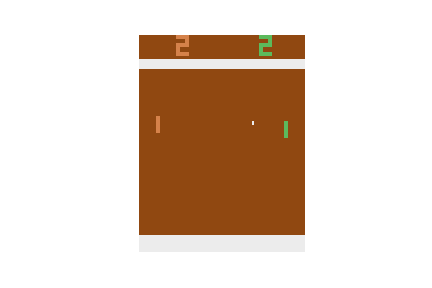
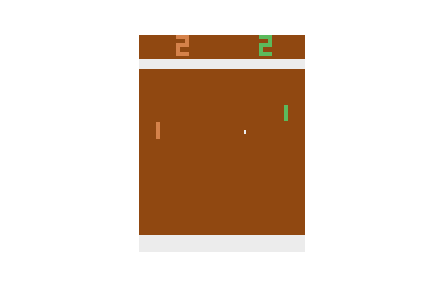
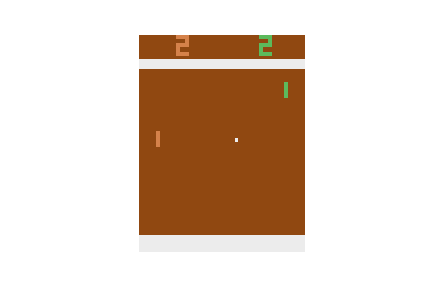
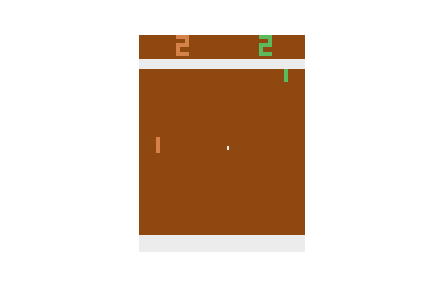
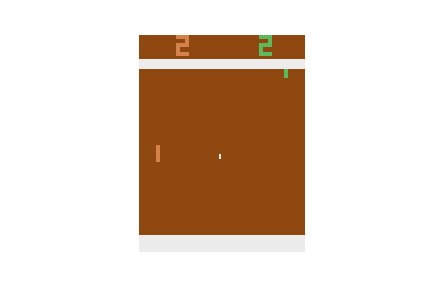
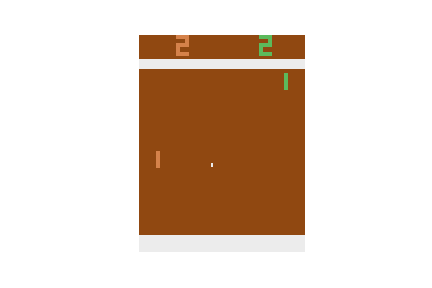
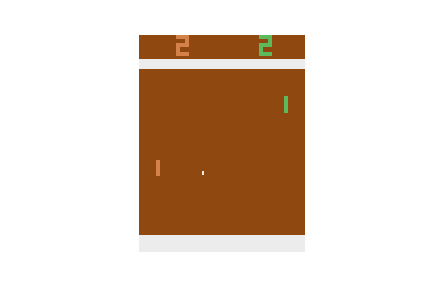
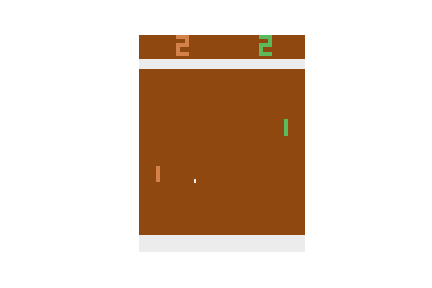
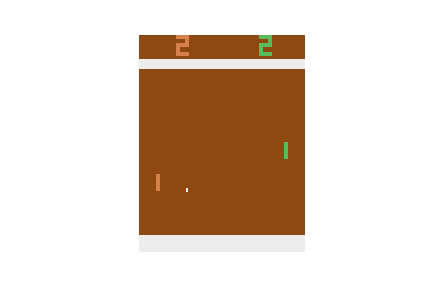
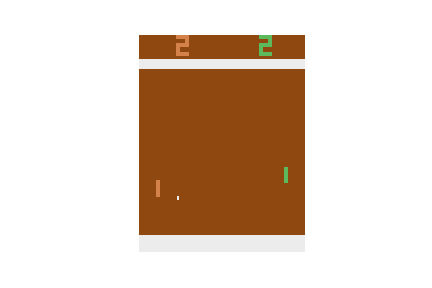
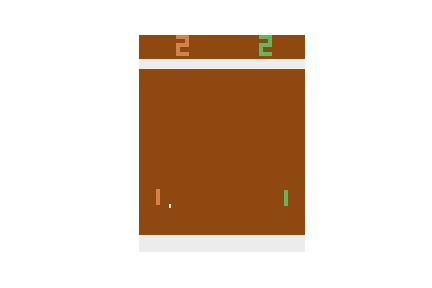
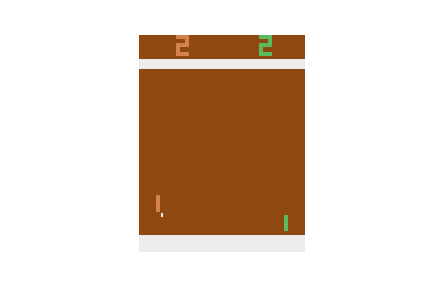
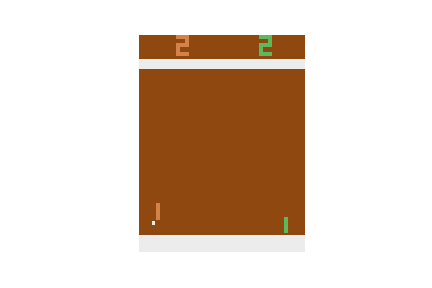
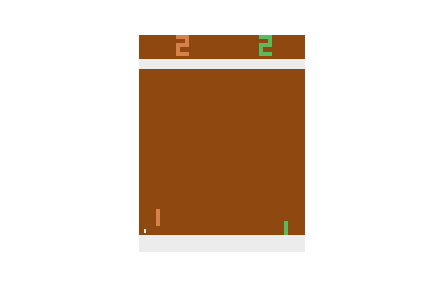
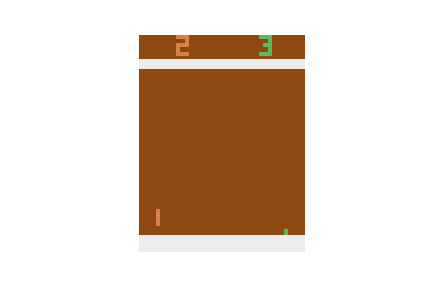
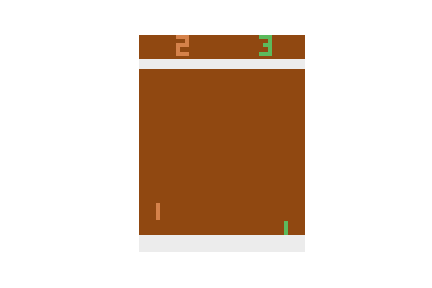
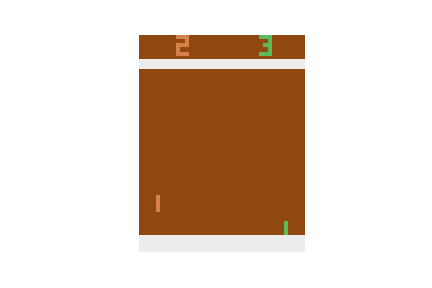
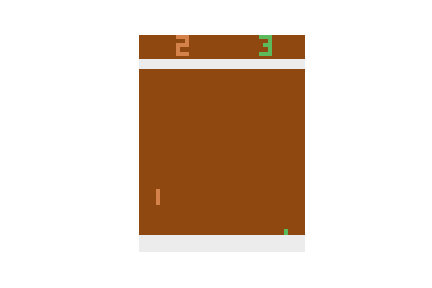
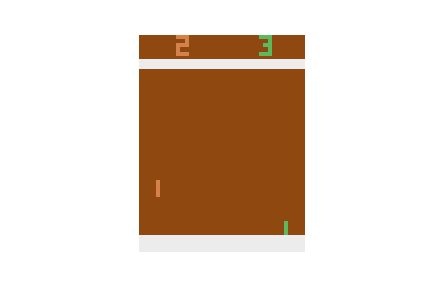
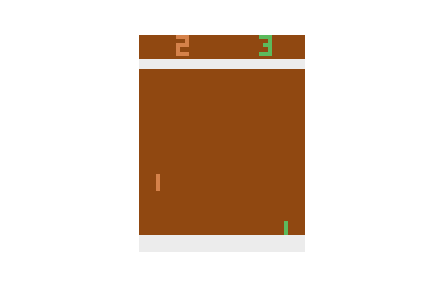
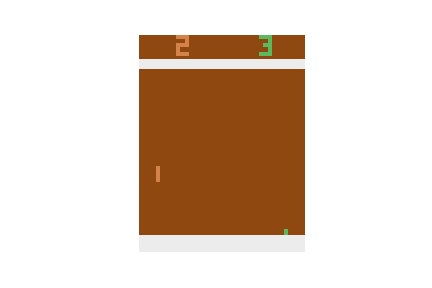
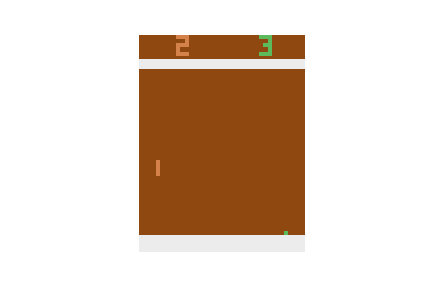
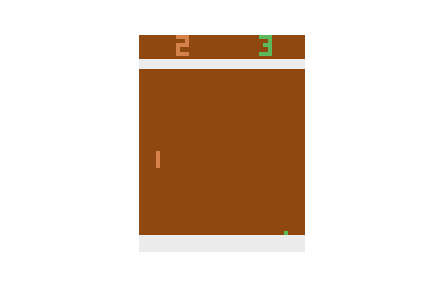
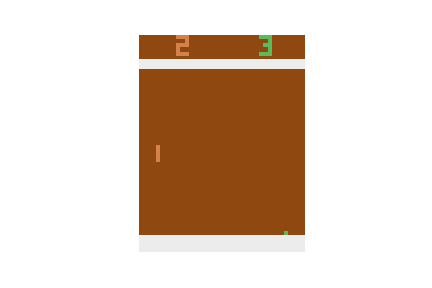
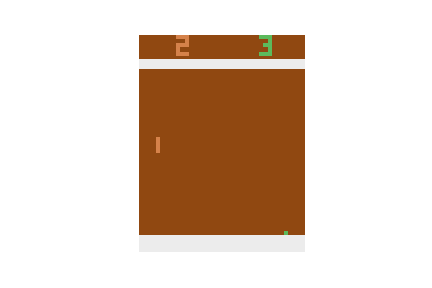
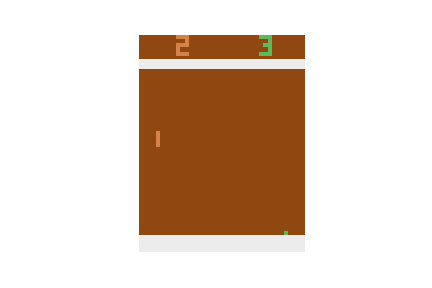
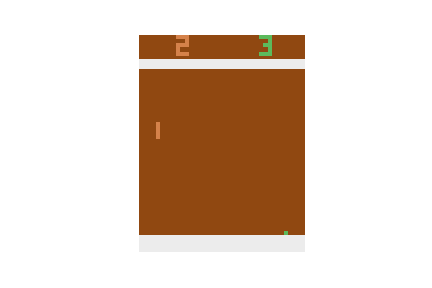
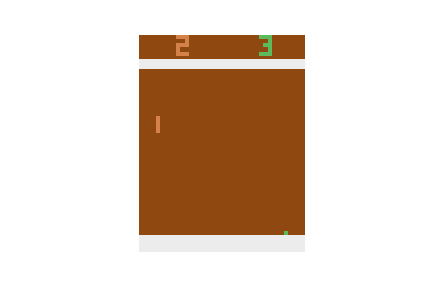
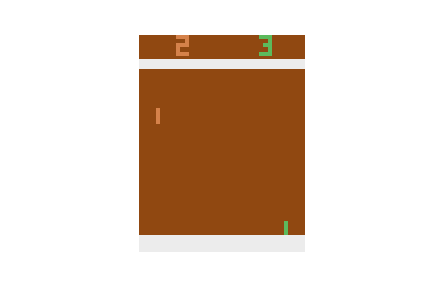
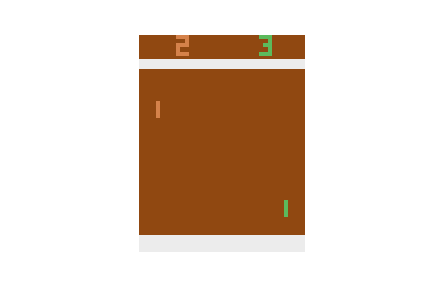
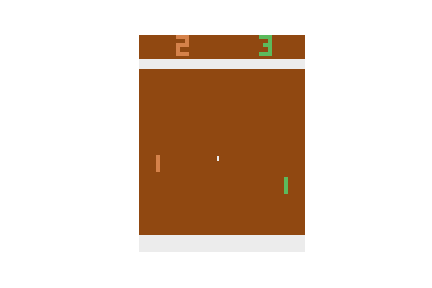
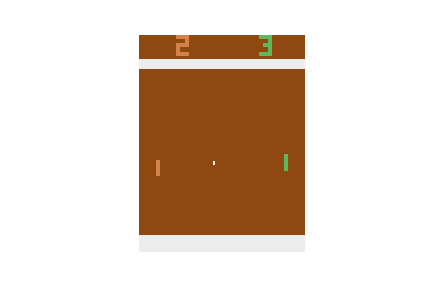
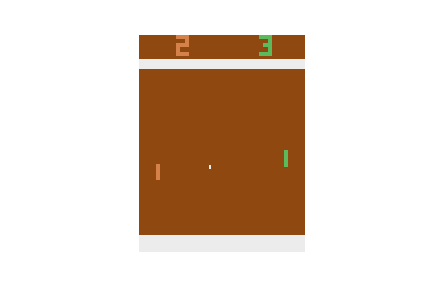
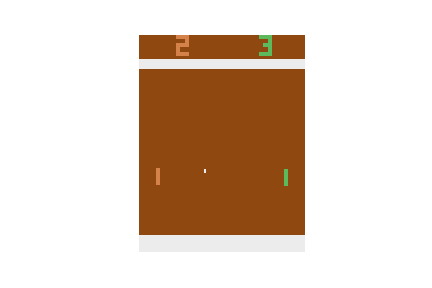
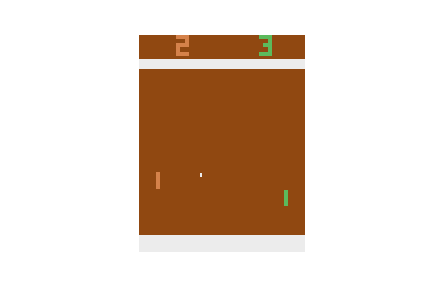
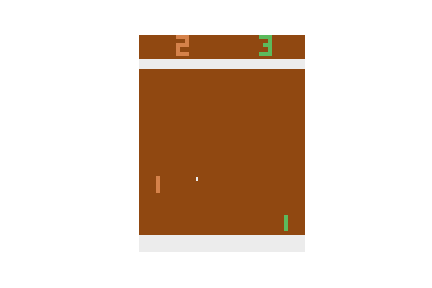
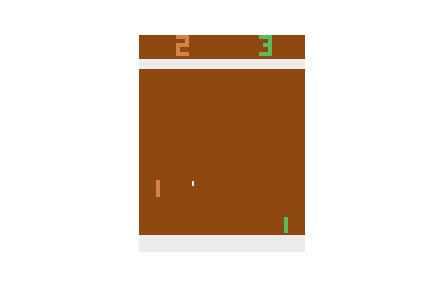
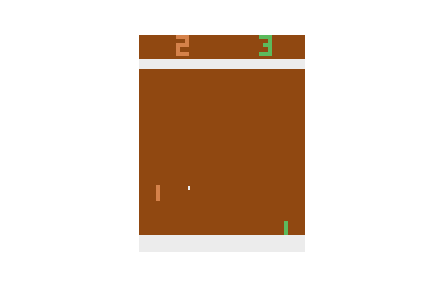
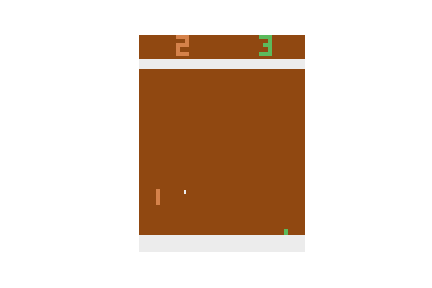
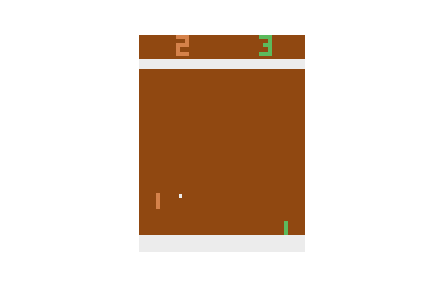
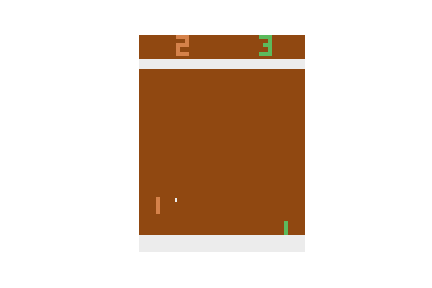
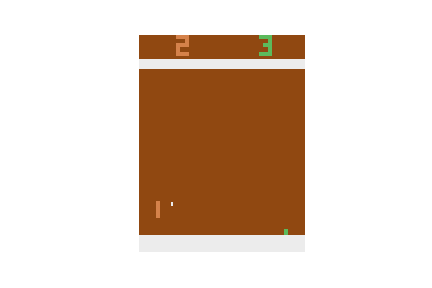
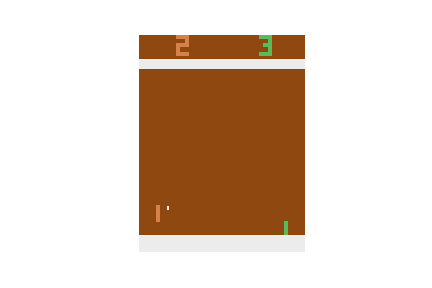
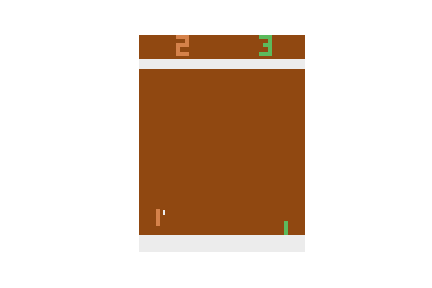
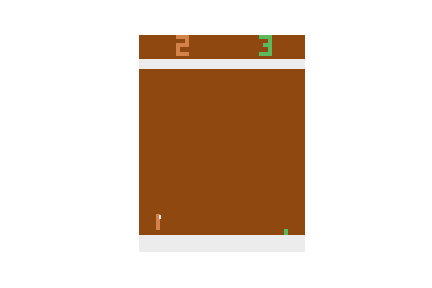
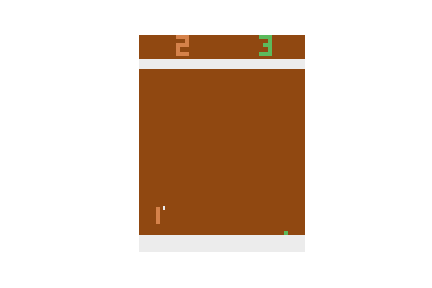
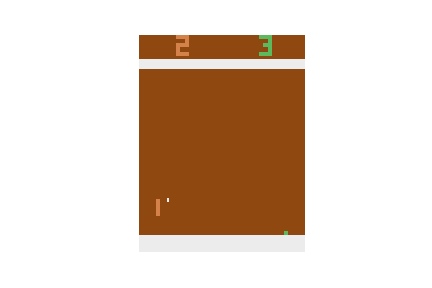
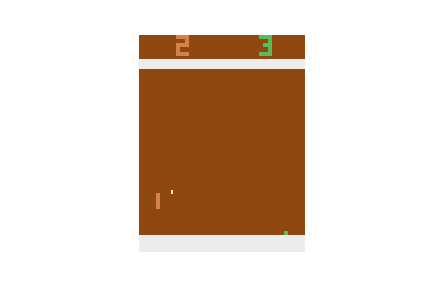
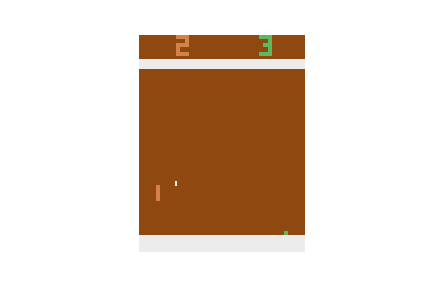
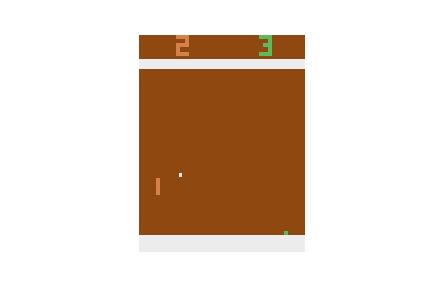
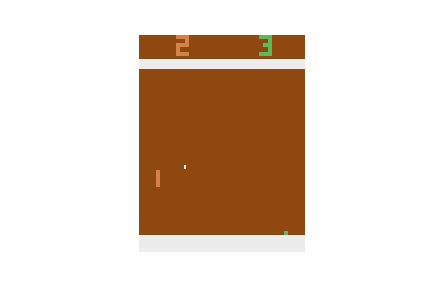
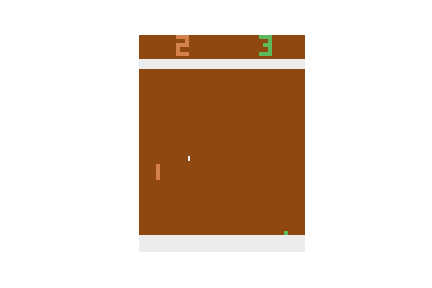
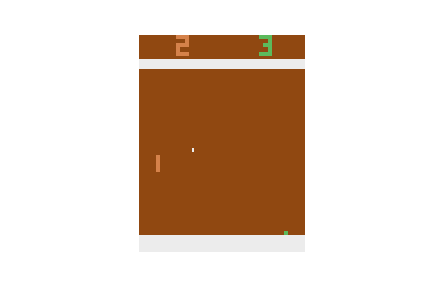
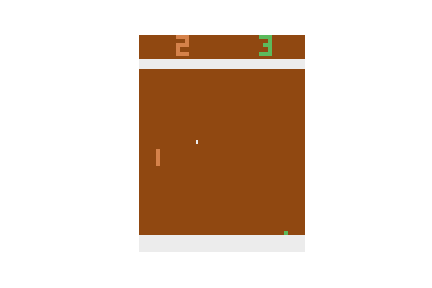
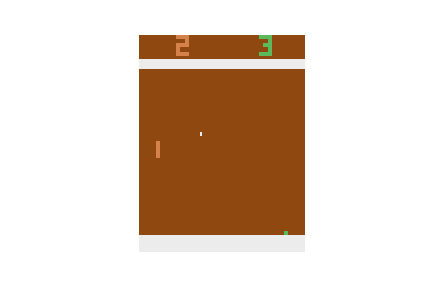
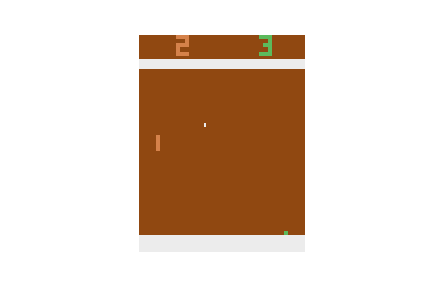
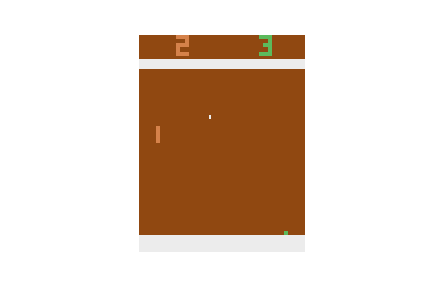
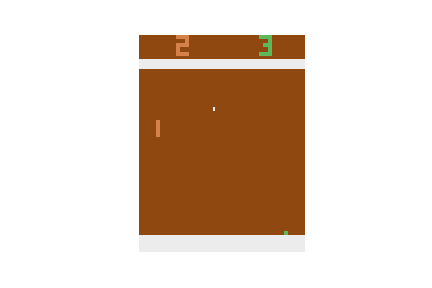
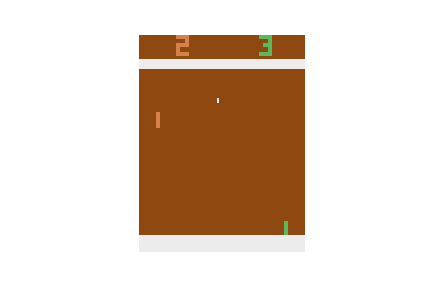
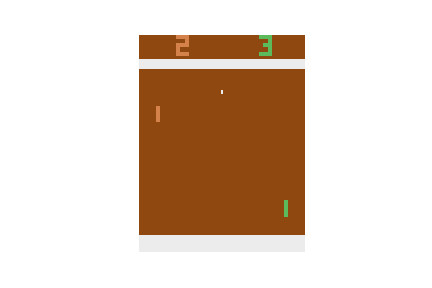
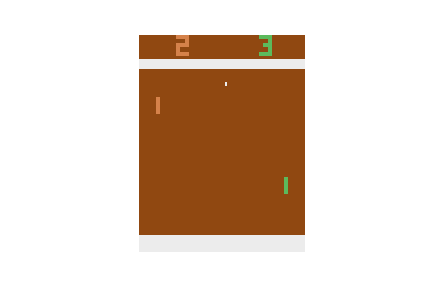
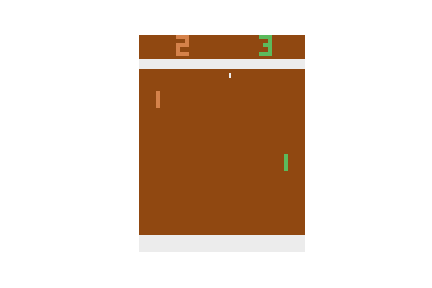
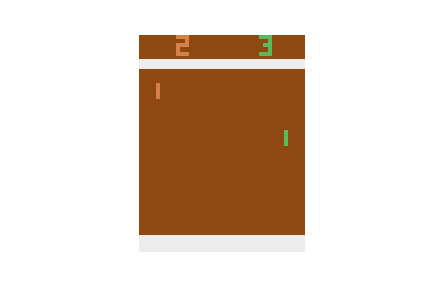
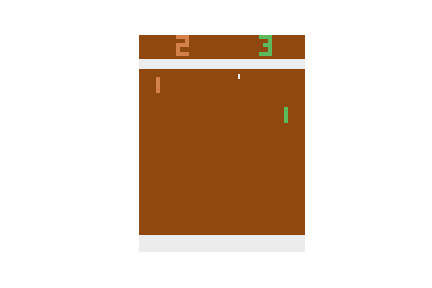
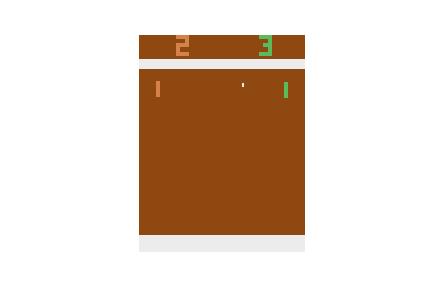
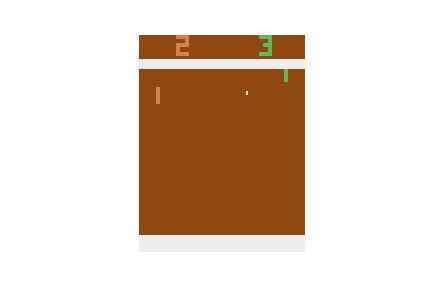
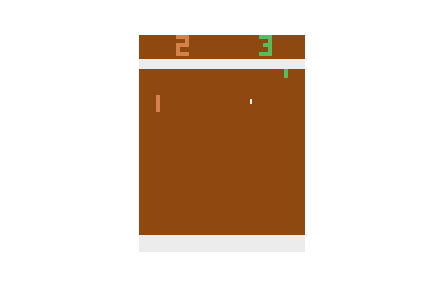
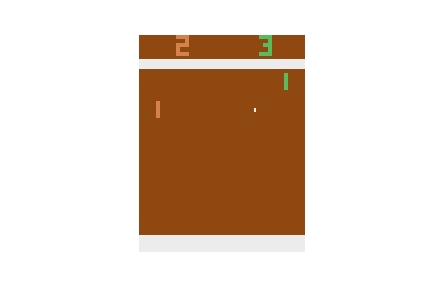
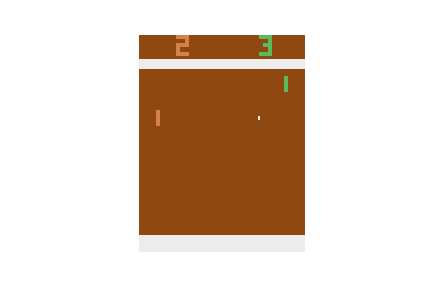
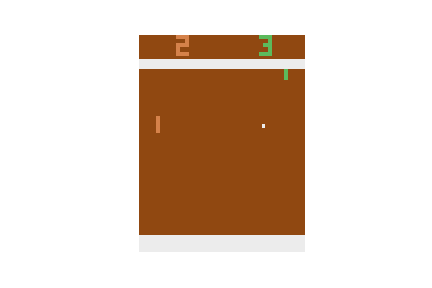
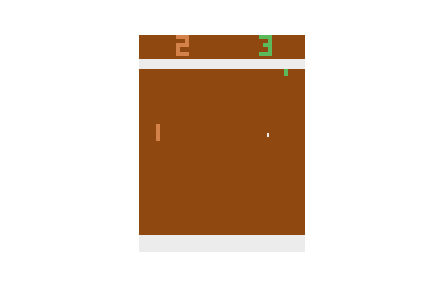
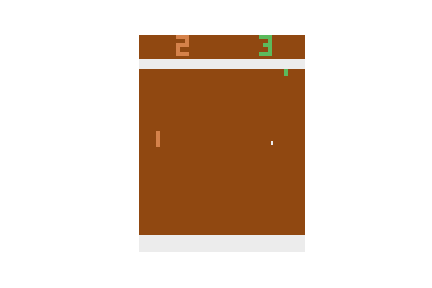
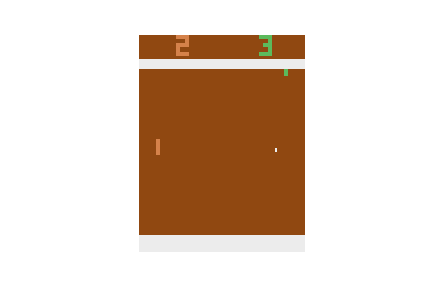
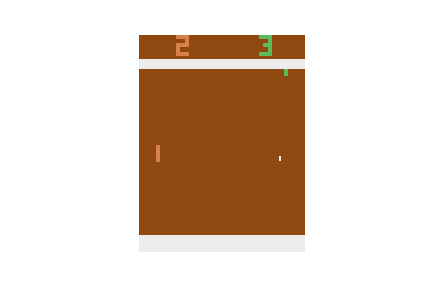
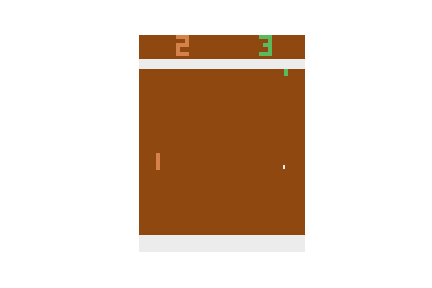
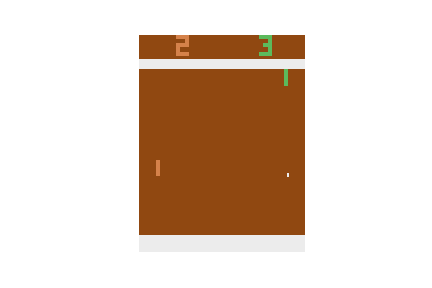
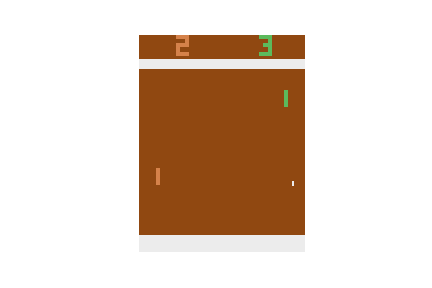
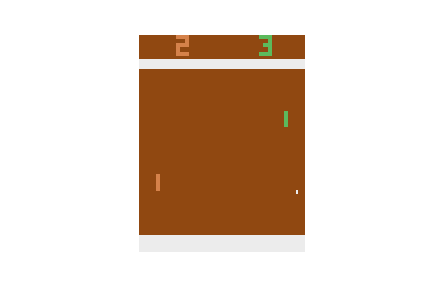
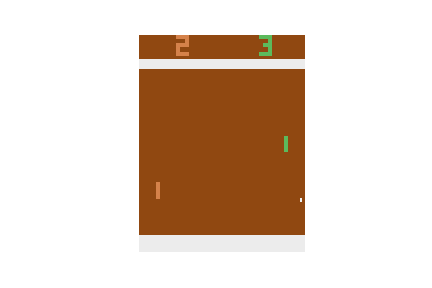
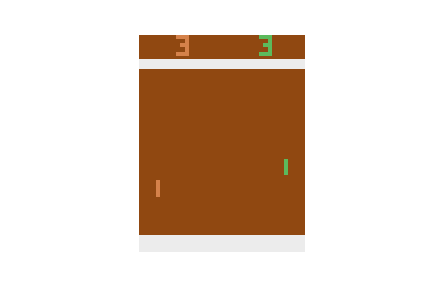
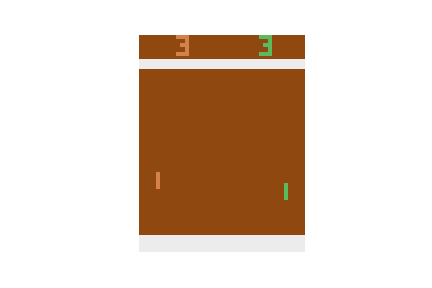
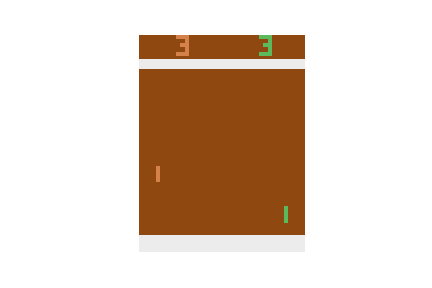
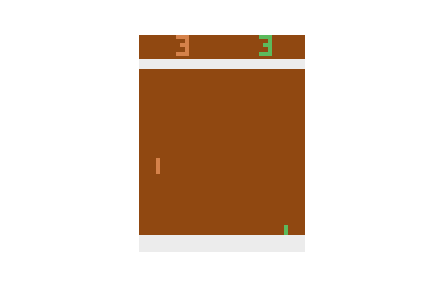
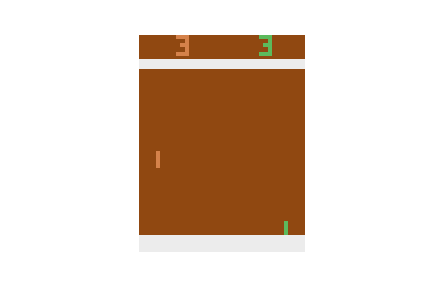
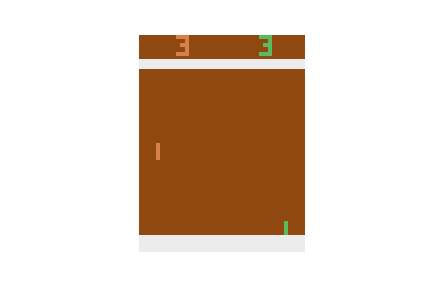
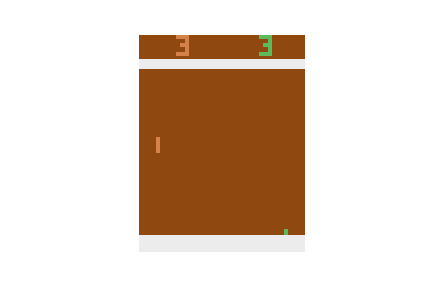
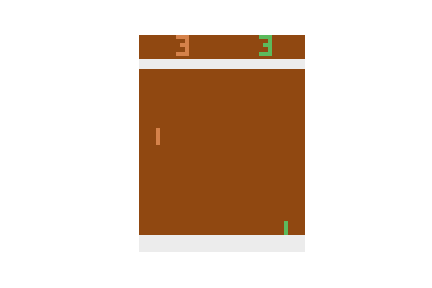
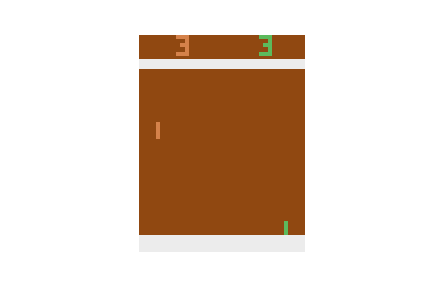
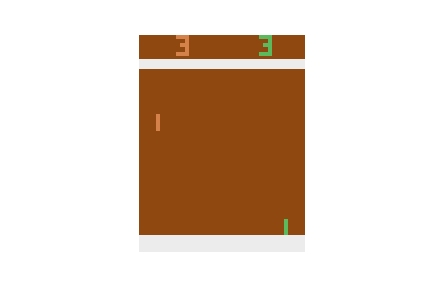
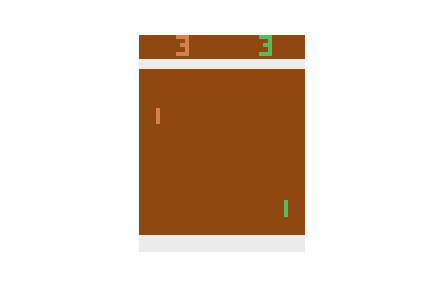
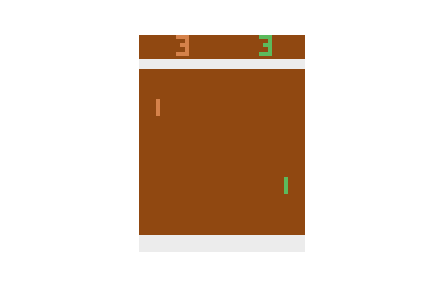
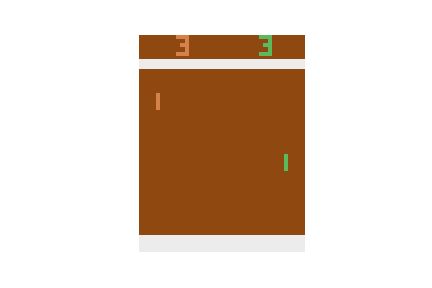
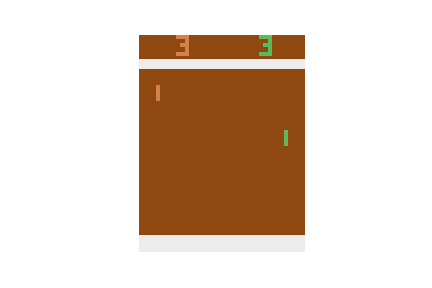
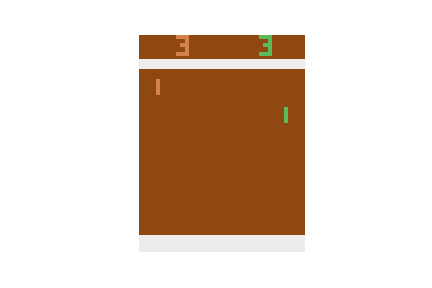
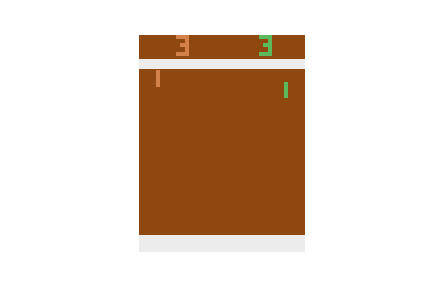
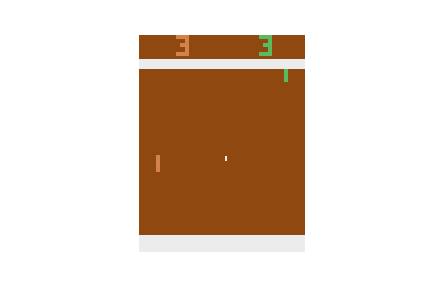
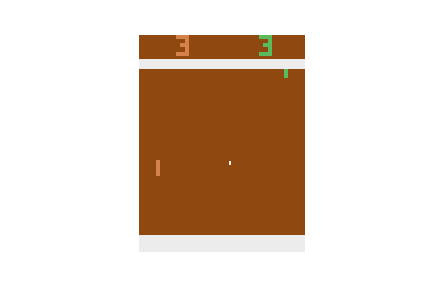
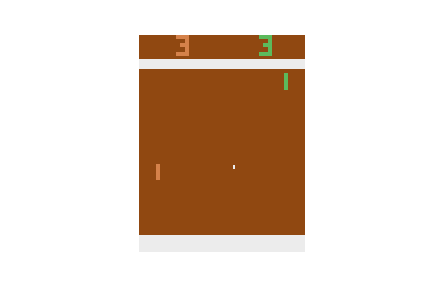
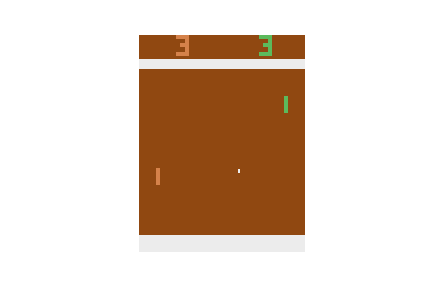
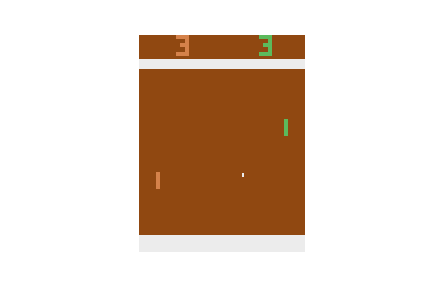
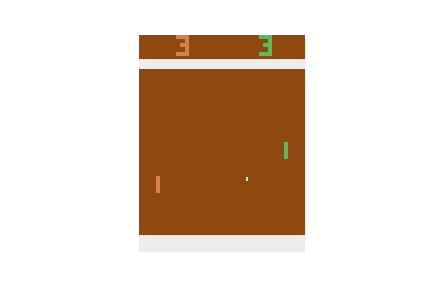
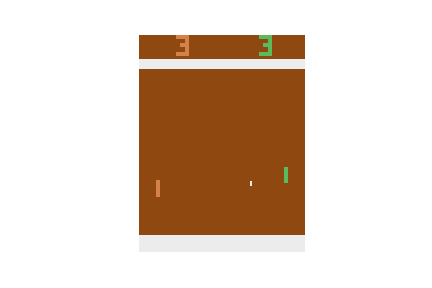
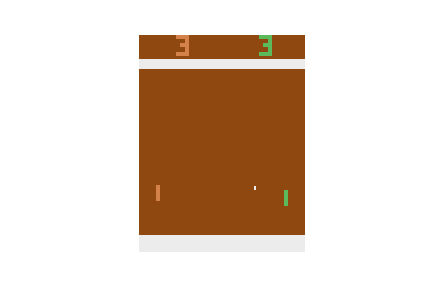
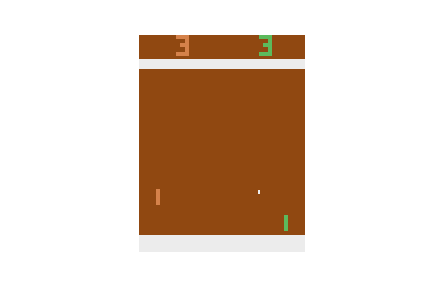
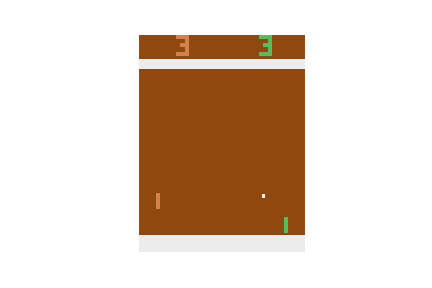
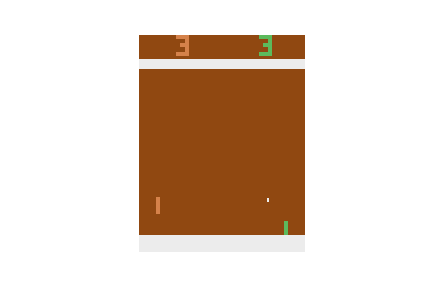
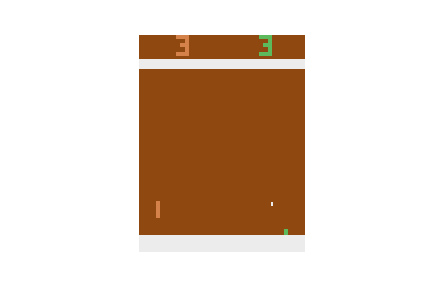
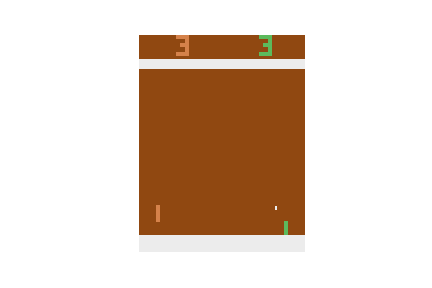
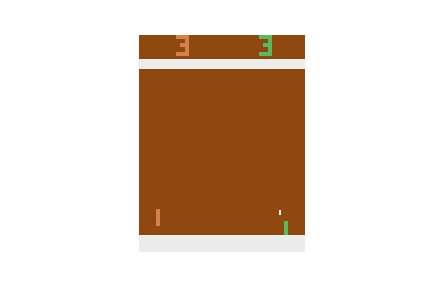
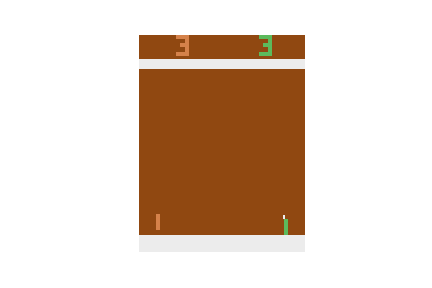
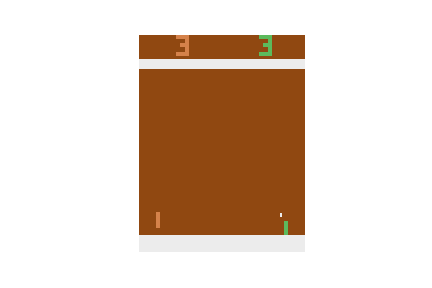
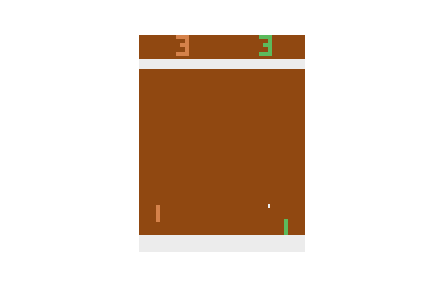
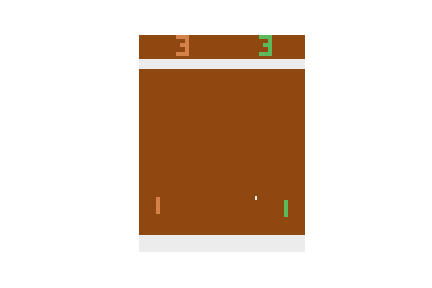
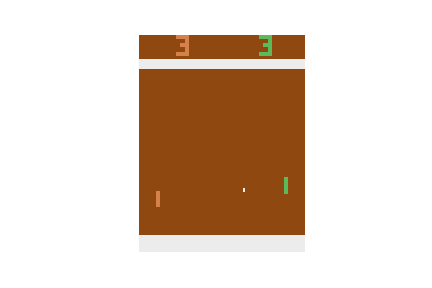
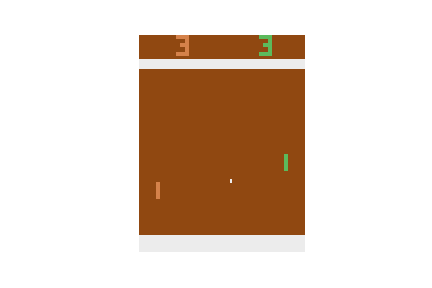
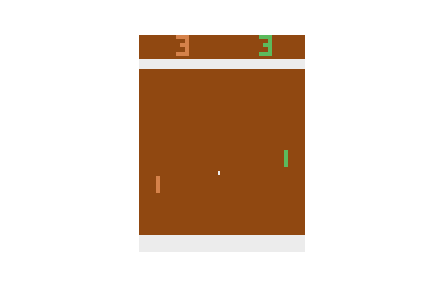
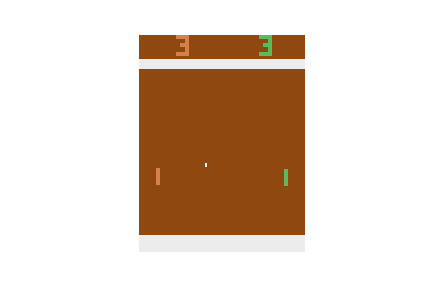
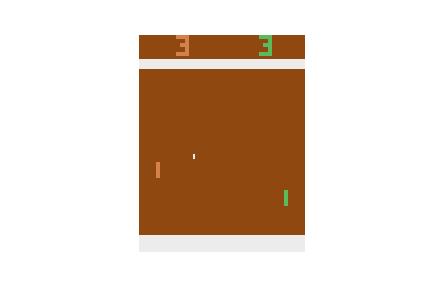
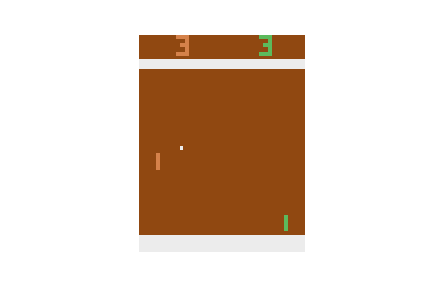
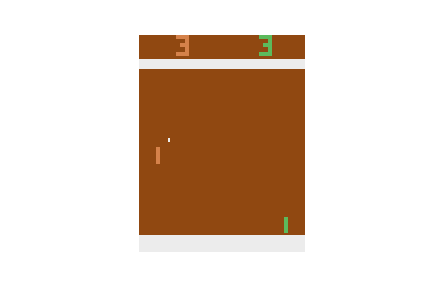
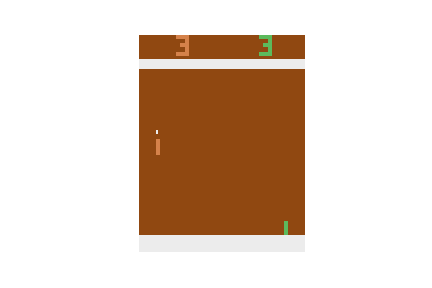
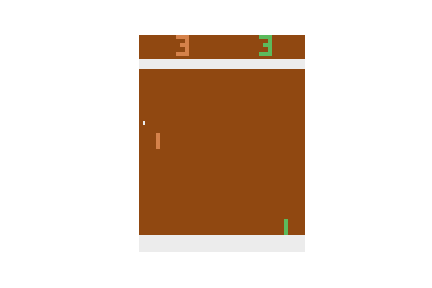
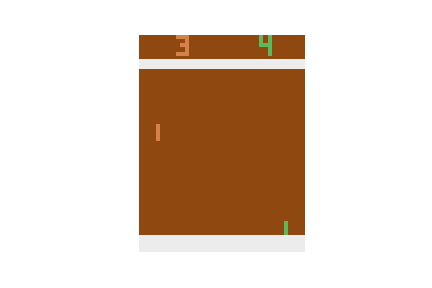
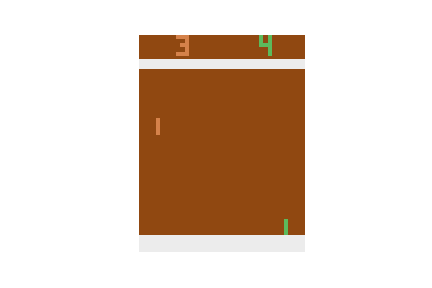
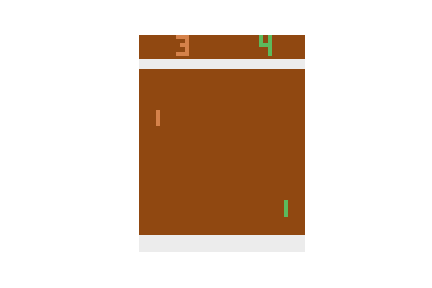
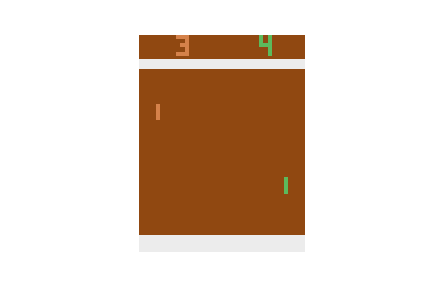
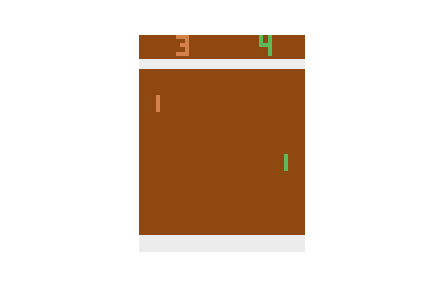
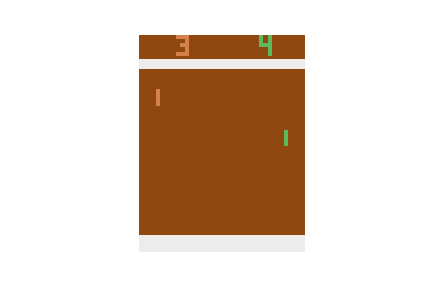
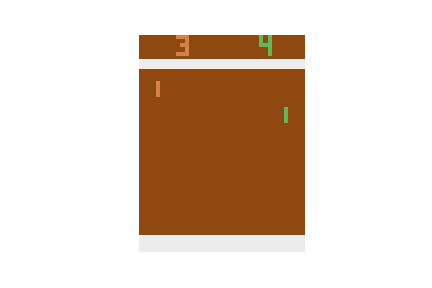
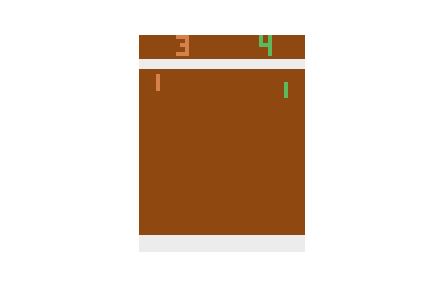
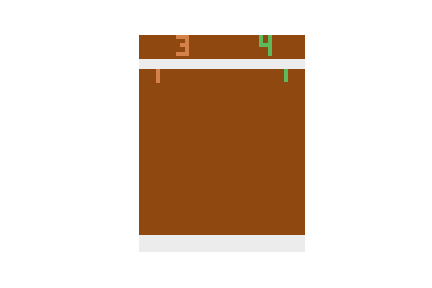
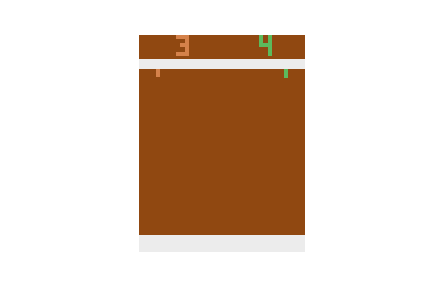
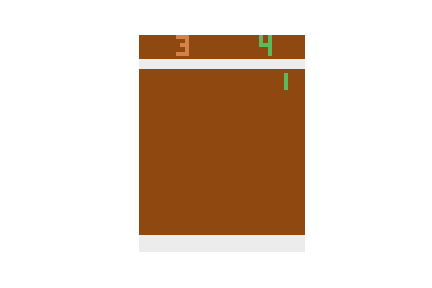
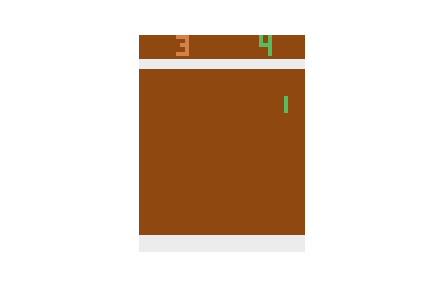
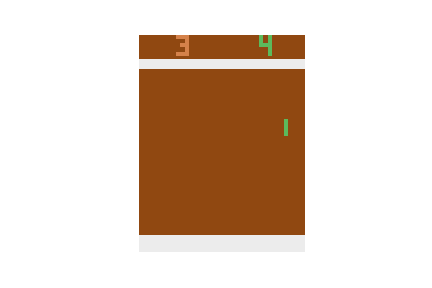
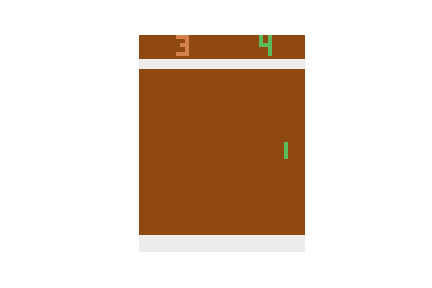
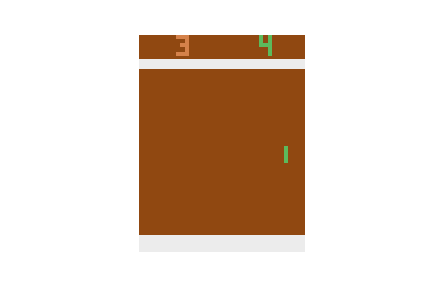
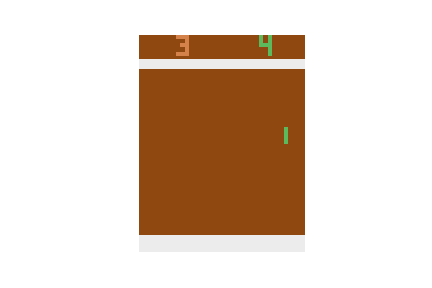
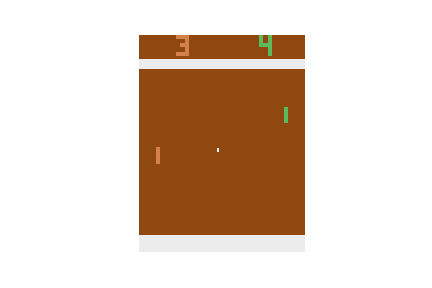
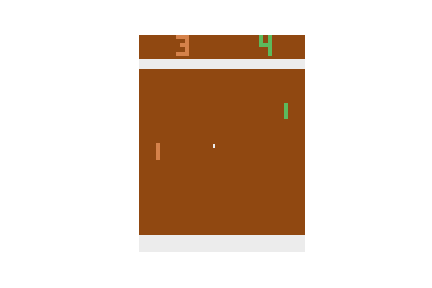
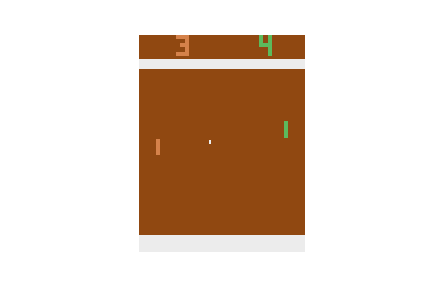
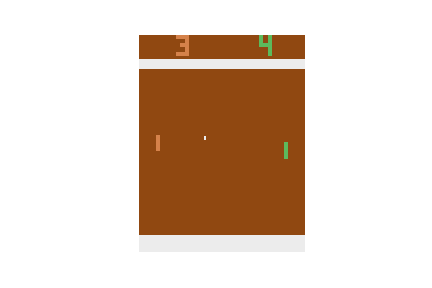
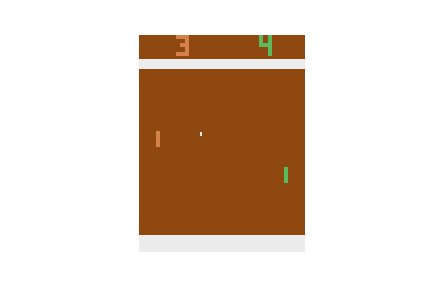
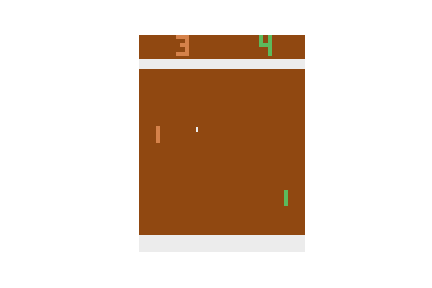
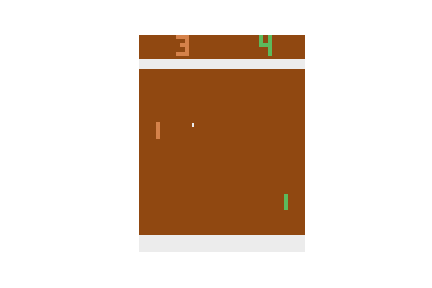
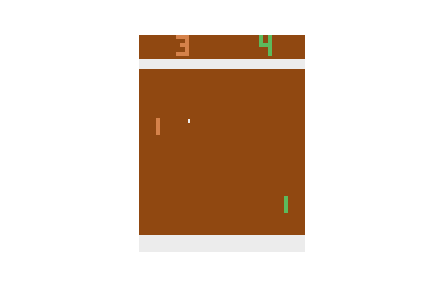
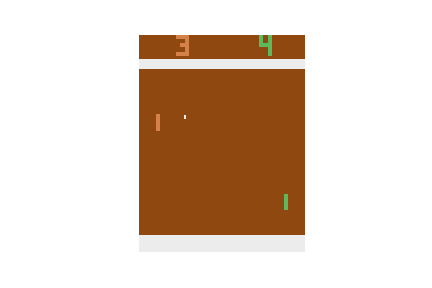
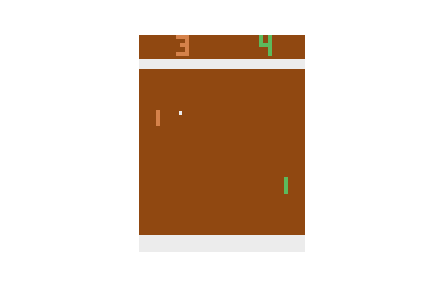
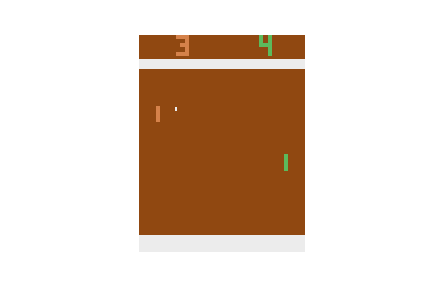
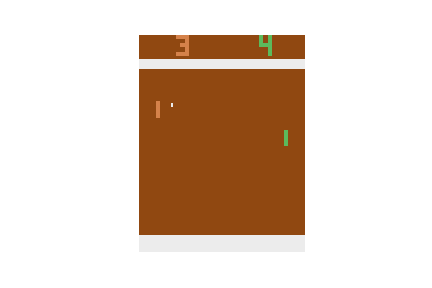
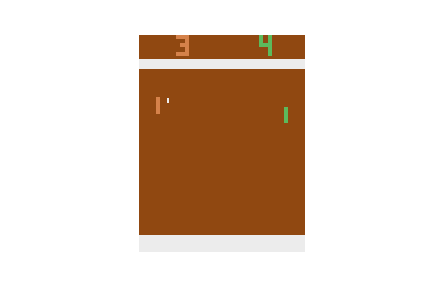
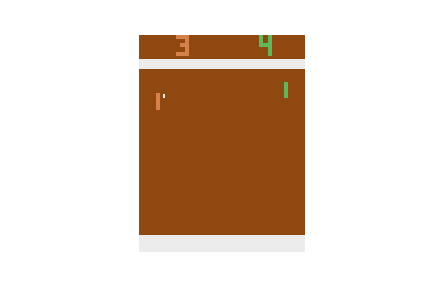
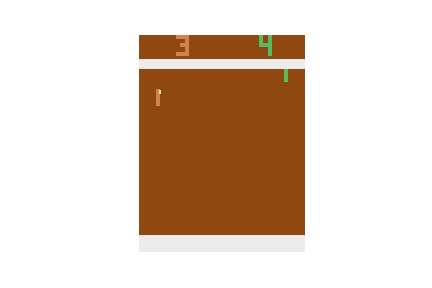
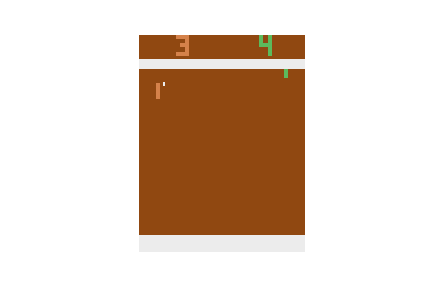
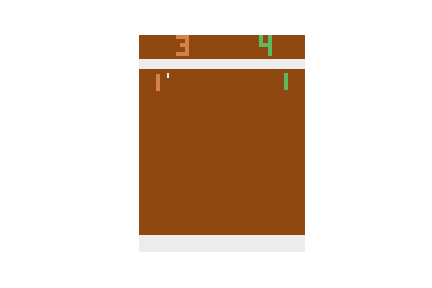
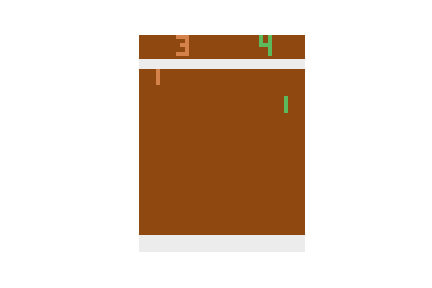
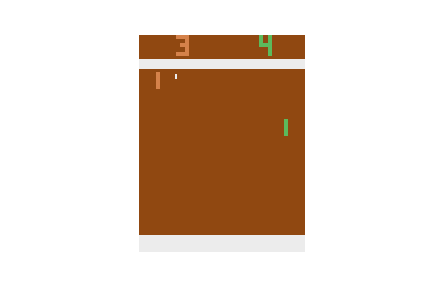
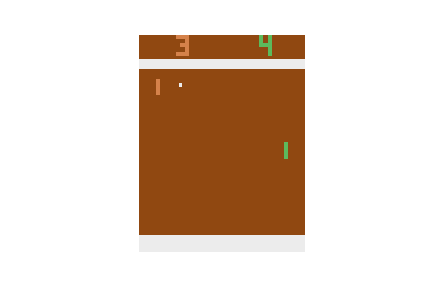
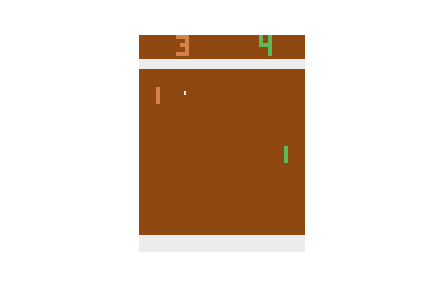
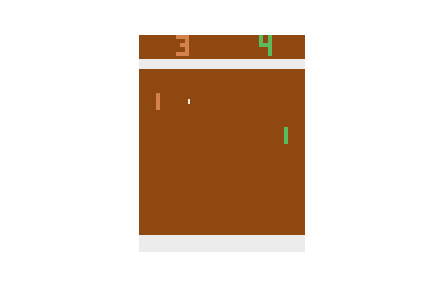
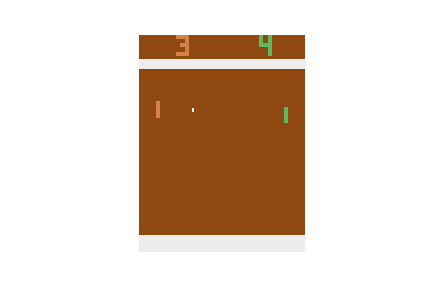
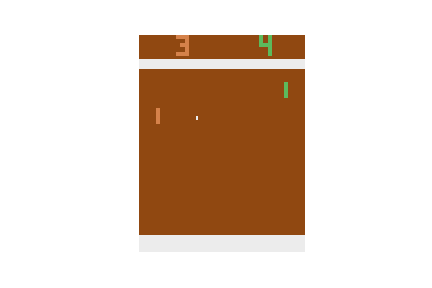
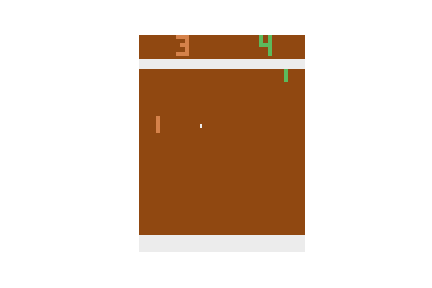
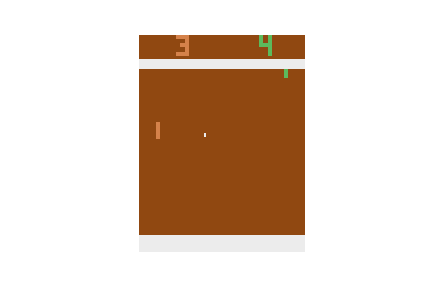
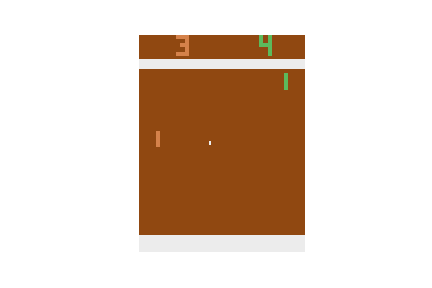
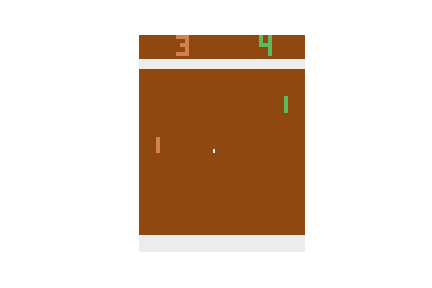
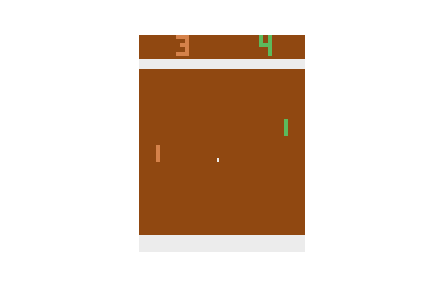
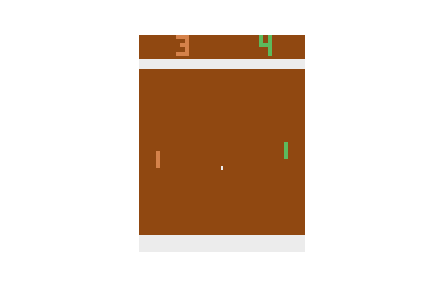
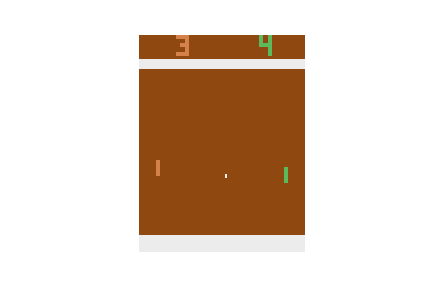
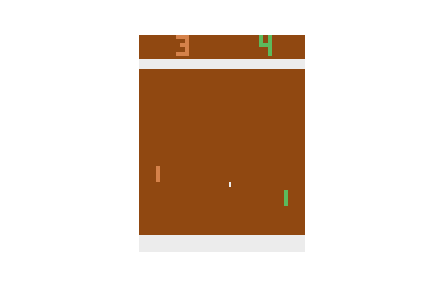
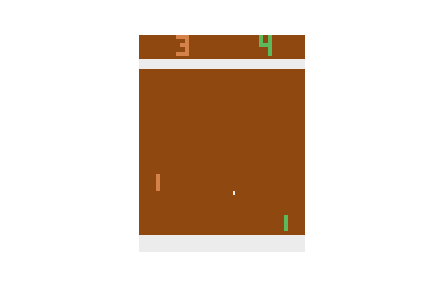
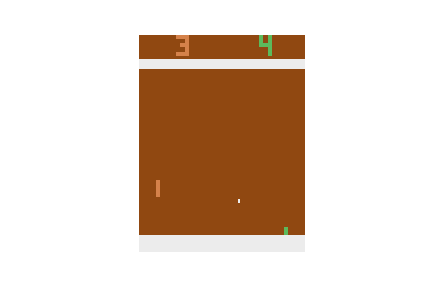
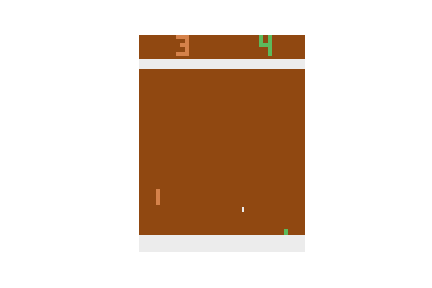
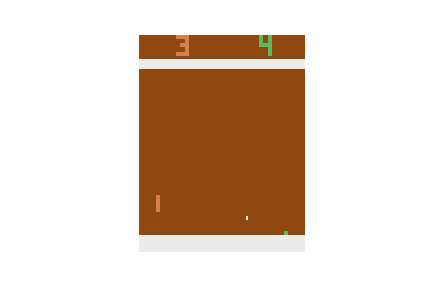
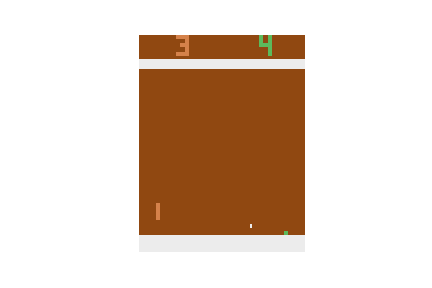
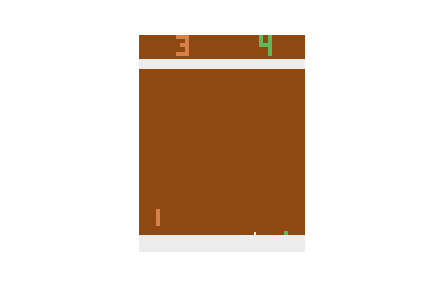
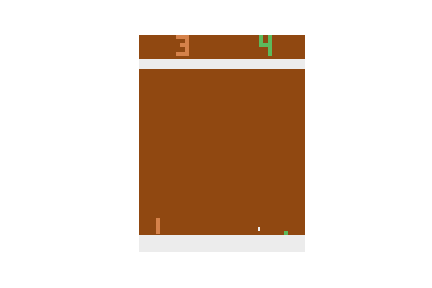
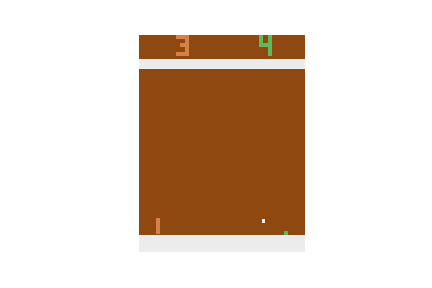
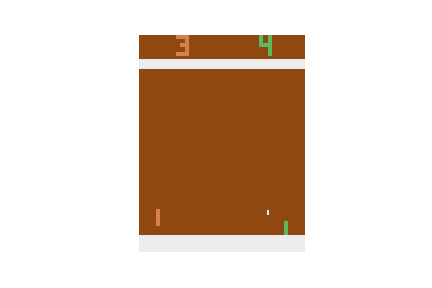
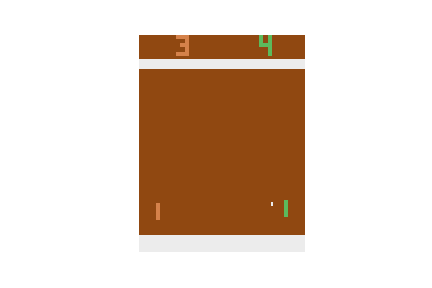
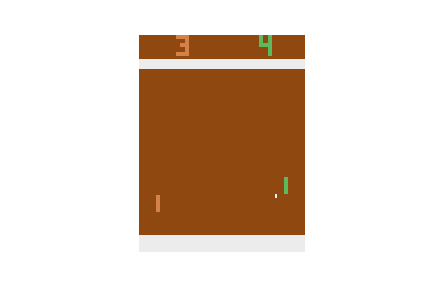
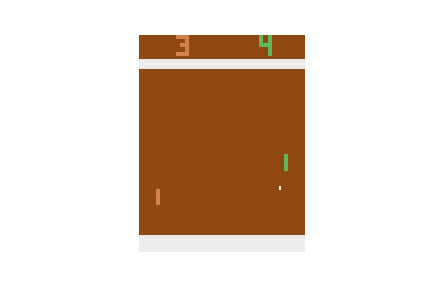
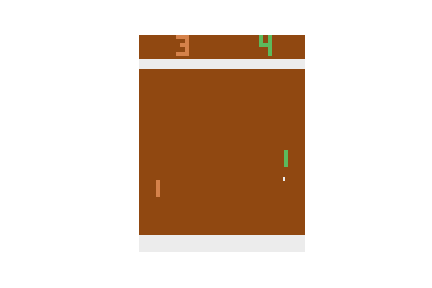
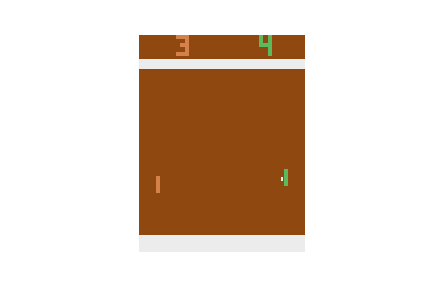
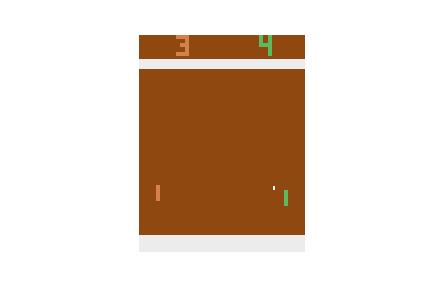
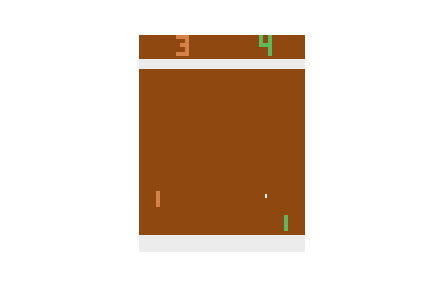
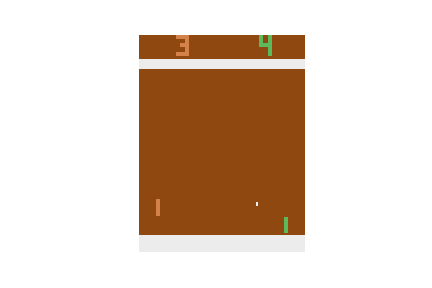
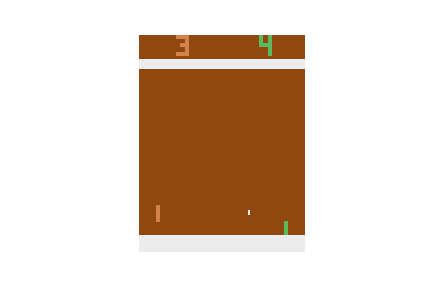
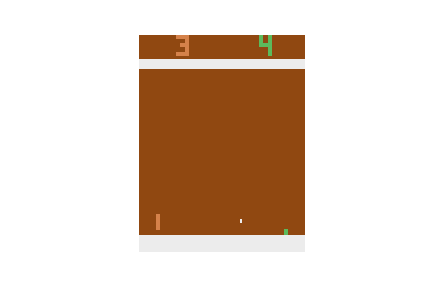
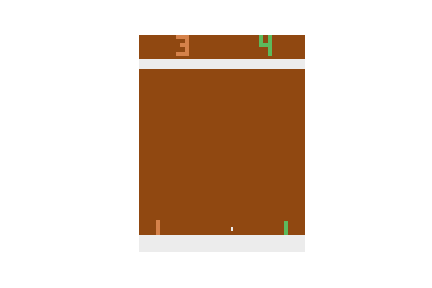
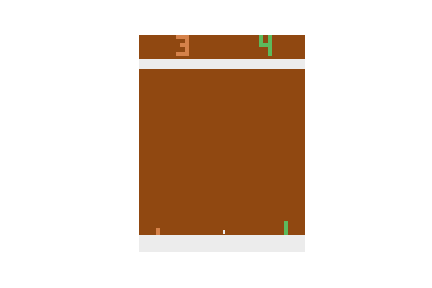
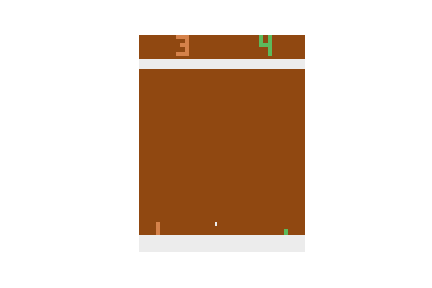
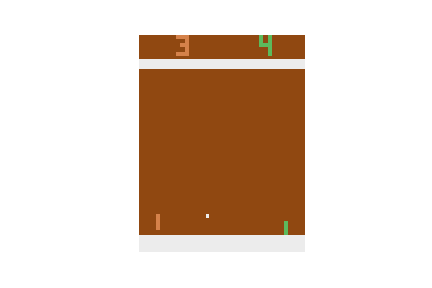
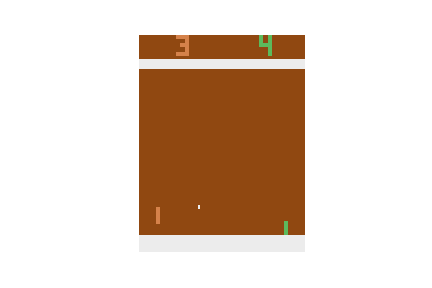
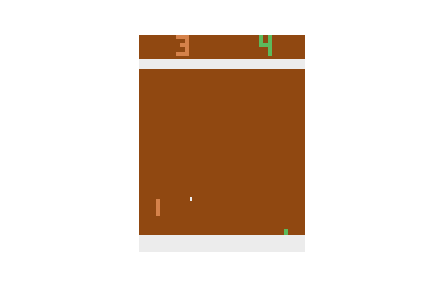
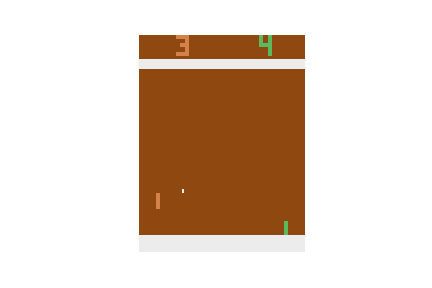
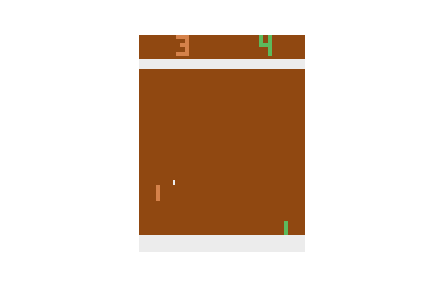
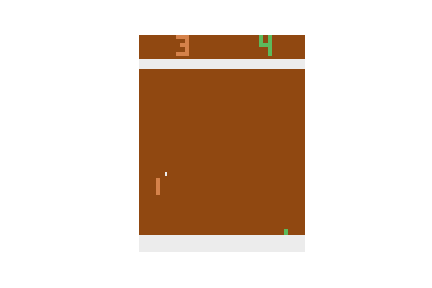
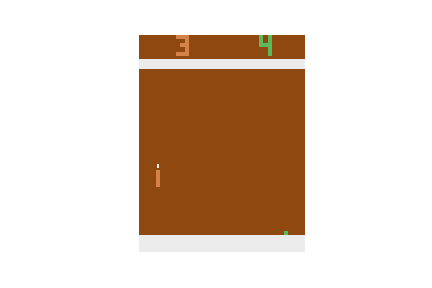
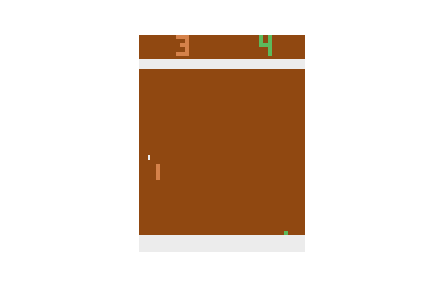
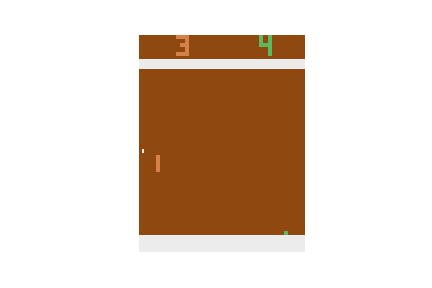
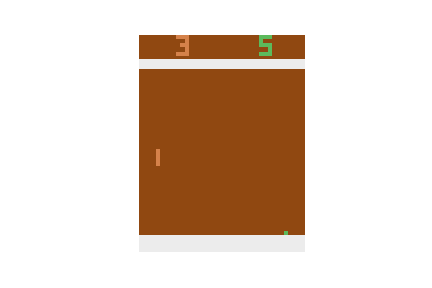
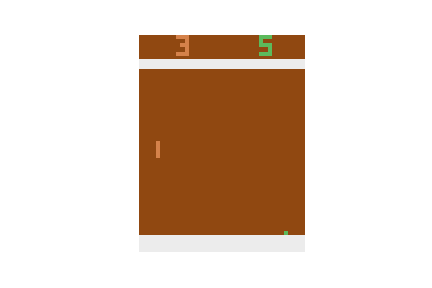
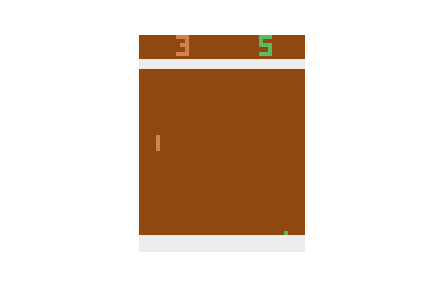
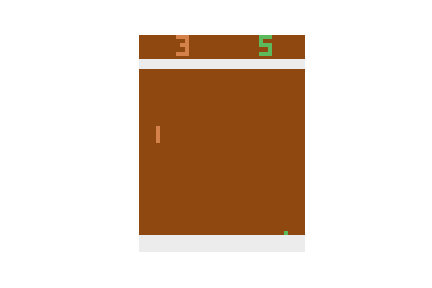
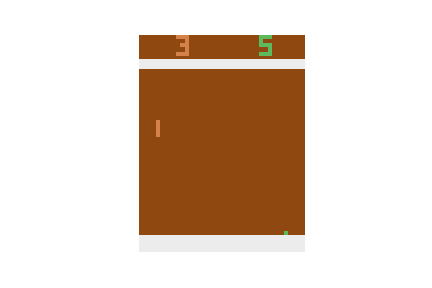
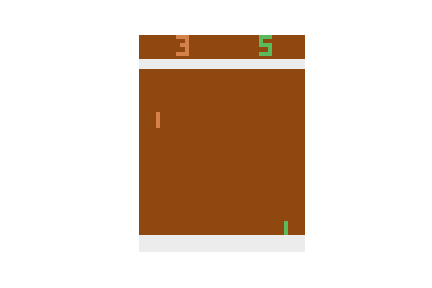
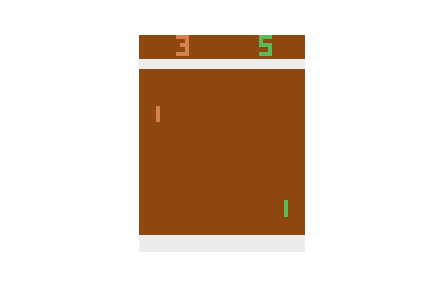
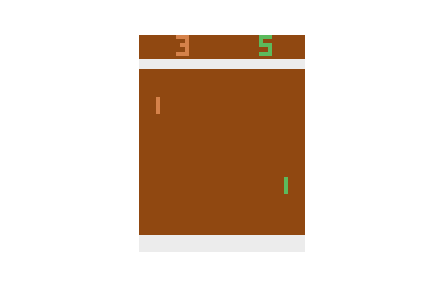
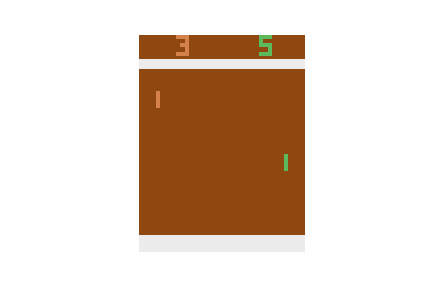
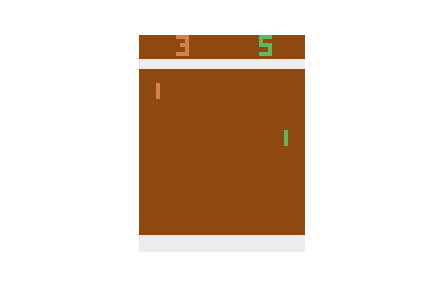
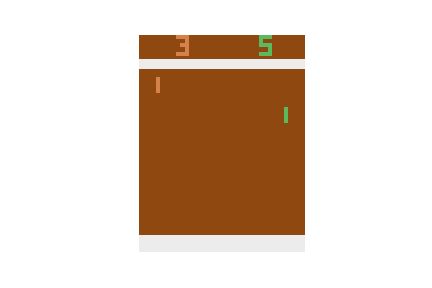
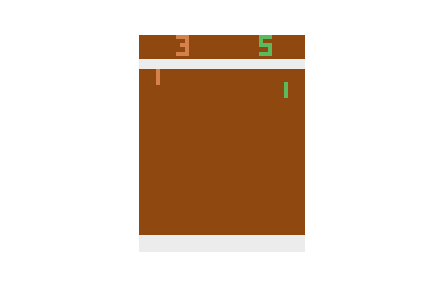
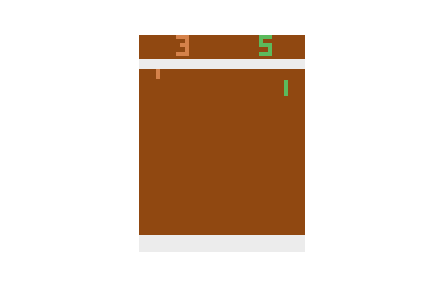
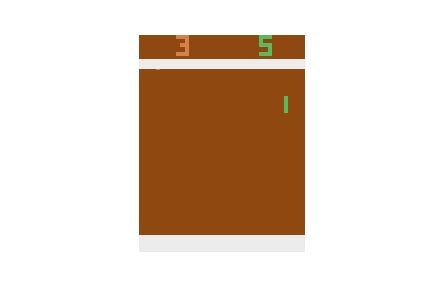
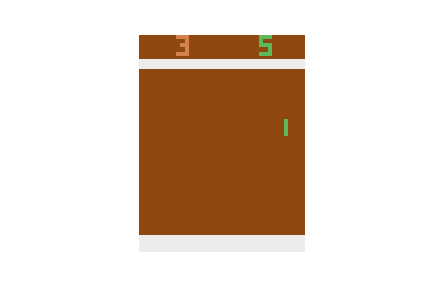
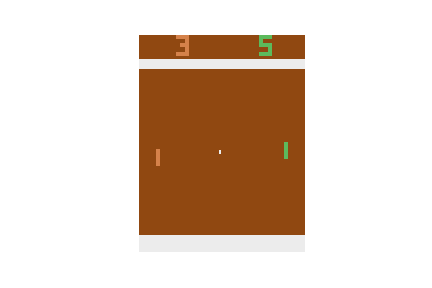
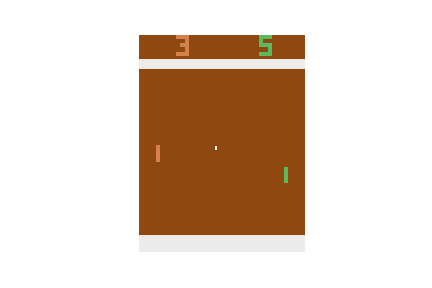
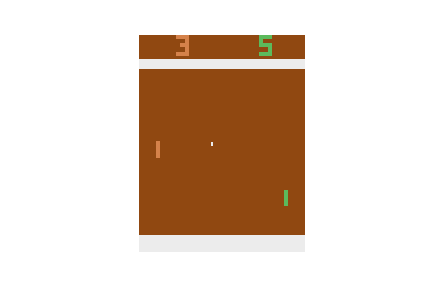
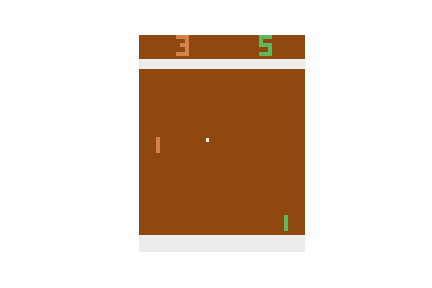
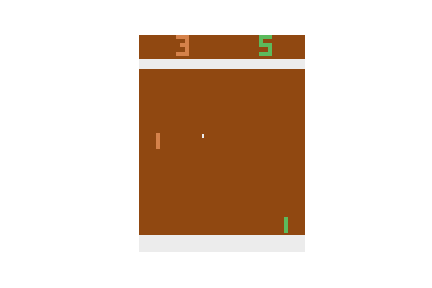
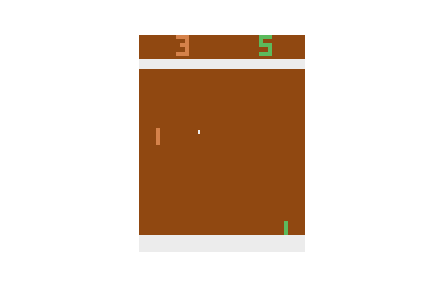
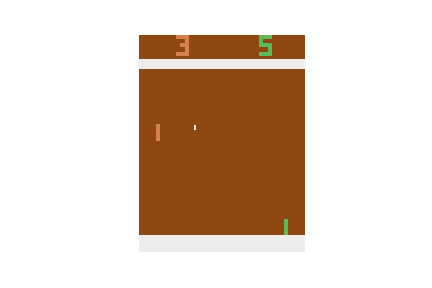
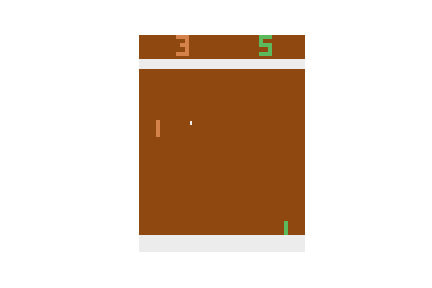
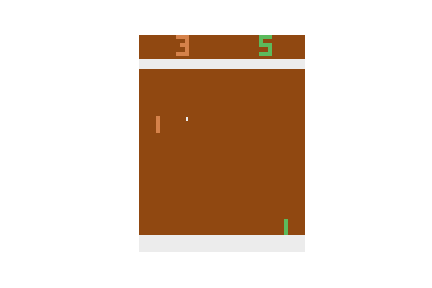
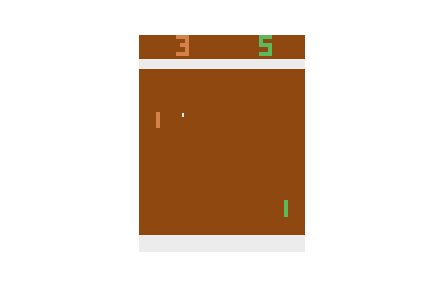
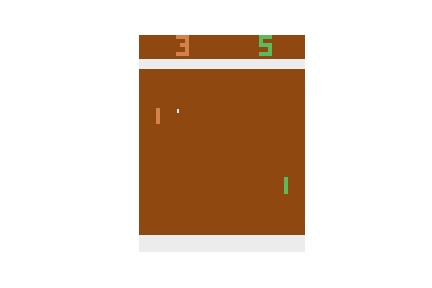
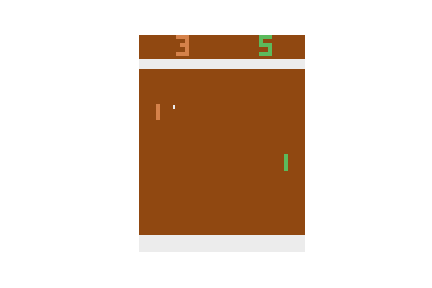
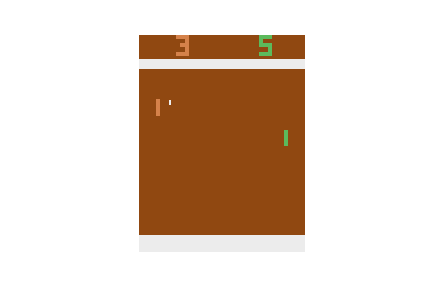
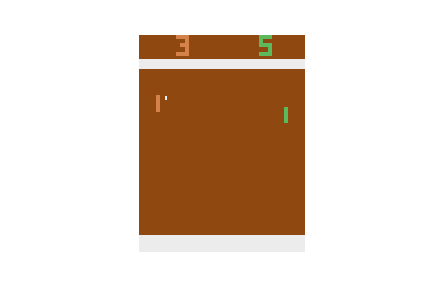
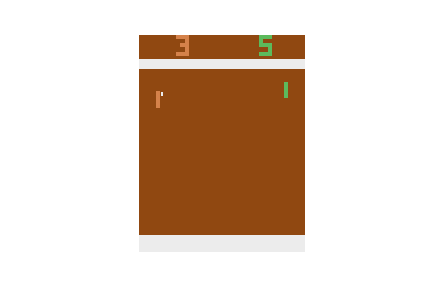
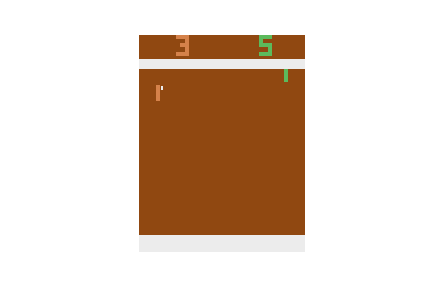
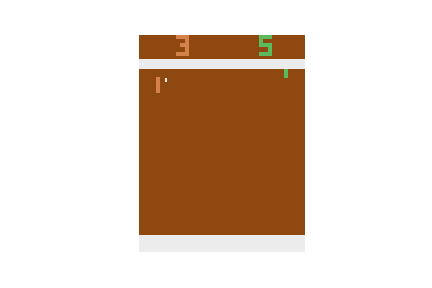
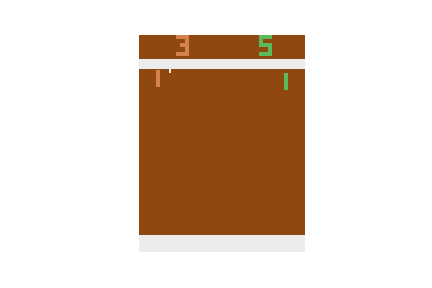
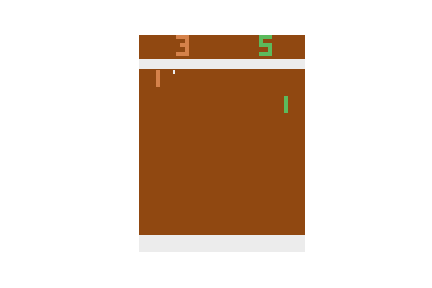
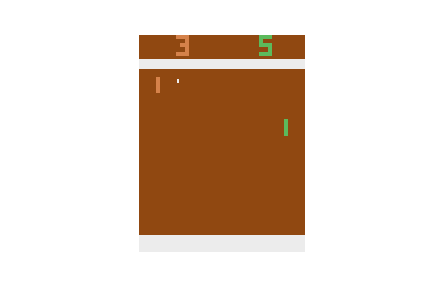
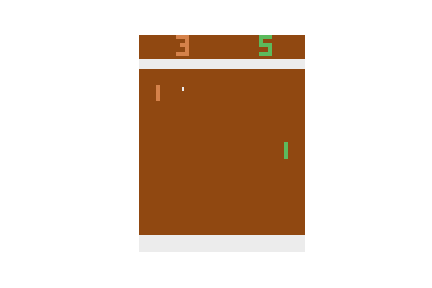
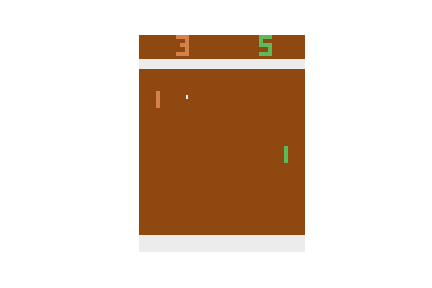
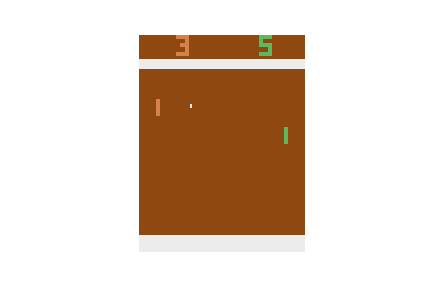
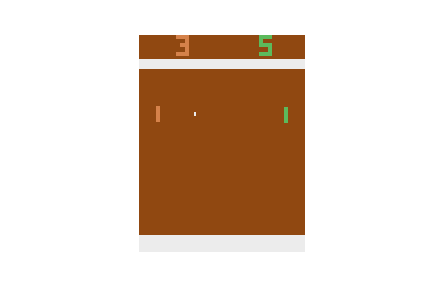
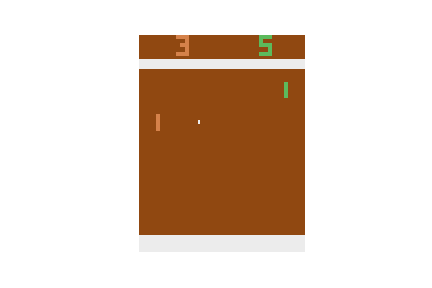
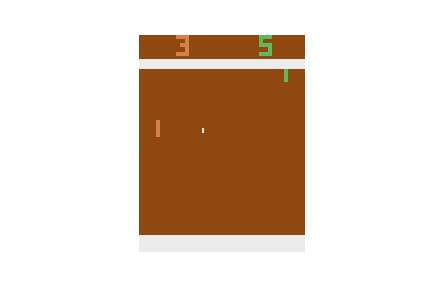
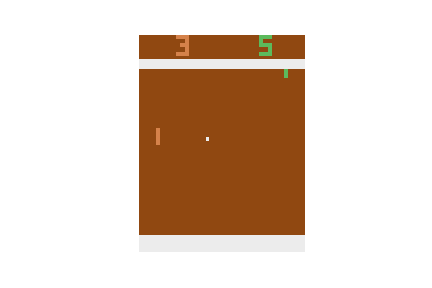
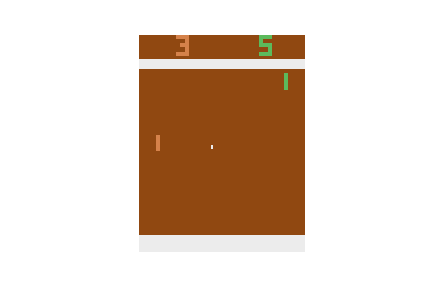
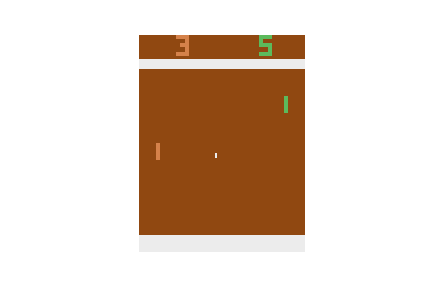
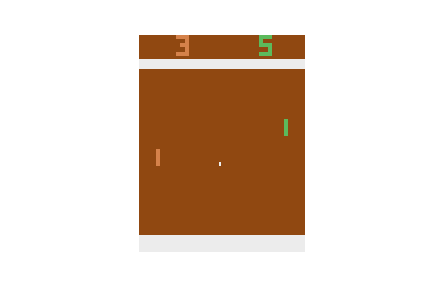
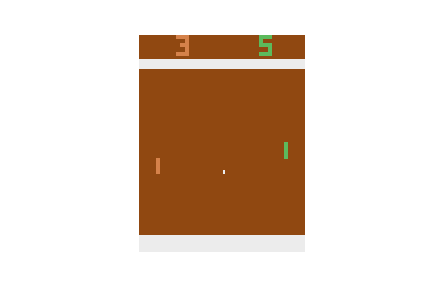
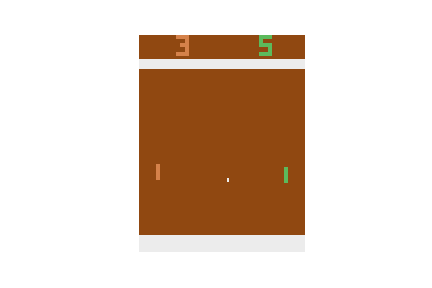
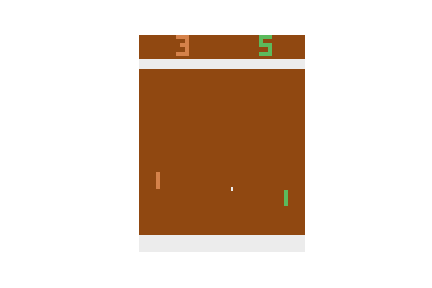
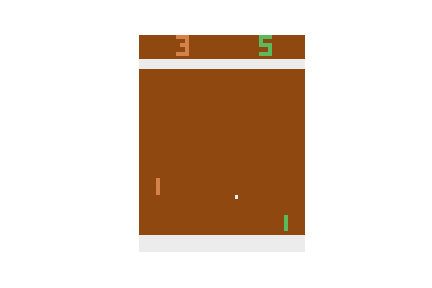
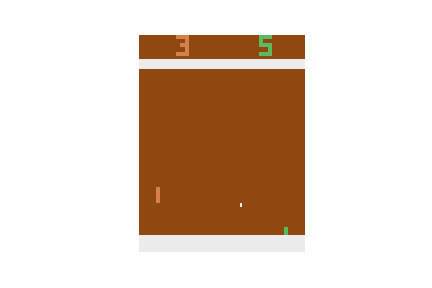
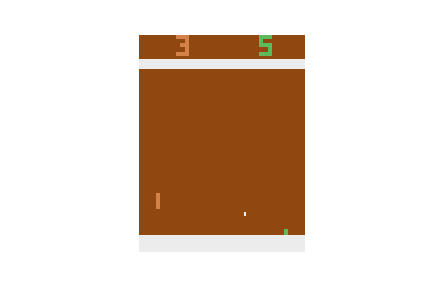
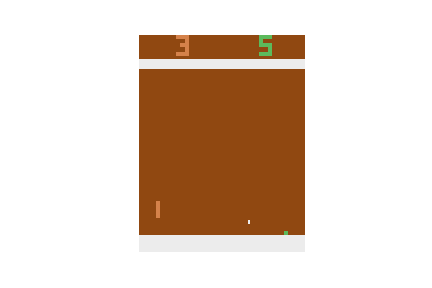
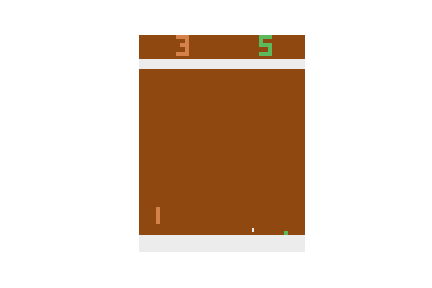
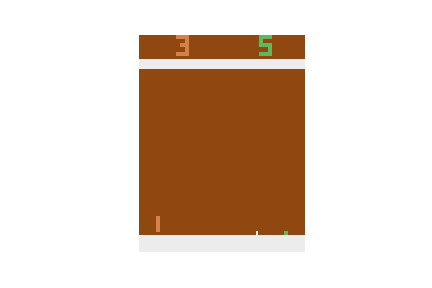
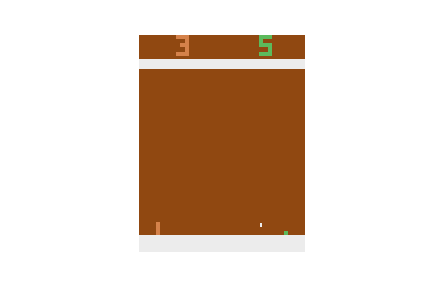
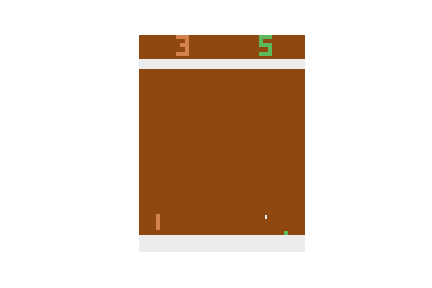
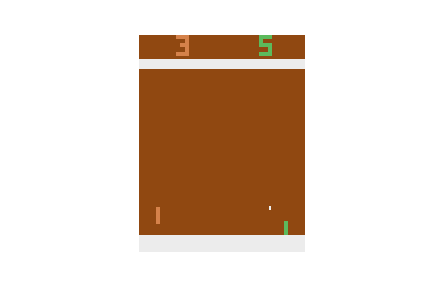
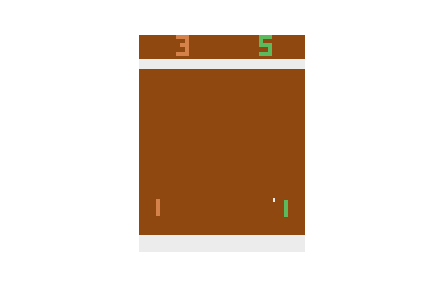
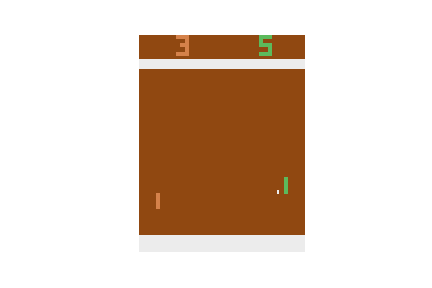
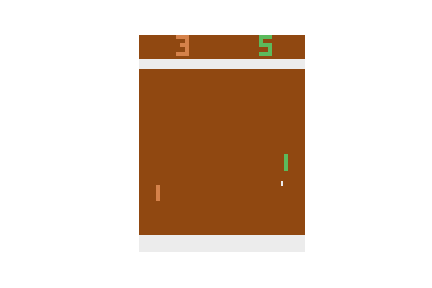
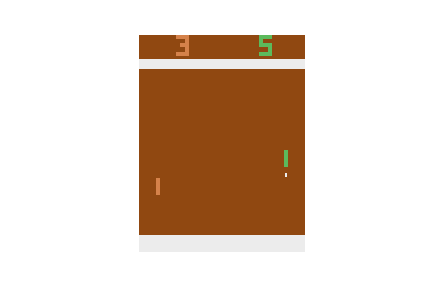
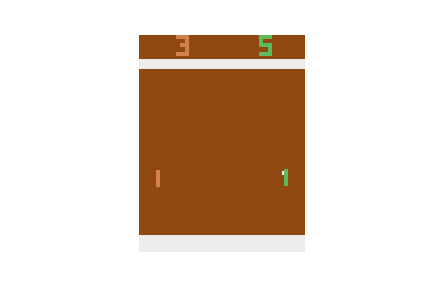
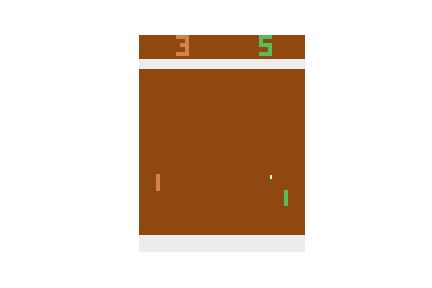
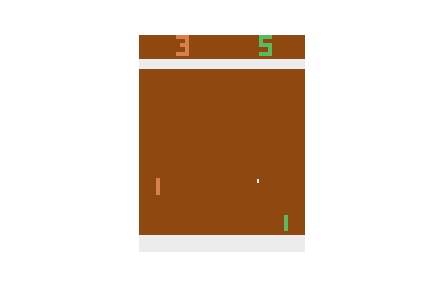
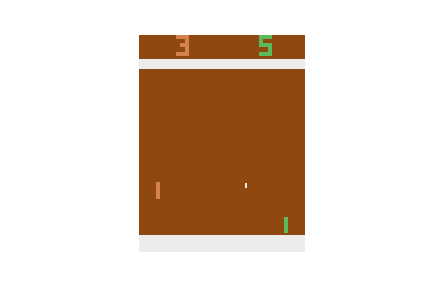
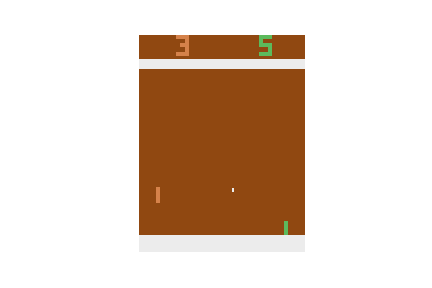
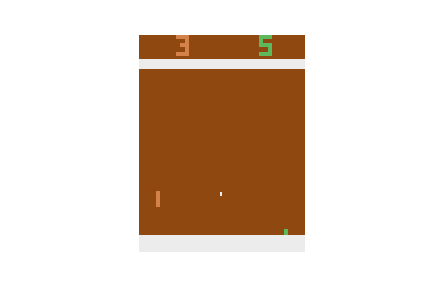
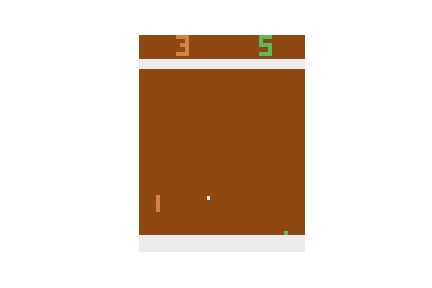
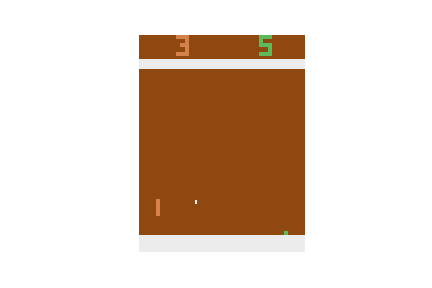
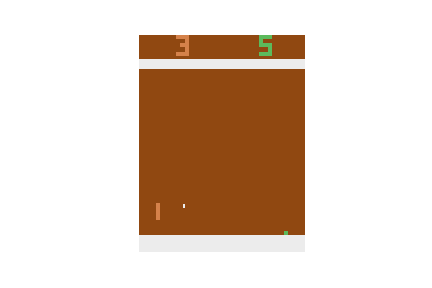
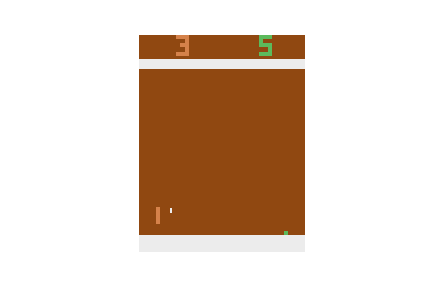
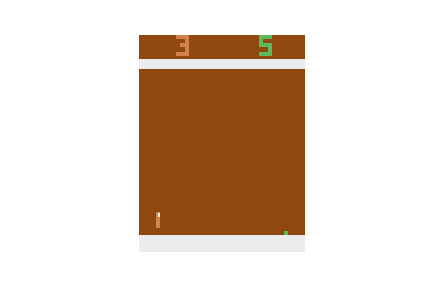
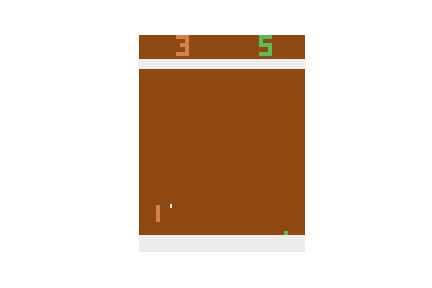
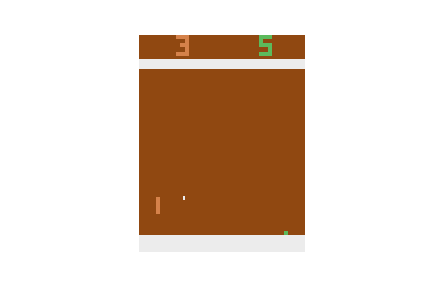
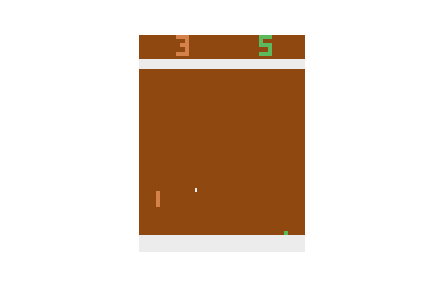
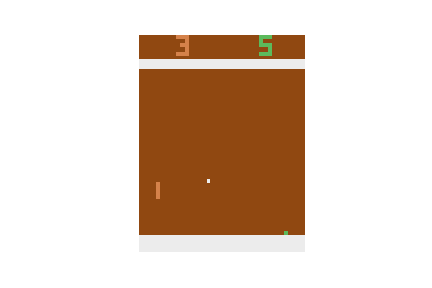
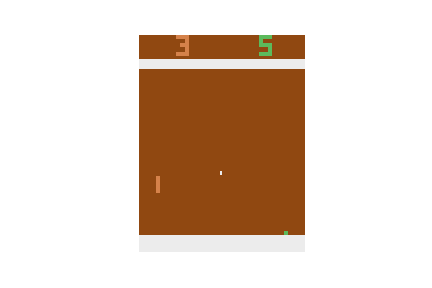
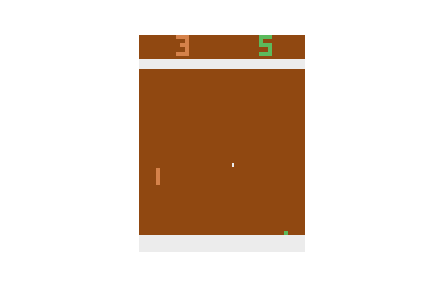
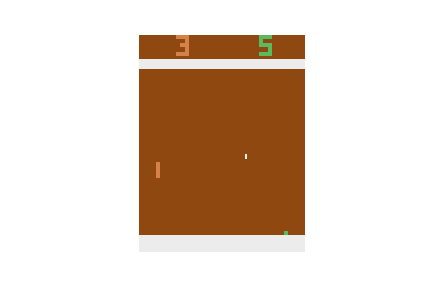
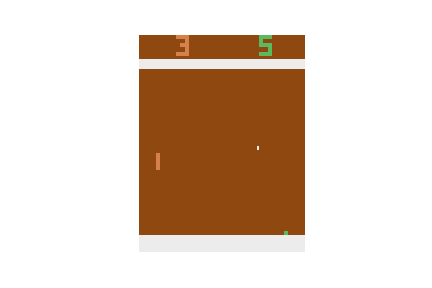
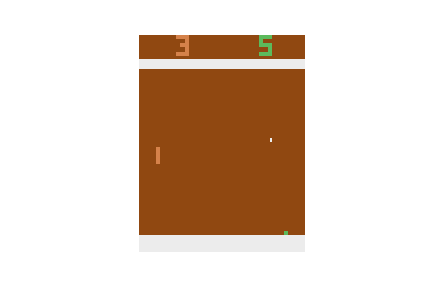
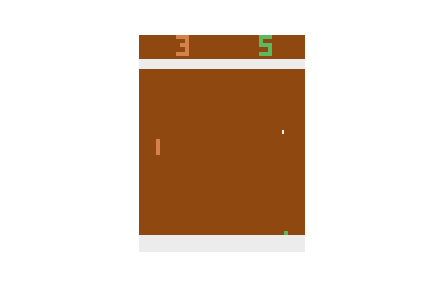
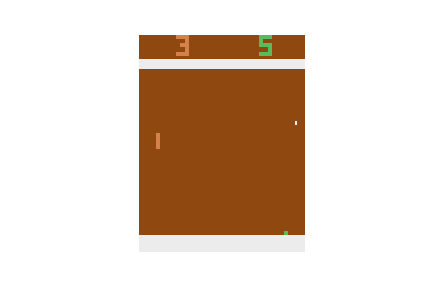
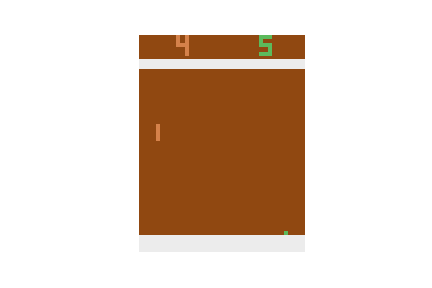
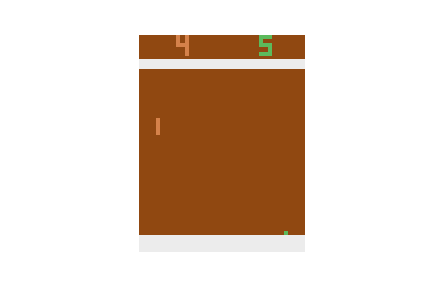
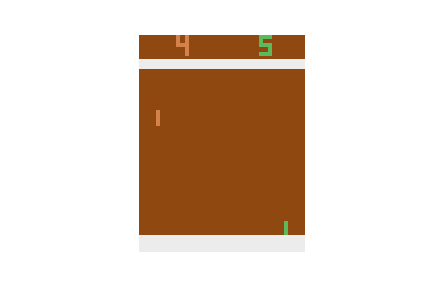
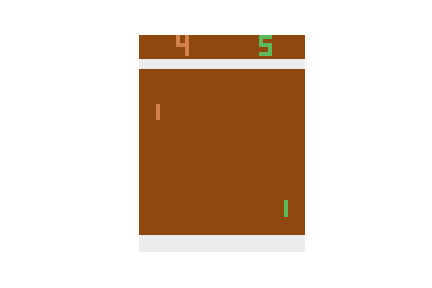
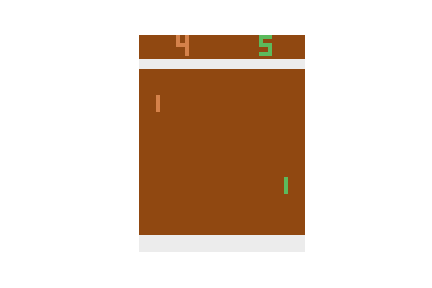
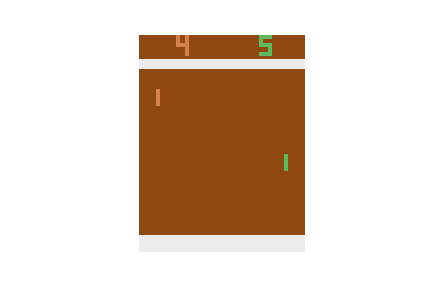
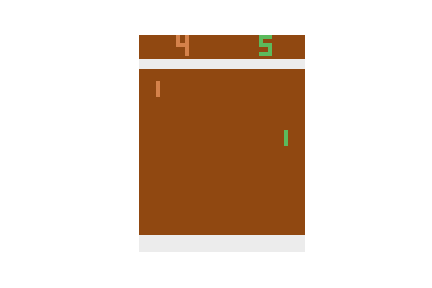
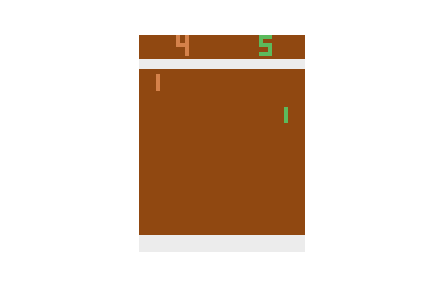
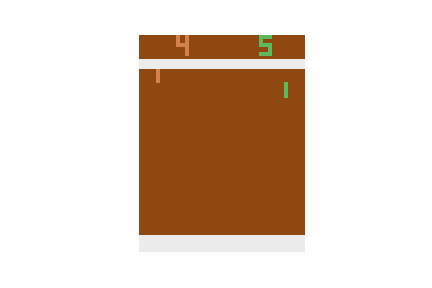
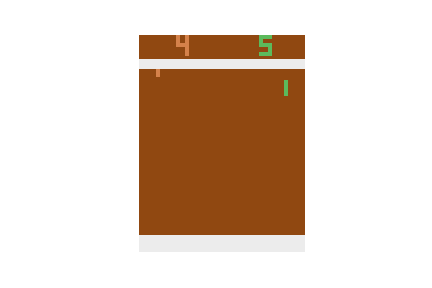
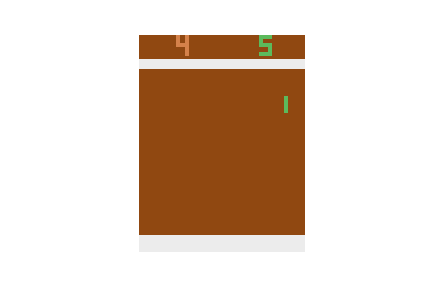
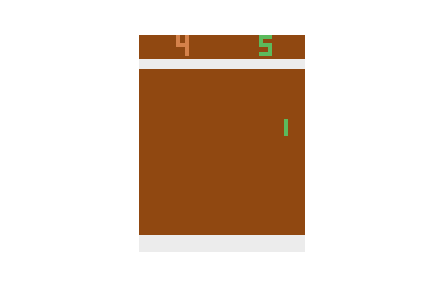
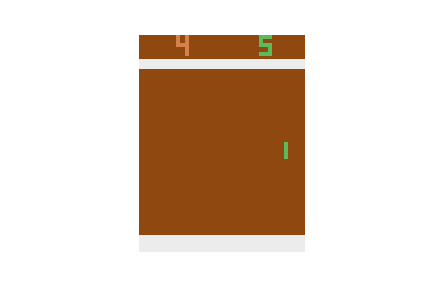
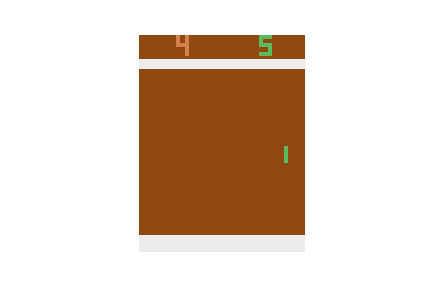
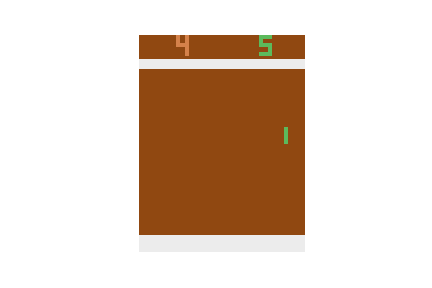
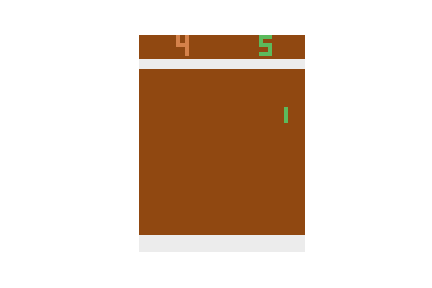
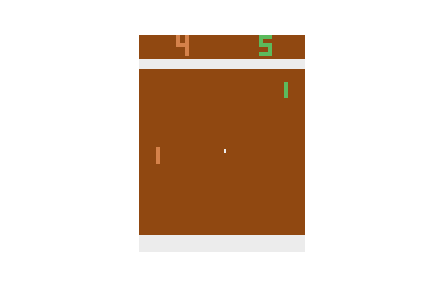
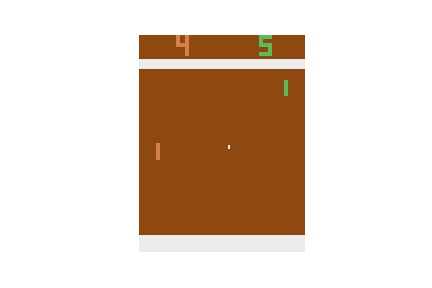
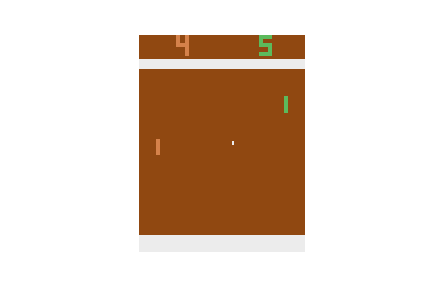
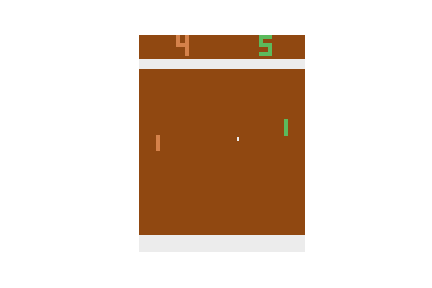
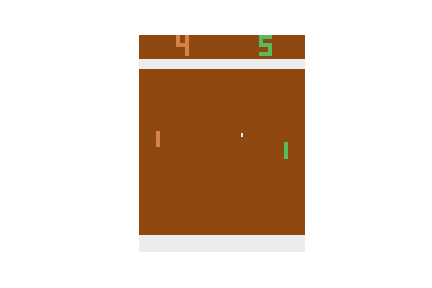
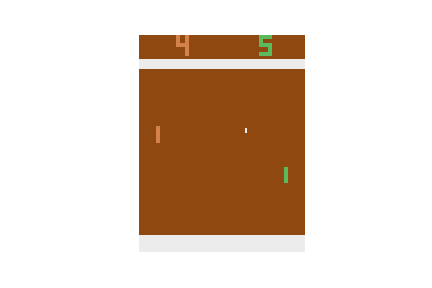
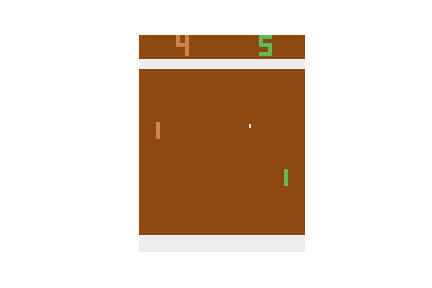
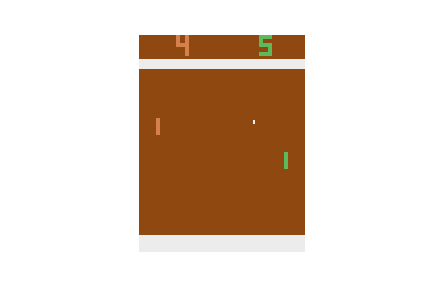
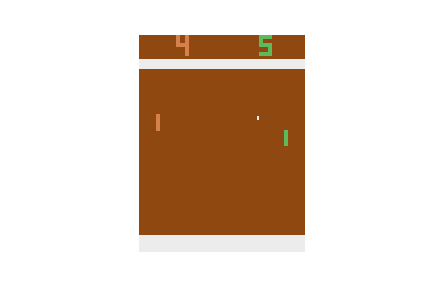
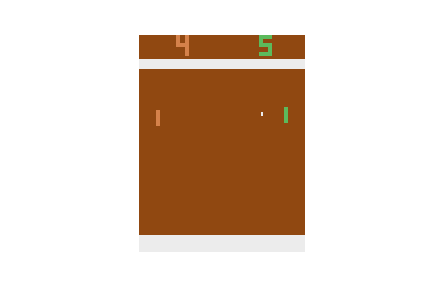
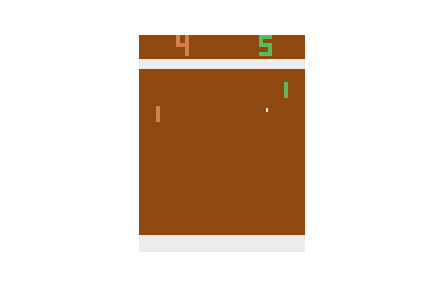
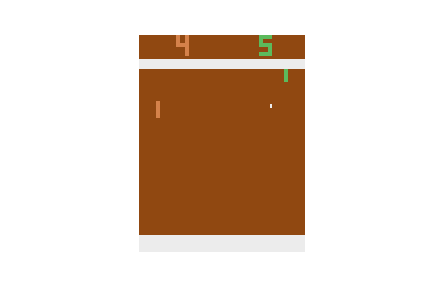
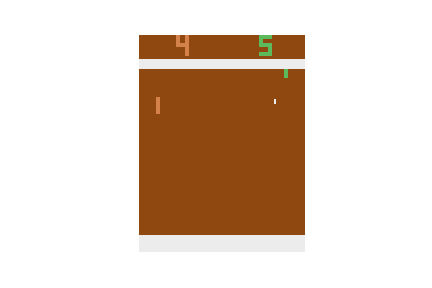
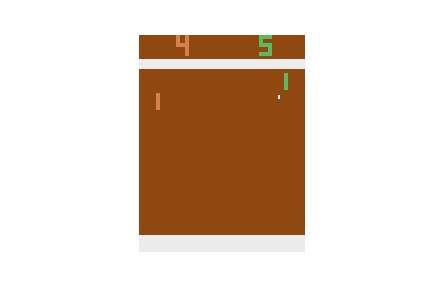
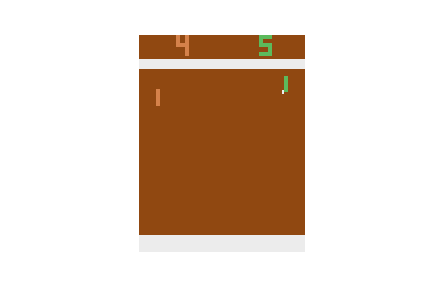
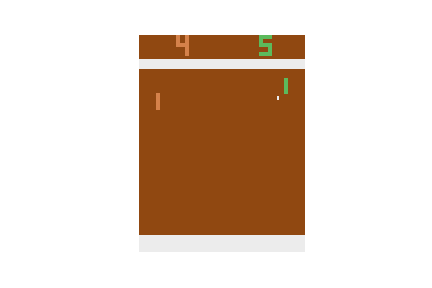
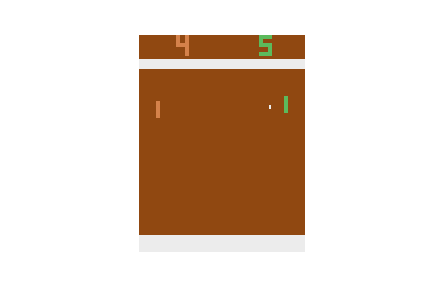
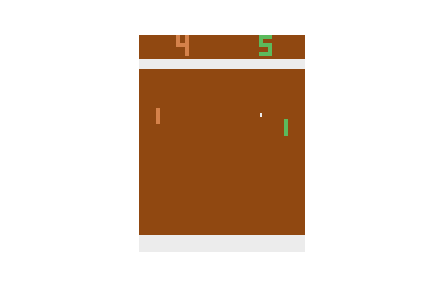
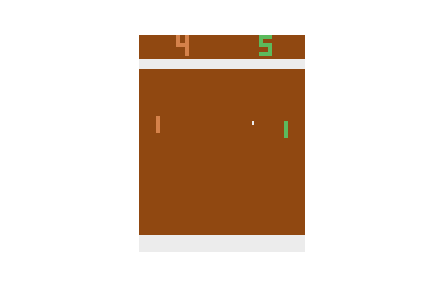
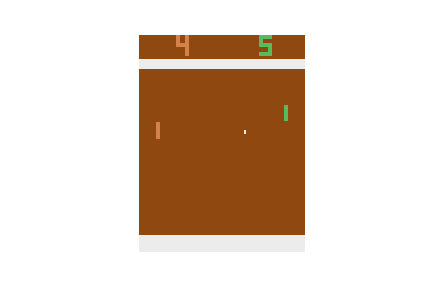
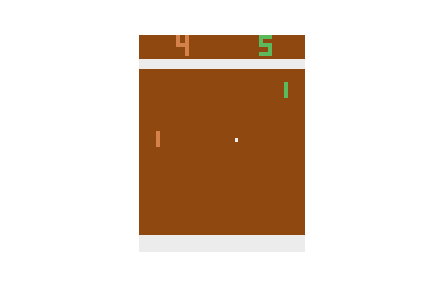
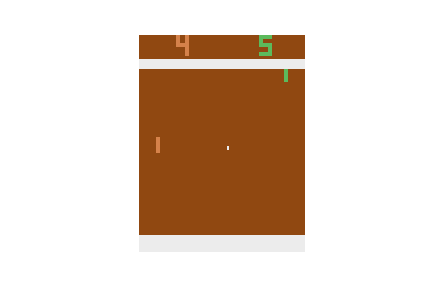
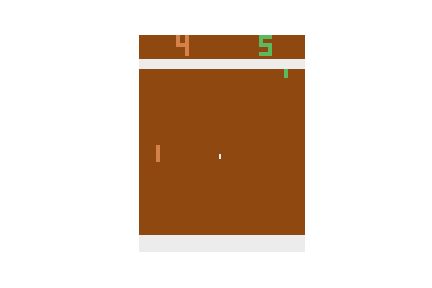
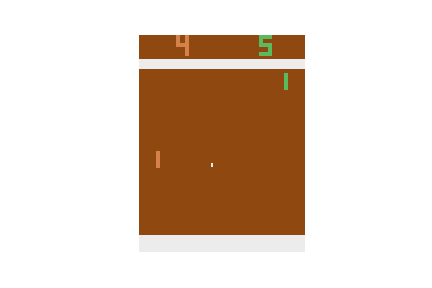
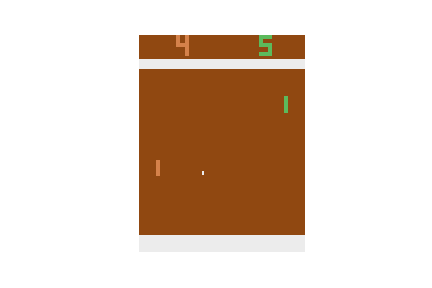
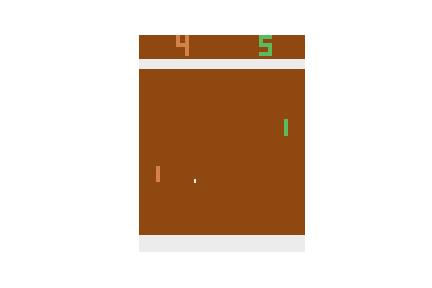
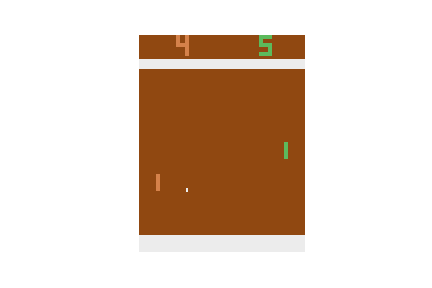
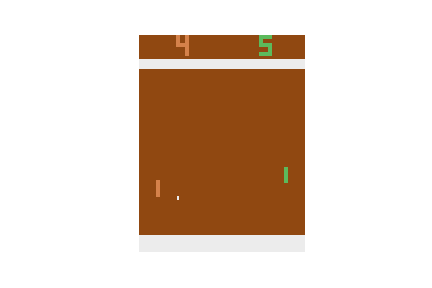
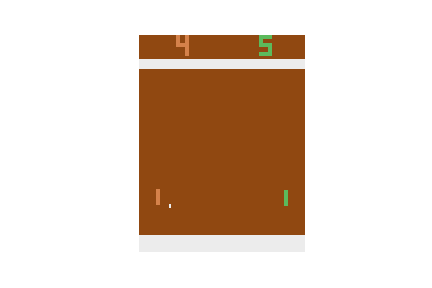
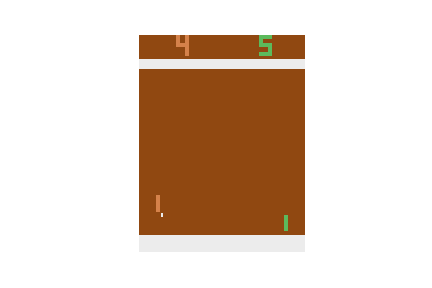
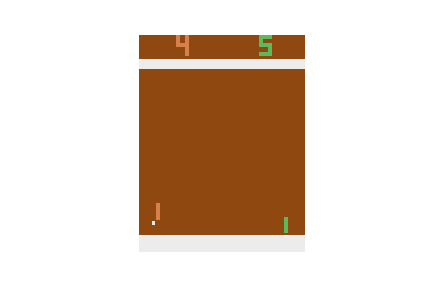
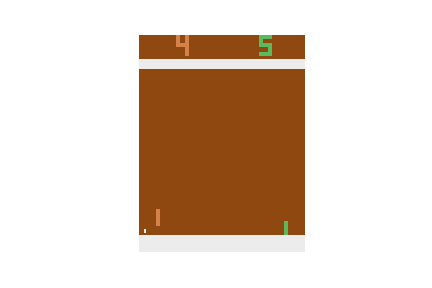
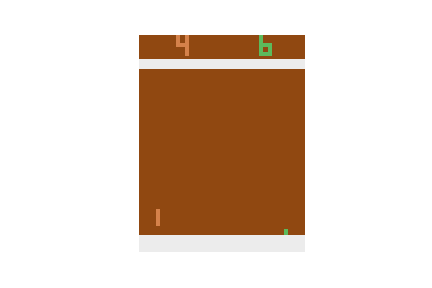
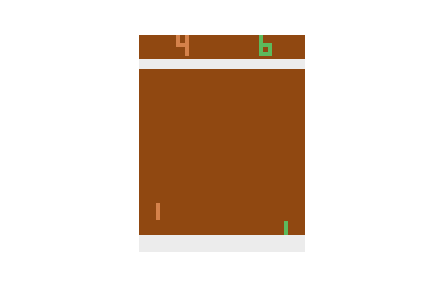
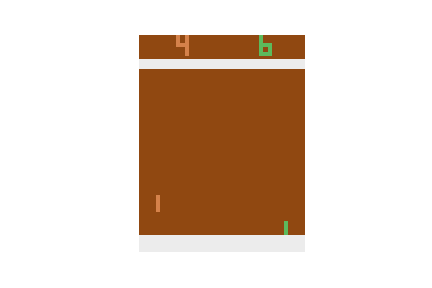
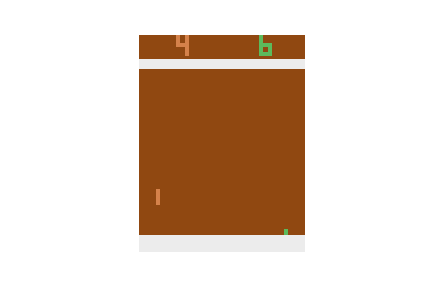
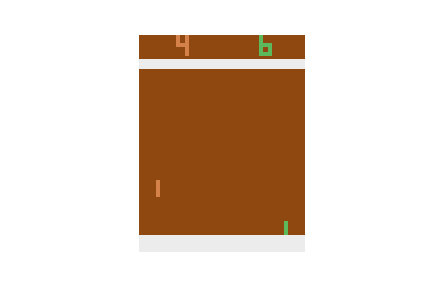
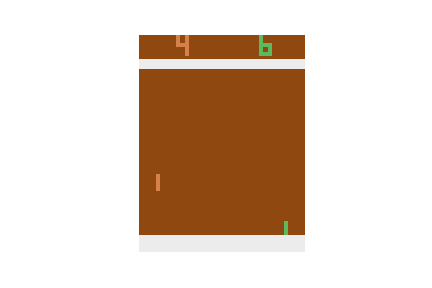
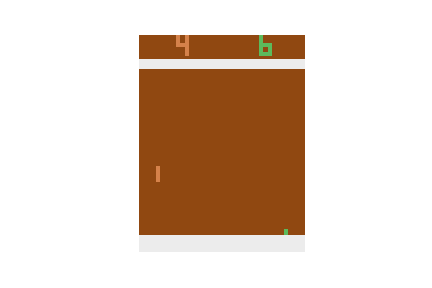
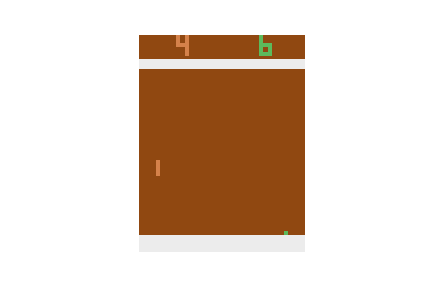
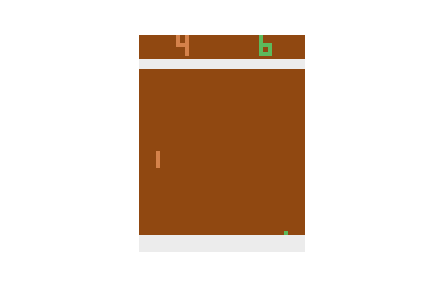
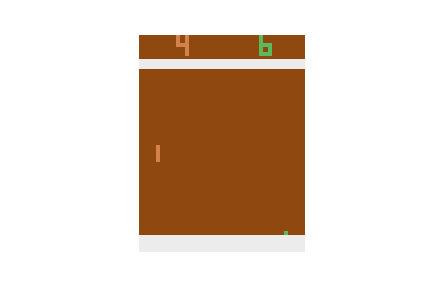
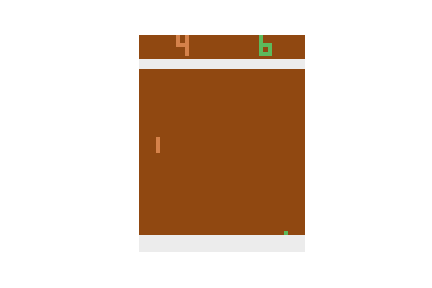
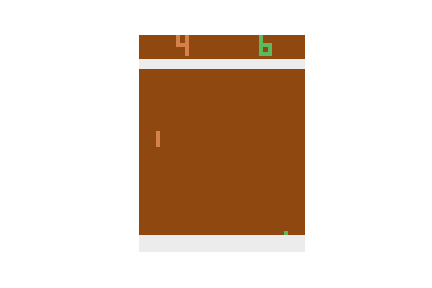
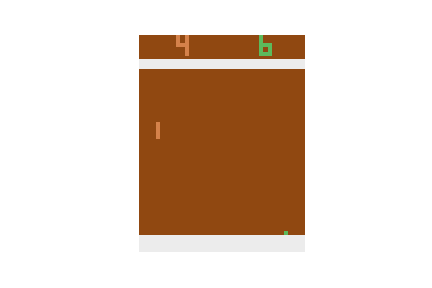
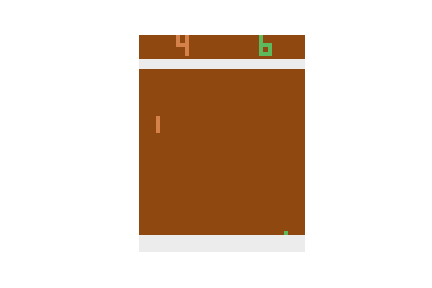
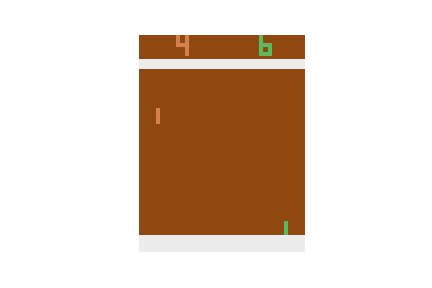
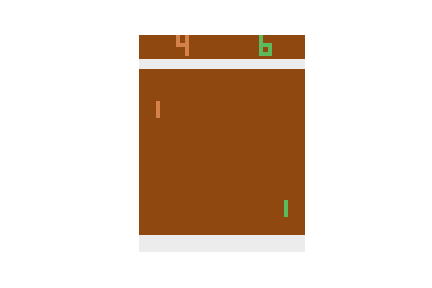
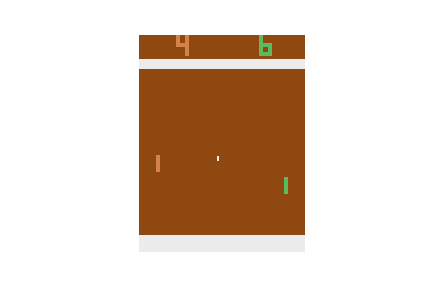
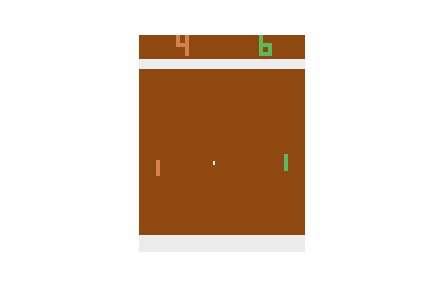
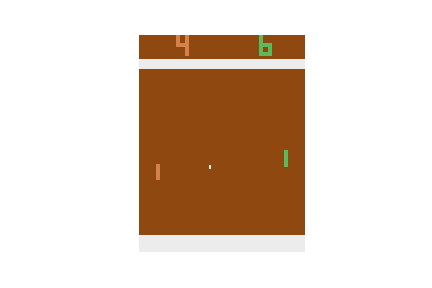
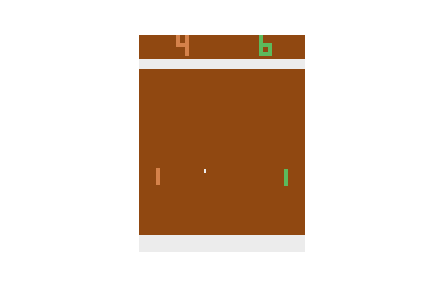
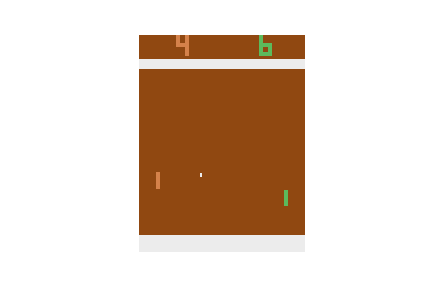
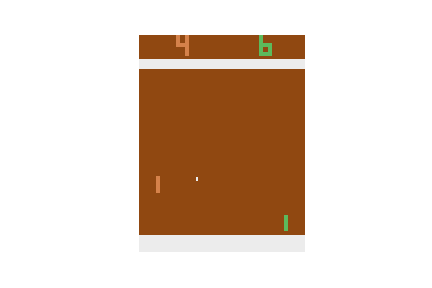
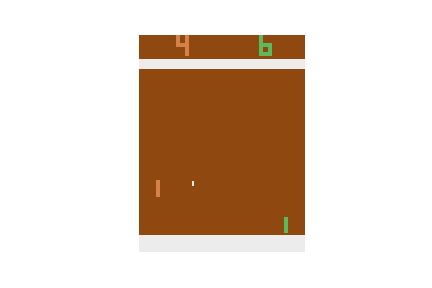
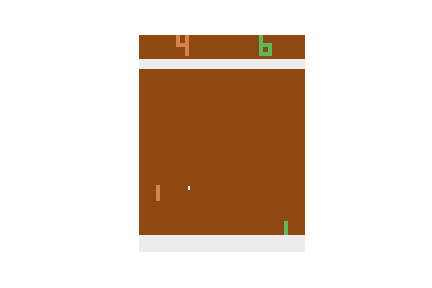
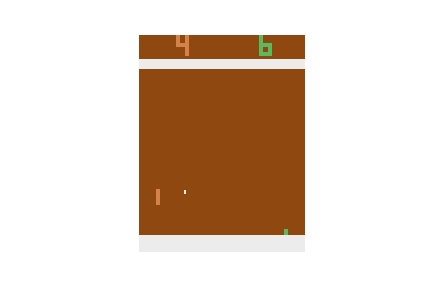
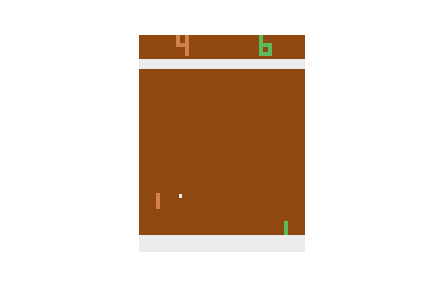
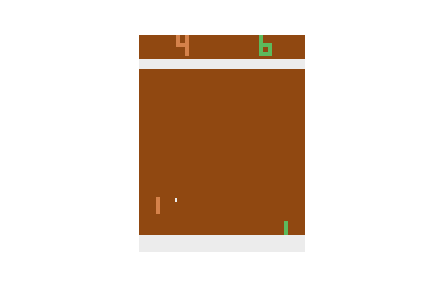
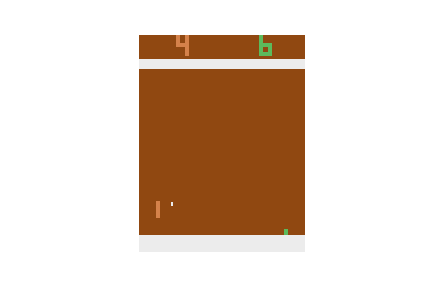
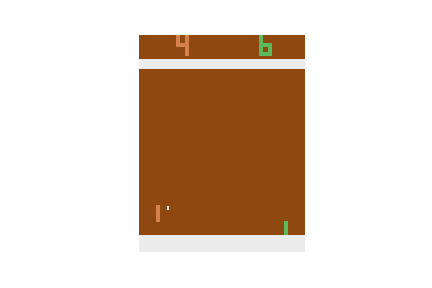
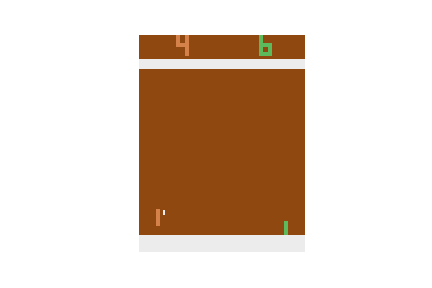
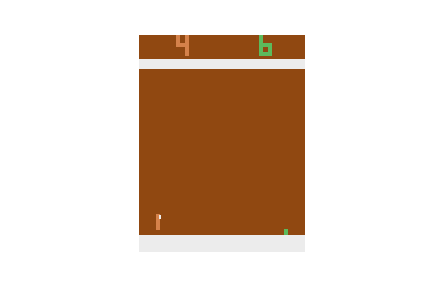
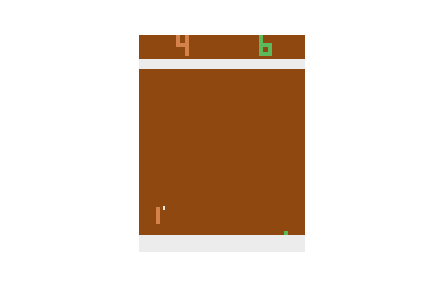
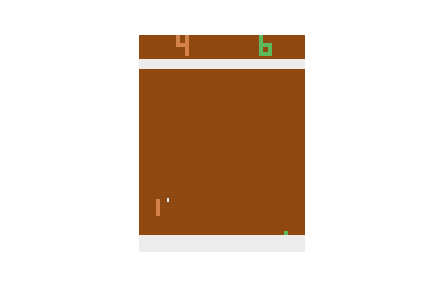
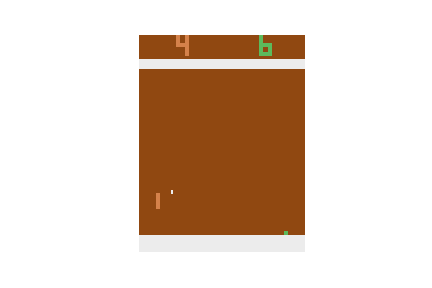
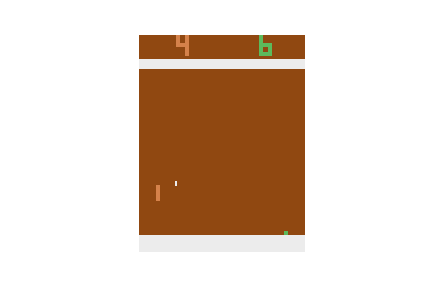
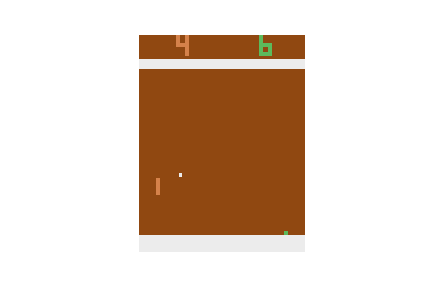
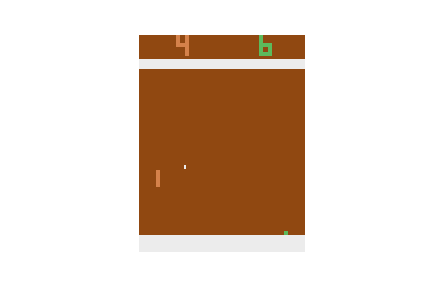
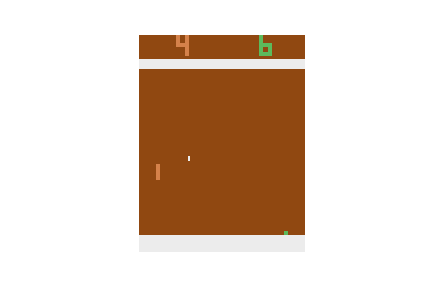
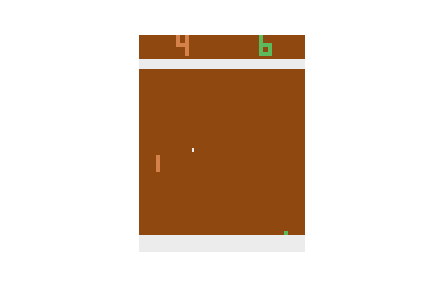
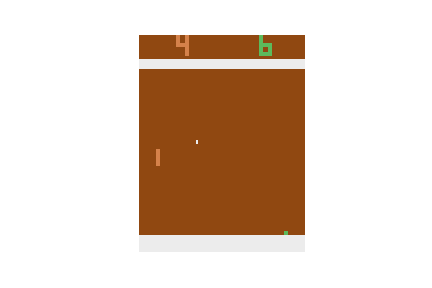
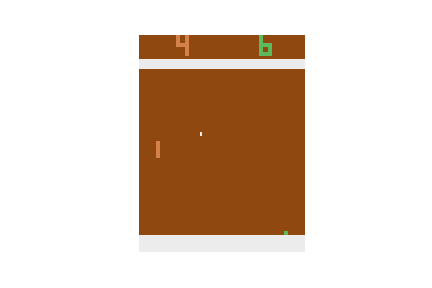
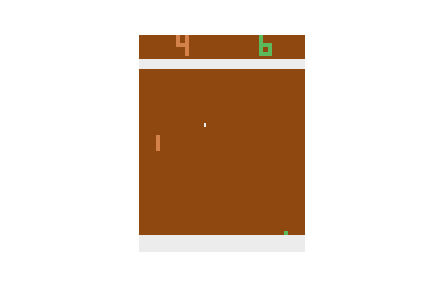
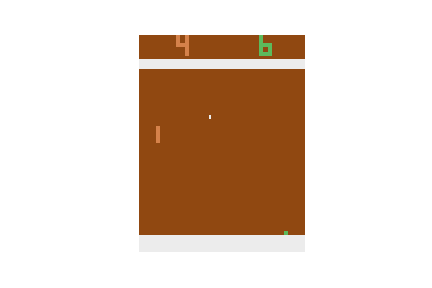
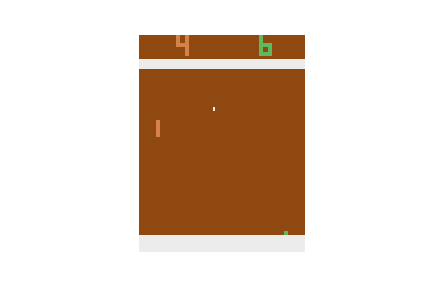
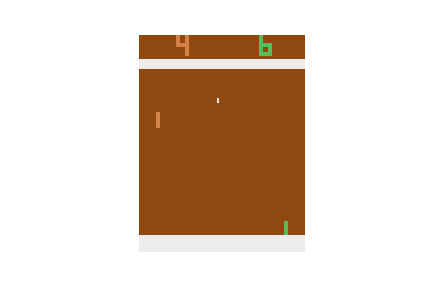
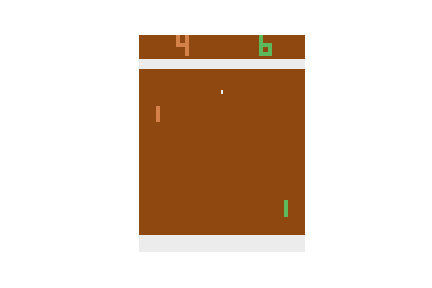
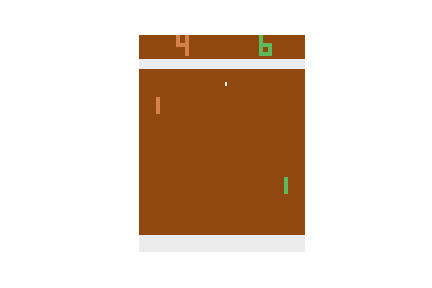
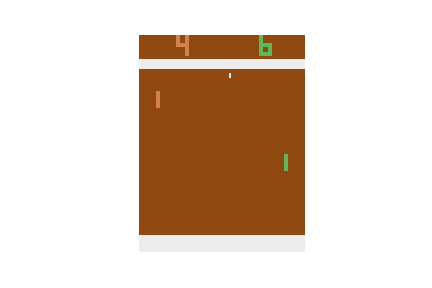
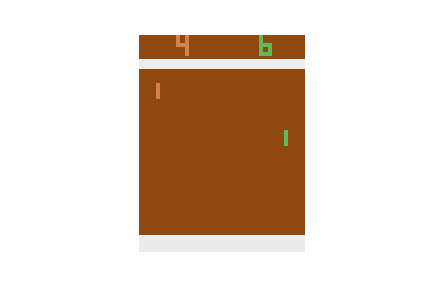
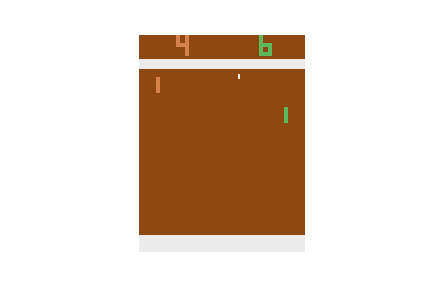
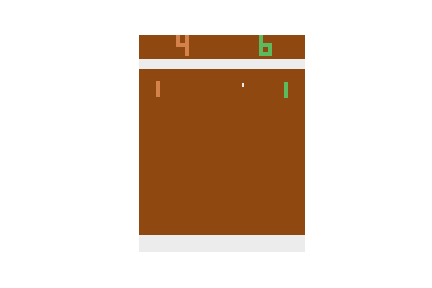
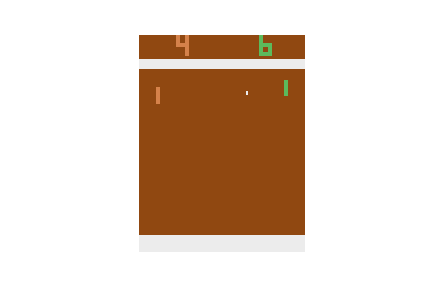
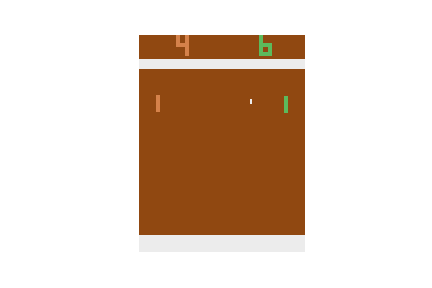
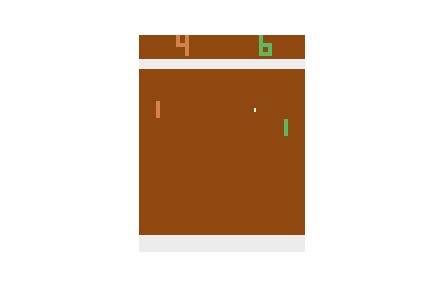
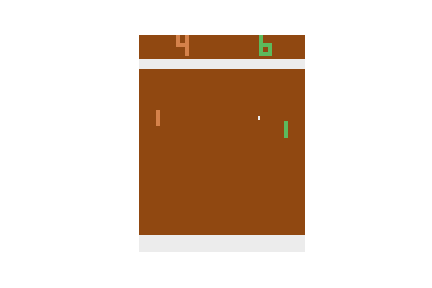
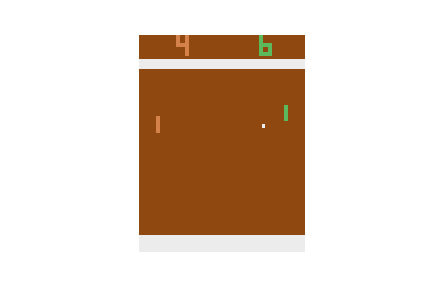
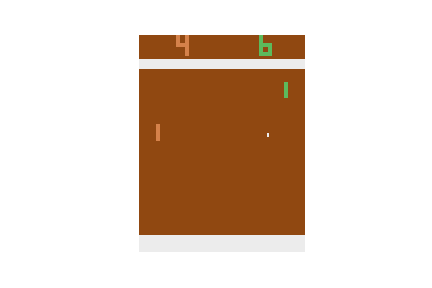
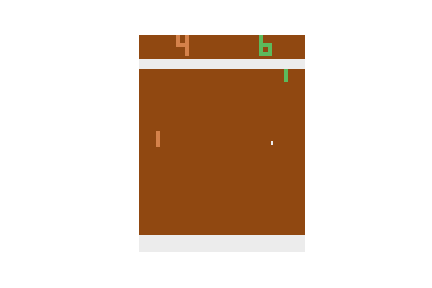
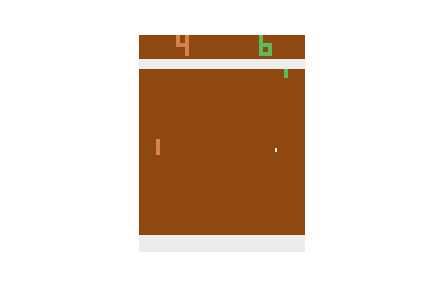
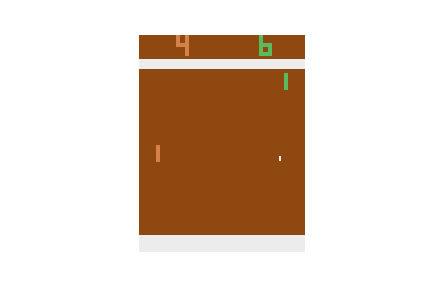
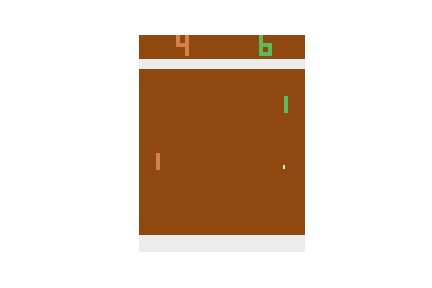
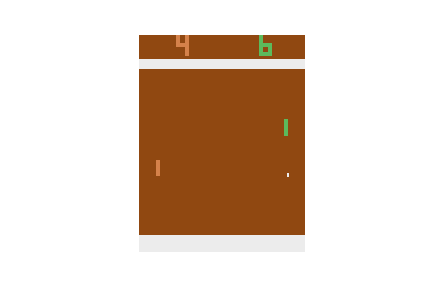
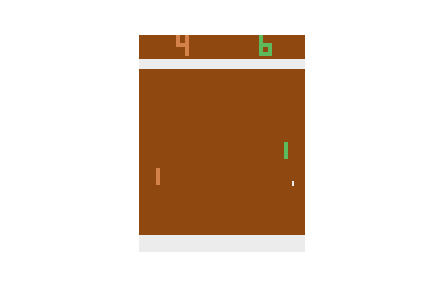
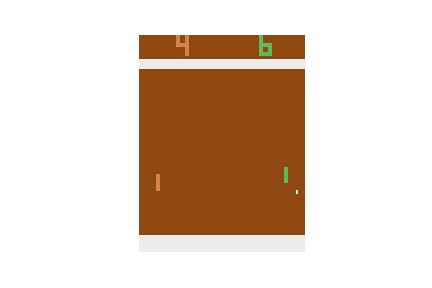
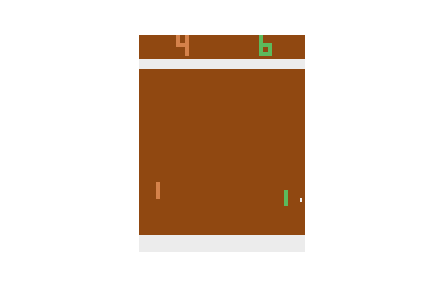
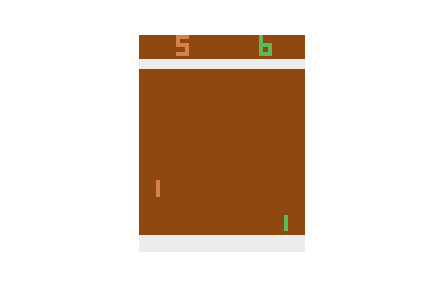
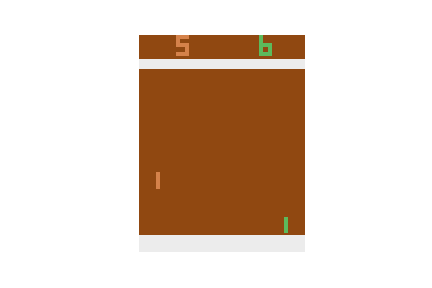
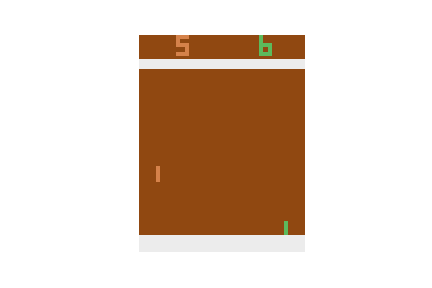
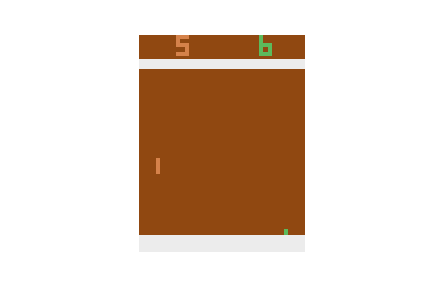
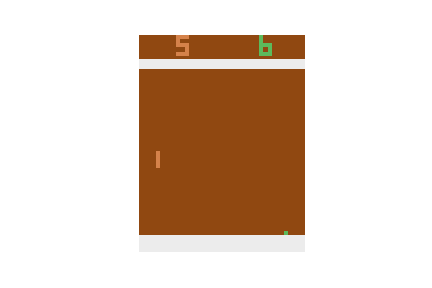
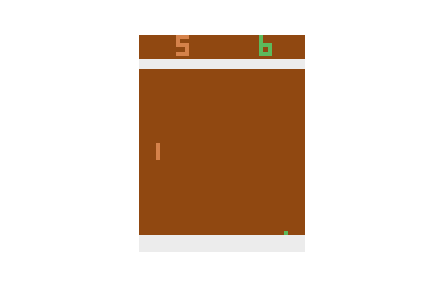
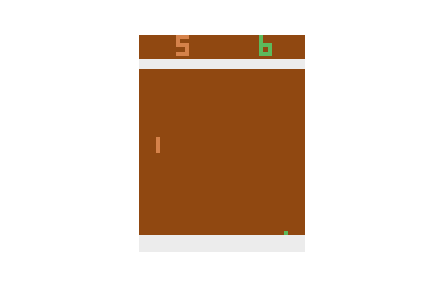
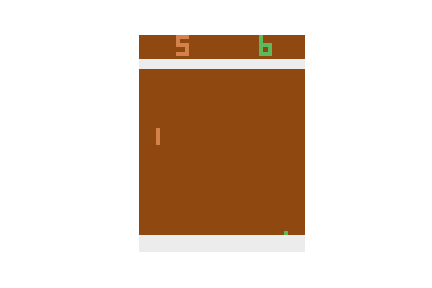
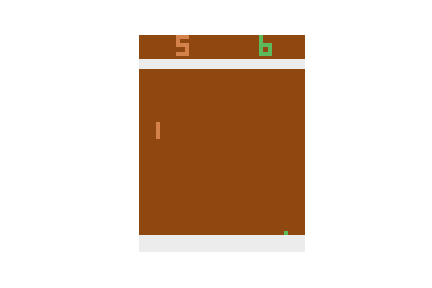
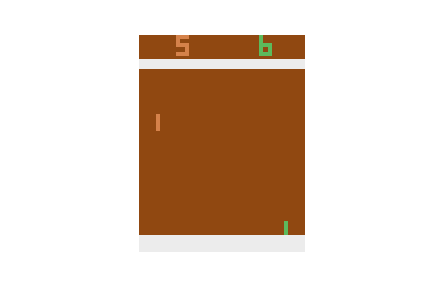
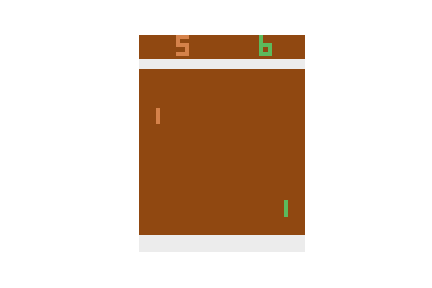
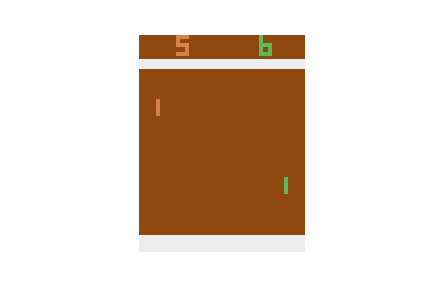
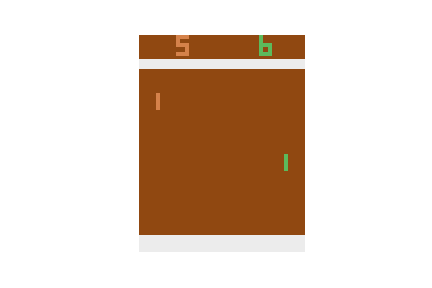
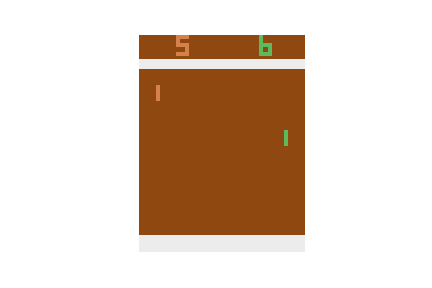
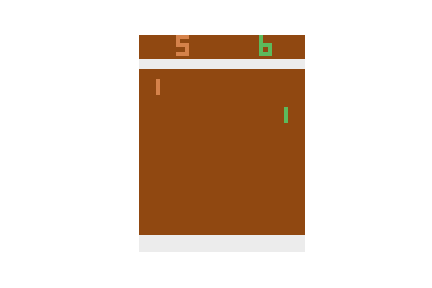
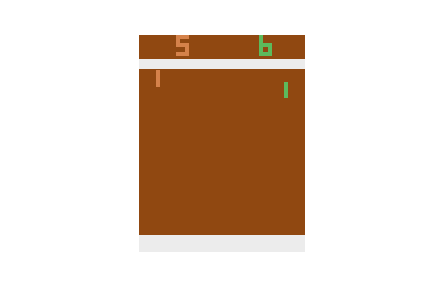
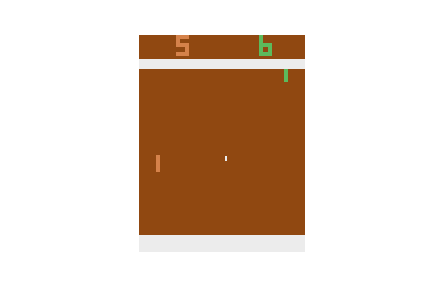
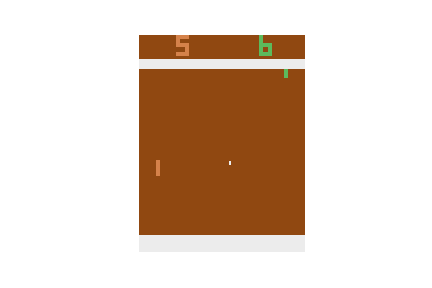
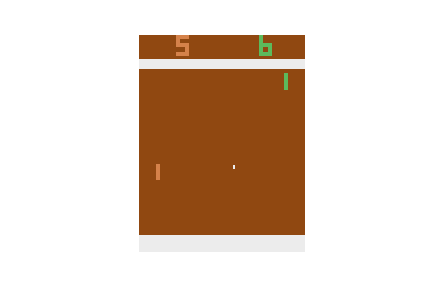
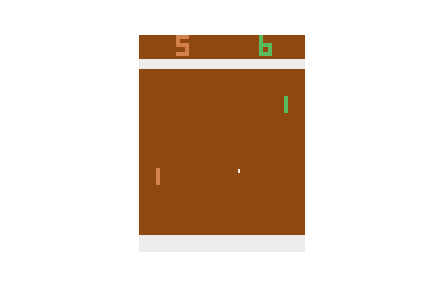
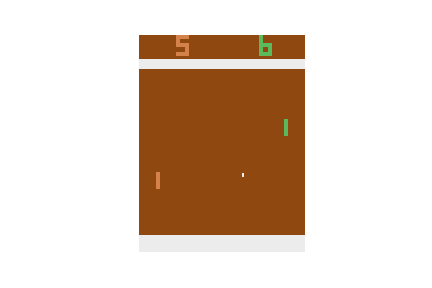
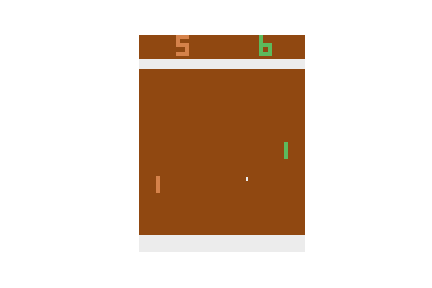
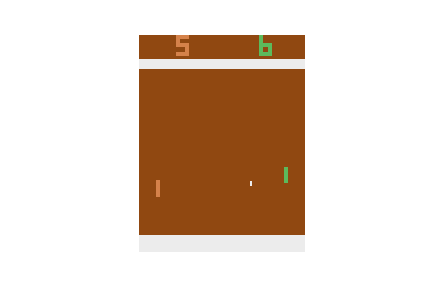
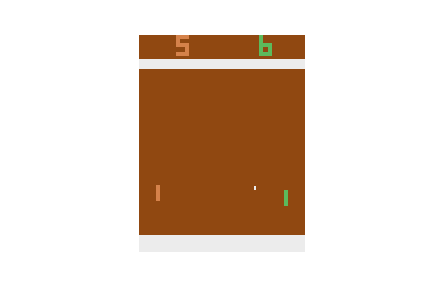
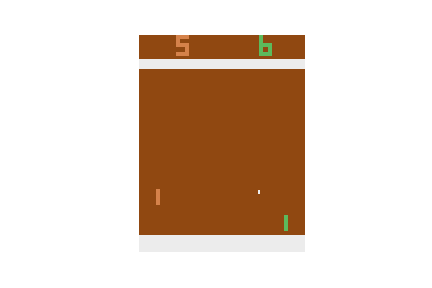
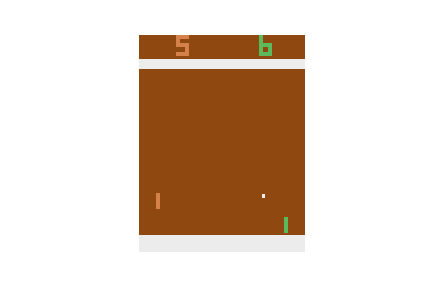
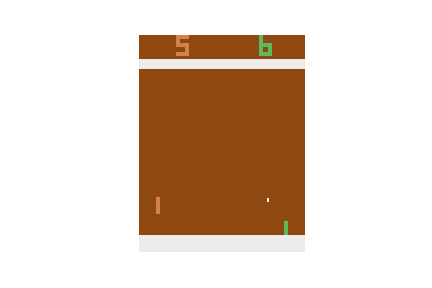
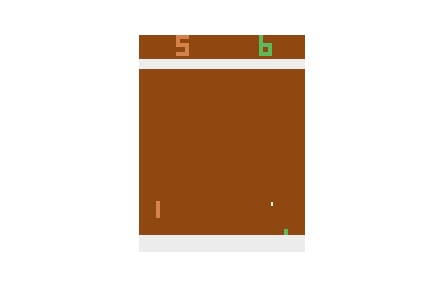
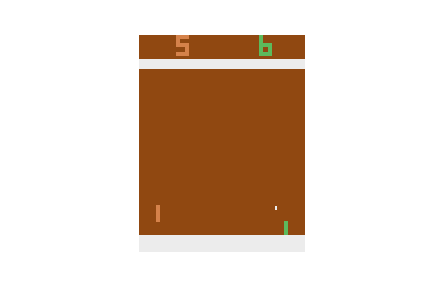
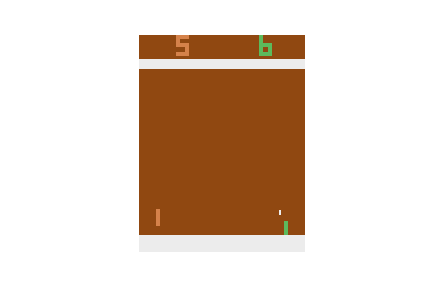
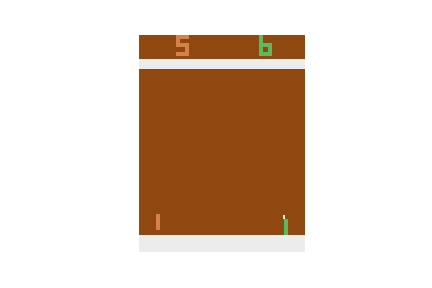
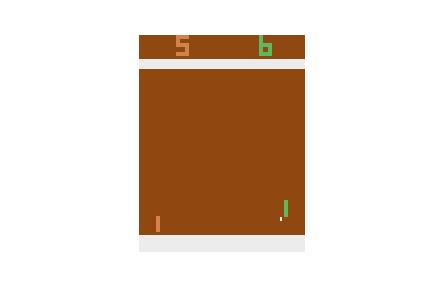
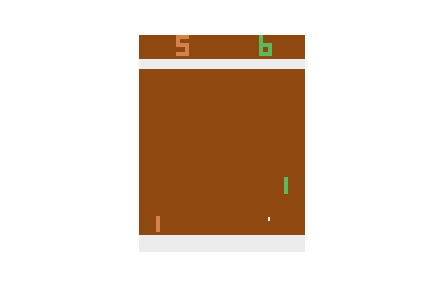
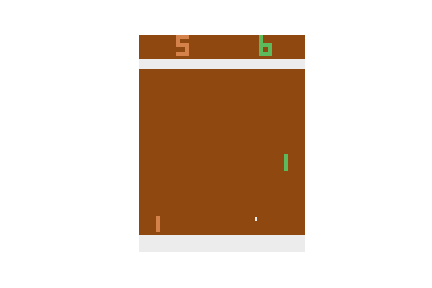
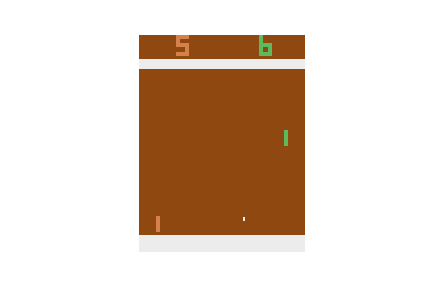
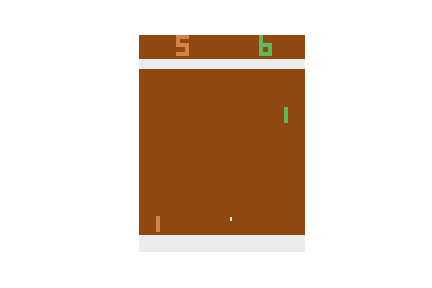
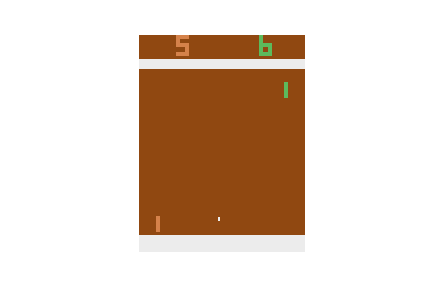
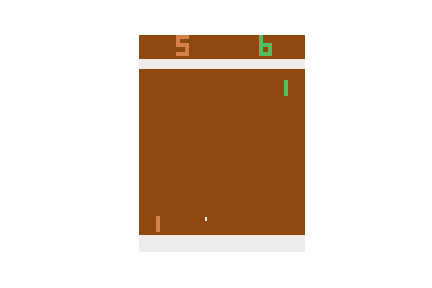
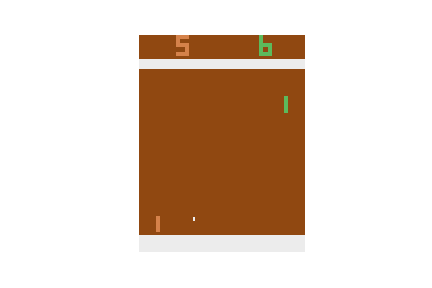
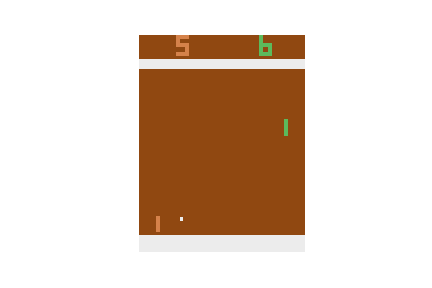
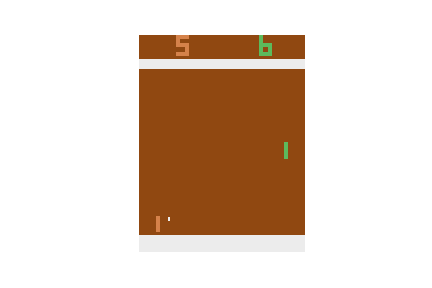
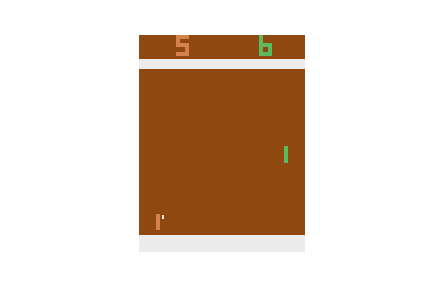
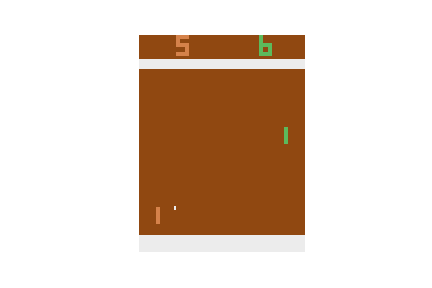
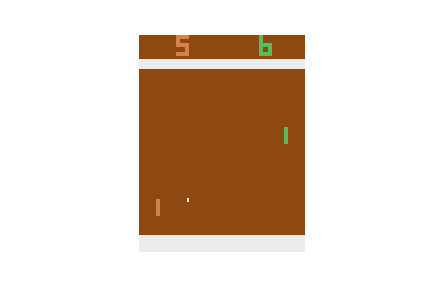
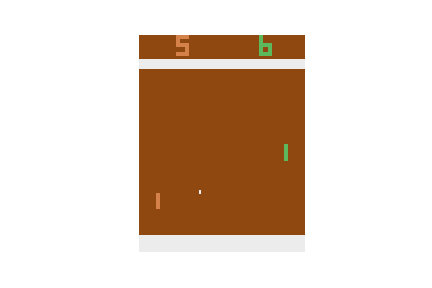
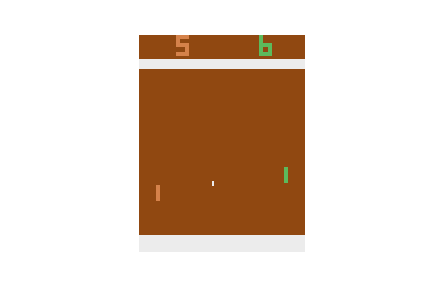
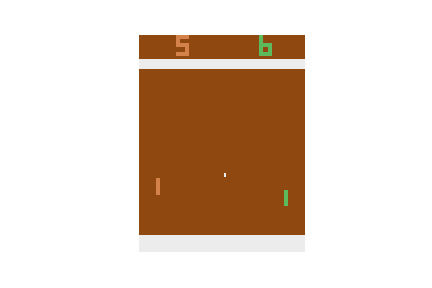
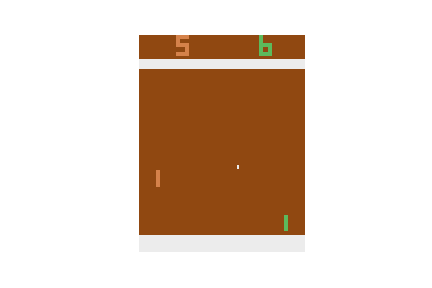
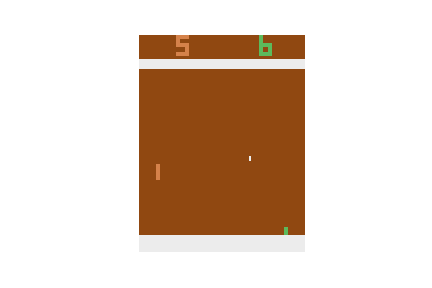
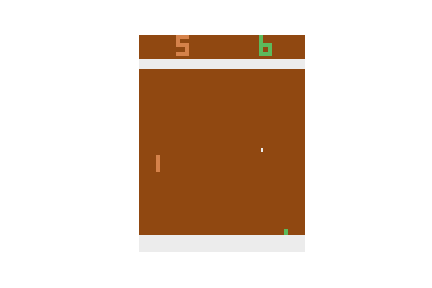
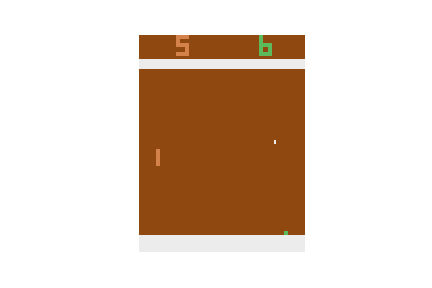
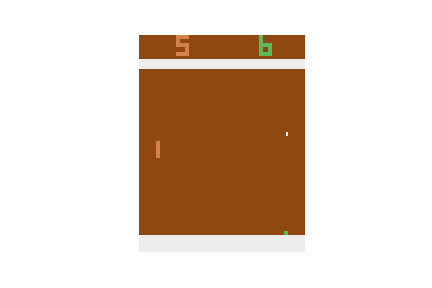
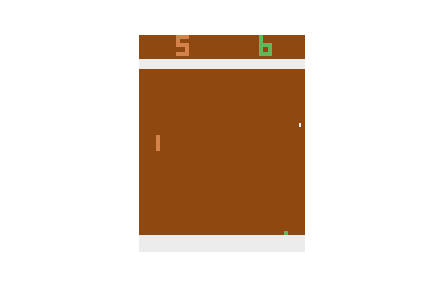
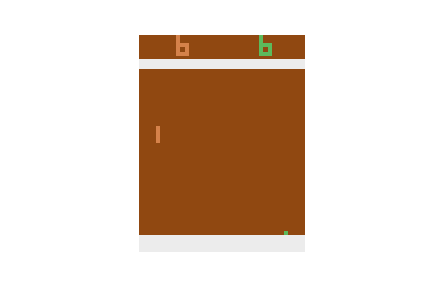
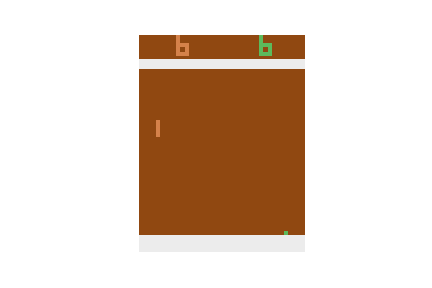
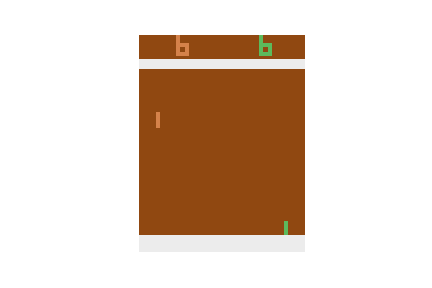
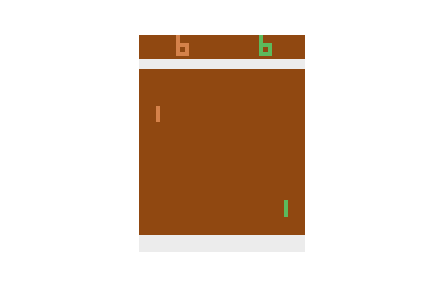
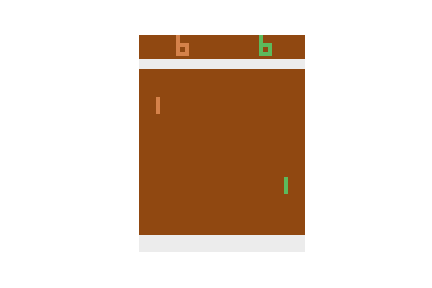
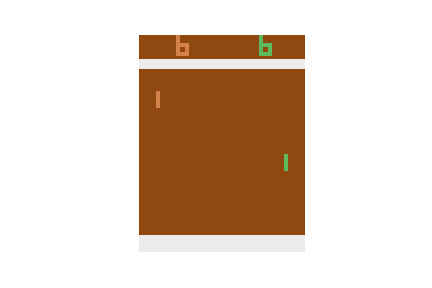
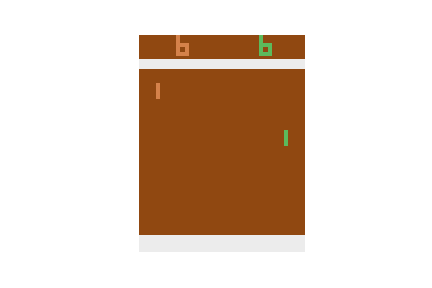
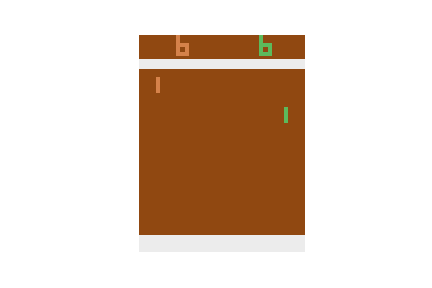
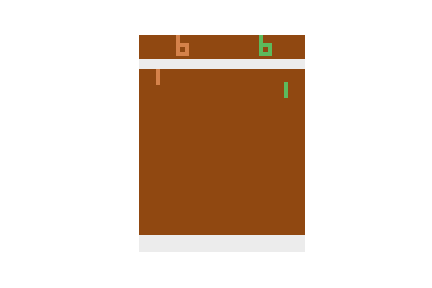
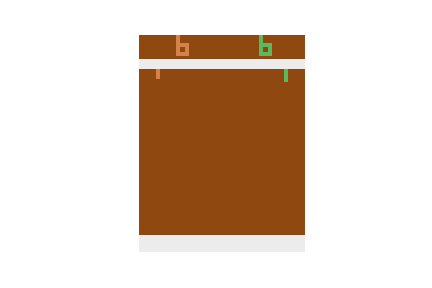
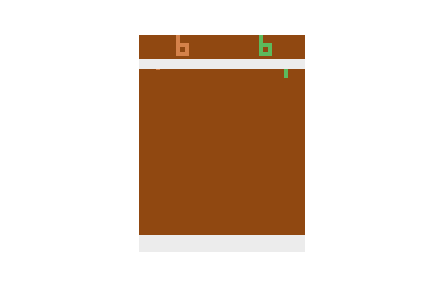
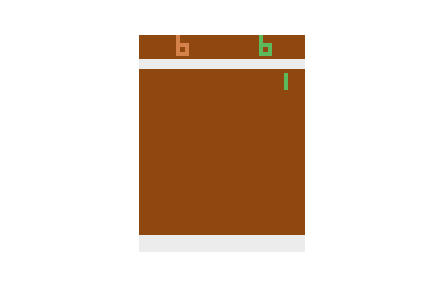
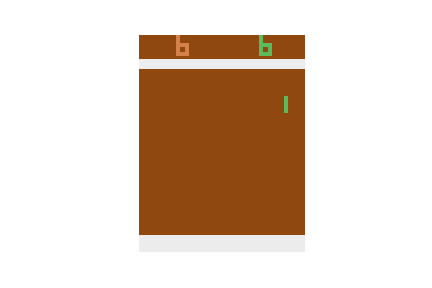
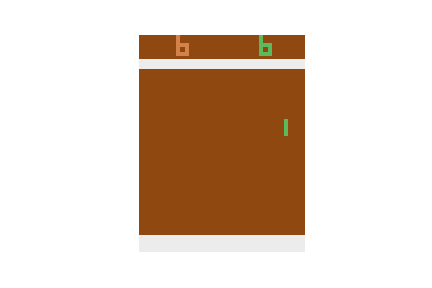
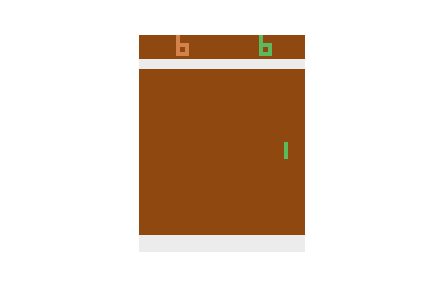
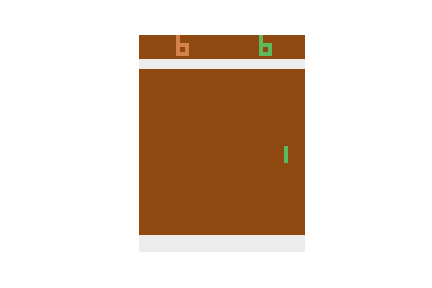
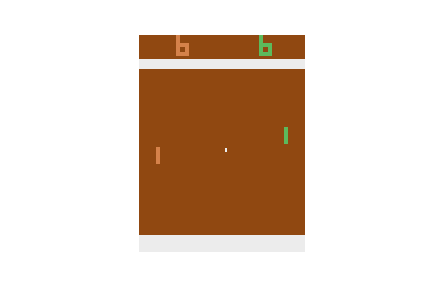
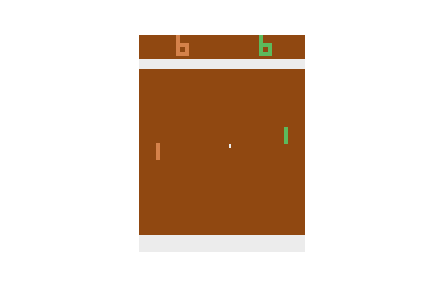
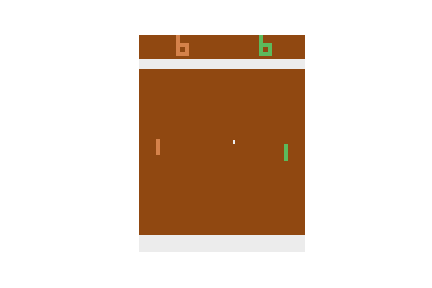
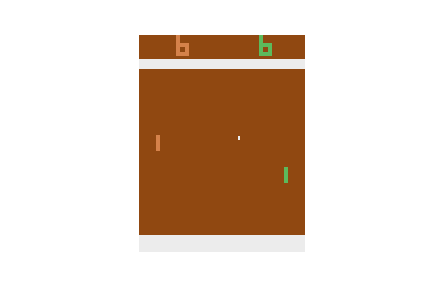
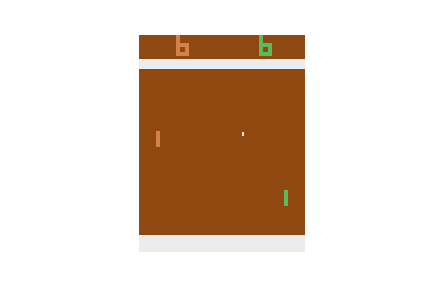
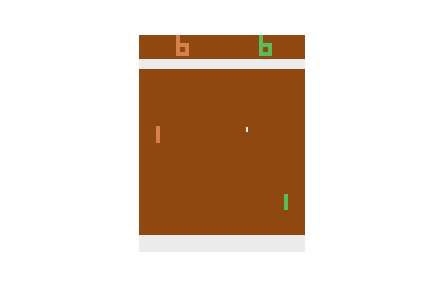
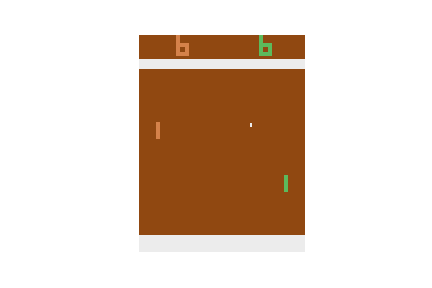
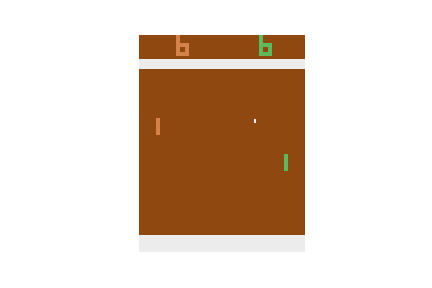
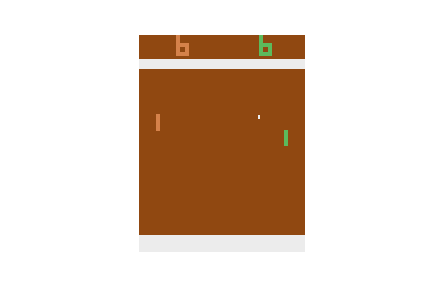
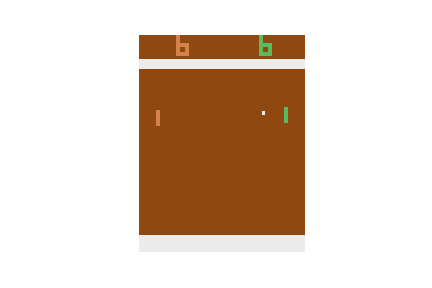
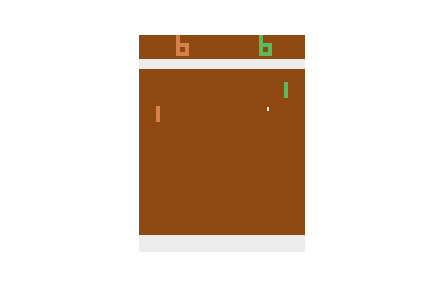
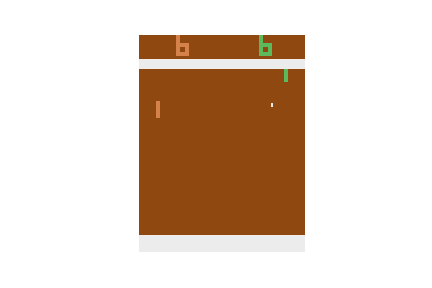
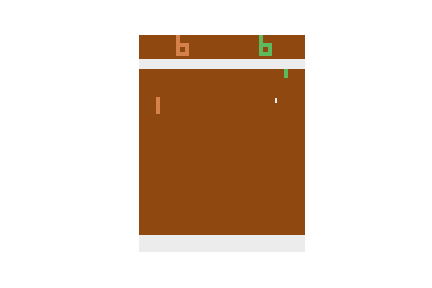
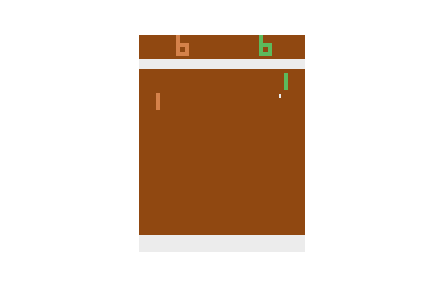
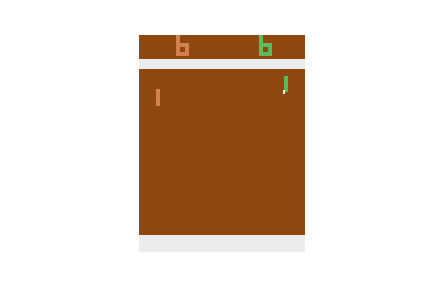
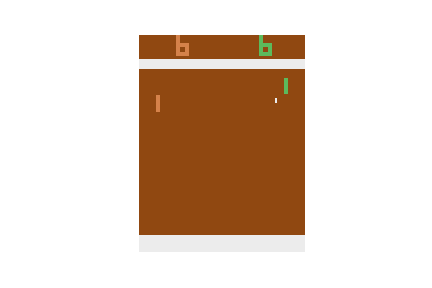
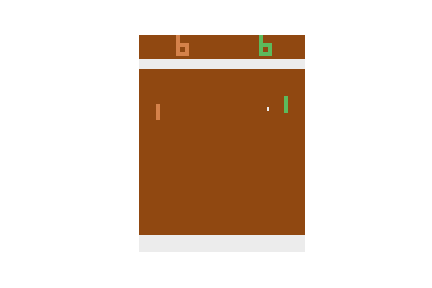
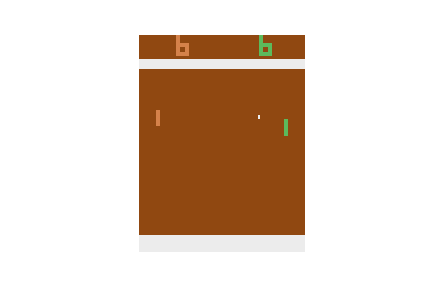
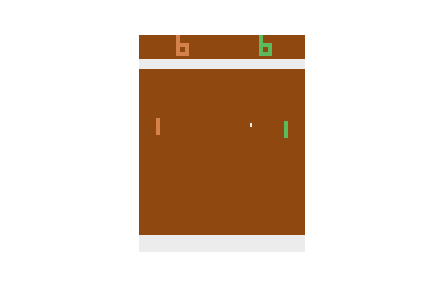
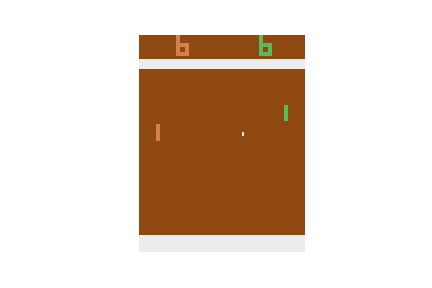
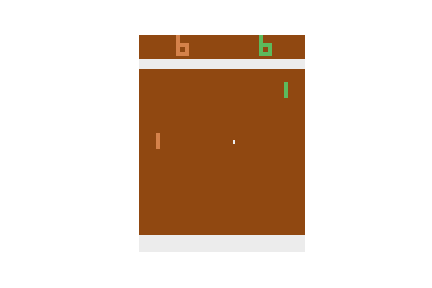
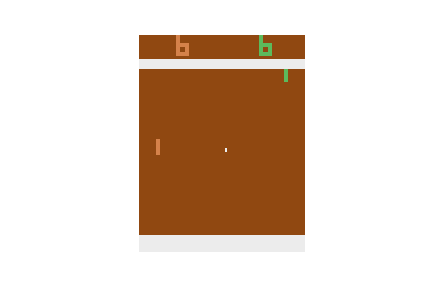
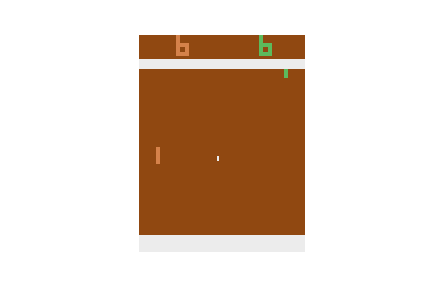
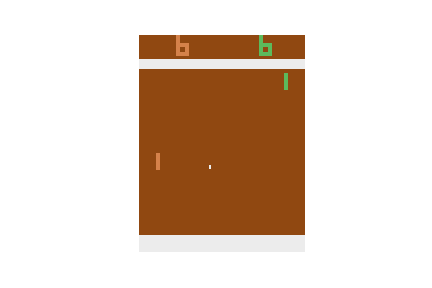
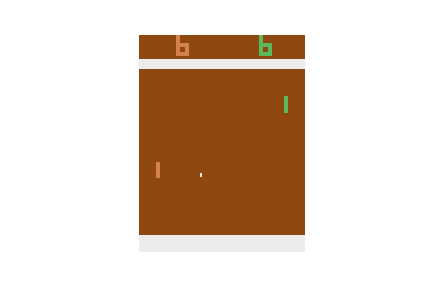
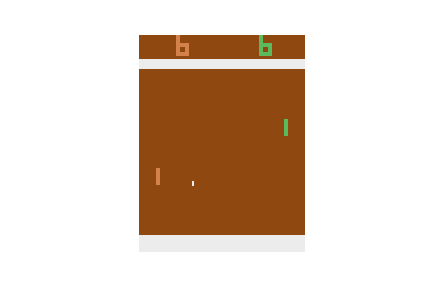
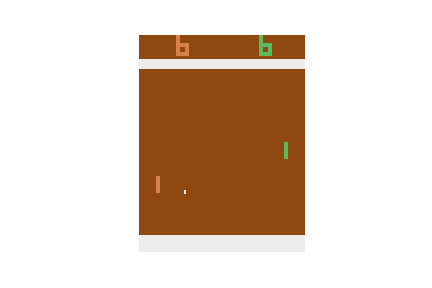
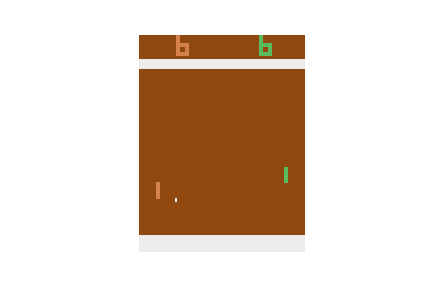
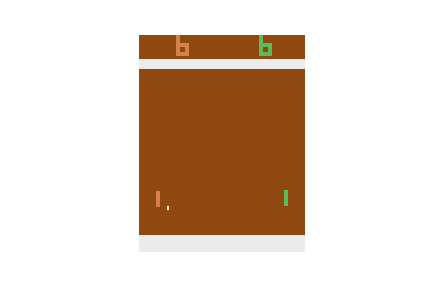
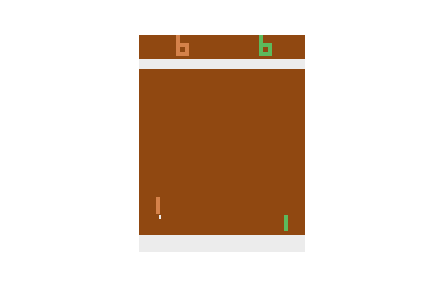
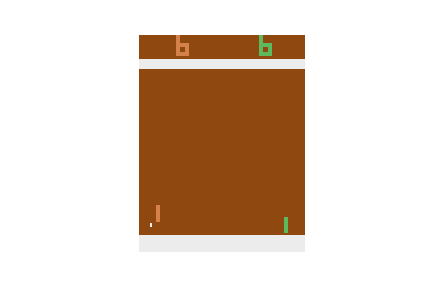
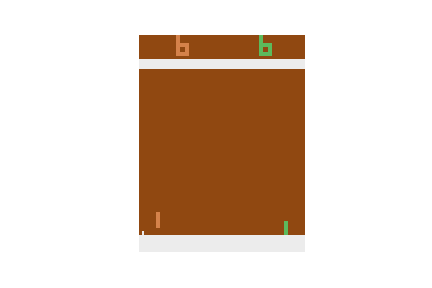
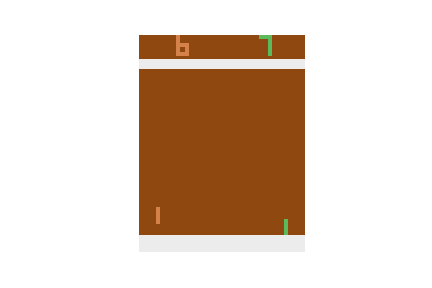
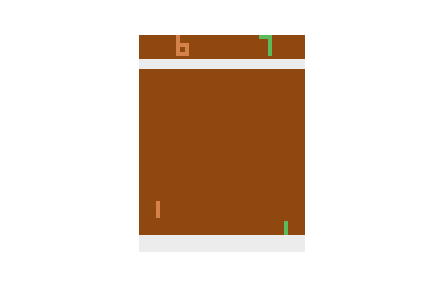
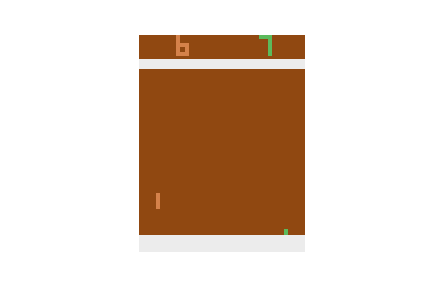
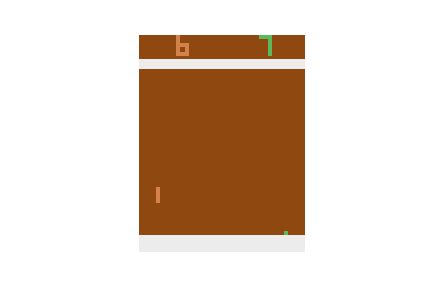
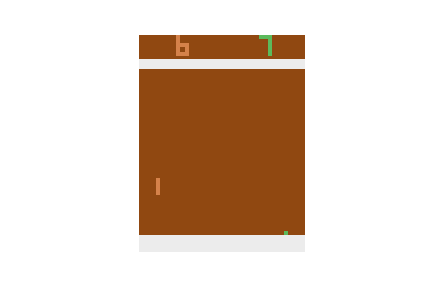
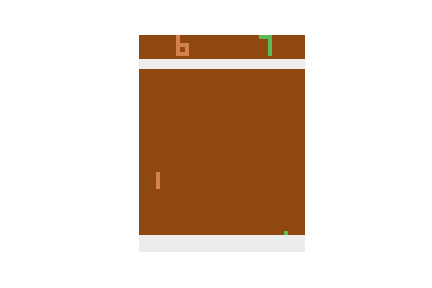
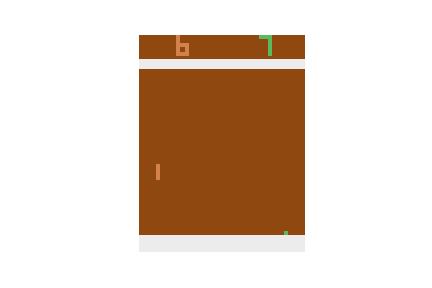
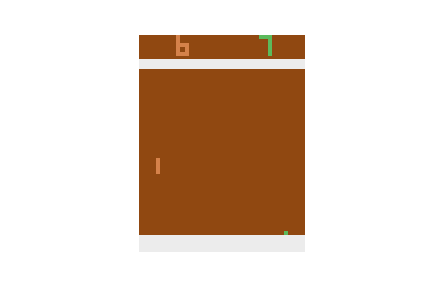
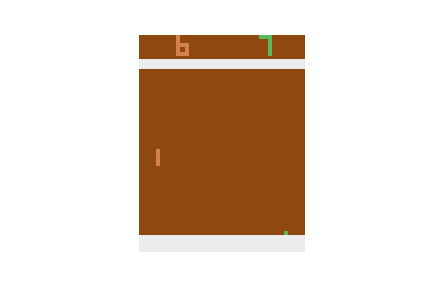
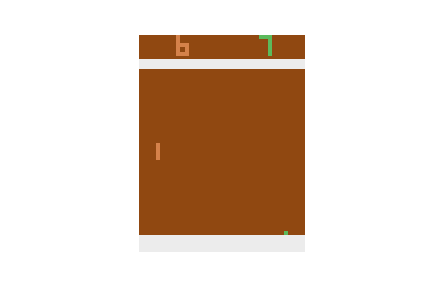
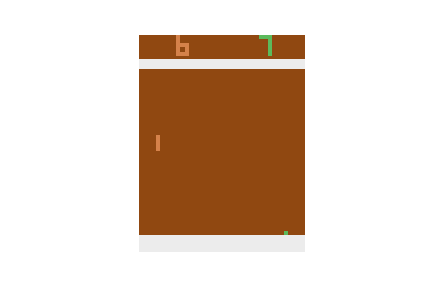
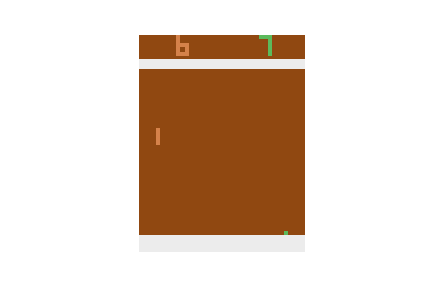
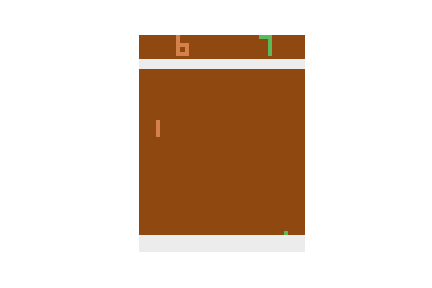
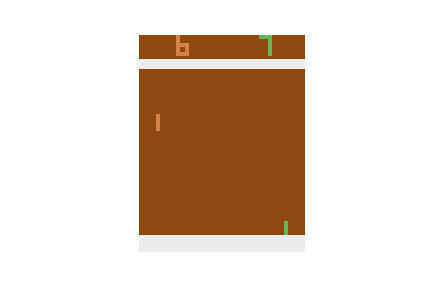
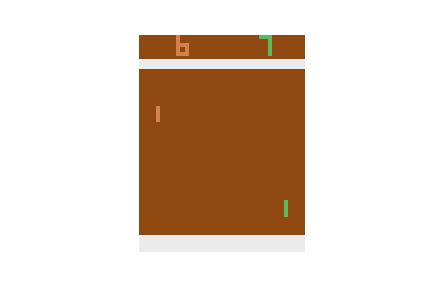
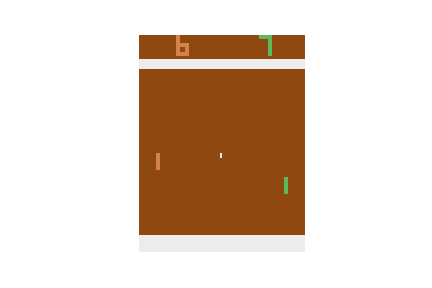
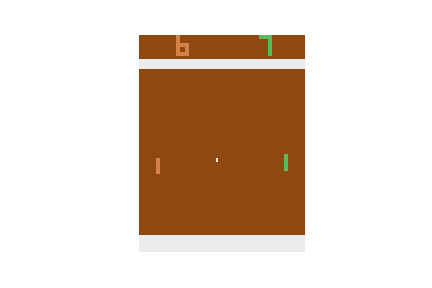
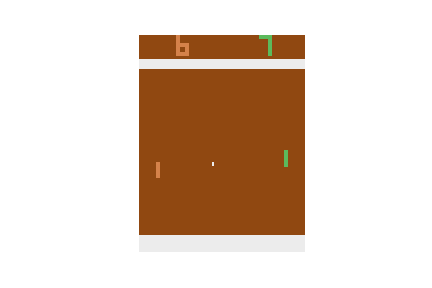
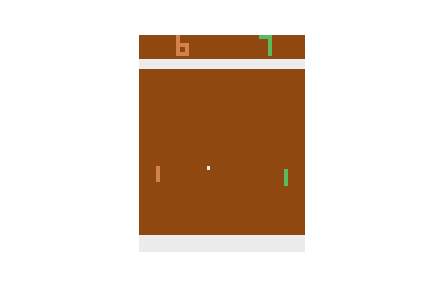
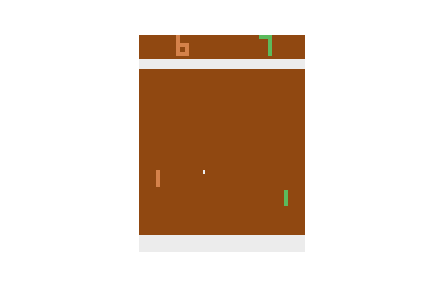
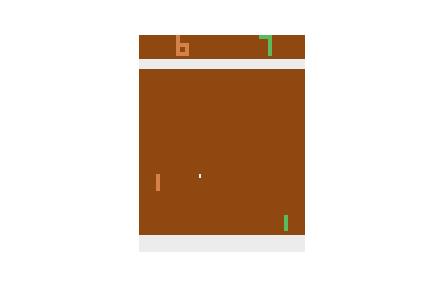
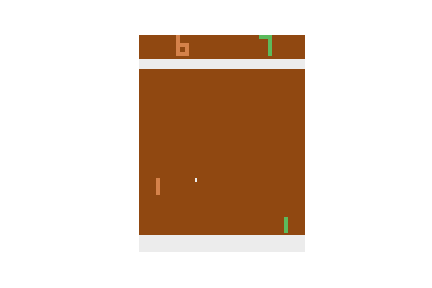
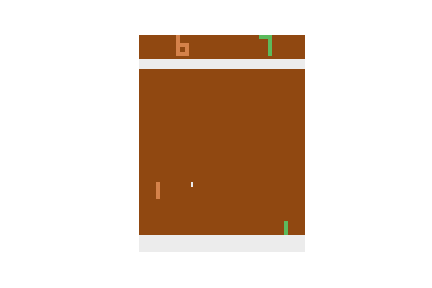
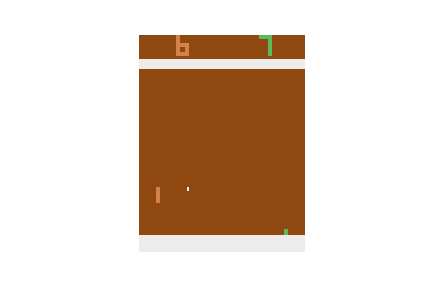
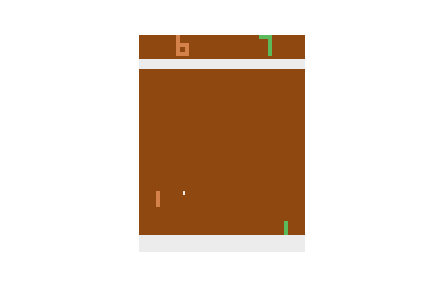
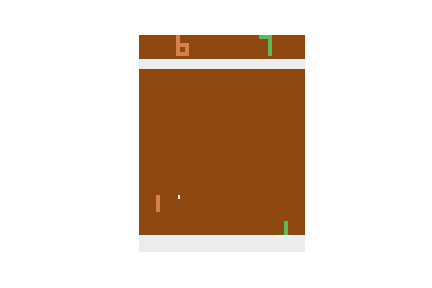
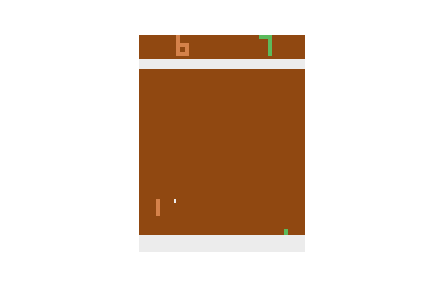
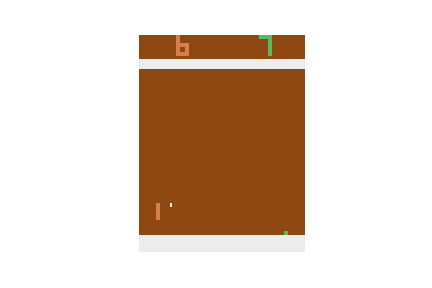
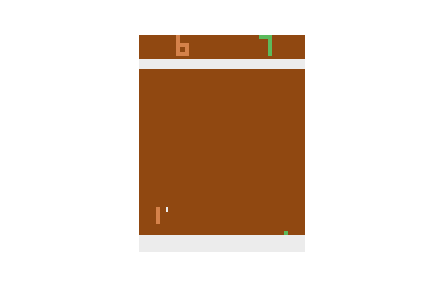
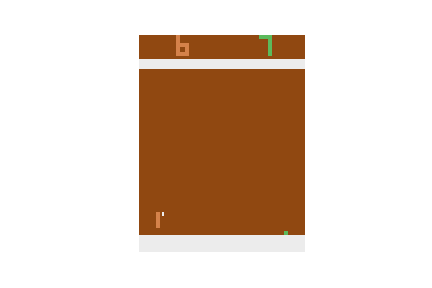
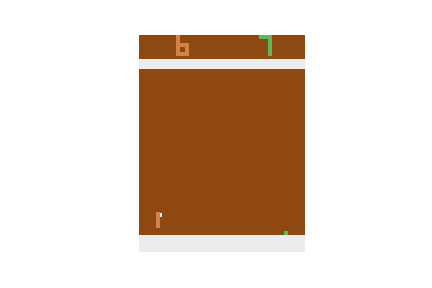
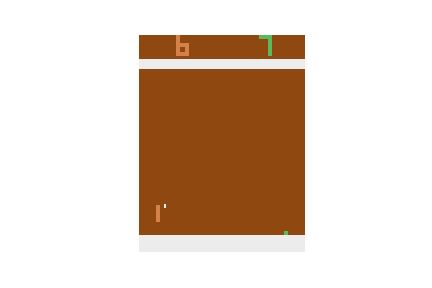
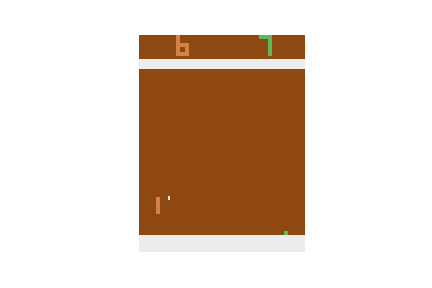
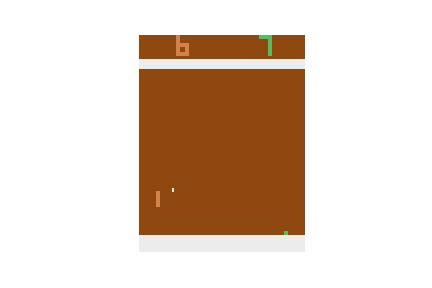
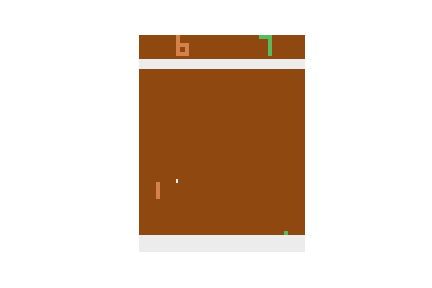
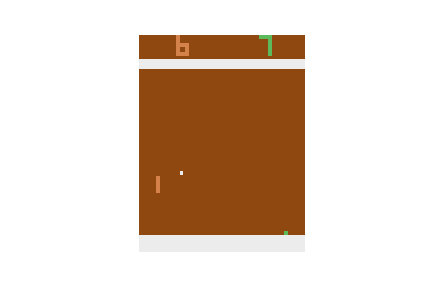
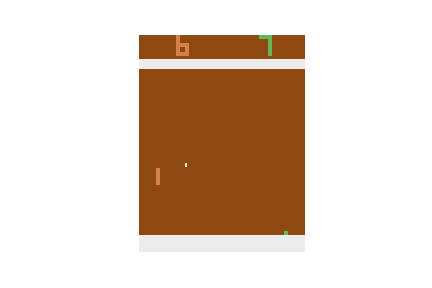
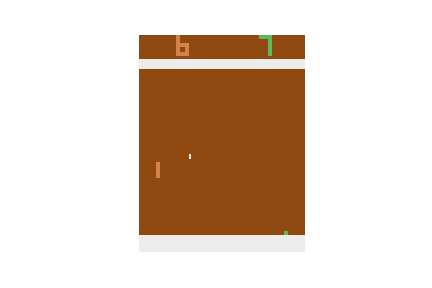
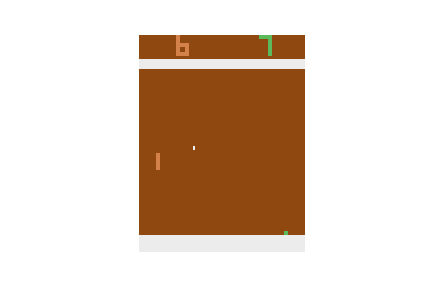
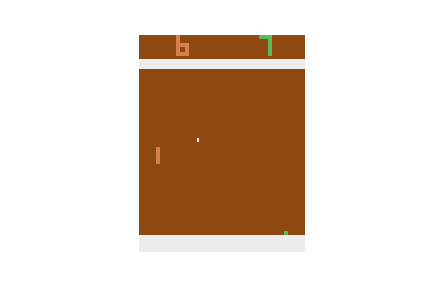
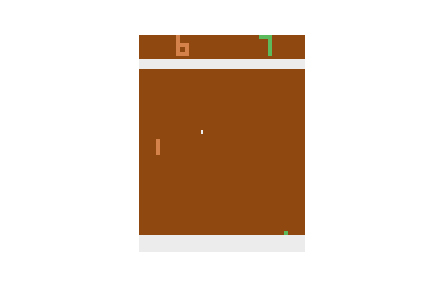
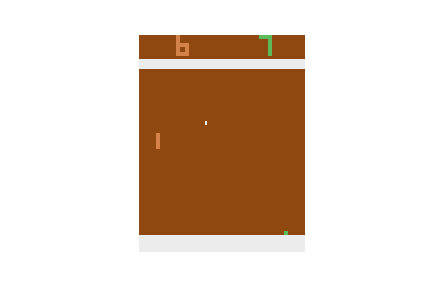
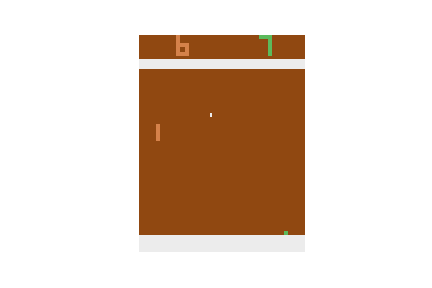
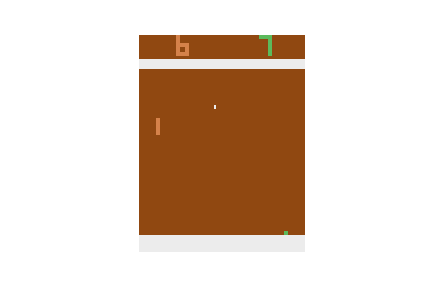
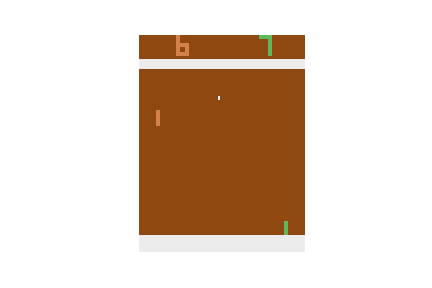
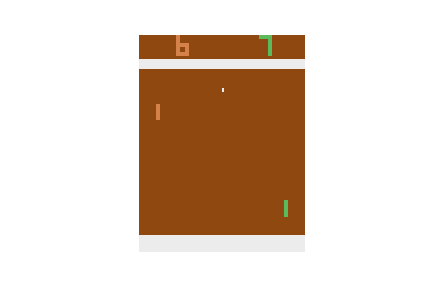
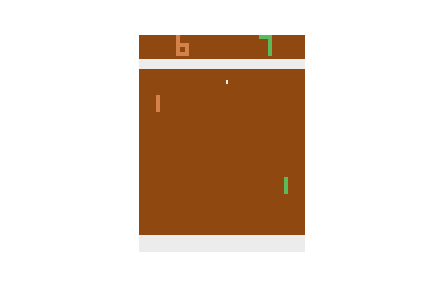
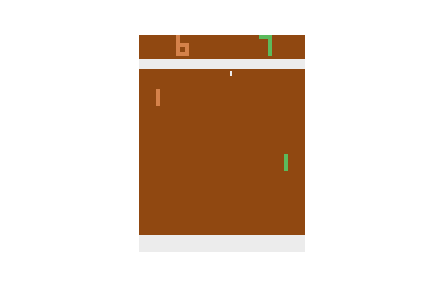
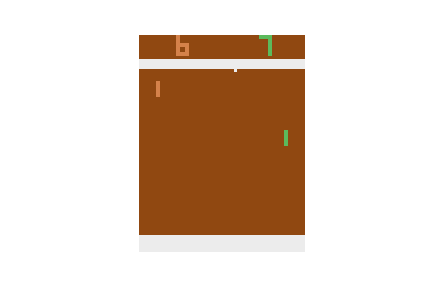
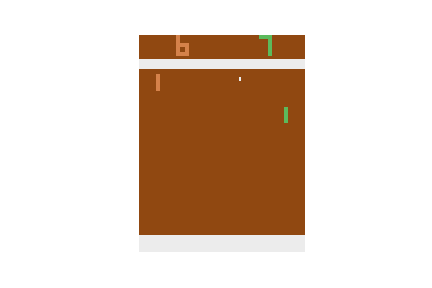
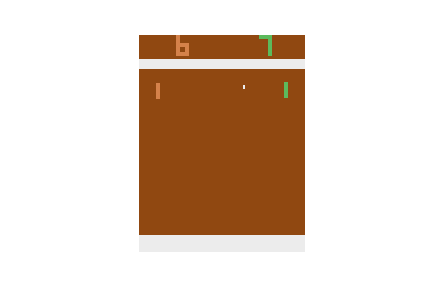
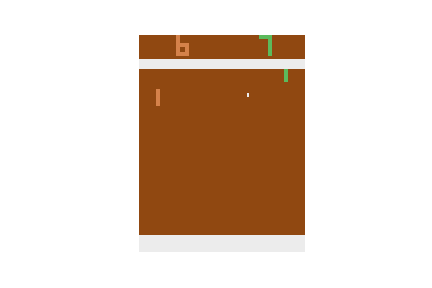
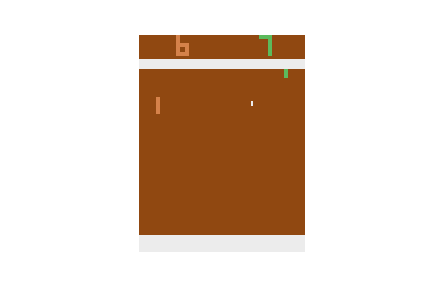
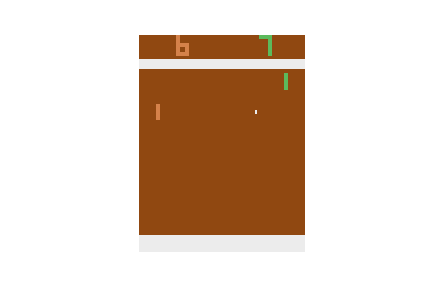
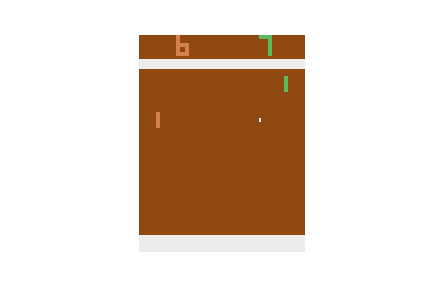
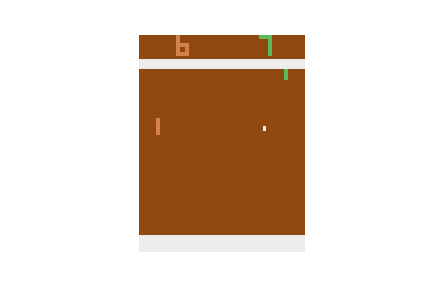
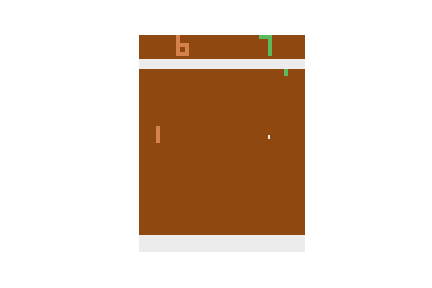
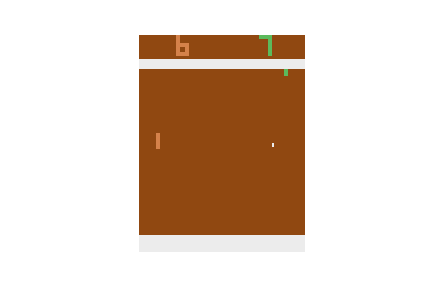
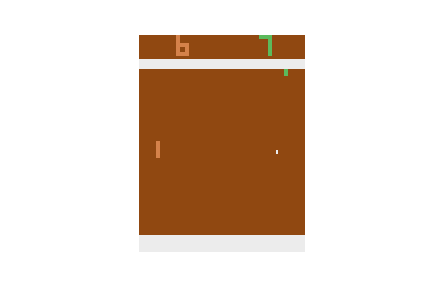
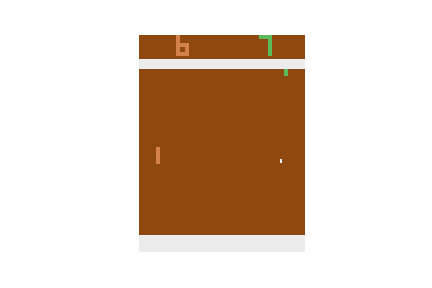
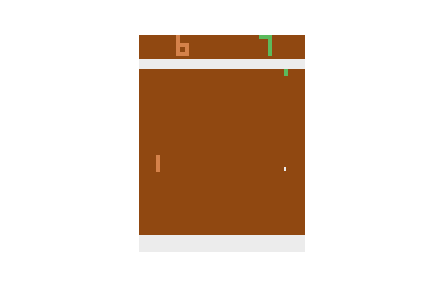
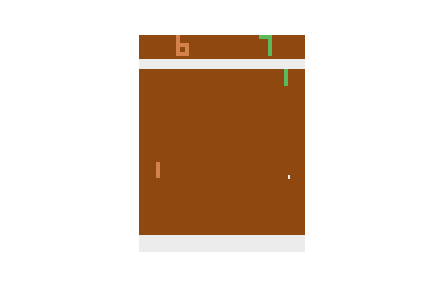
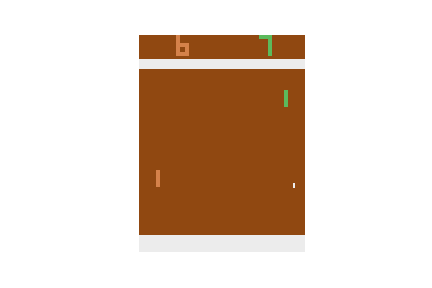
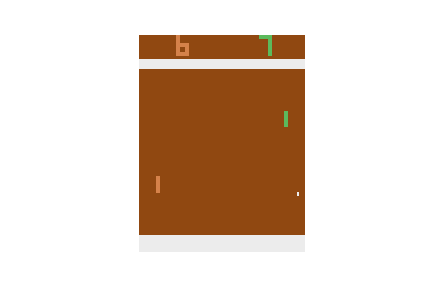
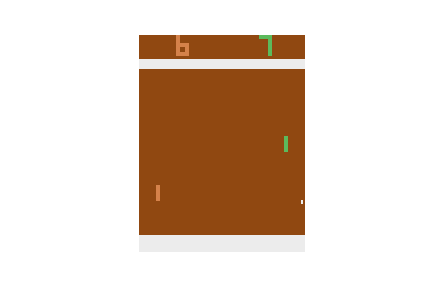
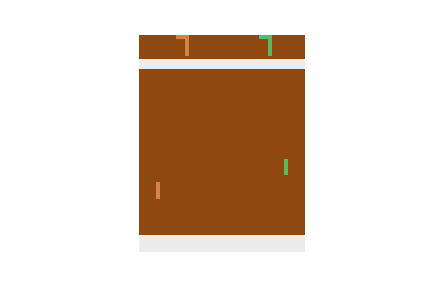
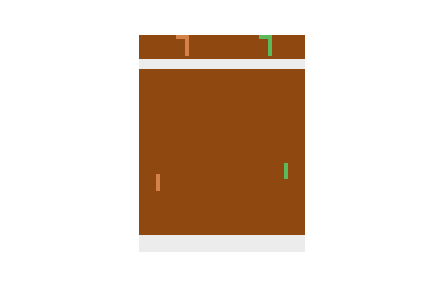
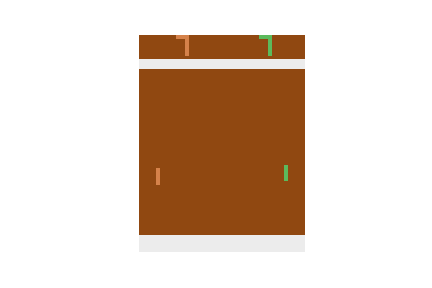
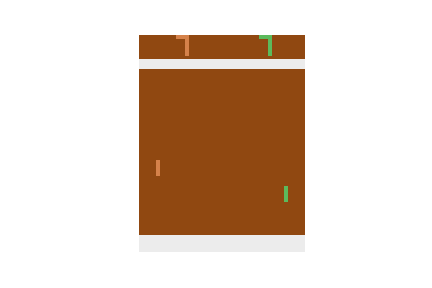
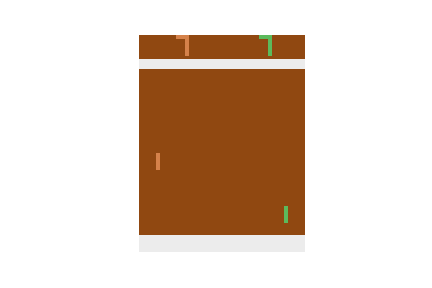
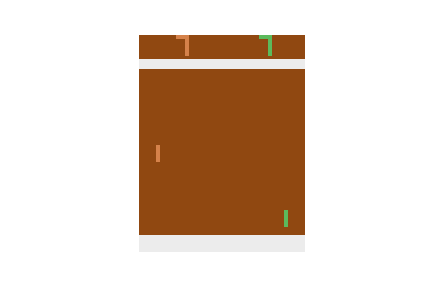
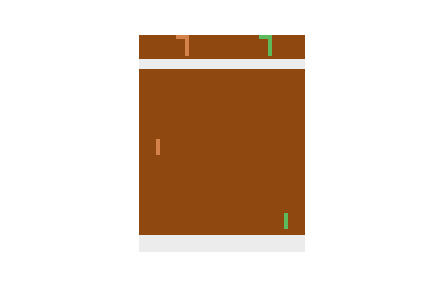
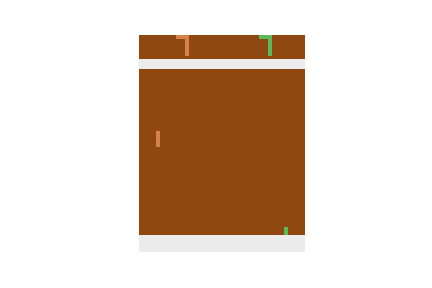
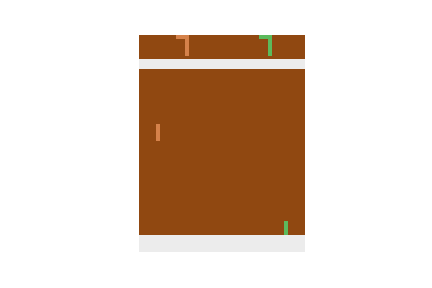
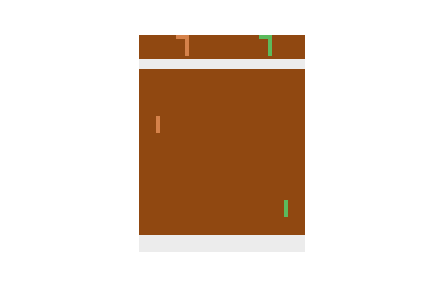
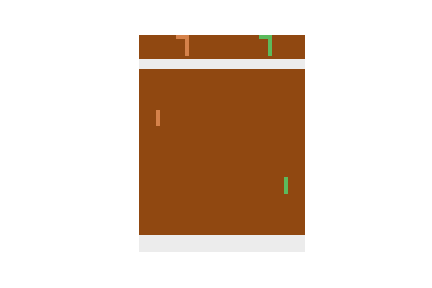
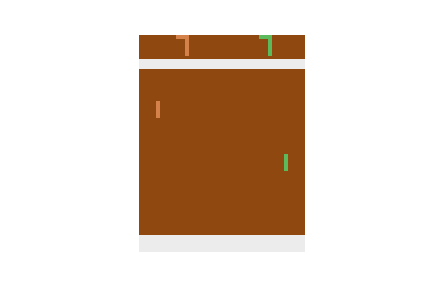
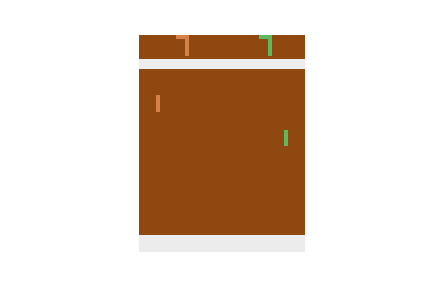
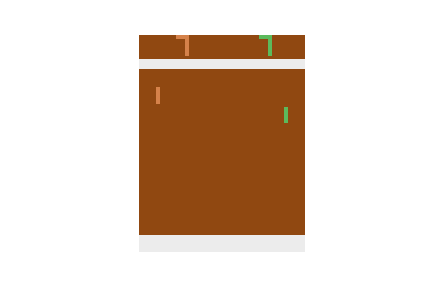
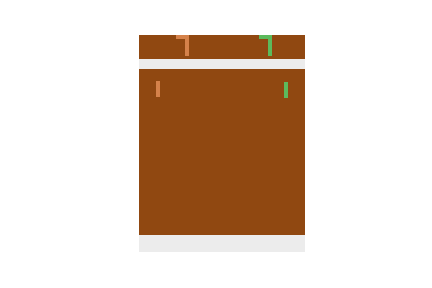
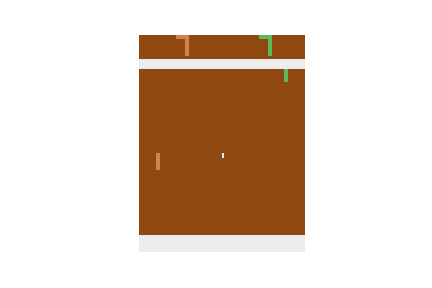
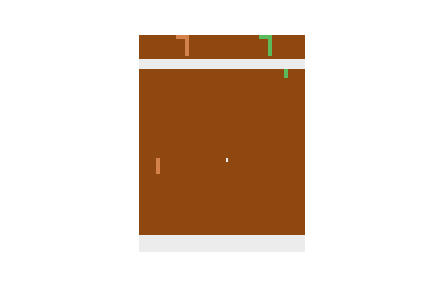
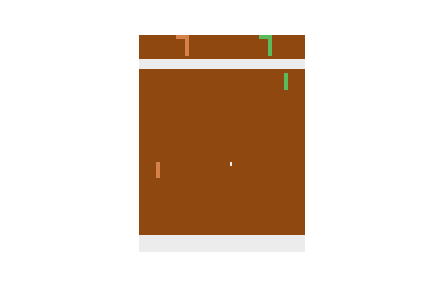
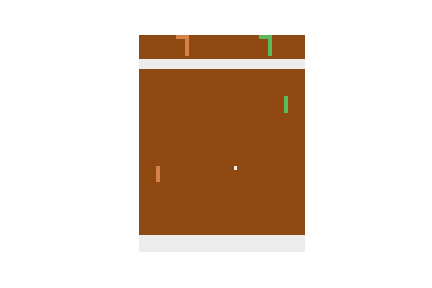
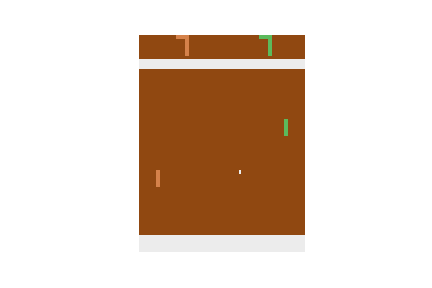
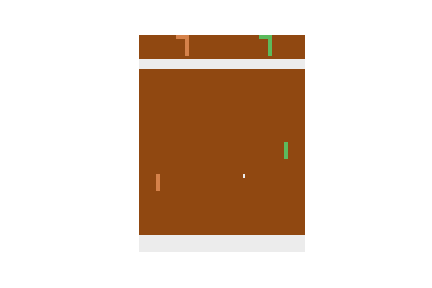
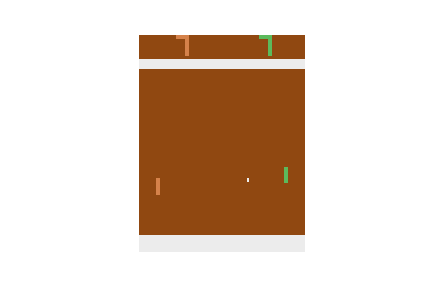
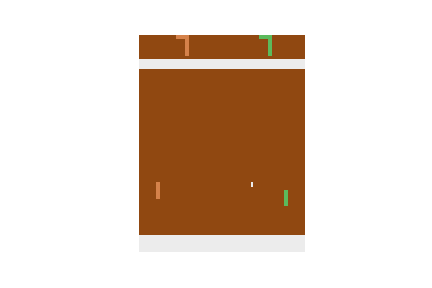
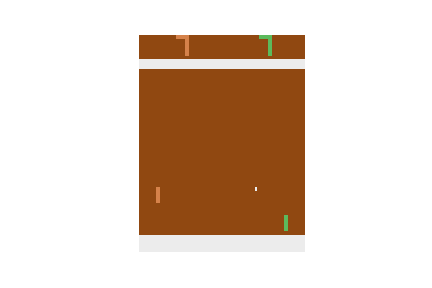
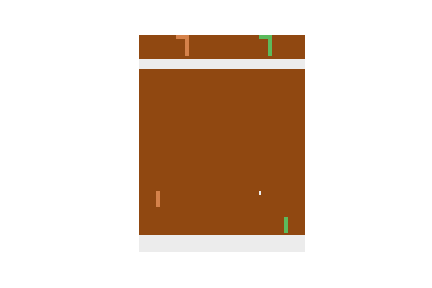
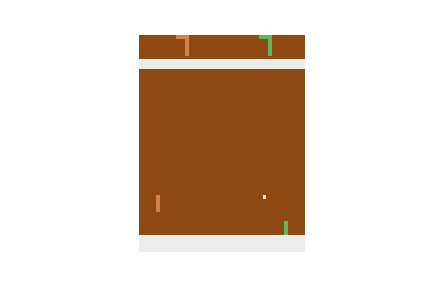
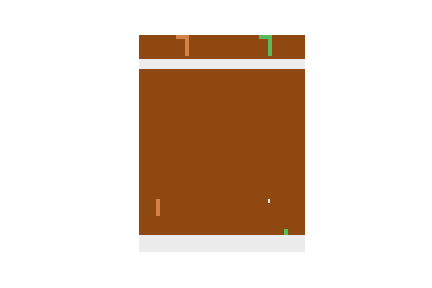
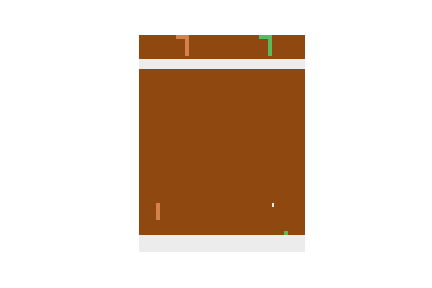
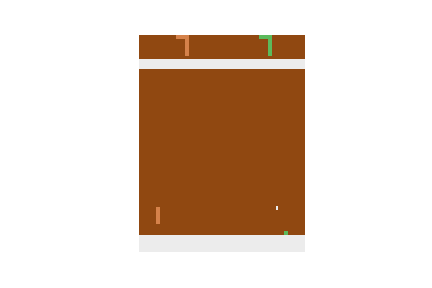
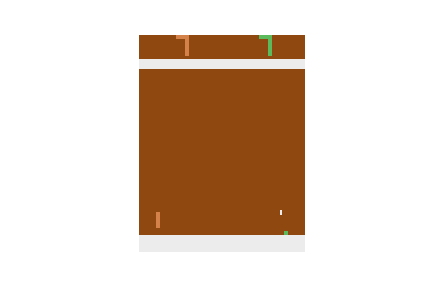
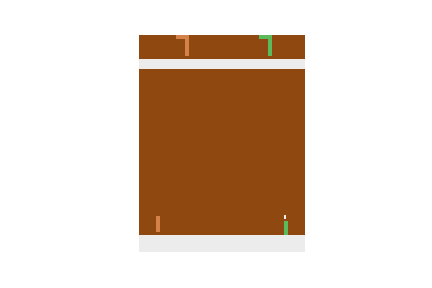
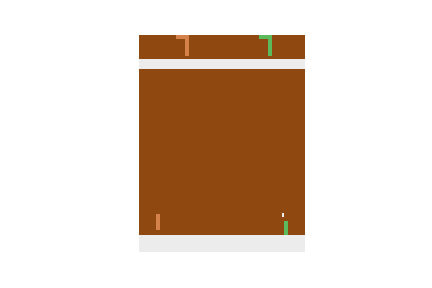
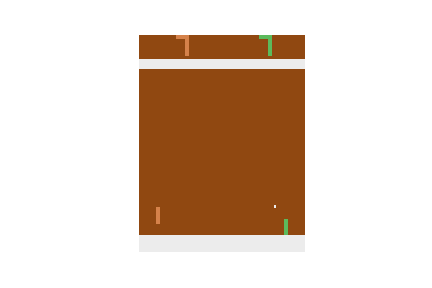
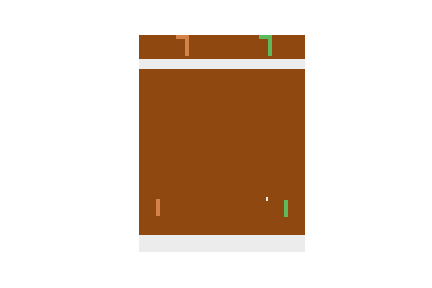
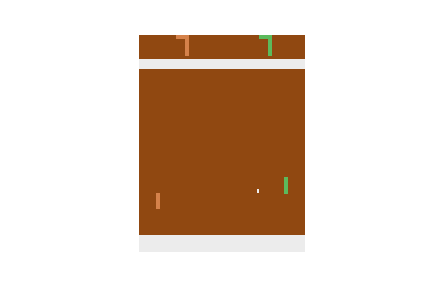
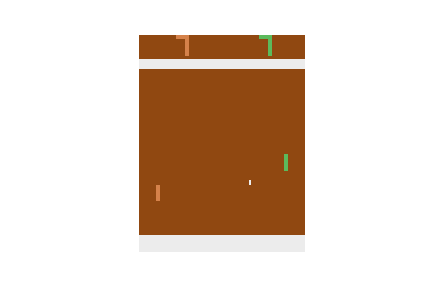
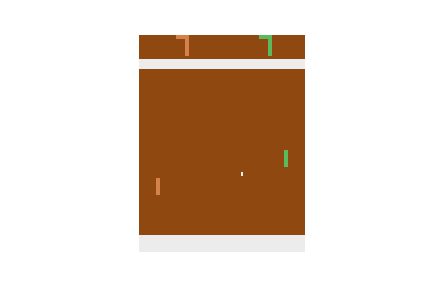
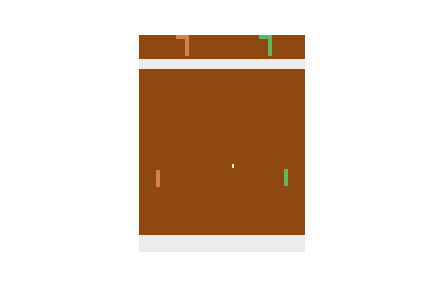
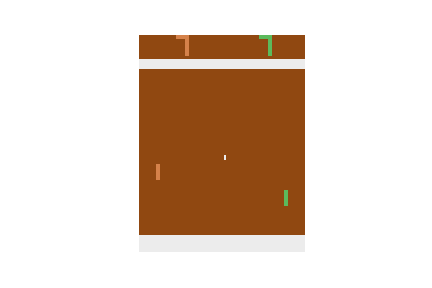
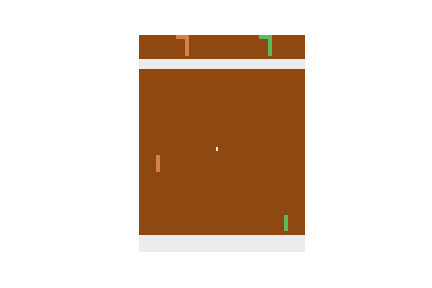
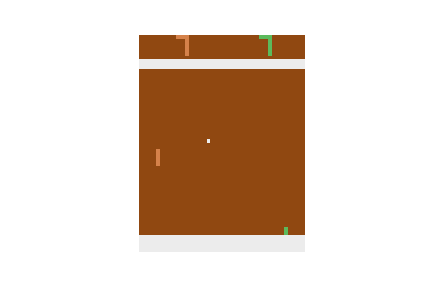
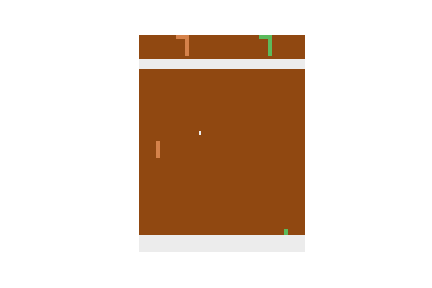
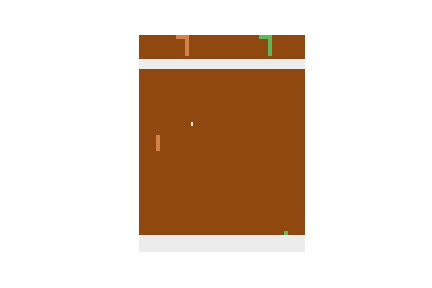
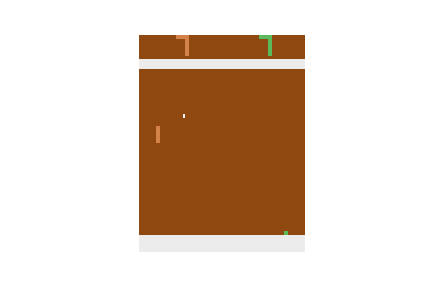
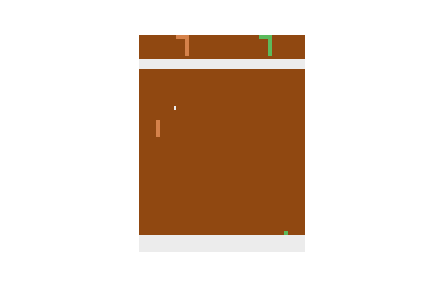
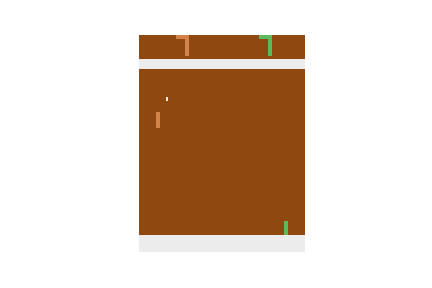
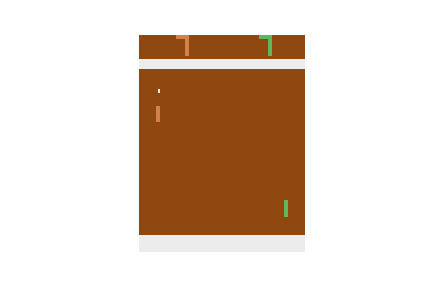
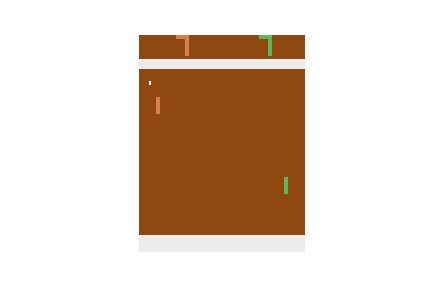
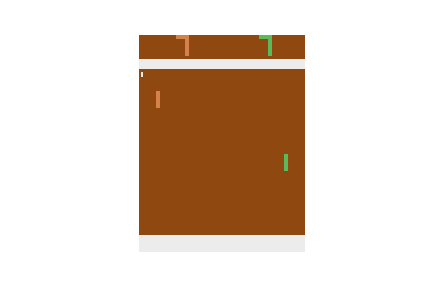
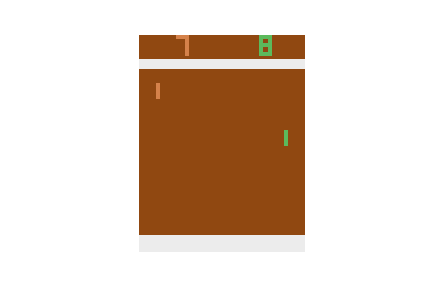
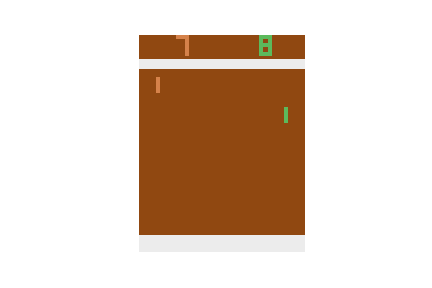
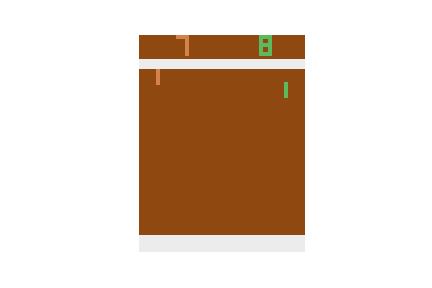
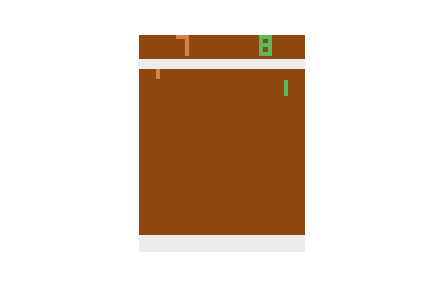
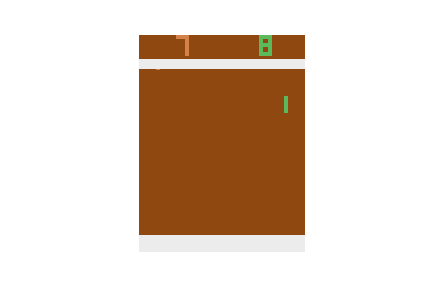
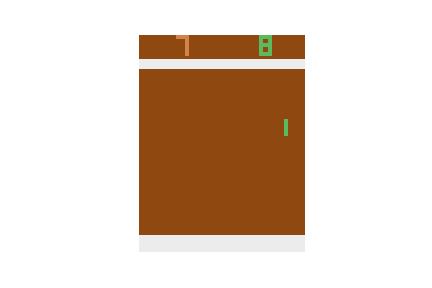
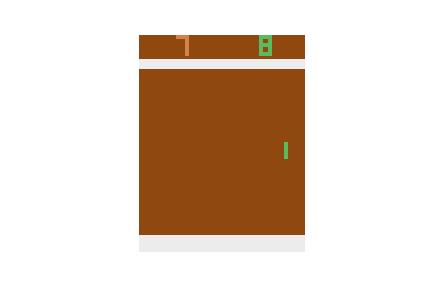
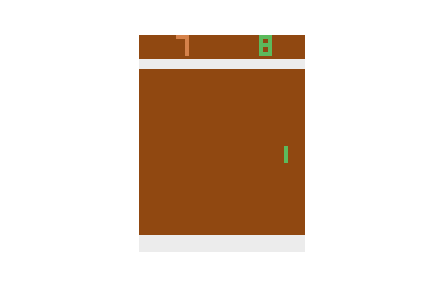
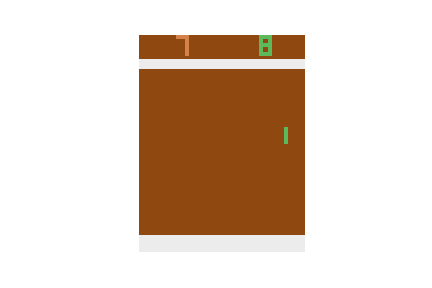
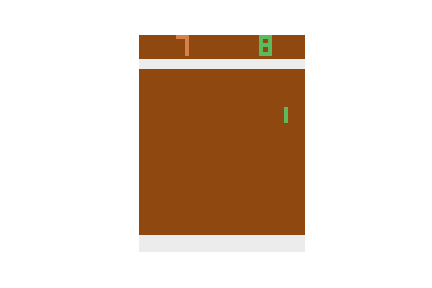
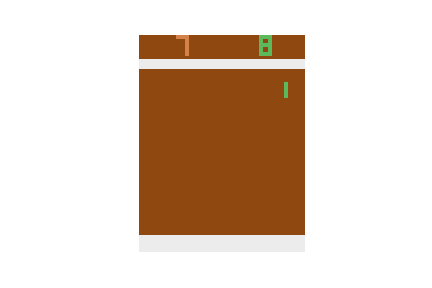
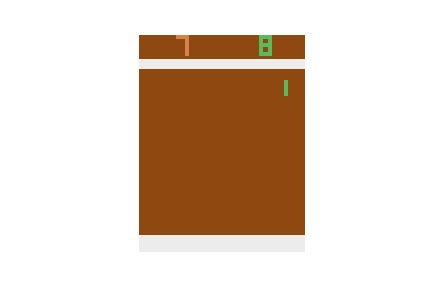
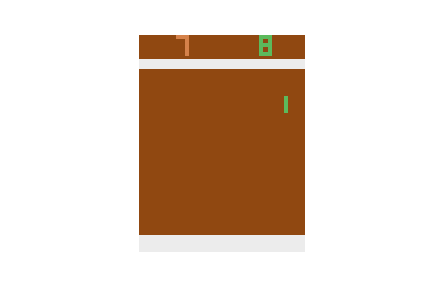
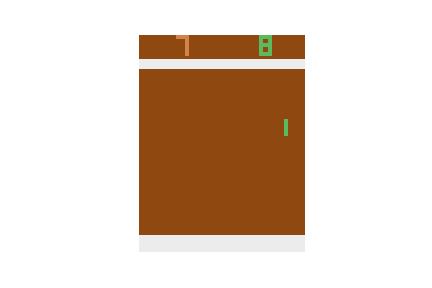
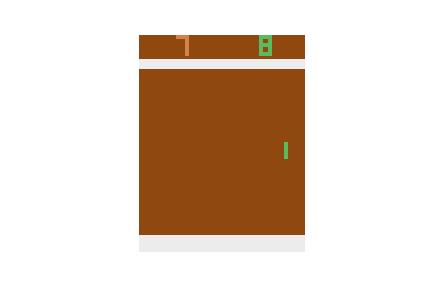
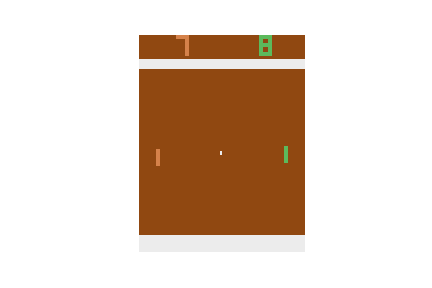
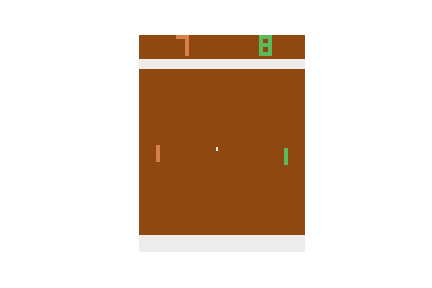
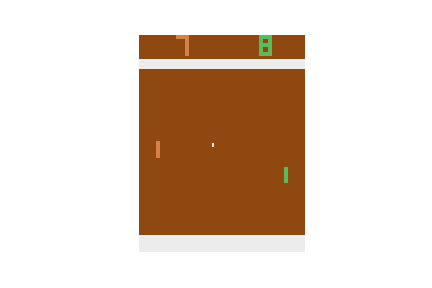
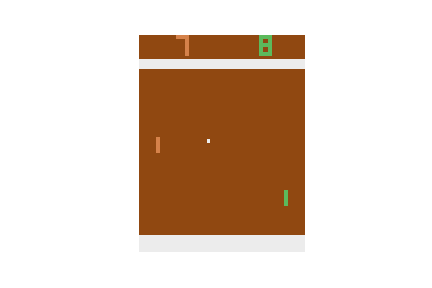
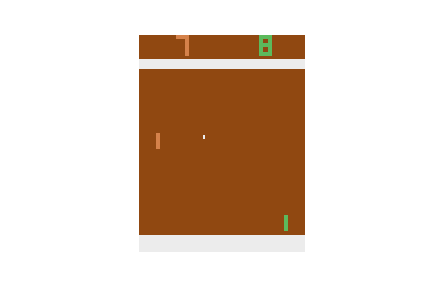
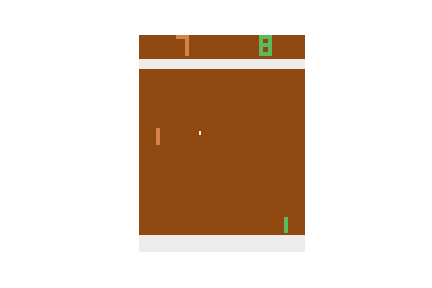
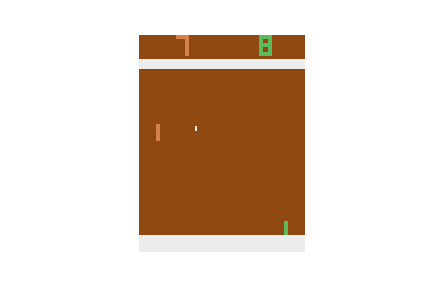
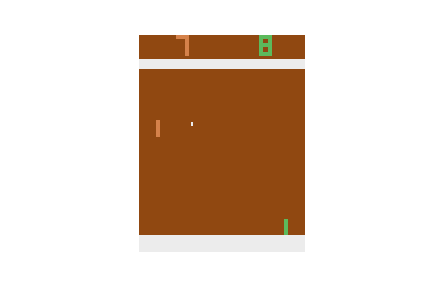
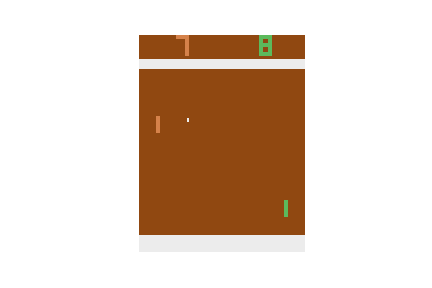
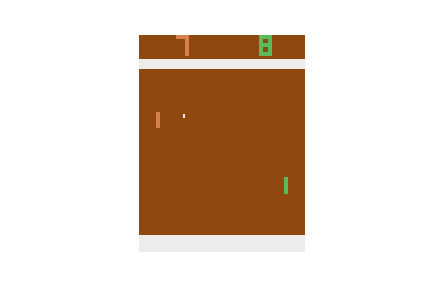
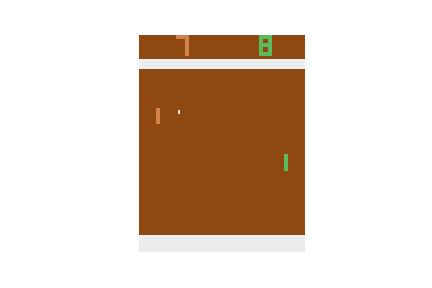
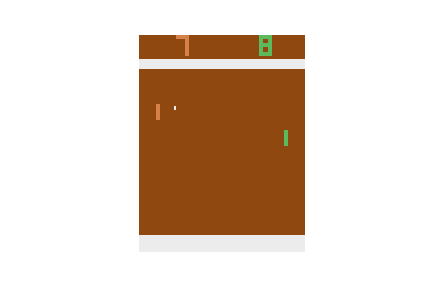
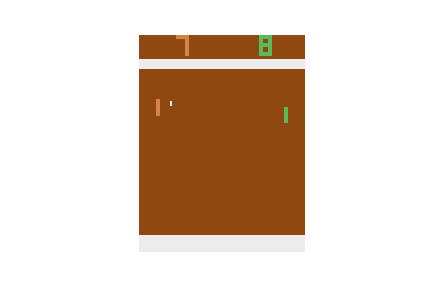
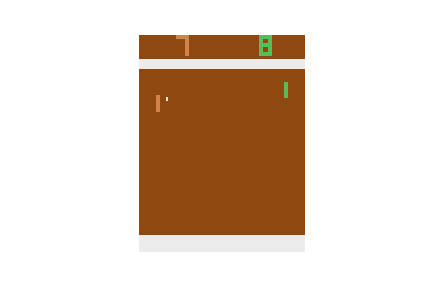
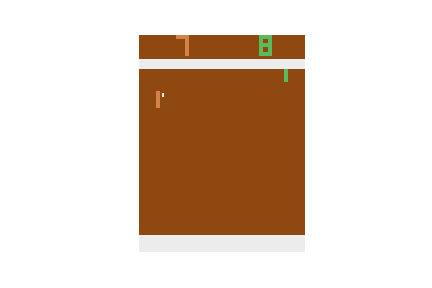
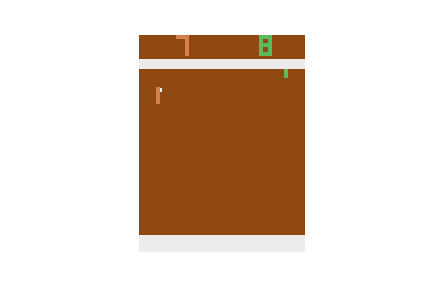
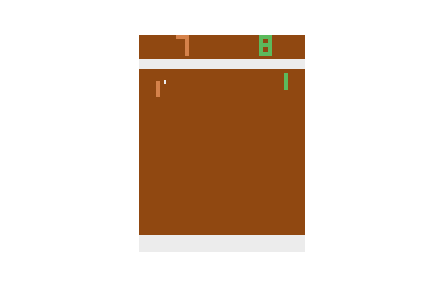
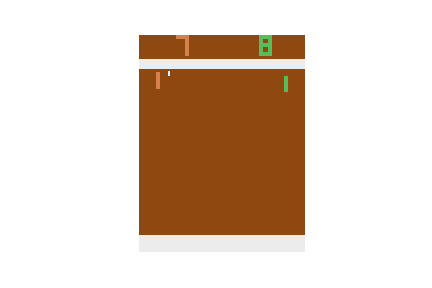
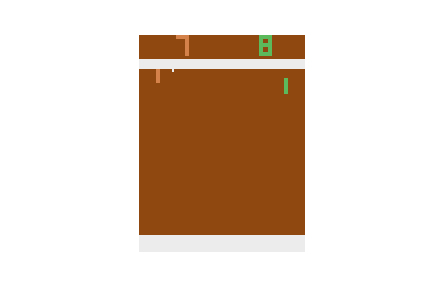
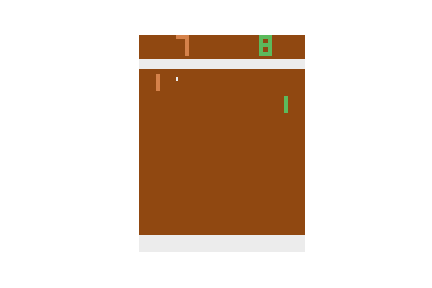
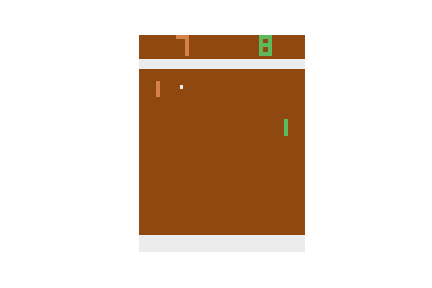
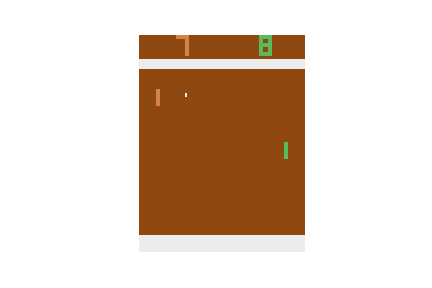
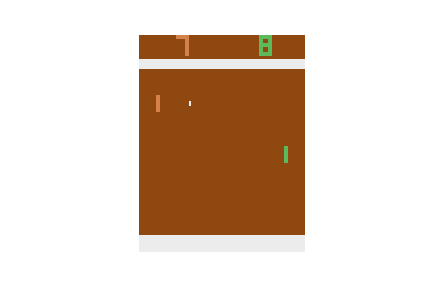
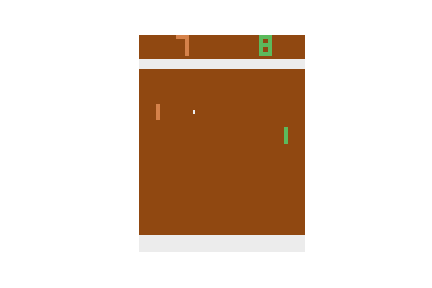
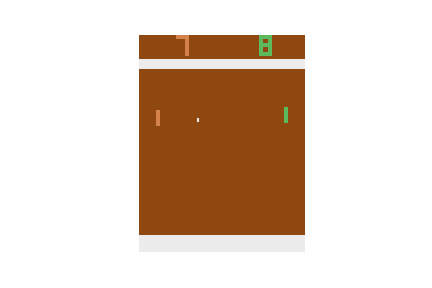
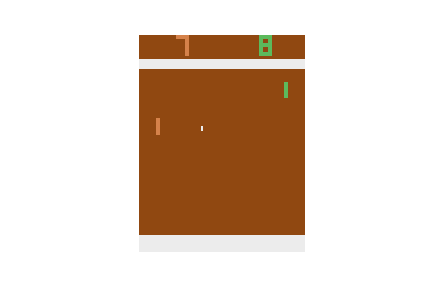
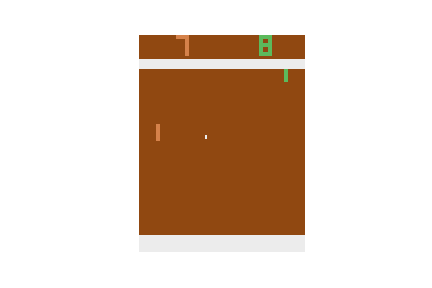
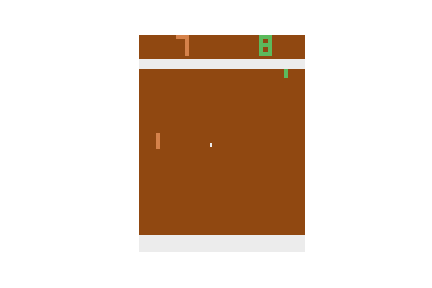
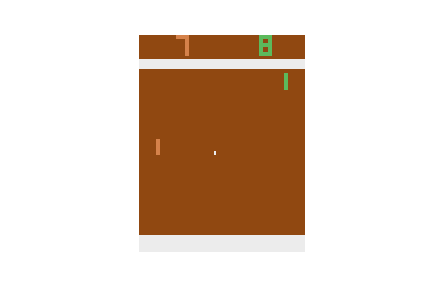
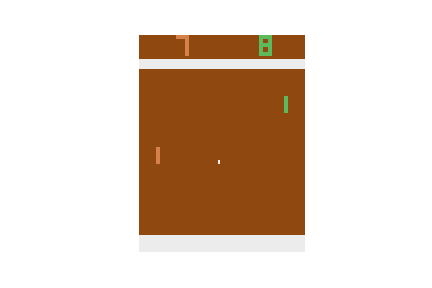
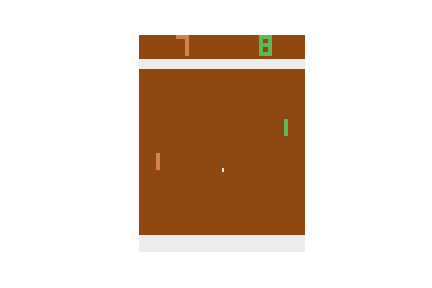
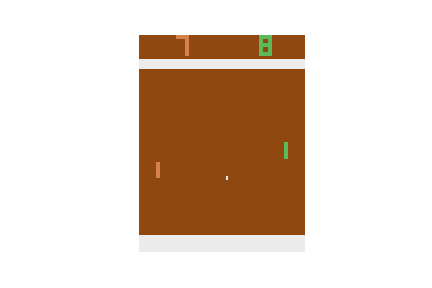
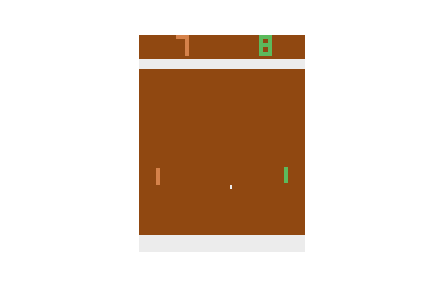
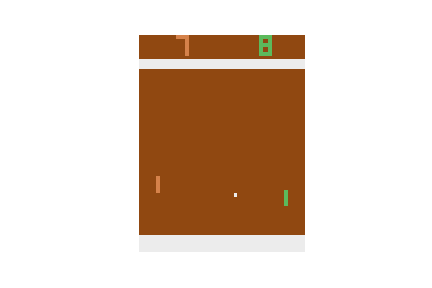
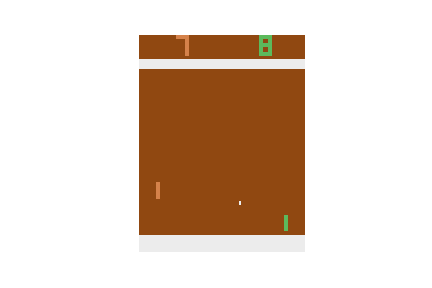
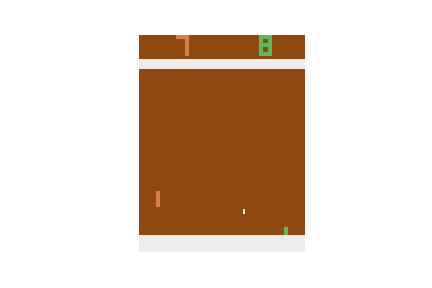
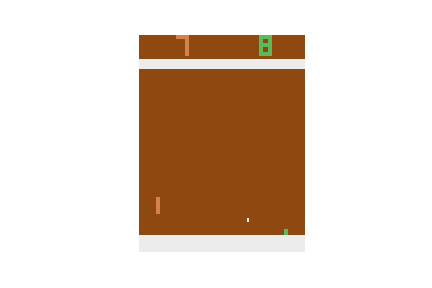
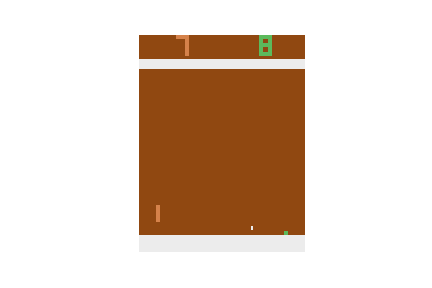
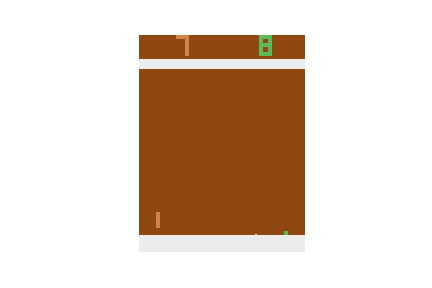
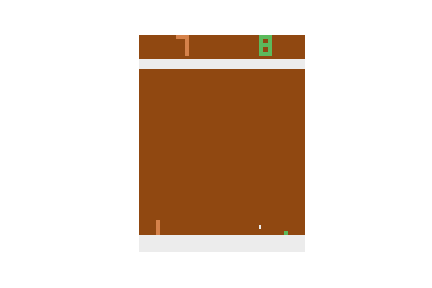
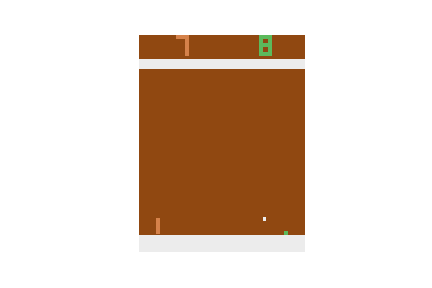
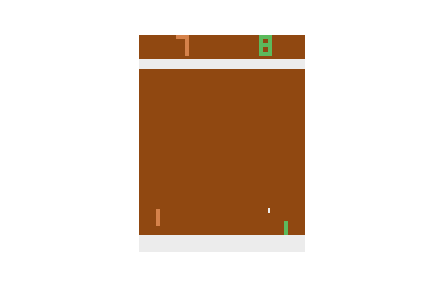
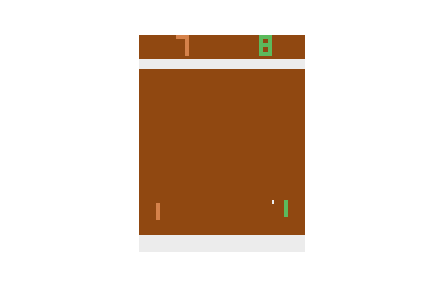
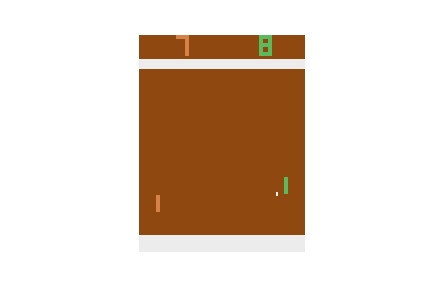
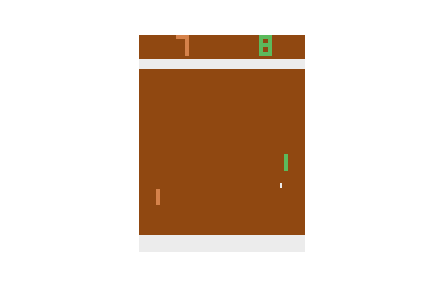
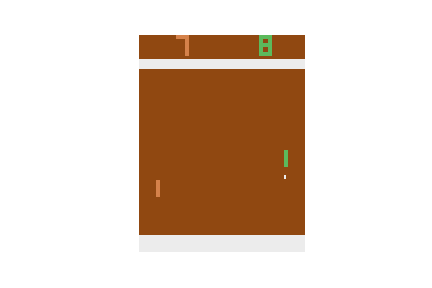
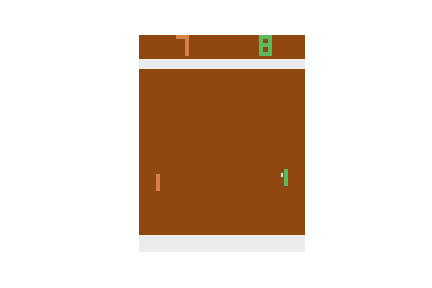
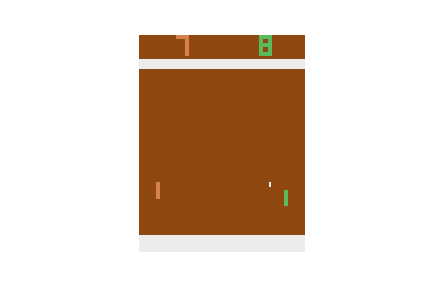
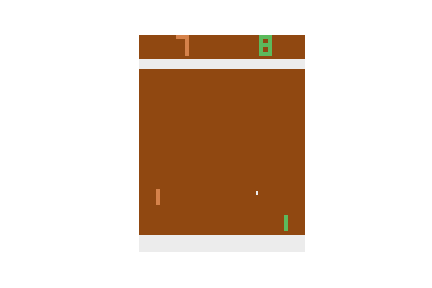
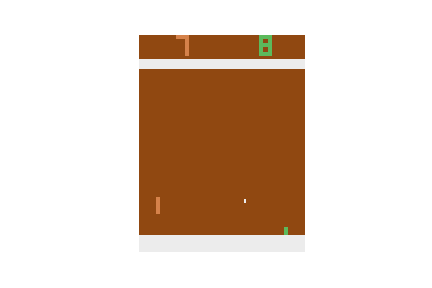
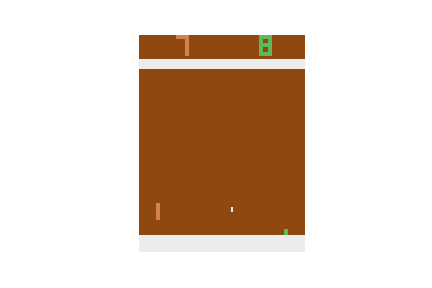
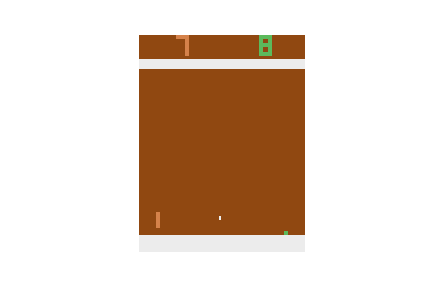
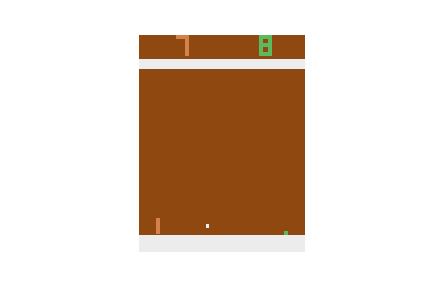
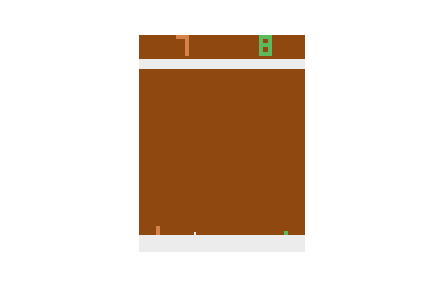
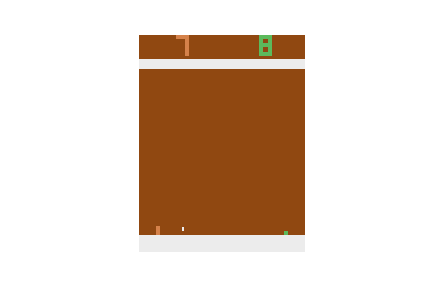
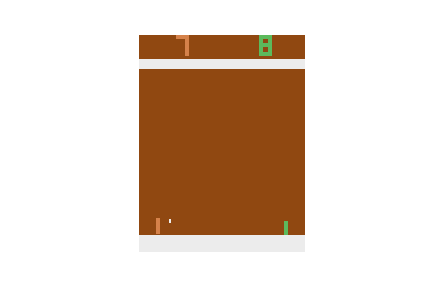
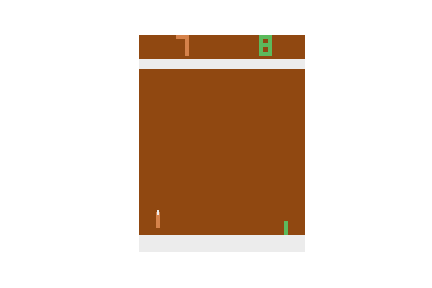
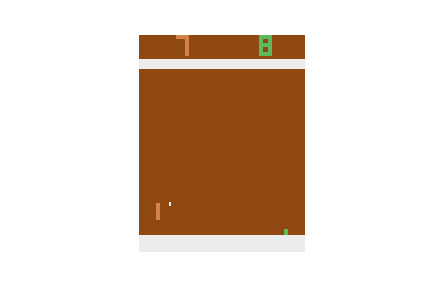
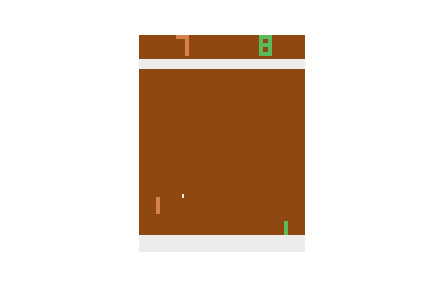
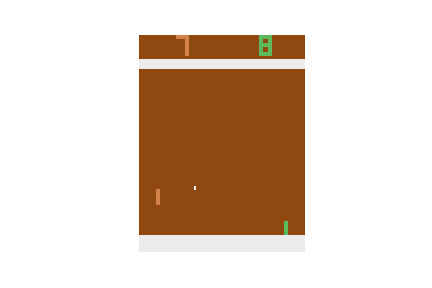
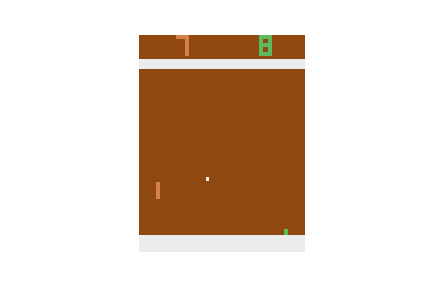
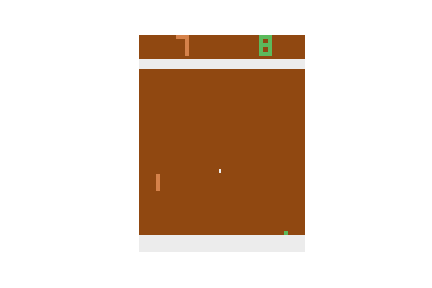
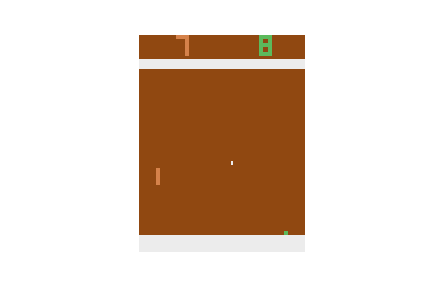
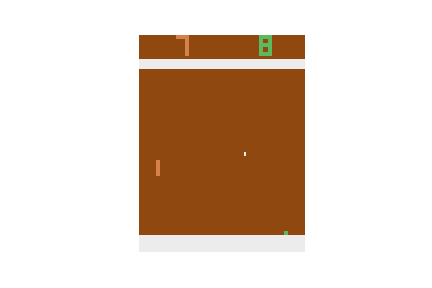
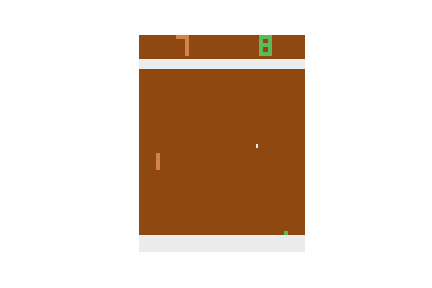
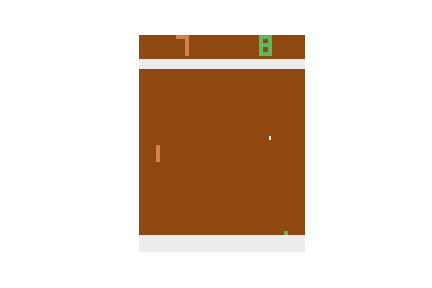
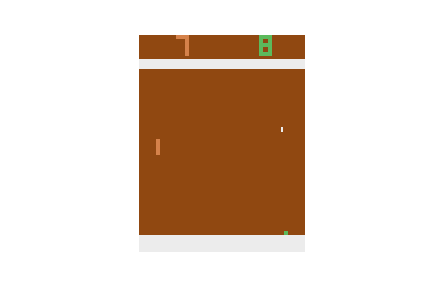
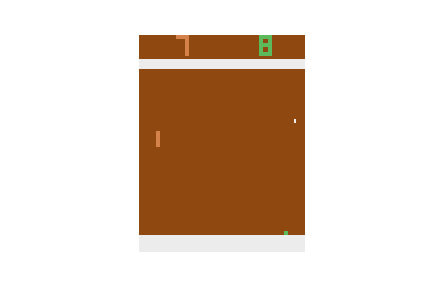
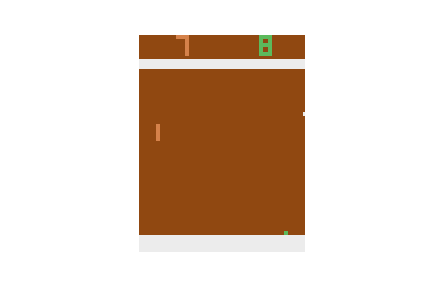

999


In [ ]:
observation = env.reset()
cum_reward = 0
frames = []
prev_frame = None
for t in range(1000):
    x = preprocess(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    observation, reward, done, info = env.step(action)
    if done:
        break
        
# env.render(close=True)
display_frames_as_gif(frames)
print(t)

In [ ]:
n_episodes = 1000
reward_sums = np.hstack([reward_sums, np.zeros(n_episodes)])
losses = np.hstack([losses, np.zeros(n_episodes)])
time_taken = np.hstack([time_taken, np.zeros(n_episodes)])

observation = env.reset()

while episodes<len(reward_sums):
    # Get the current state of environment
    x = preprocess(observation)
    xs[k] = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    prev_frame = x
    
    # Take an action given current state of policy model
    p = model.predict(xs[k][None,:,:,:])
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    ys[k] = a
    
    # Renew state of environment
    observation, reward, done, _ = env.step(action)
    reward_sum += reward #record total rewards
    rs[k] = reward # record reward per step
    
    k += 1
    
    if done or k==buffer:
        reward_sums[episodes] = reward_sum
        reward_sum = 0
        
        # Gather state, action (y), and rewards (and preprocess)
        ep_x = xs[:k]
        ep_y = ys[:k]
        ep_r = rs[:k]
        ep_r = discount_n_standardise(ep_r)
        
        model.fit(ep_x, ep_y, sample_weight=ep_r, batch_size=512, epochs=1, verbose=0)
        
        time_taken[episodes] = k
        k = 0
        prev_frame = None
        observation = env.reset()
        losses[episodes] = model.evaluate(ep_x, 
                                          ep_y,
                                          sample_weight=ep_r,
                                          batch_size=len(ep_x), 
                                          verbose=0)
        episodes += 1
        
        # Print out metrics like rewards, how long each episode lasted etc.
        if episodes%(n_episodes//20) == 0:
            ave_reward = np.mean(reward_sums[max(0,episodes-200):episodes])
            ave_loss = np.mean(losses[max(0,episodes-200):episodes])
            ave_time = np.mean(time_taken[max(0,episodes-200):episodes])
            print('Episode: {0:d}, Average Loss: {1:.4f}, Average Reward: {2:.4f}, Average steps: {3:.4f}'
                  .format(episodes, ave_loss, ave_reward, ave_time))

Episode: 1050, Average Loss: -0.0159, Average Reward: -2.1200, Average steps: 1000.0000
Episode: 1100, Average Loss: -0.0155, Average Reward: -2.4100, Average steps: 1000.0000
Episode: 1150, Average Loss: -0.0167, Average Reward: -2.4500, Average steps: 1000.0000
Episode: 1200, Average Loss: -0.0186, Average Reward: -2.8100, Average steps: 1000.0000
Episode: 1250, Average Loss: -0.0194, Average Reward: -2.7750, Average steps: 1000.0000
Episode: 1300, Average Loss: -0.0206, Average Reward: -3.1750, Average steps: 996.0500
Episode: 1350, Average Loss: -0.0214, Average Reward: -3.3650, Average steps: 993.7200
Episode: 1400, Average Loss: -0.0213, Average Reward: -2.7400, Average steps: 993.7200
Episode: 1450, Average Loss: -0.0208, Average Reward: -2.2500, Average steps: 993.7200
Episode: 1500, Average Loss: -0.0206, Average Reward: -1.1300, Average steps: 997.6700
Episode: 1550, Average Loss: -0.0197, Average Reward: -0.5800, Average steps: 1000.0000
Episode: 1600, Average Loss: -0.0187,

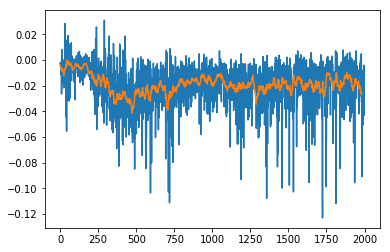

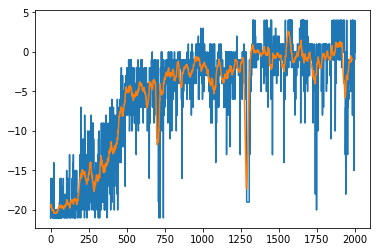

In [ ]:
window = 20
plt.plot(losses[:episodes])
plt.plot(np.convolve(losses[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()

plt.plot(reward_sums[:episodes])
plt.plot(np.convolve(reward_sums[:episodes], np.ones((window,))/window, mode='valid'))
plt.show()


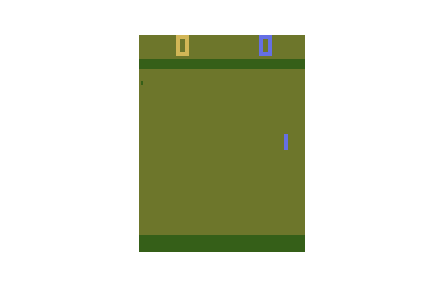
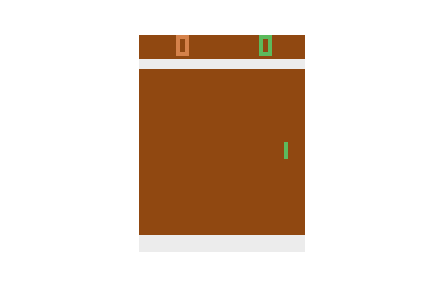
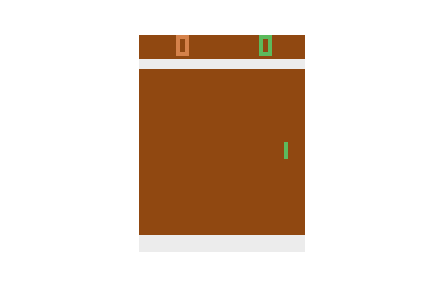
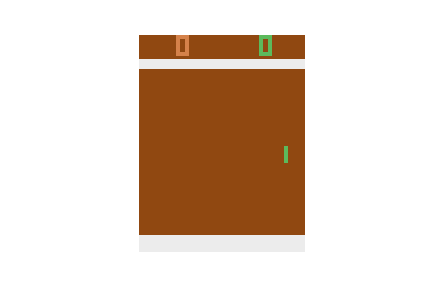
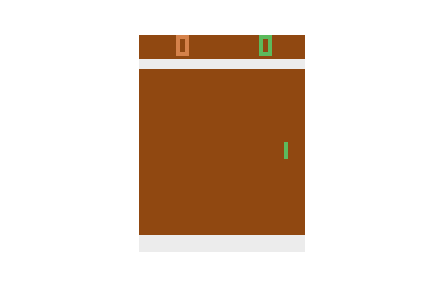
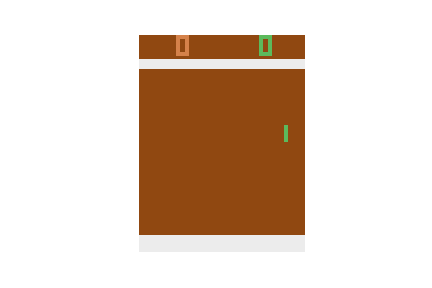
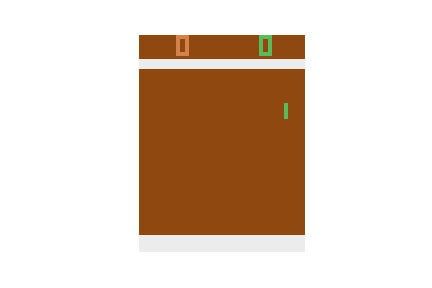
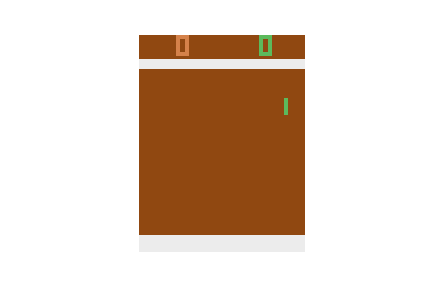
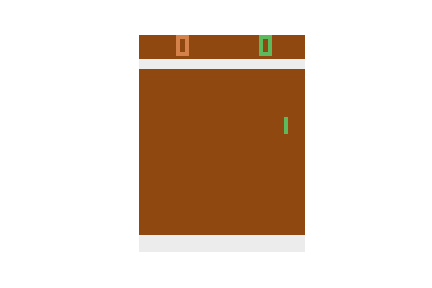
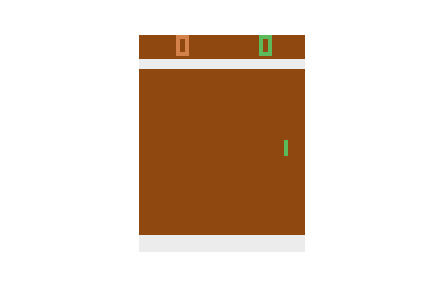
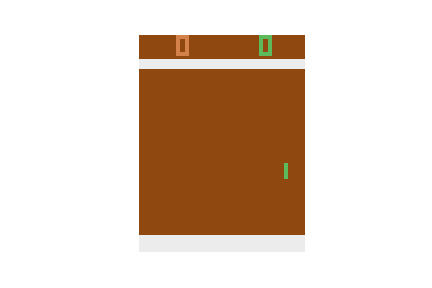
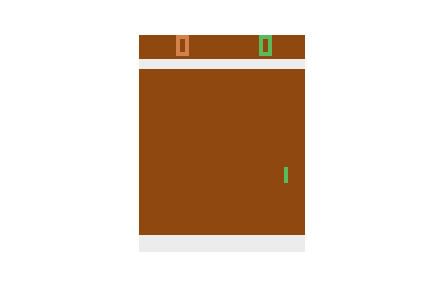
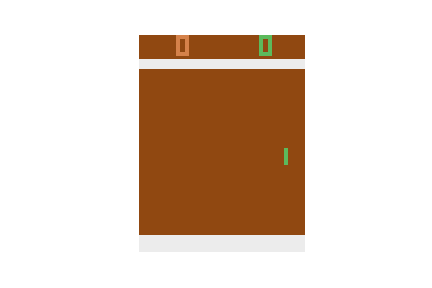
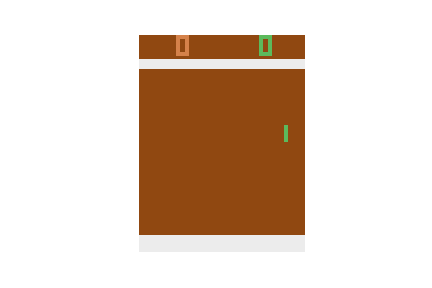
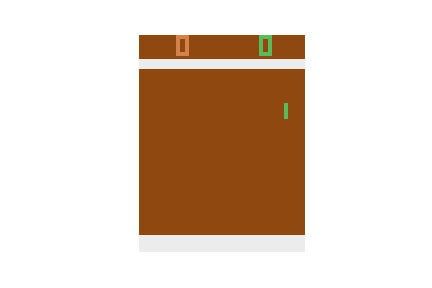
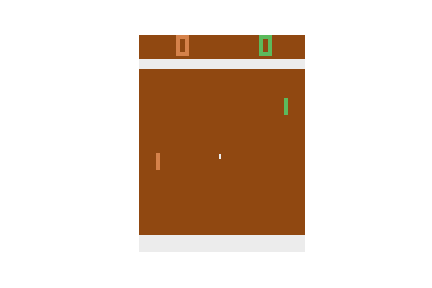
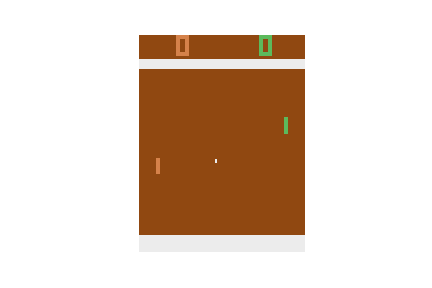
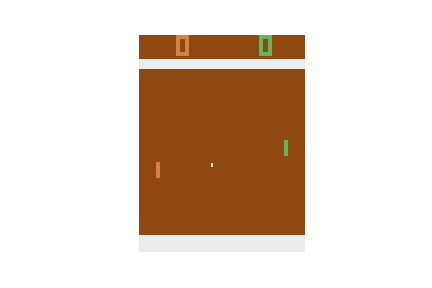
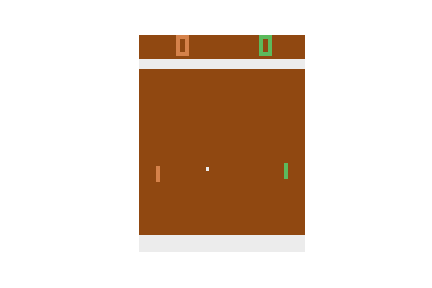
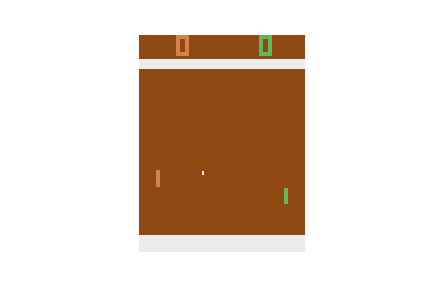
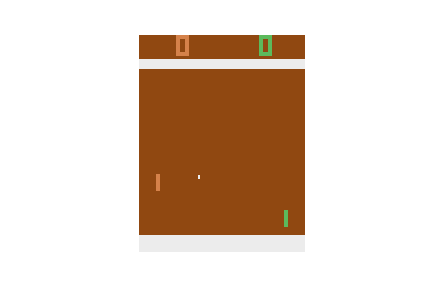
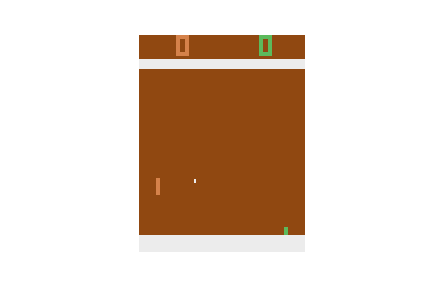
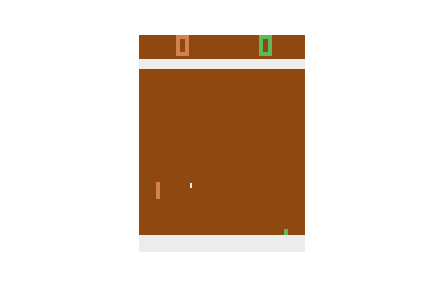
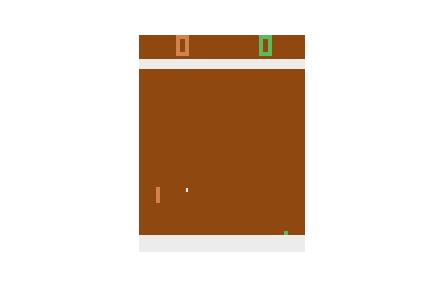
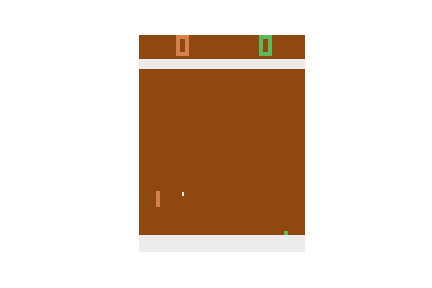
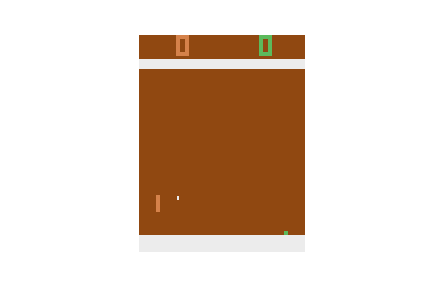
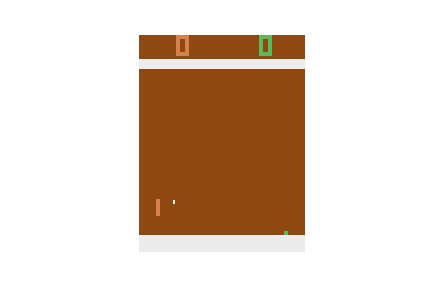
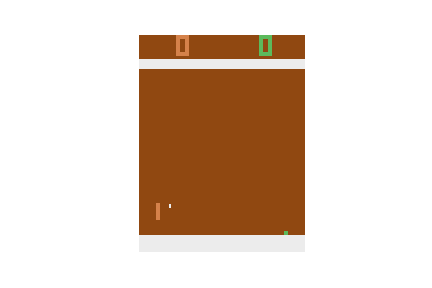
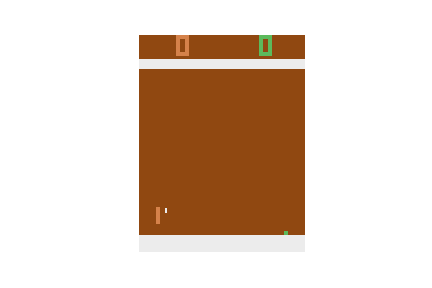
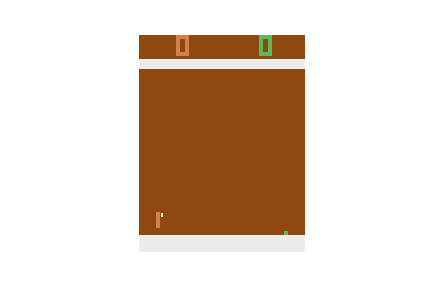
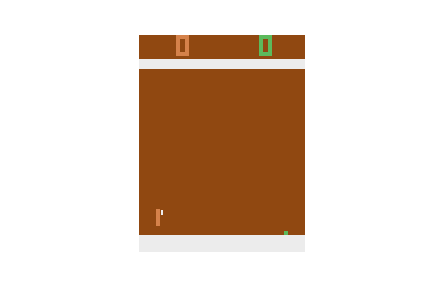
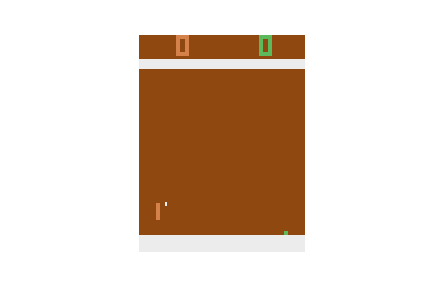
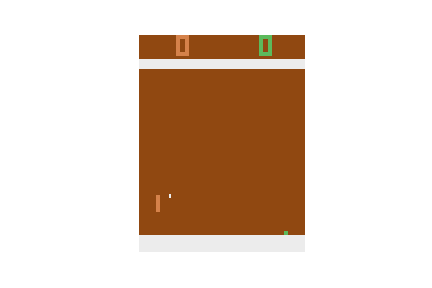
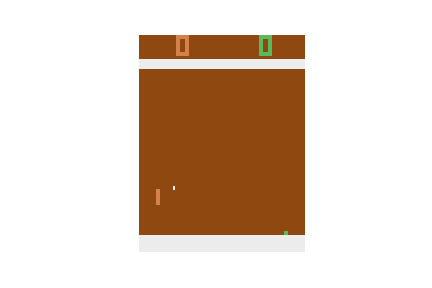
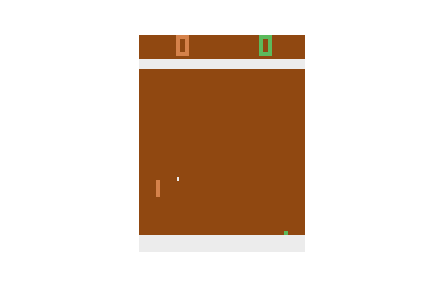
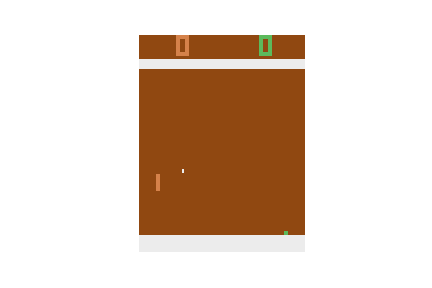
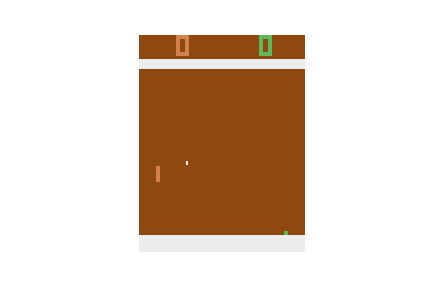
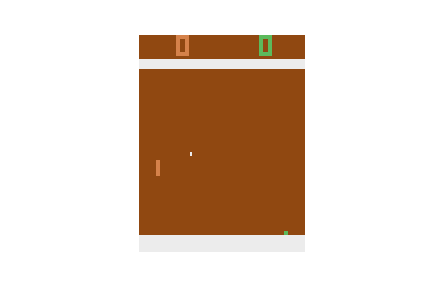
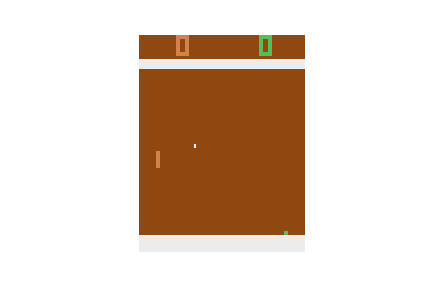
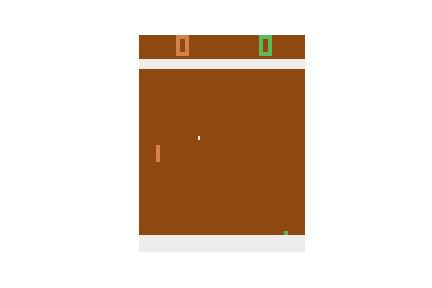
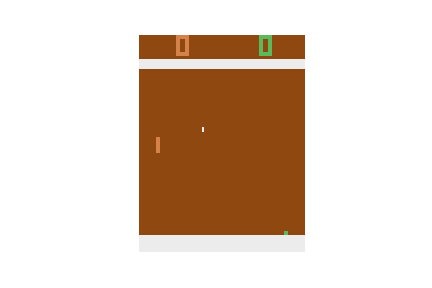
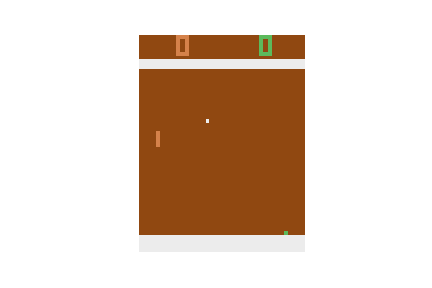
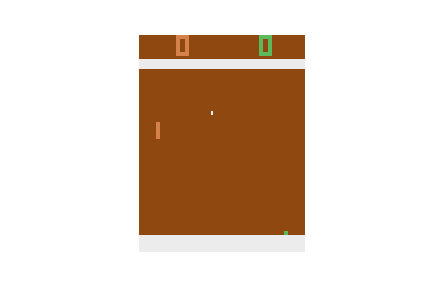
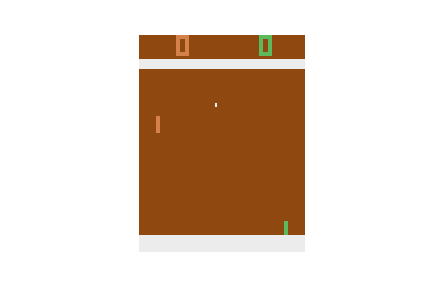
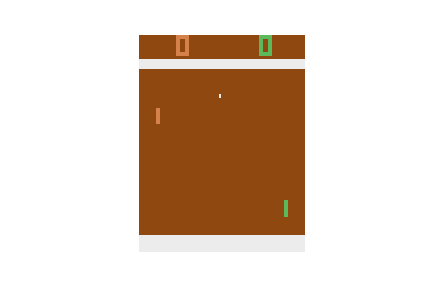
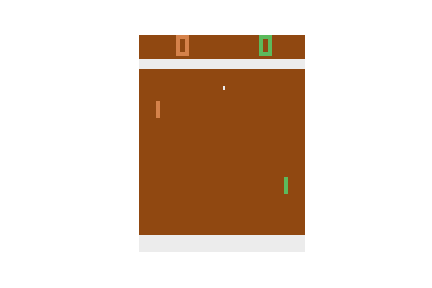
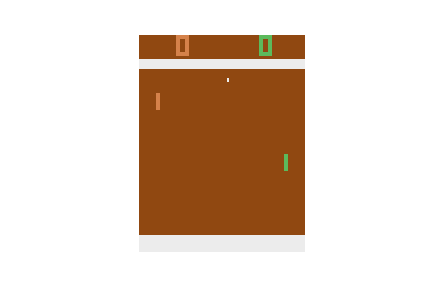
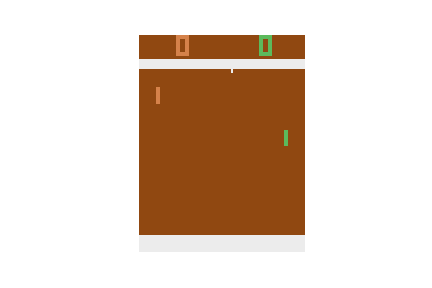
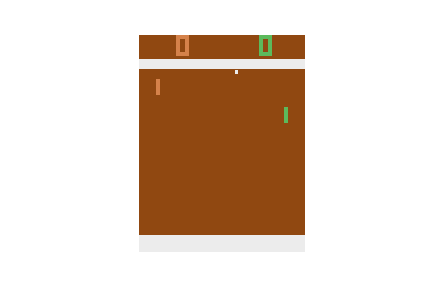
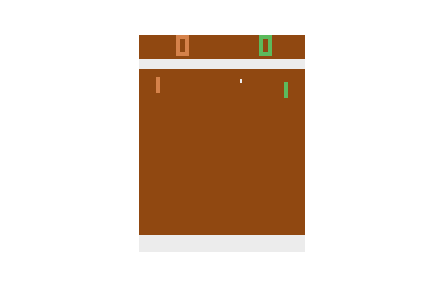
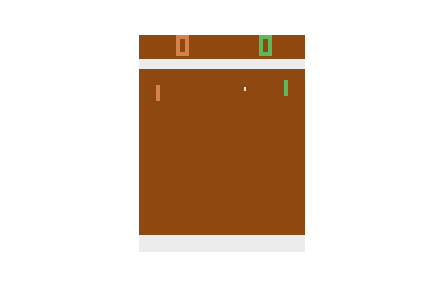
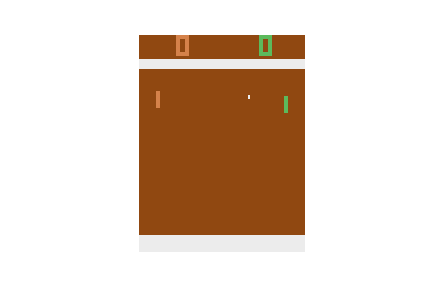
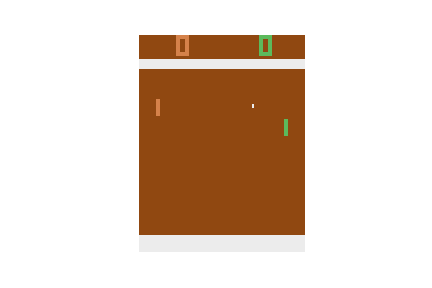
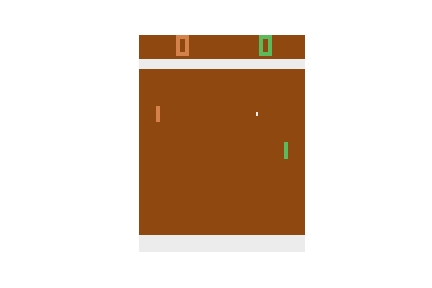
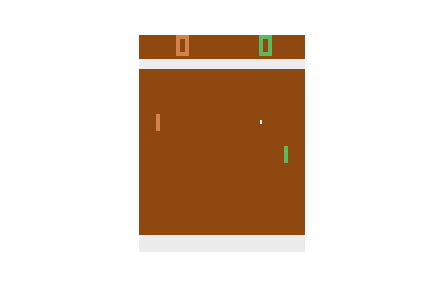
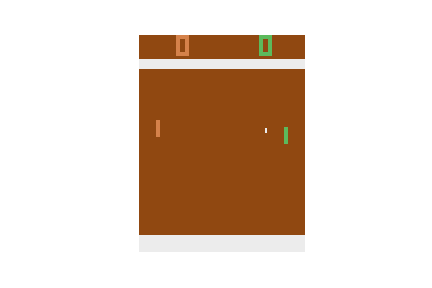
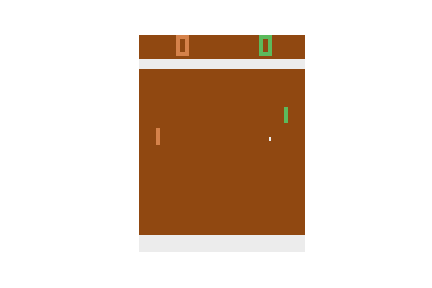
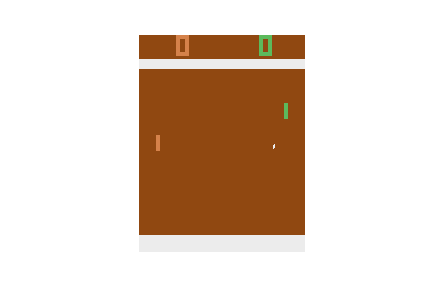
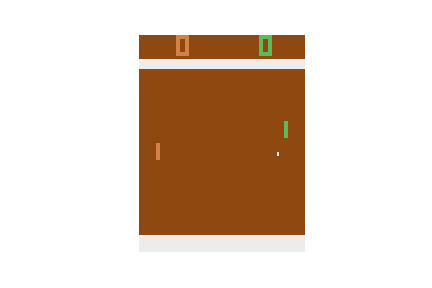
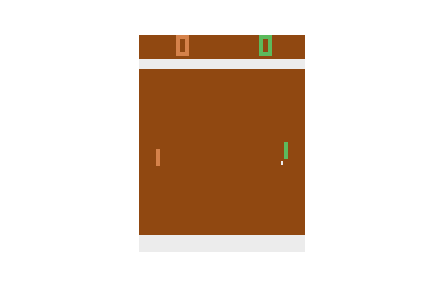
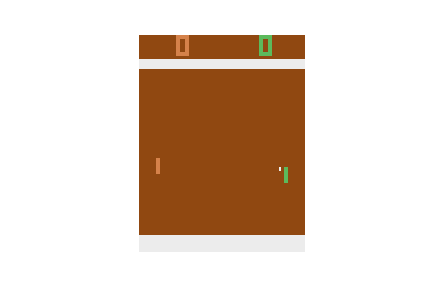
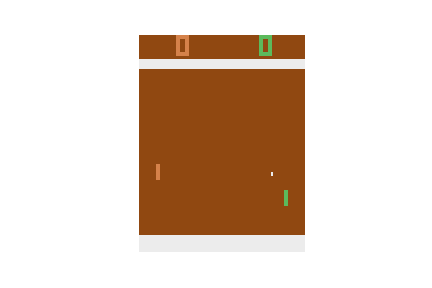
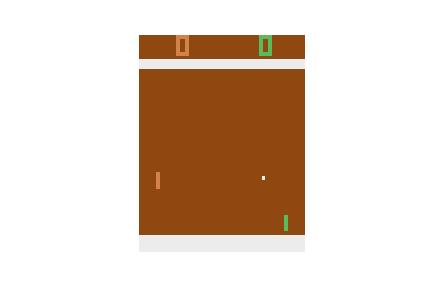
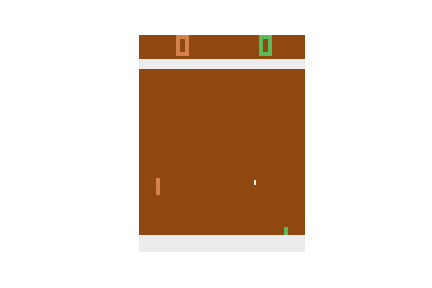
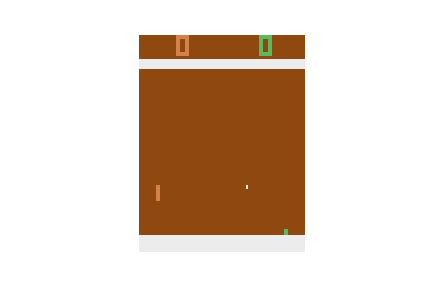
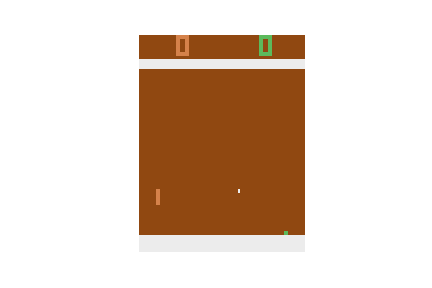
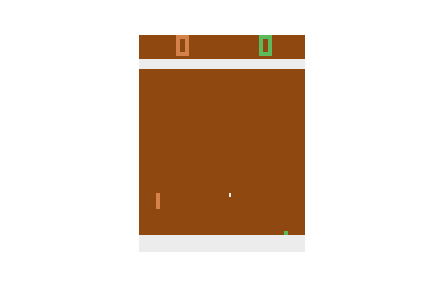
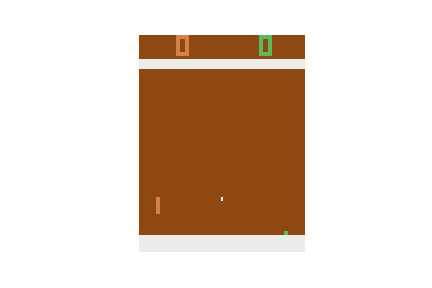
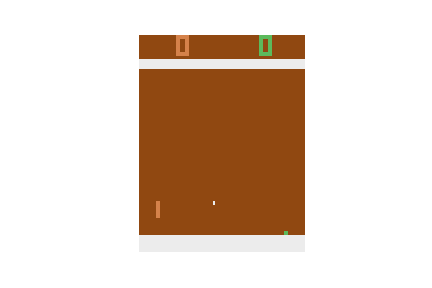
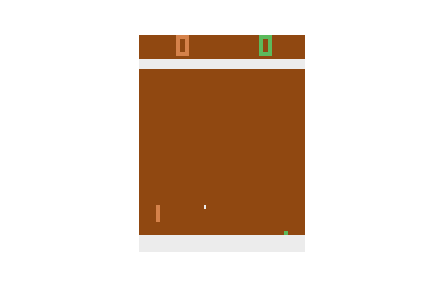
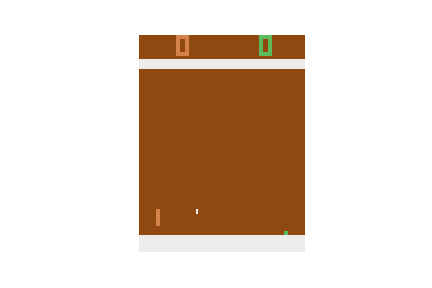
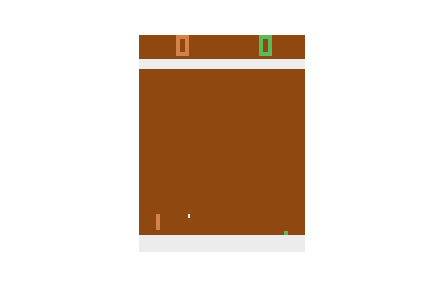
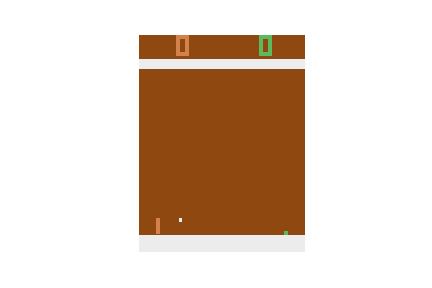
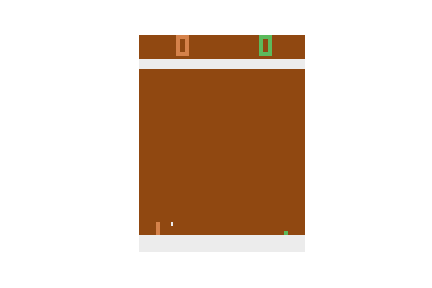
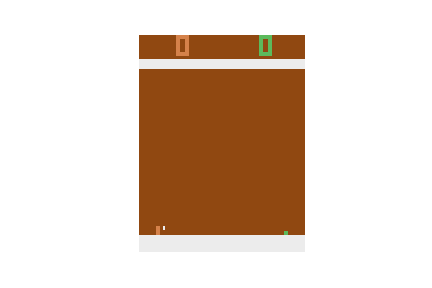
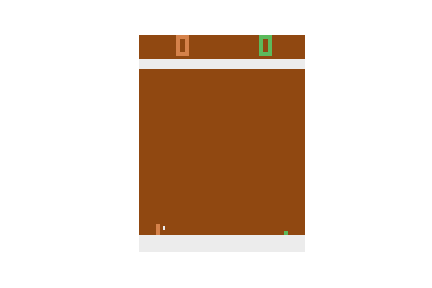
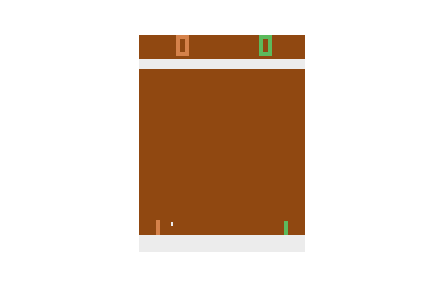
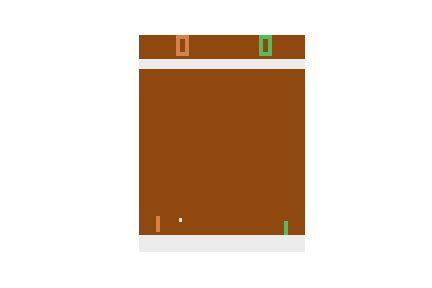
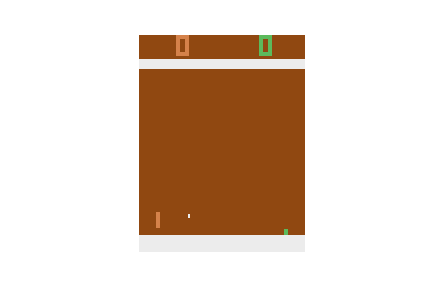
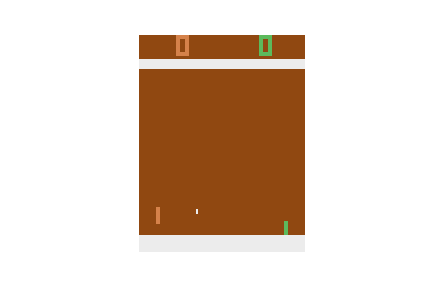
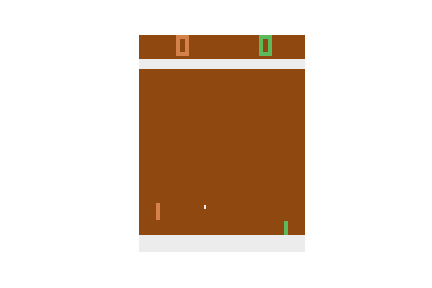
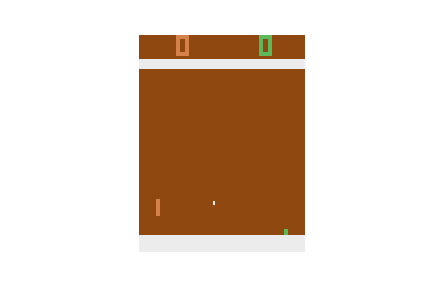
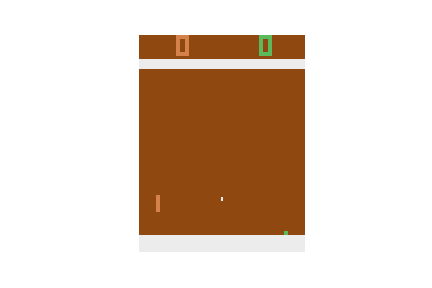
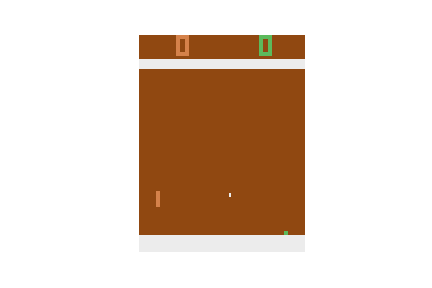
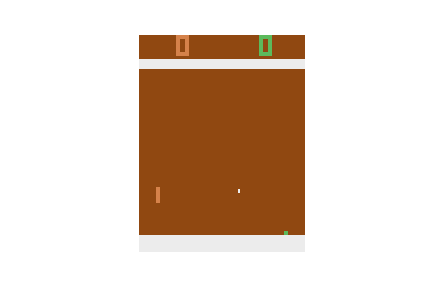
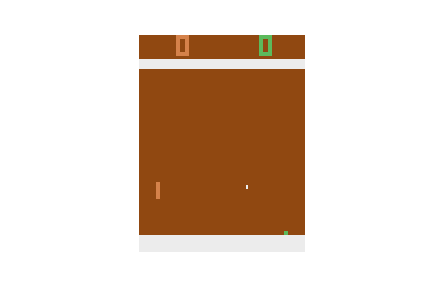
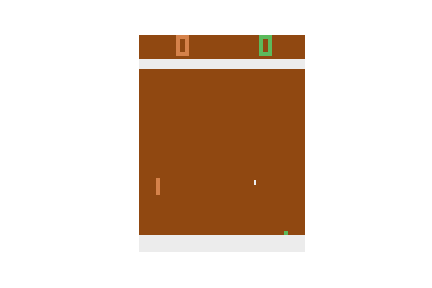
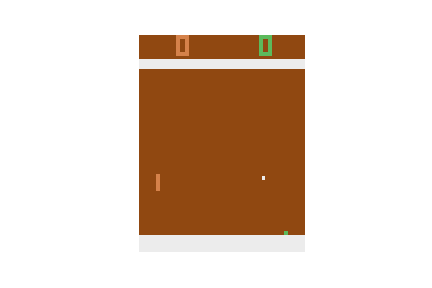
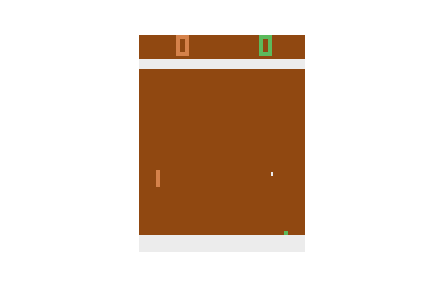
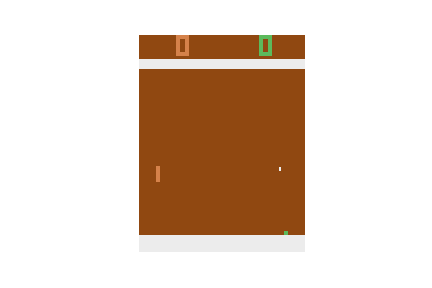
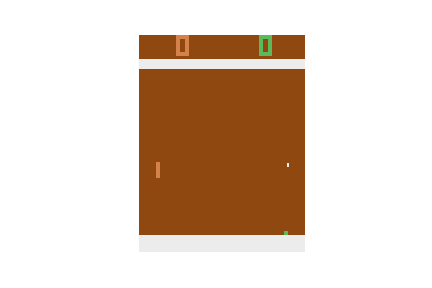
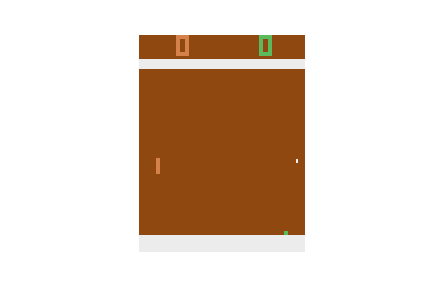
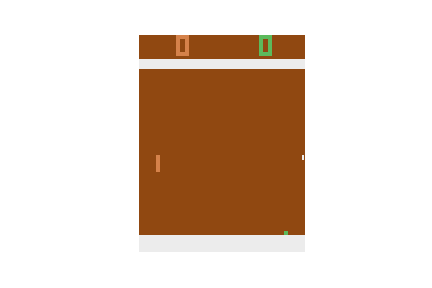
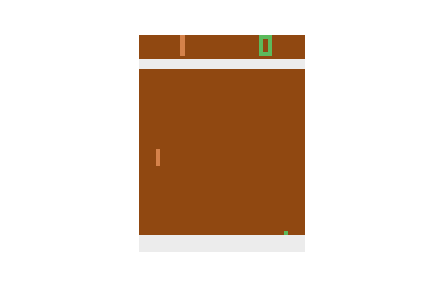
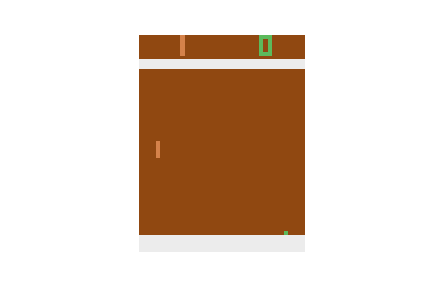
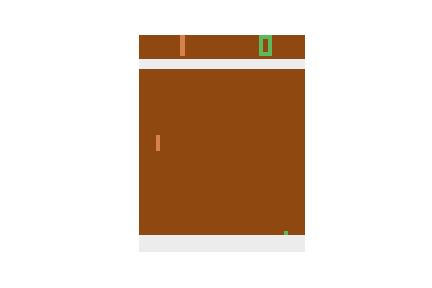
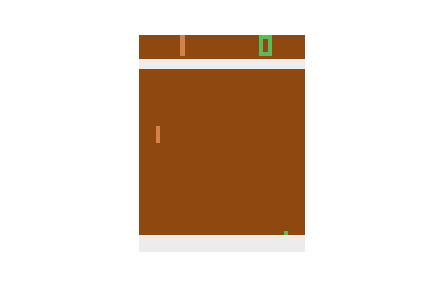
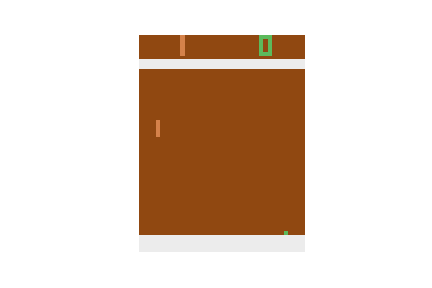
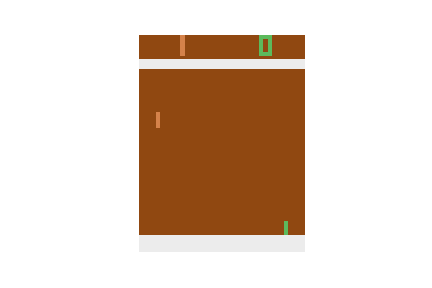
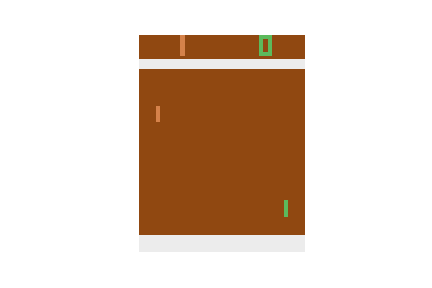
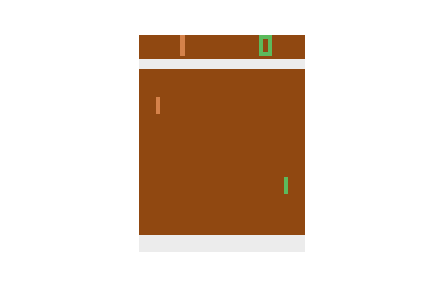
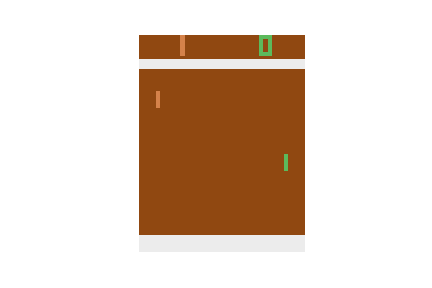
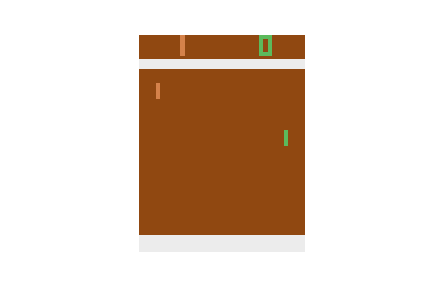
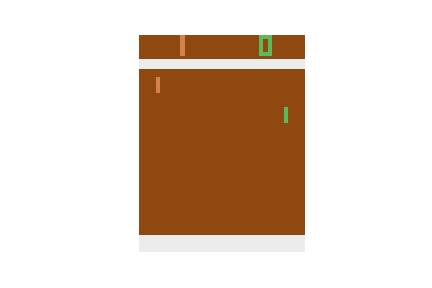
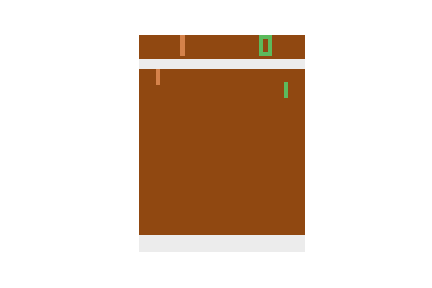
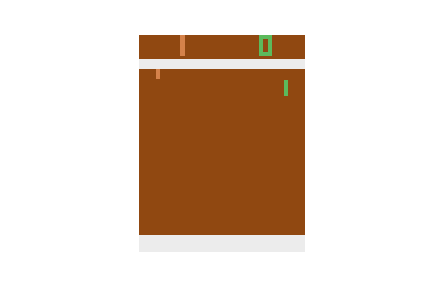
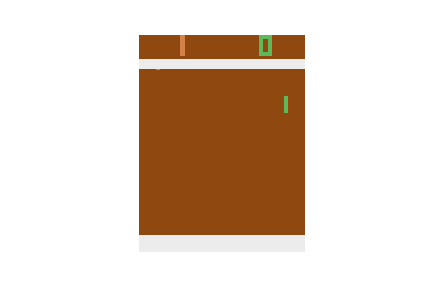
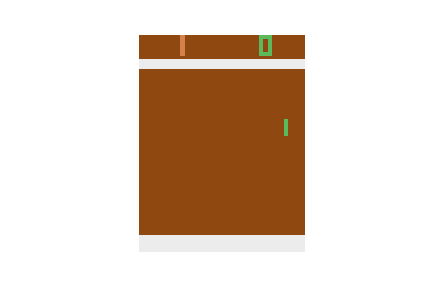
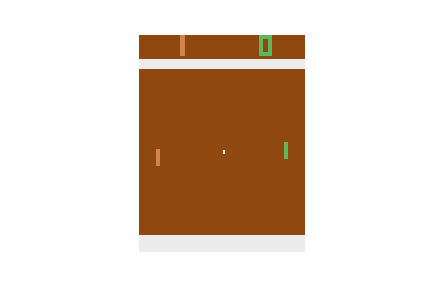
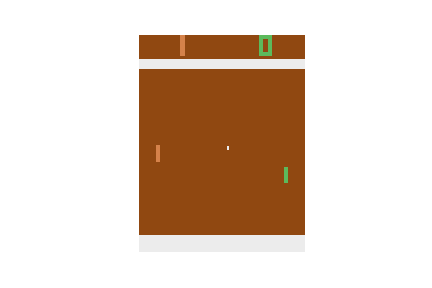
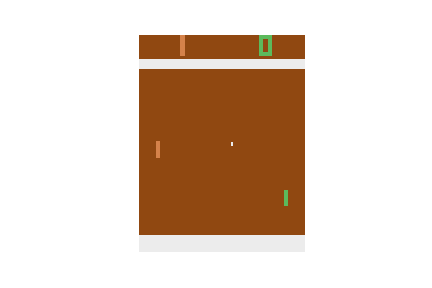
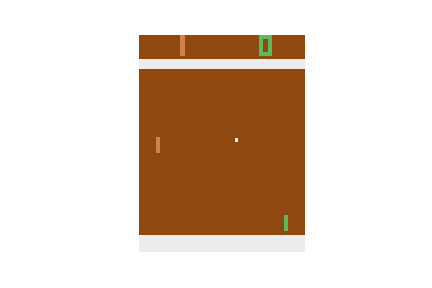
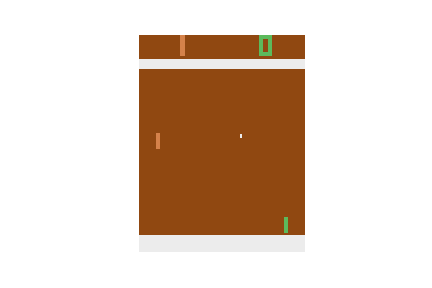
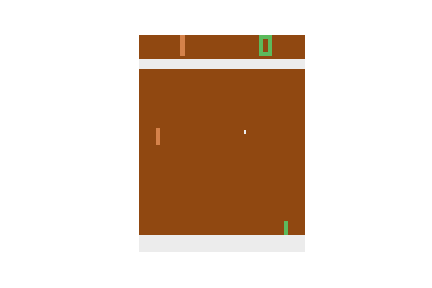
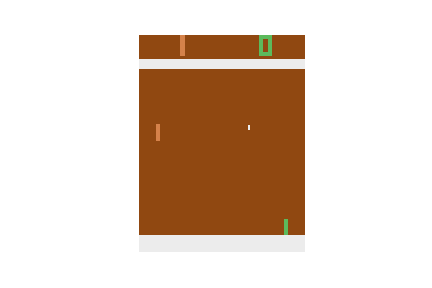
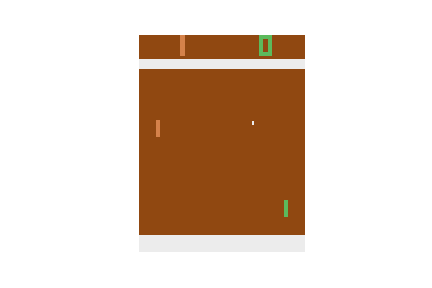
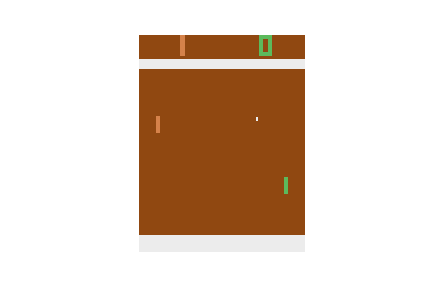
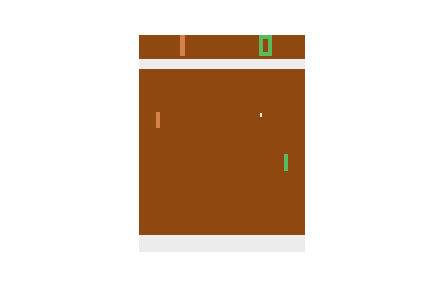
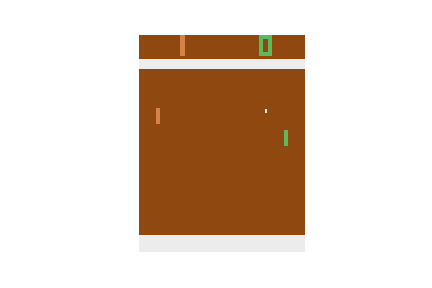
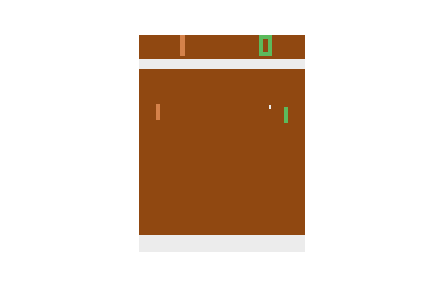
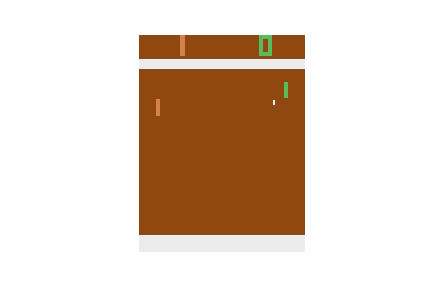
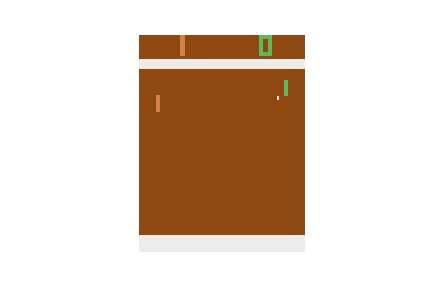
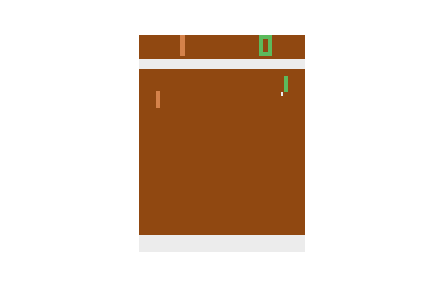
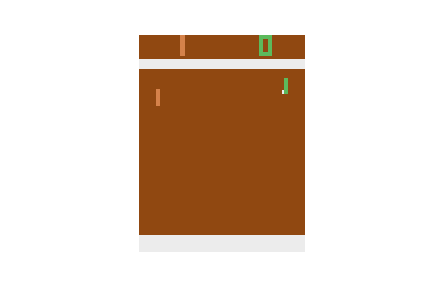
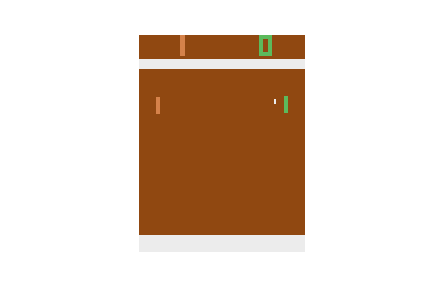
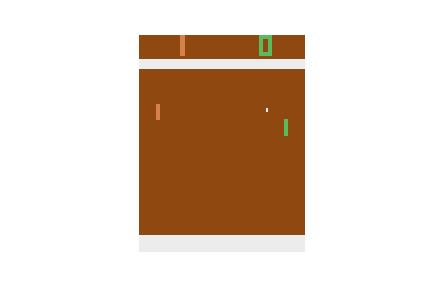
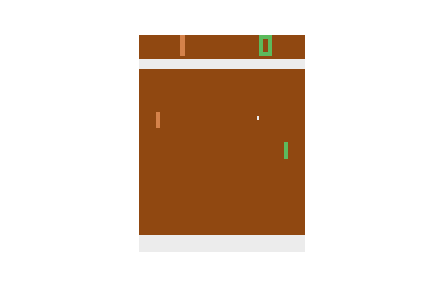
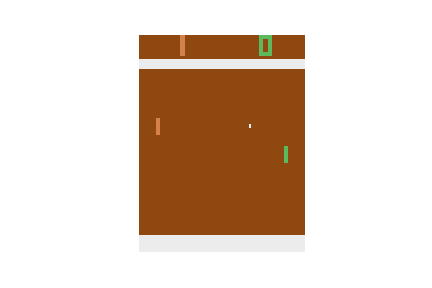
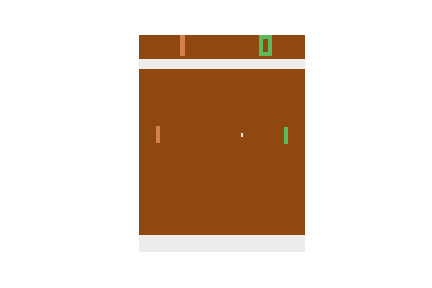
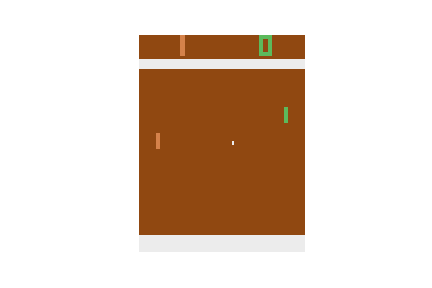
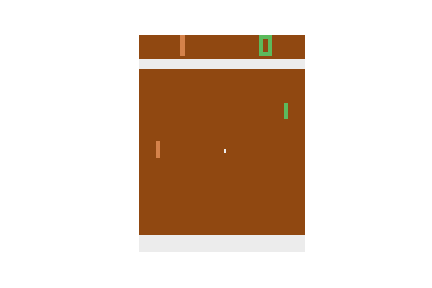
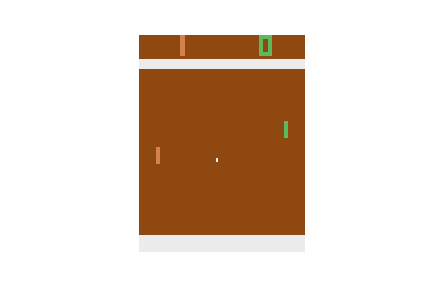
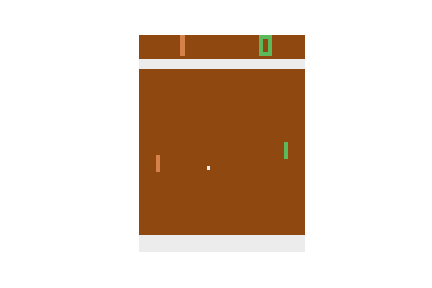
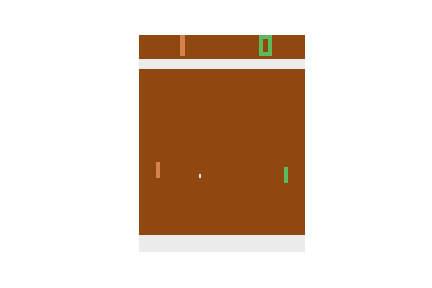
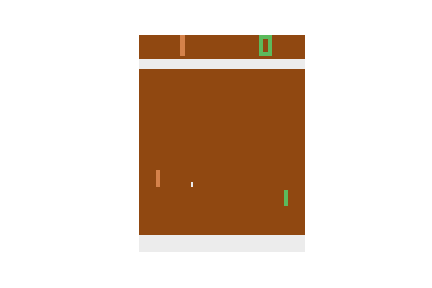
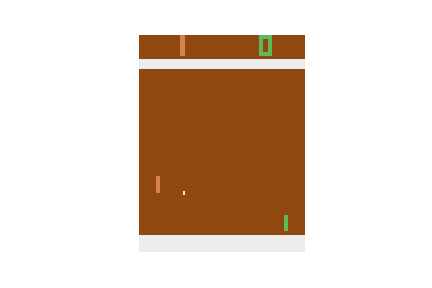
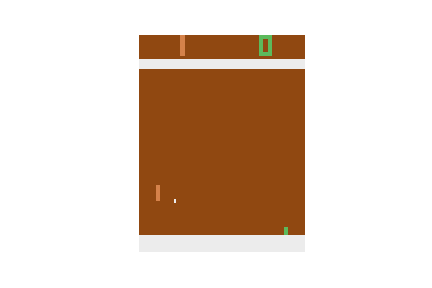
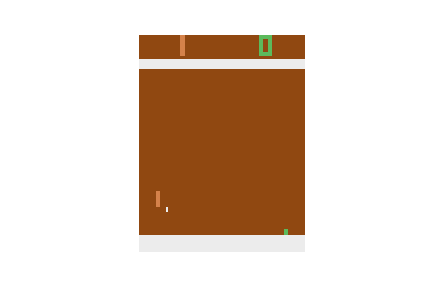
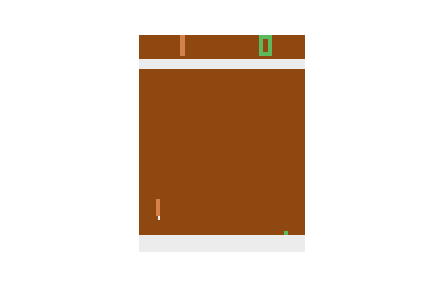
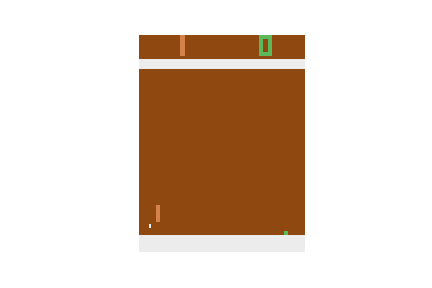
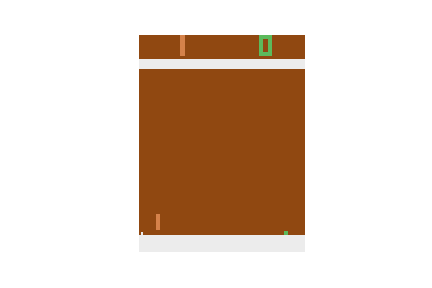
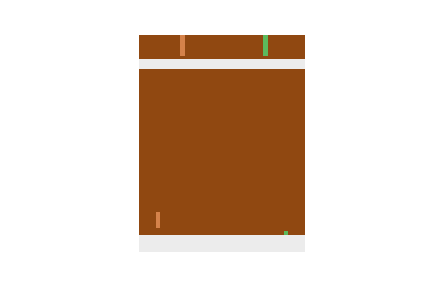
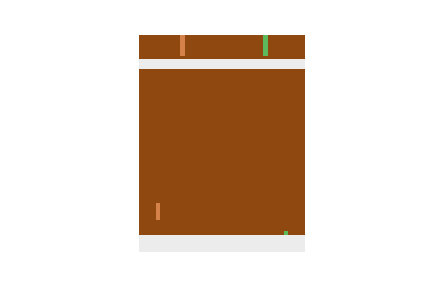
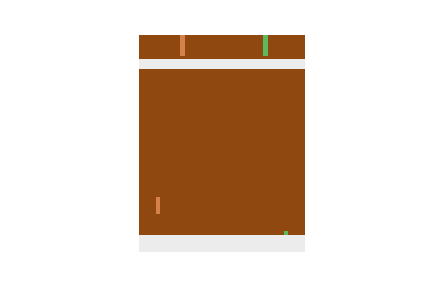
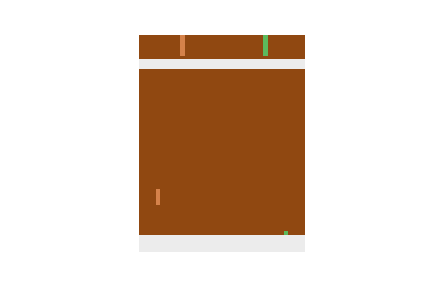
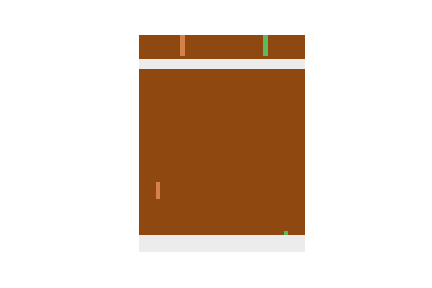
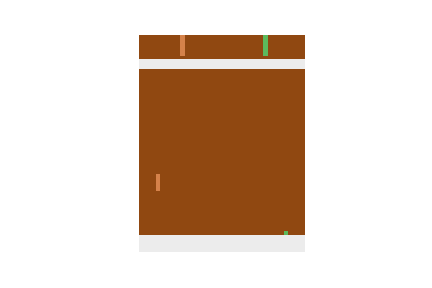
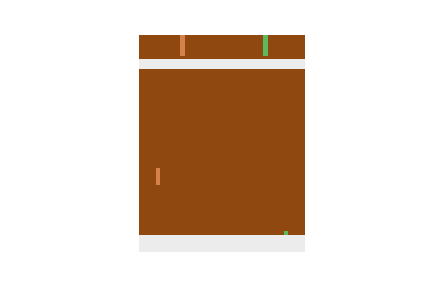
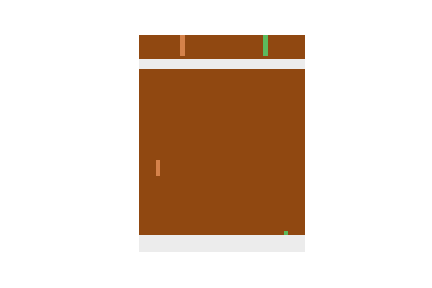
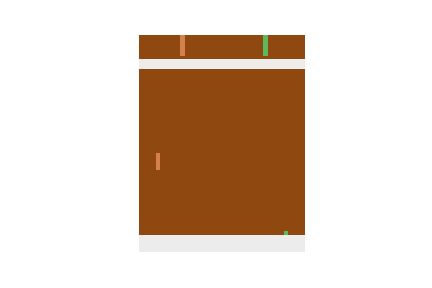
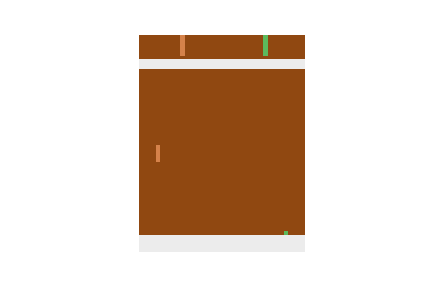
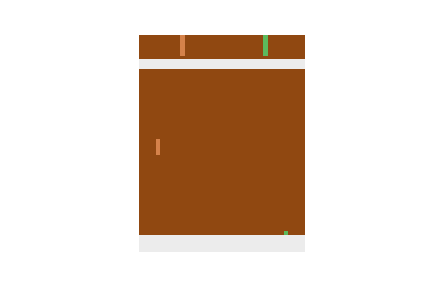
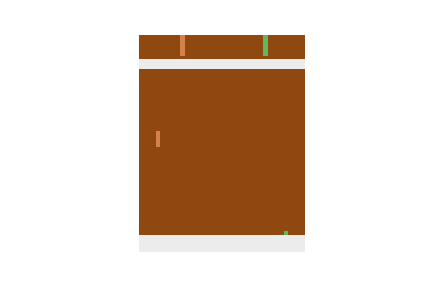
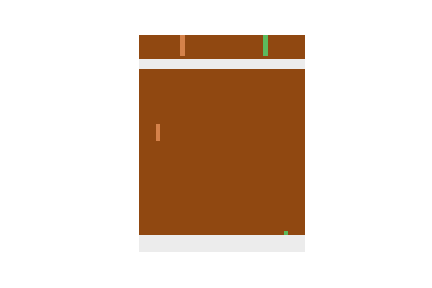
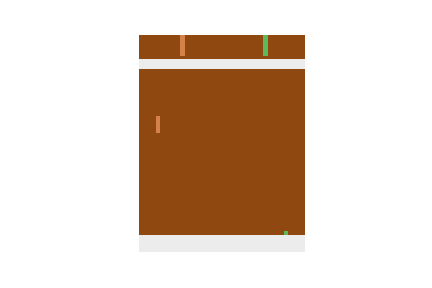
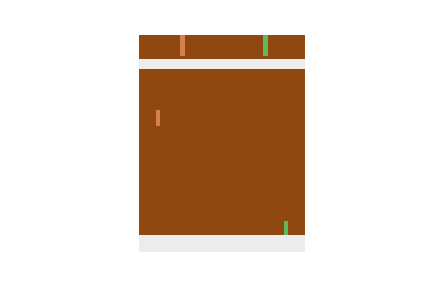
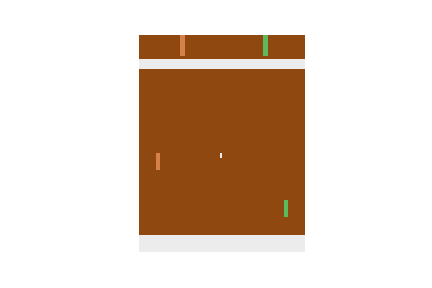
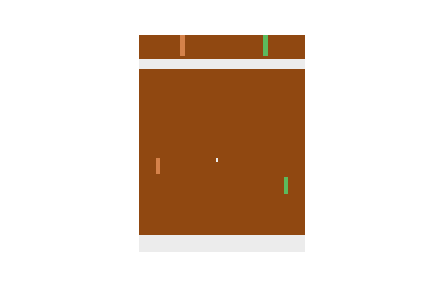
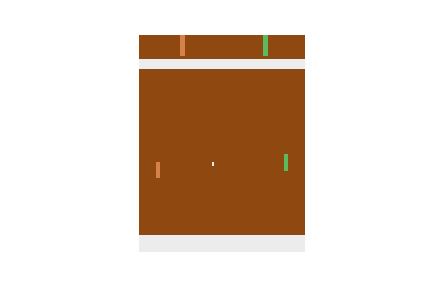
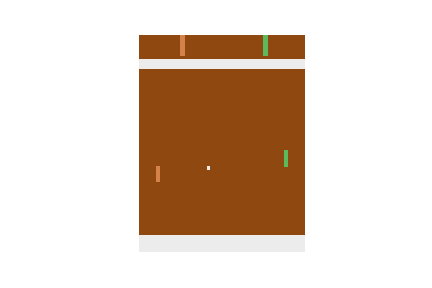
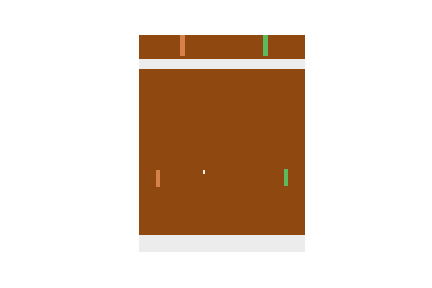
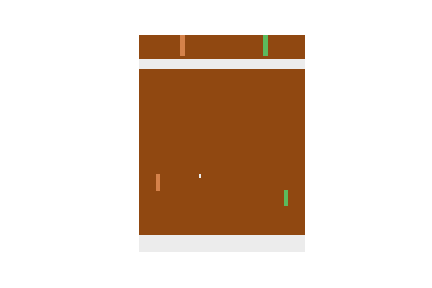
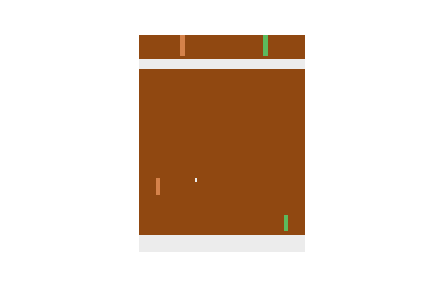
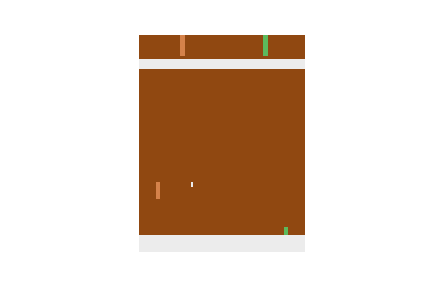
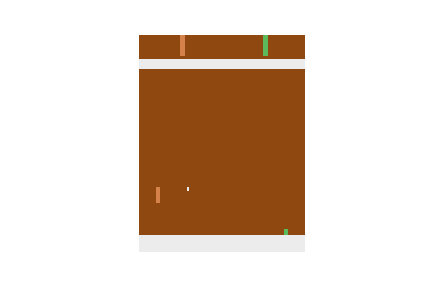
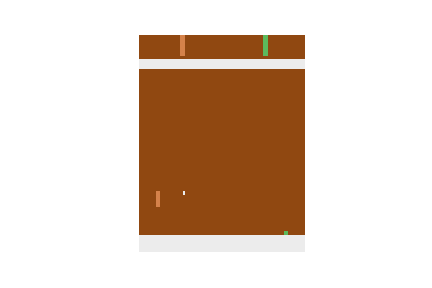
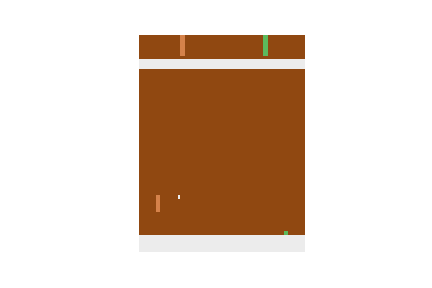
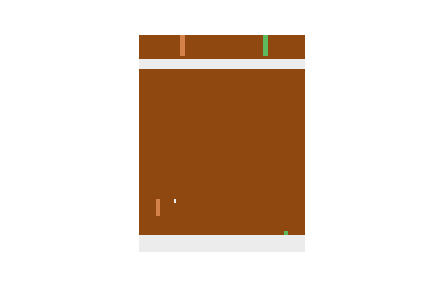
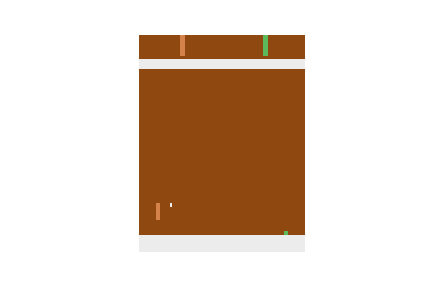
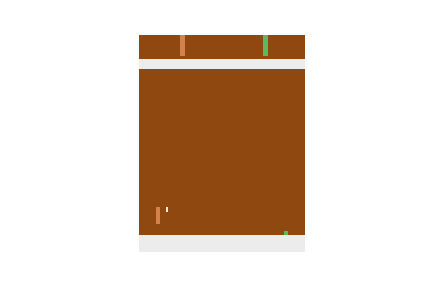
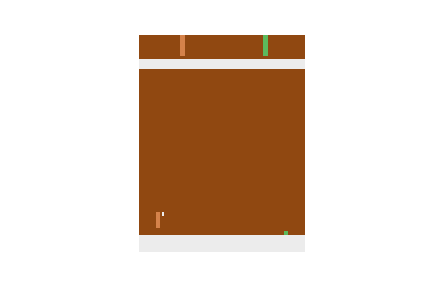
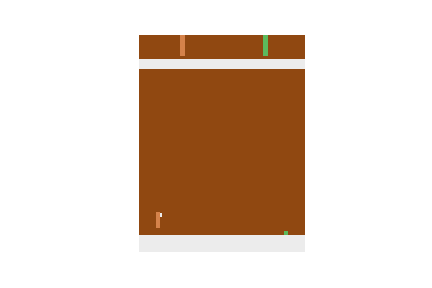
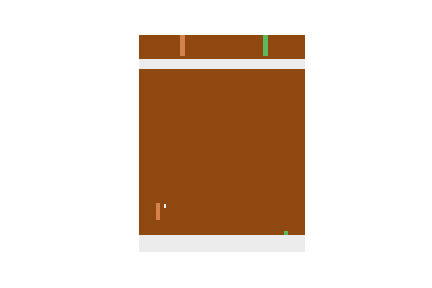
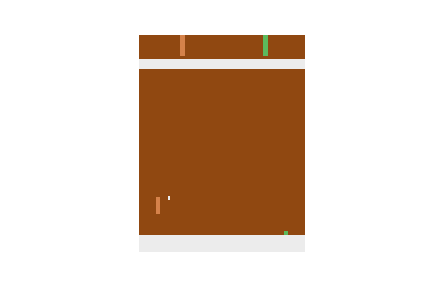
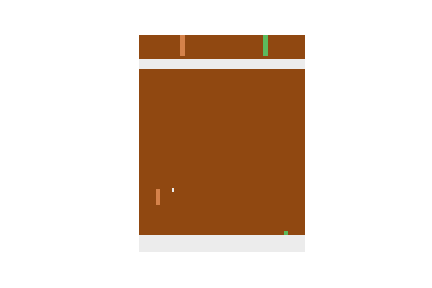
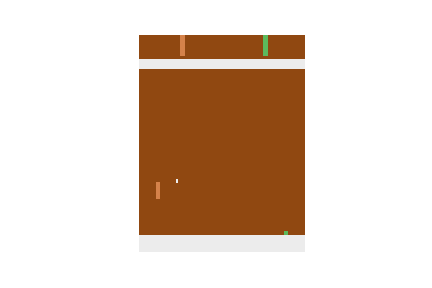
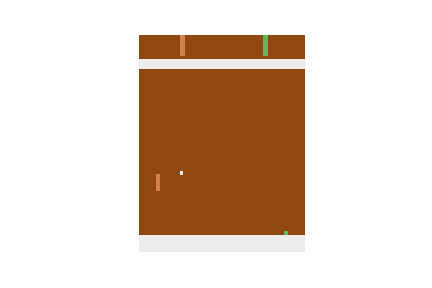
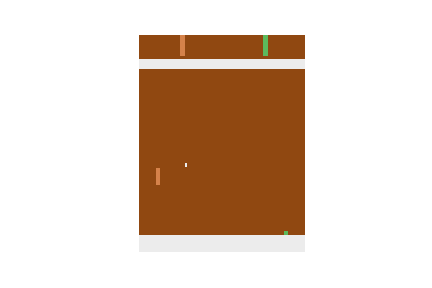
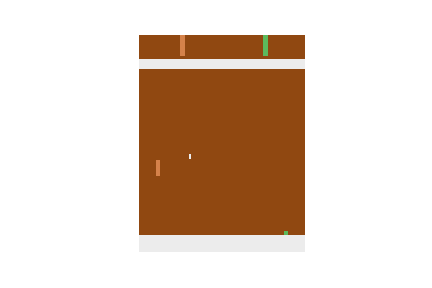
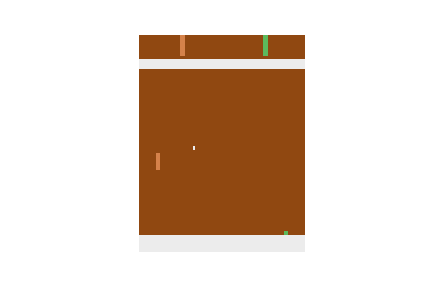
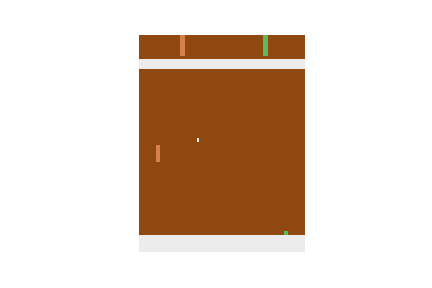
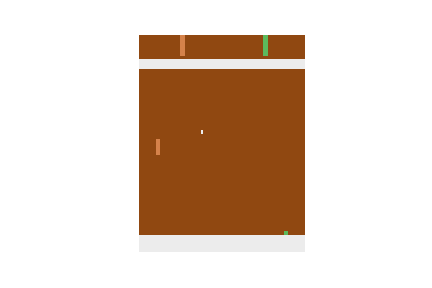
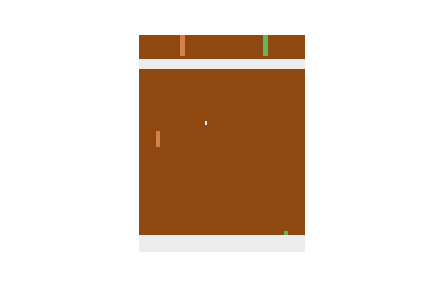
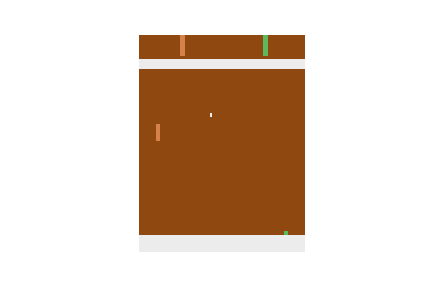
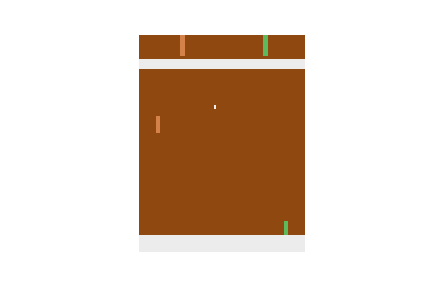
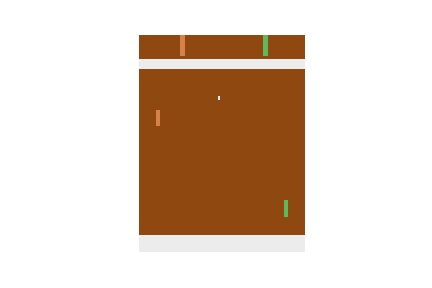
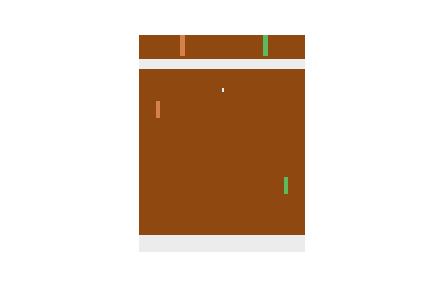
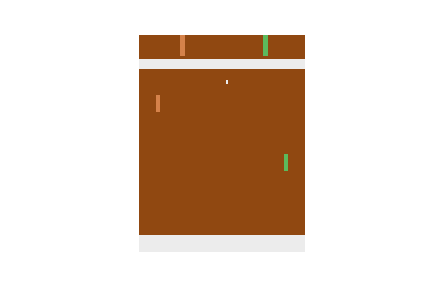
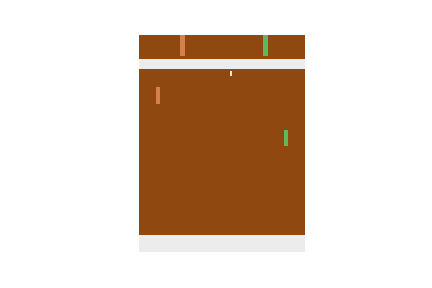
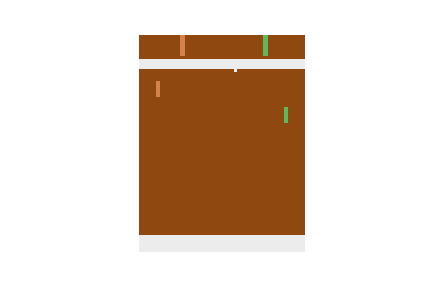
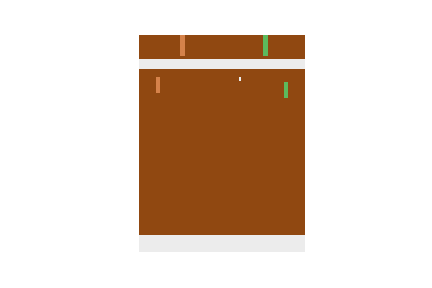
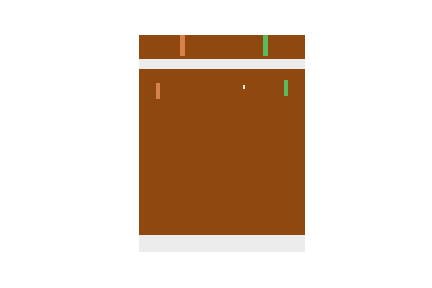
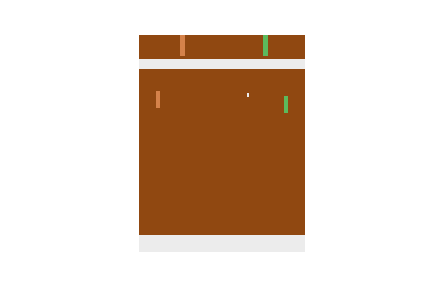
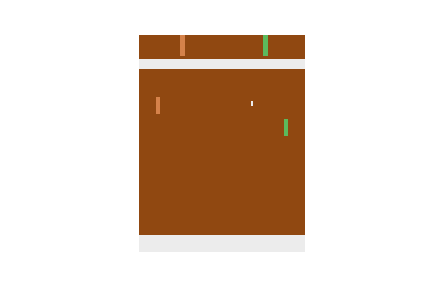
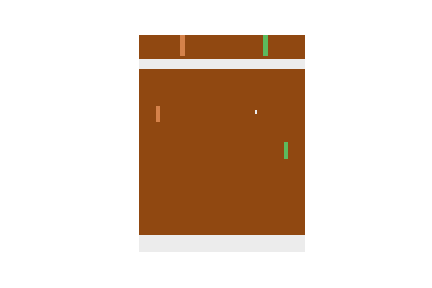
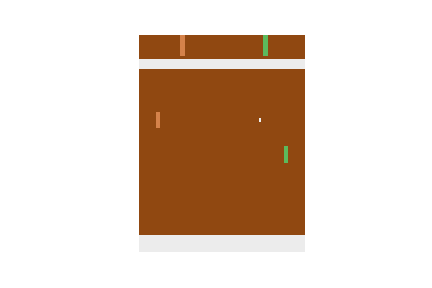
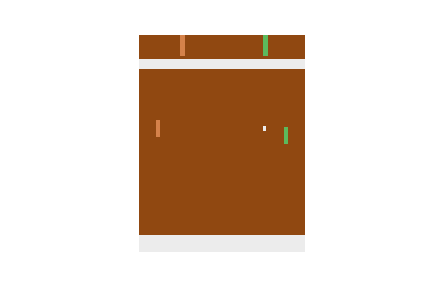
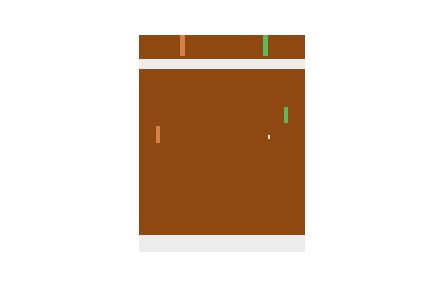
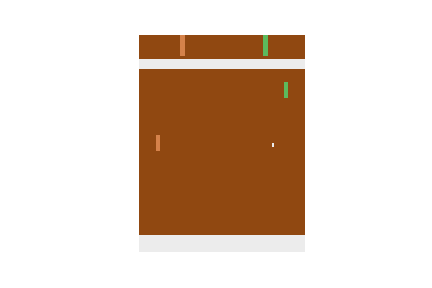
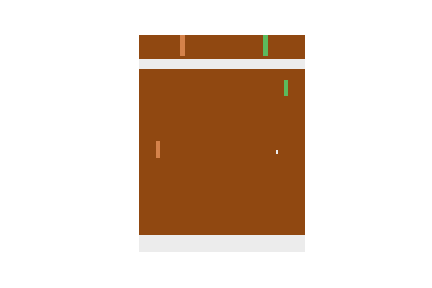
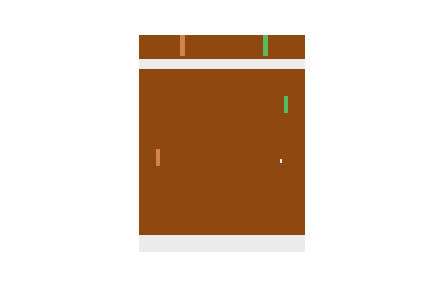
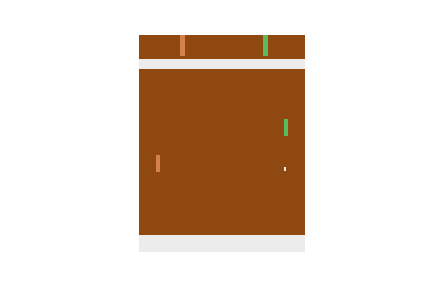
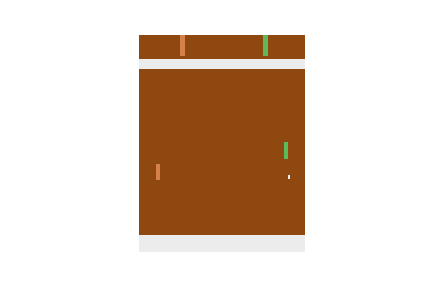
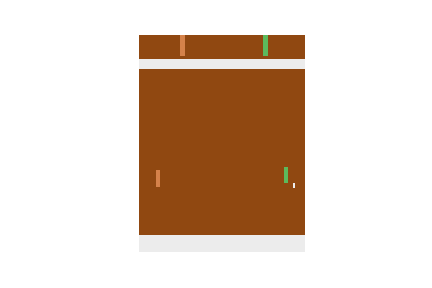
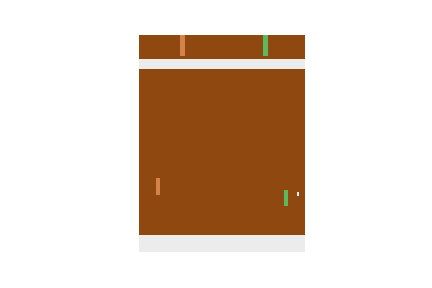
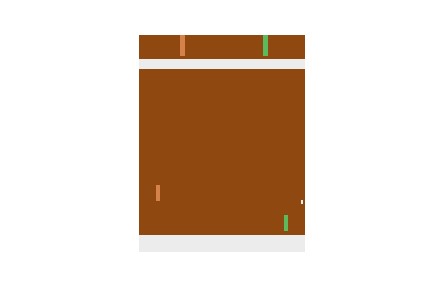
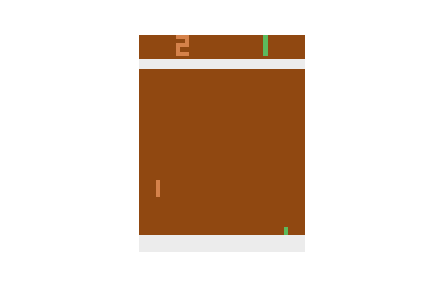
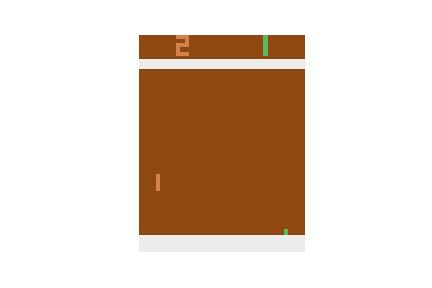
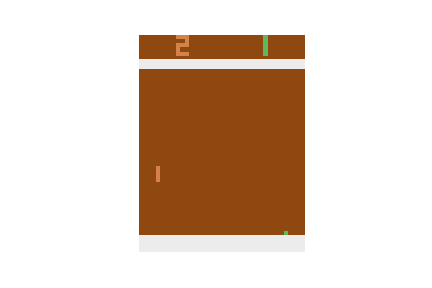
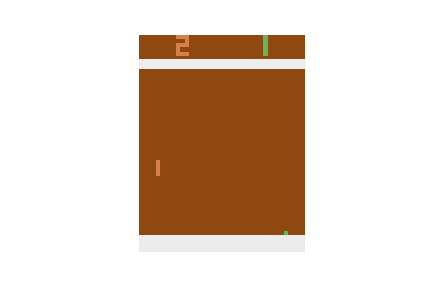
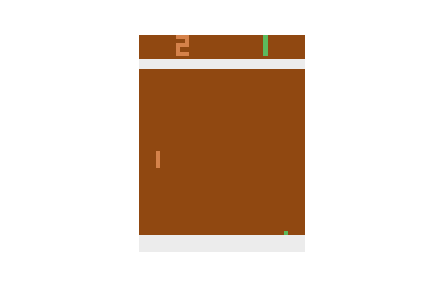
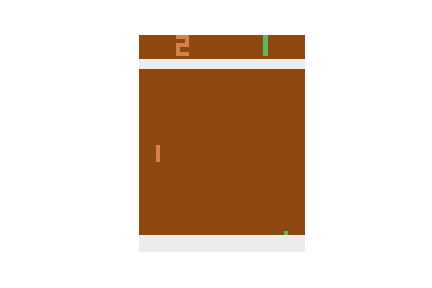
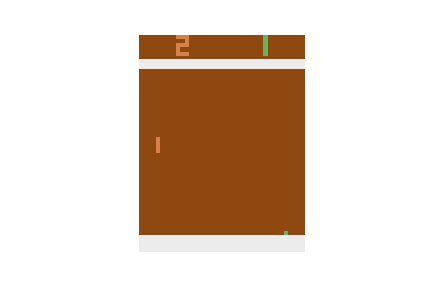
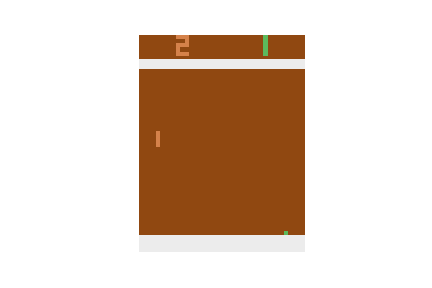
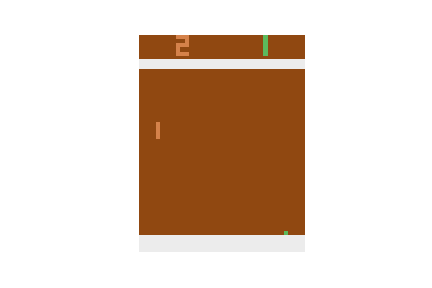
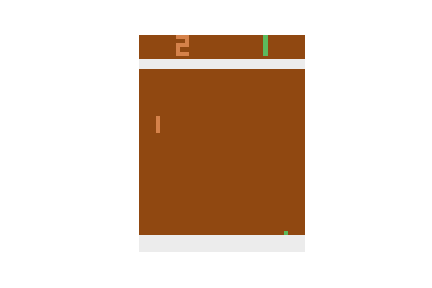
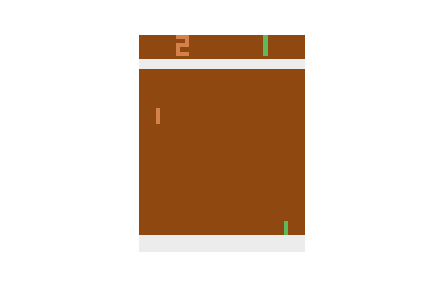
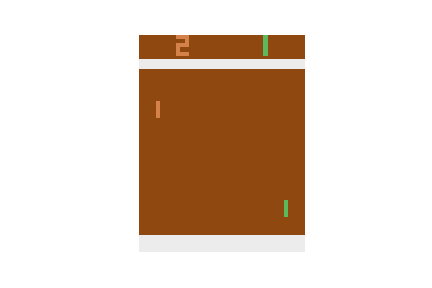
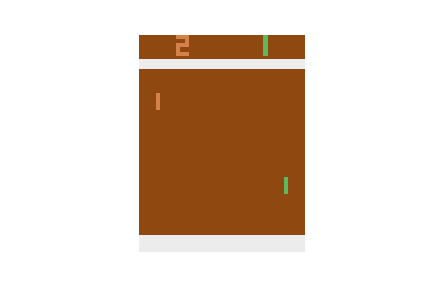
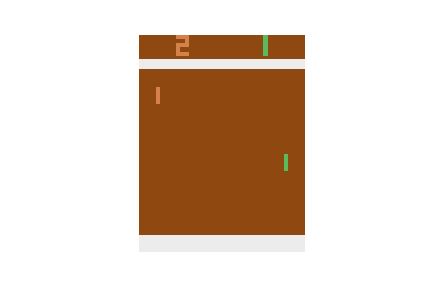
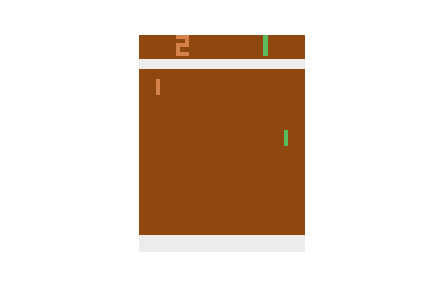
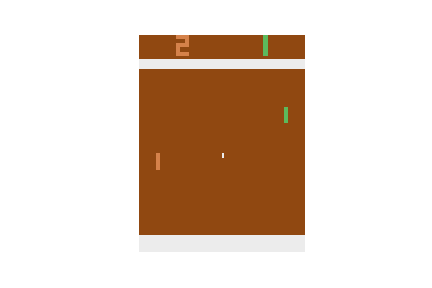
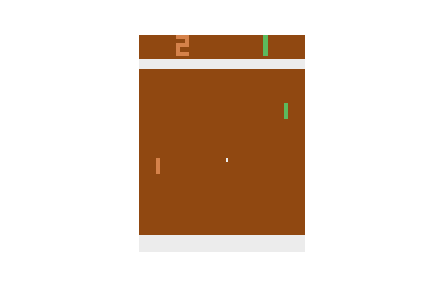
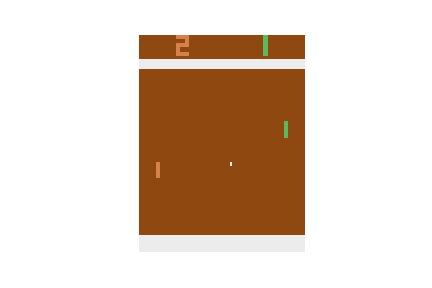
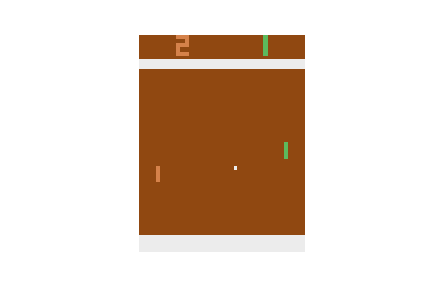
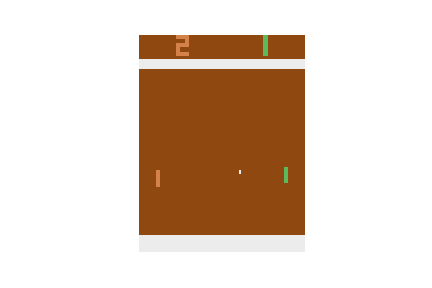
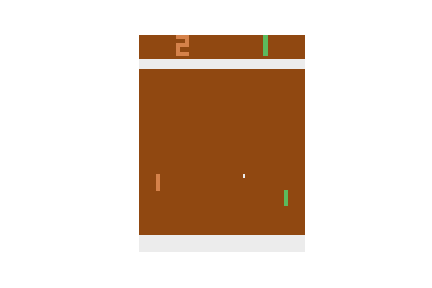
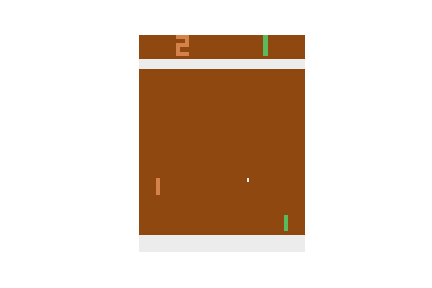
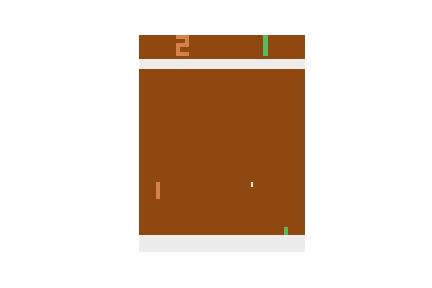
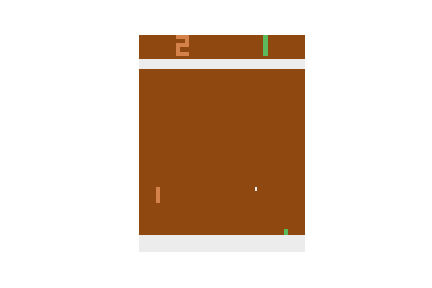
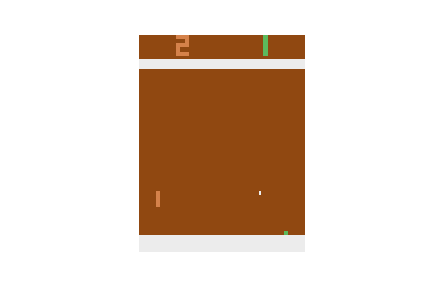
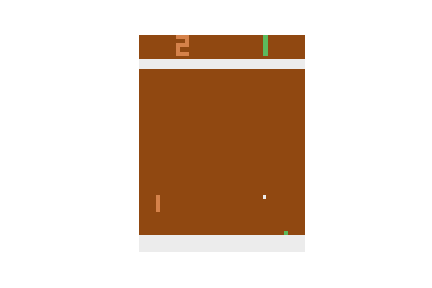
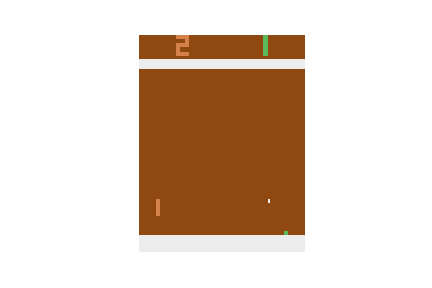
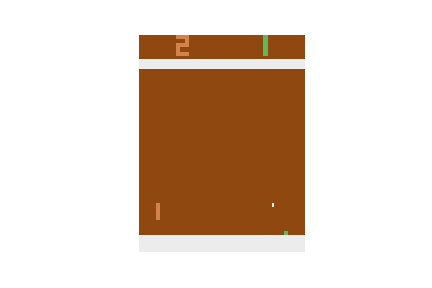
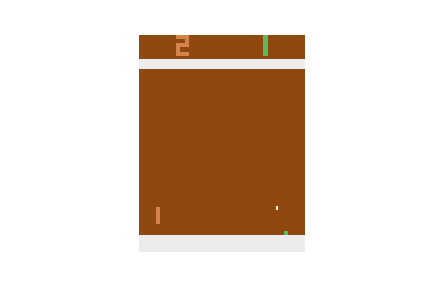
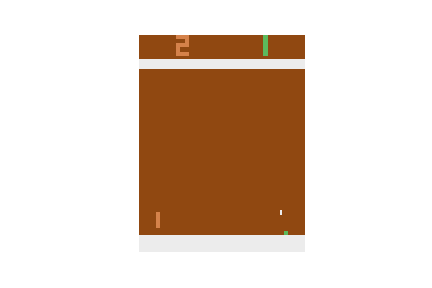
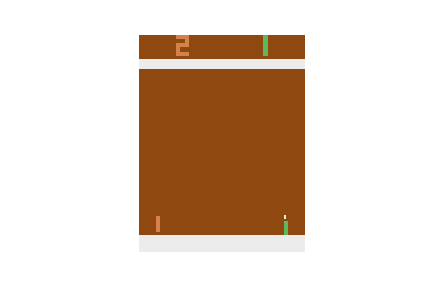
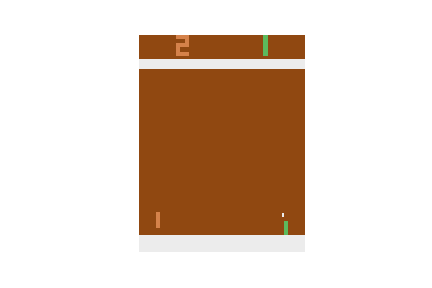
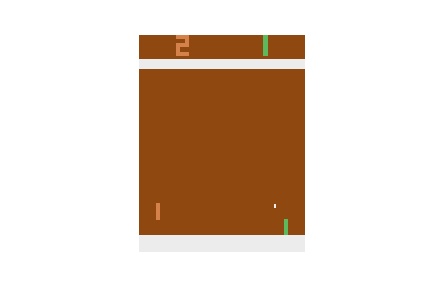
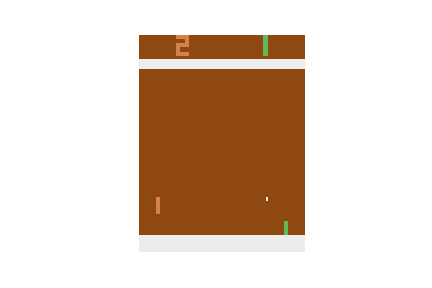
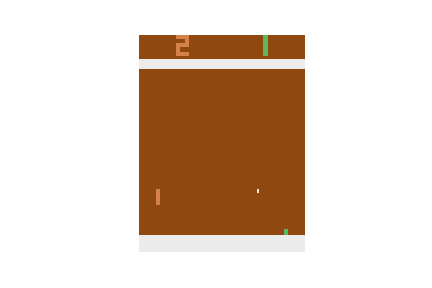
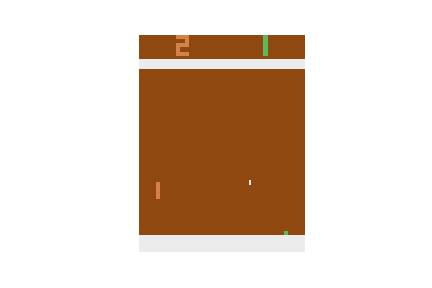
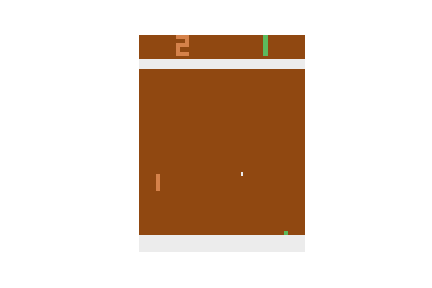
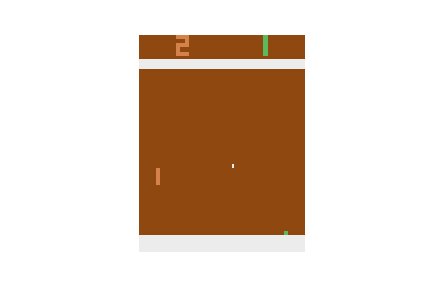
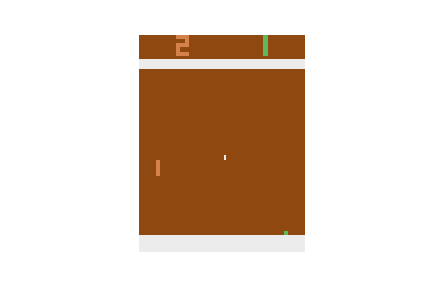
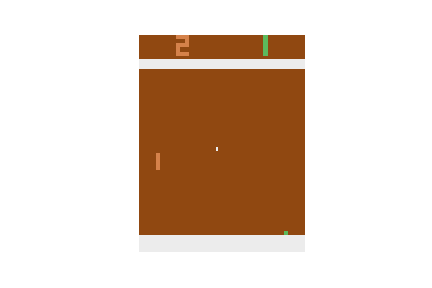
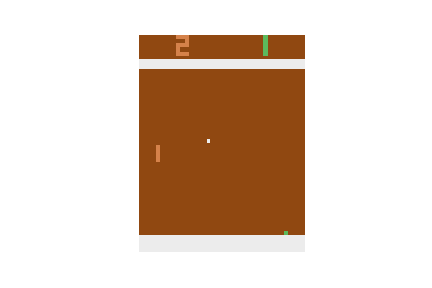
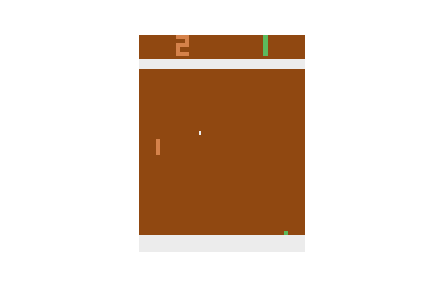
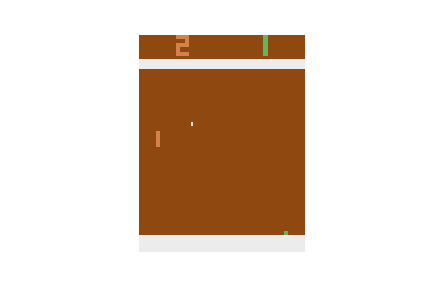
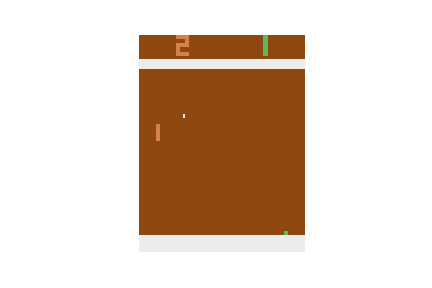
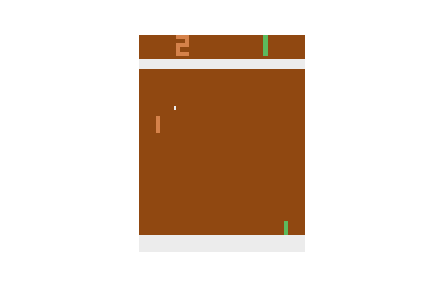
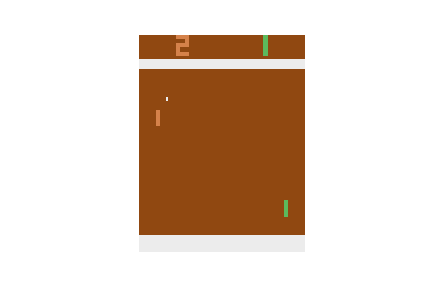
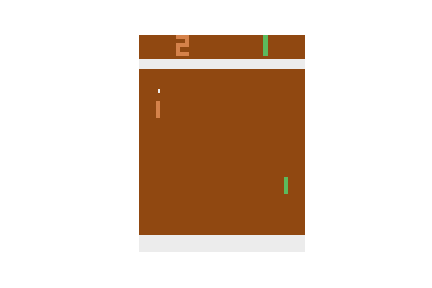
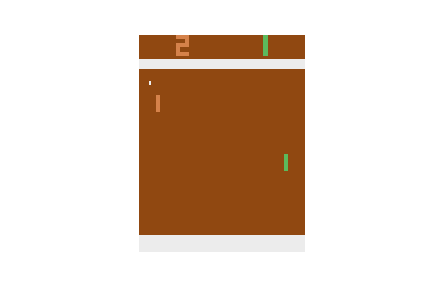
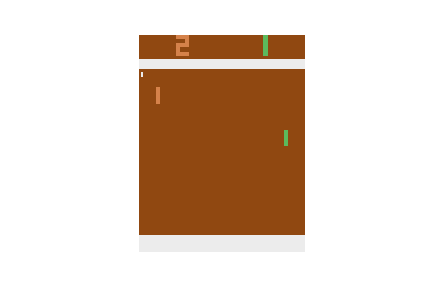
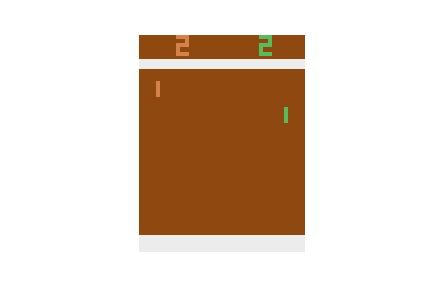
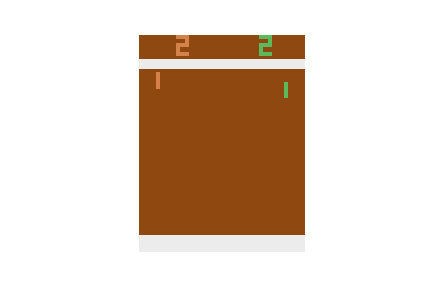
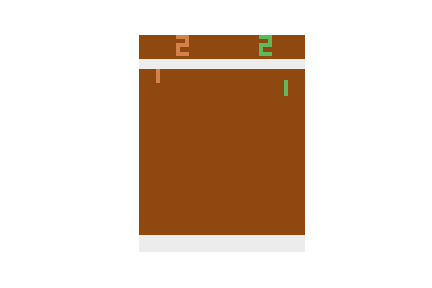
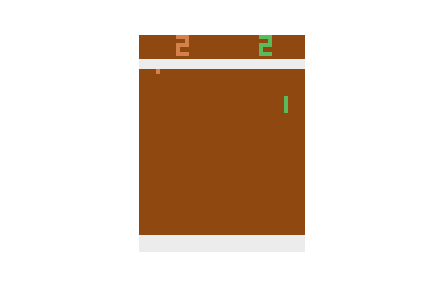
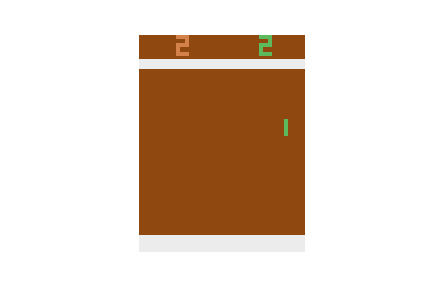
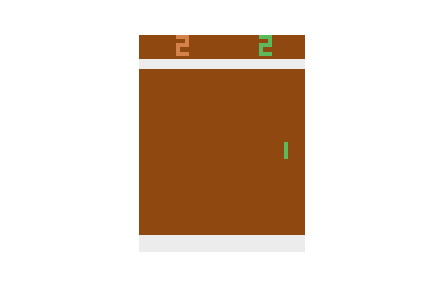
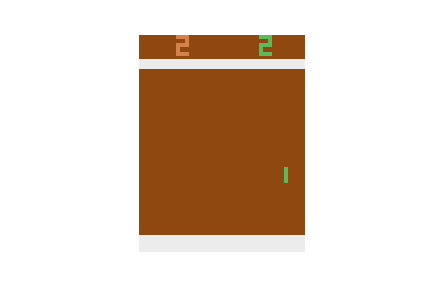
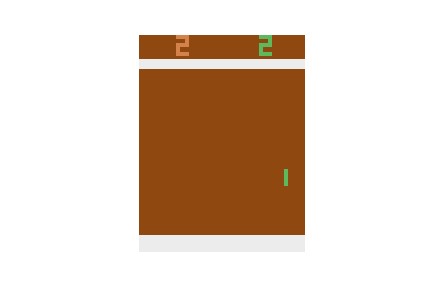
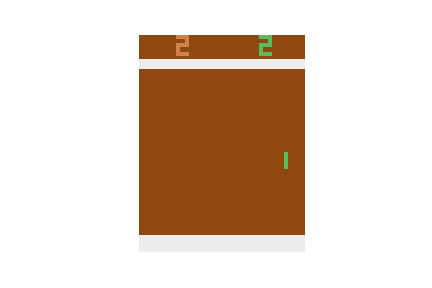
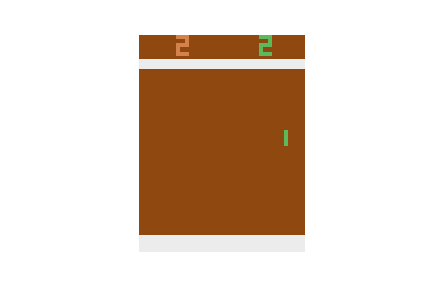
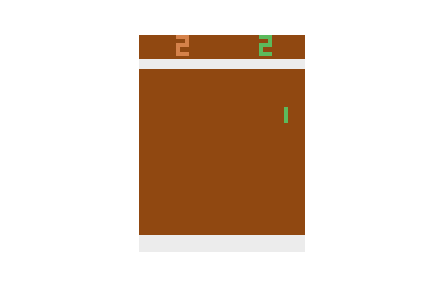
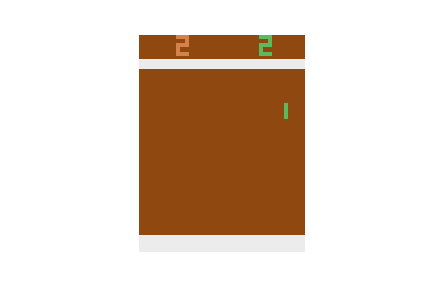
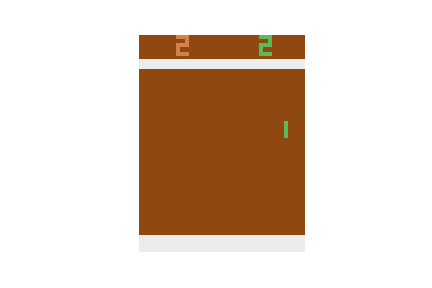
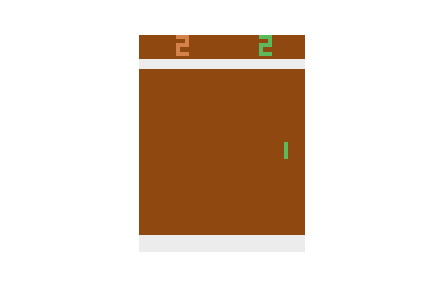
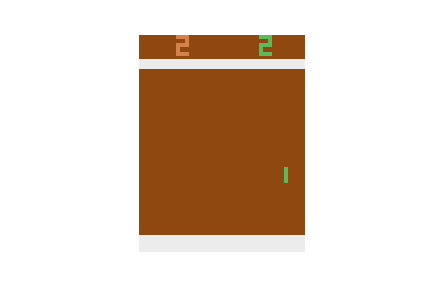
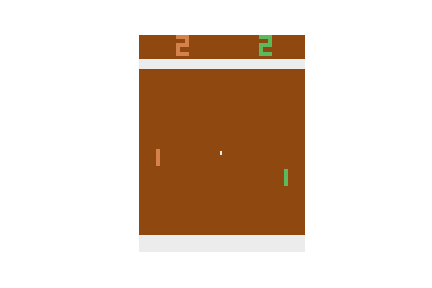
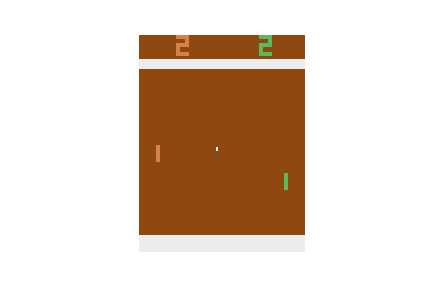
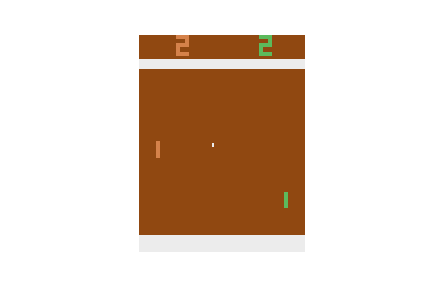
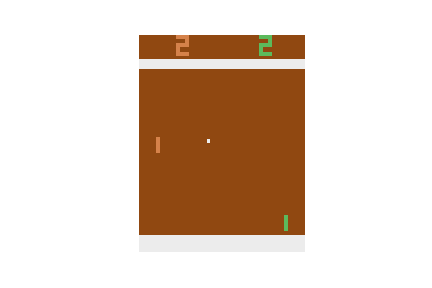
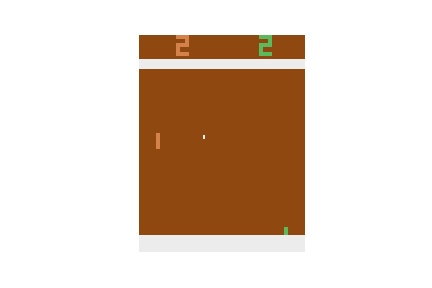
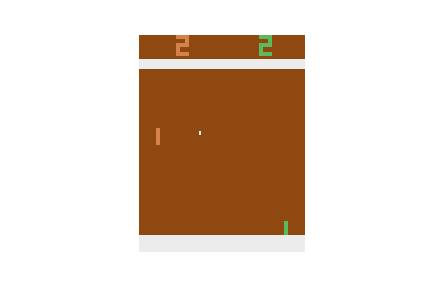
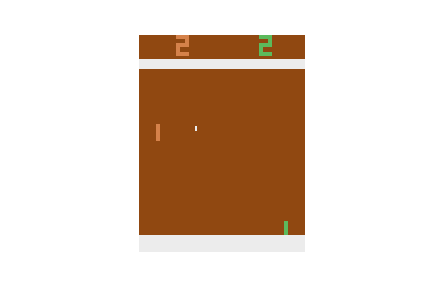
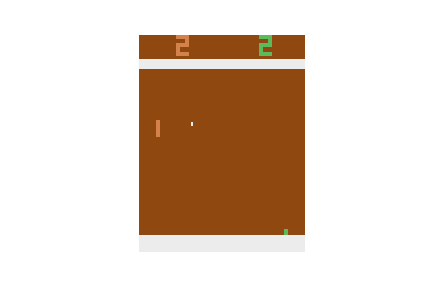
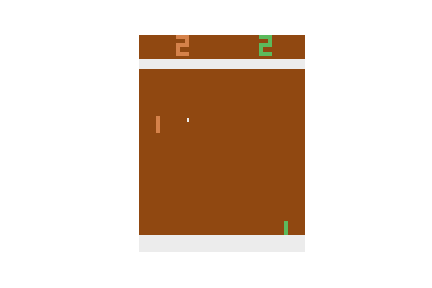
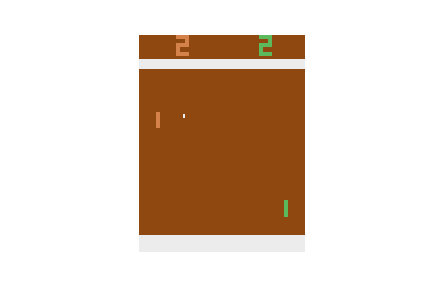
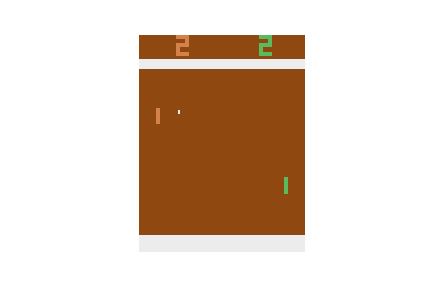
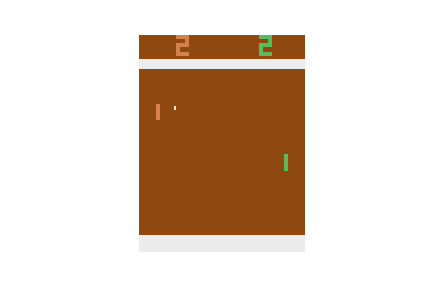
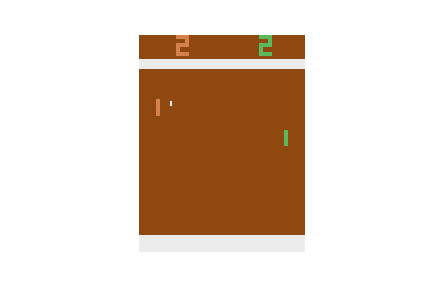
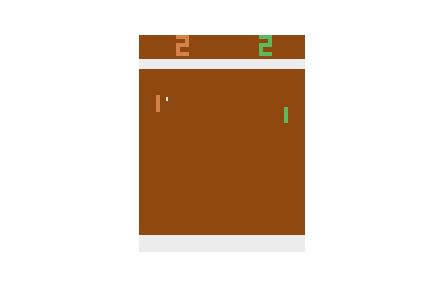
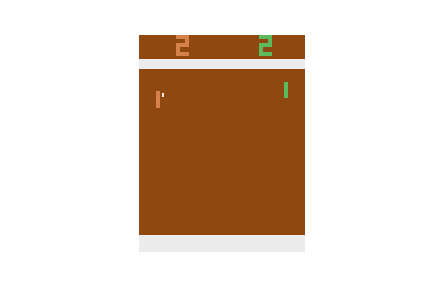
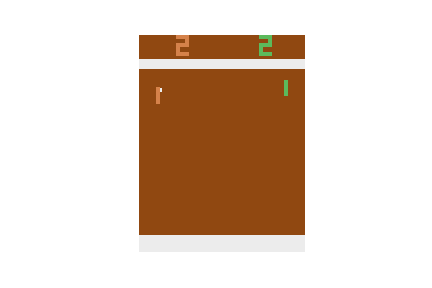
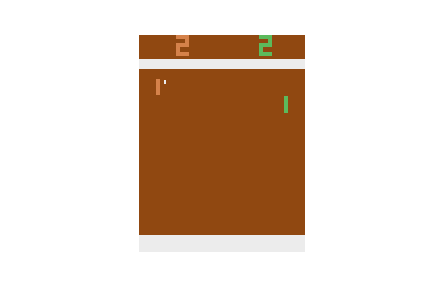
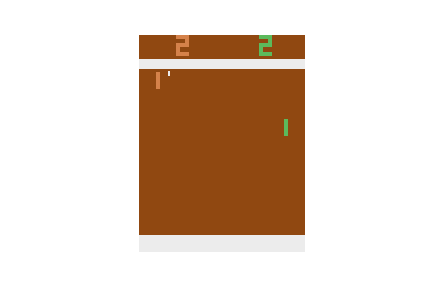
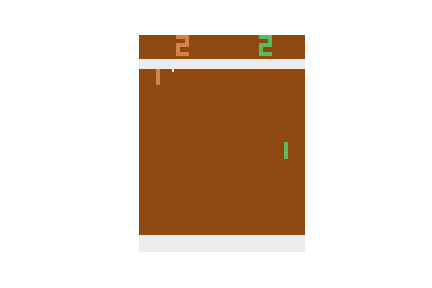
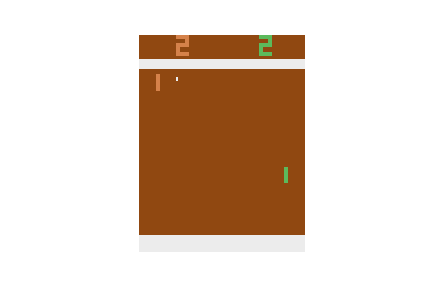
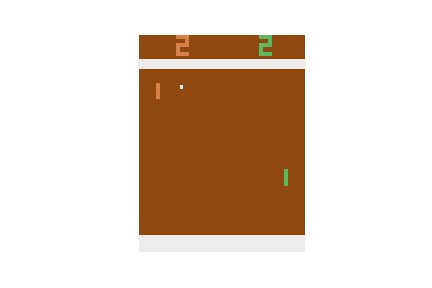
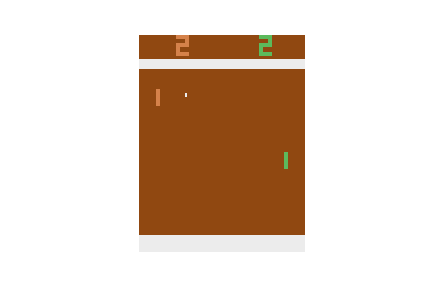
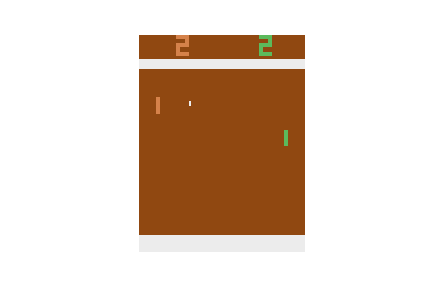
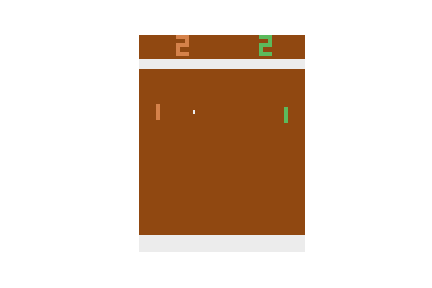
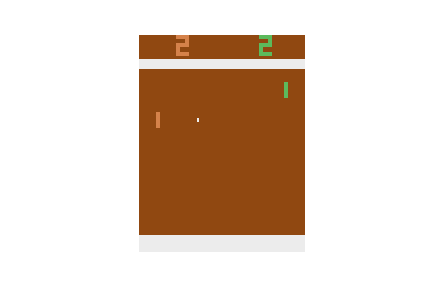
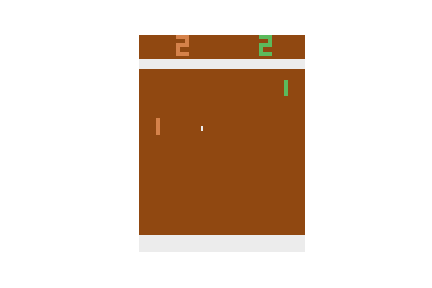
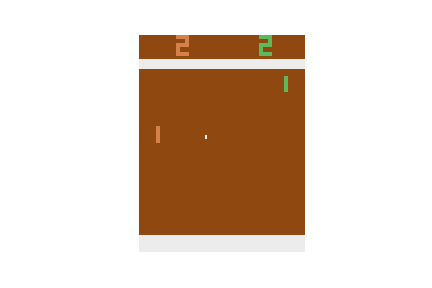
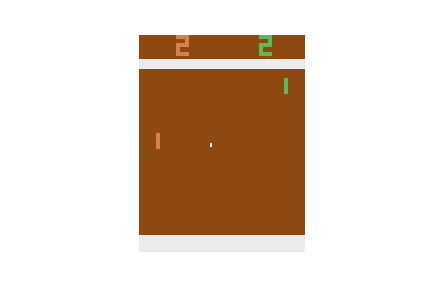
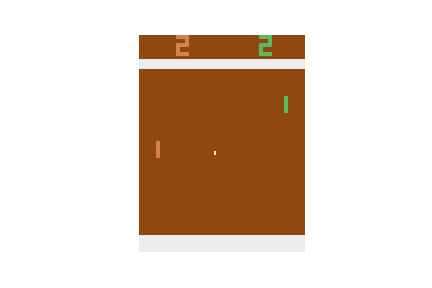
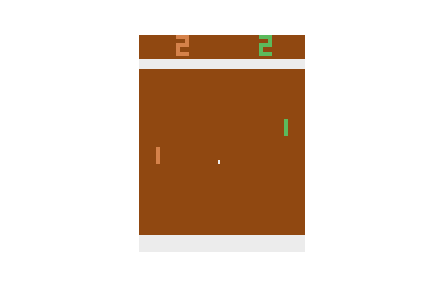
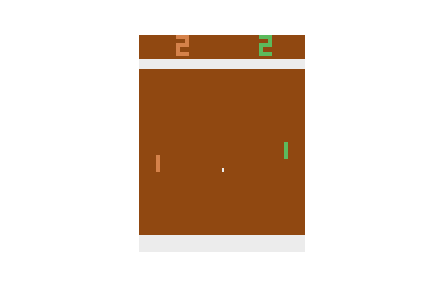
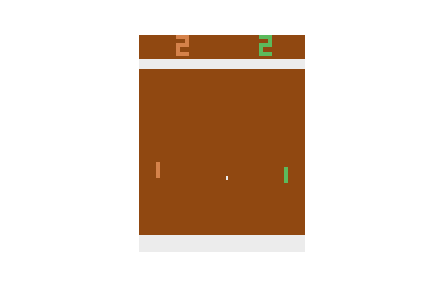
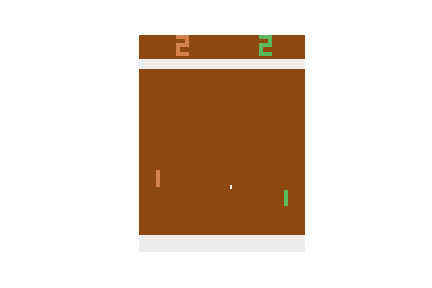
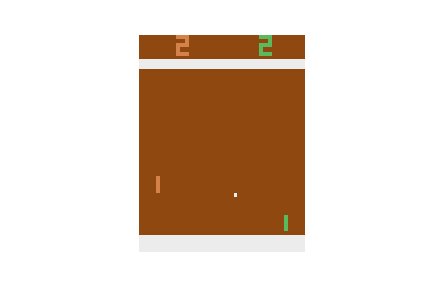
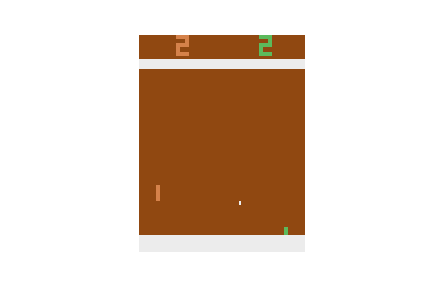
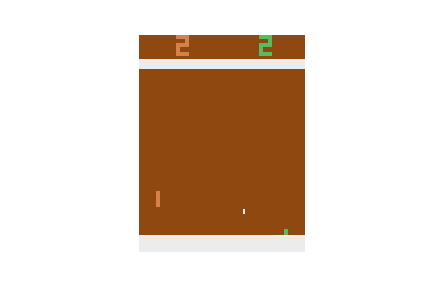
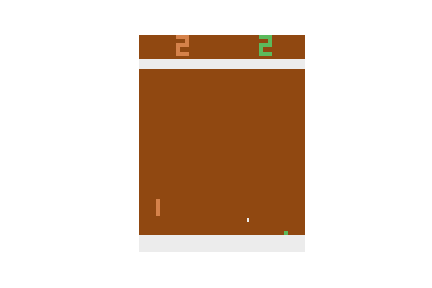
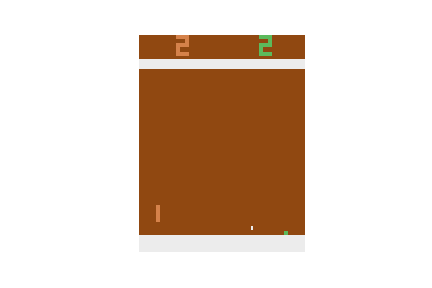
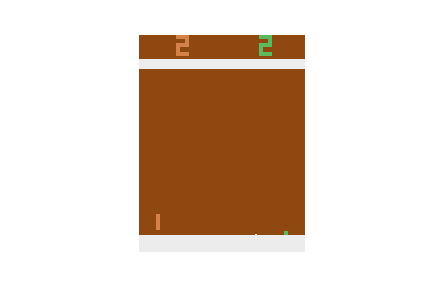
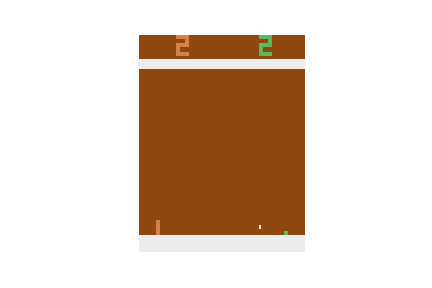
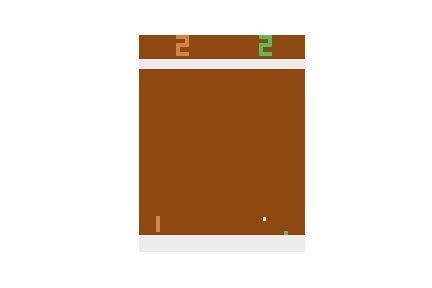
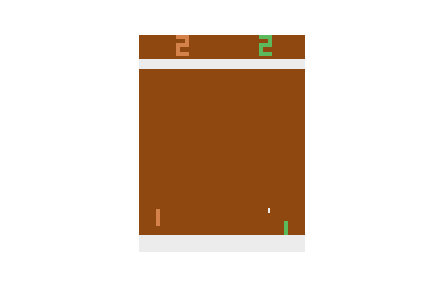
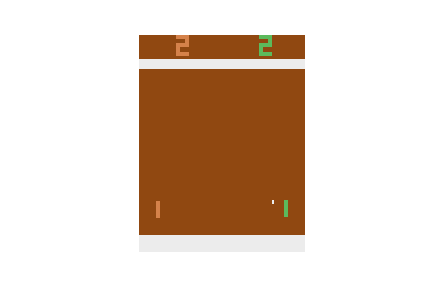
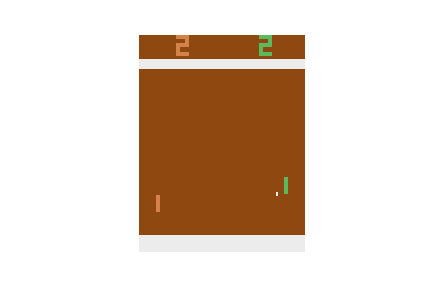
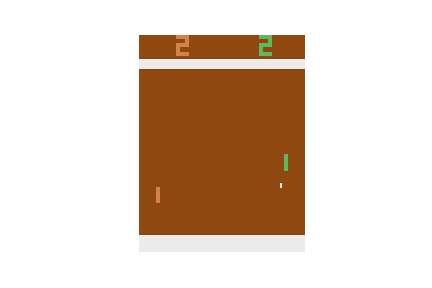
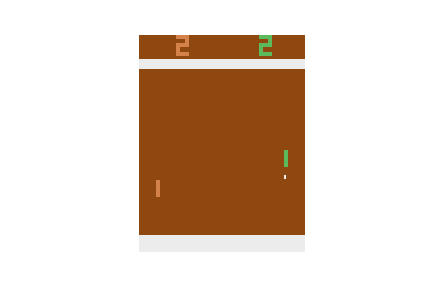
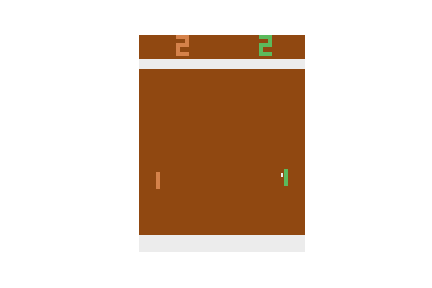
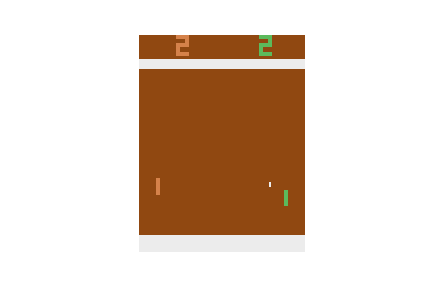
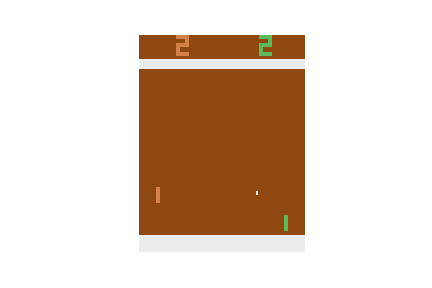
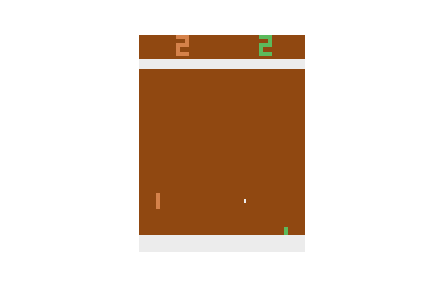
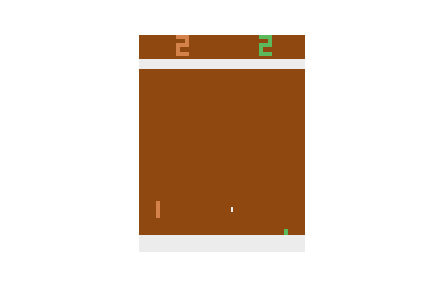
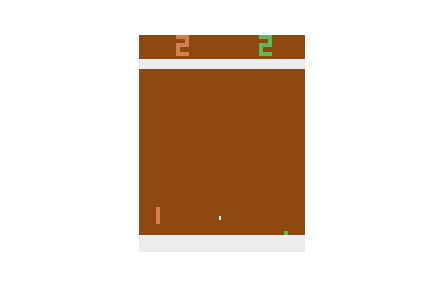
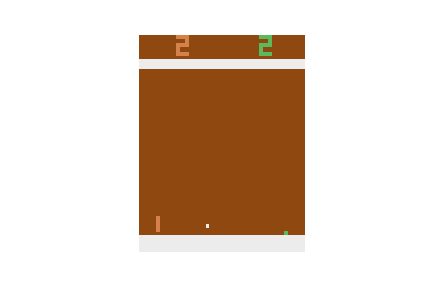
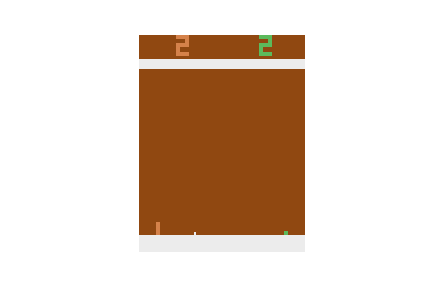
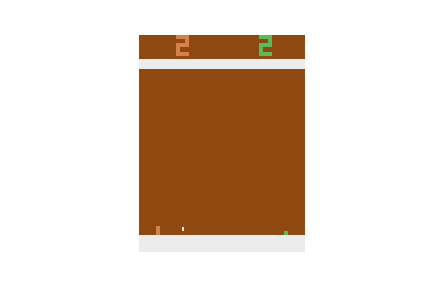
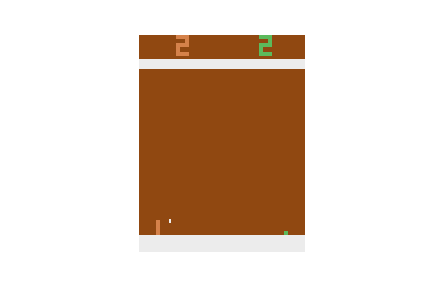
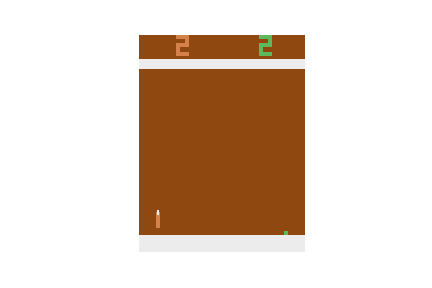
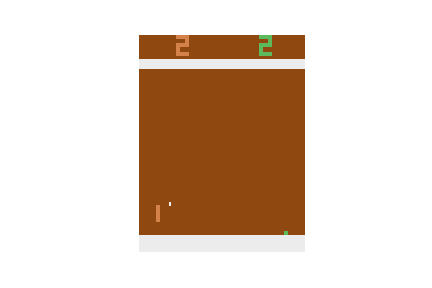
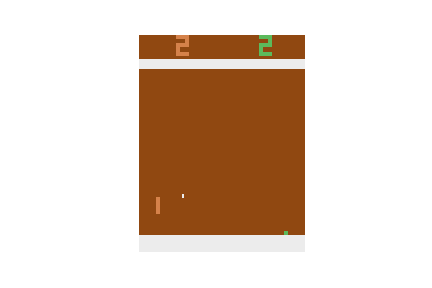
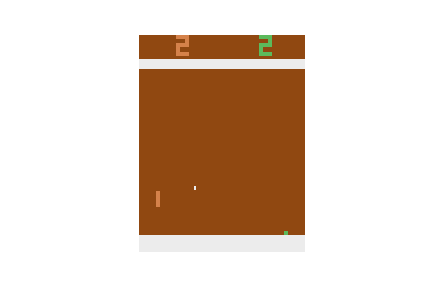
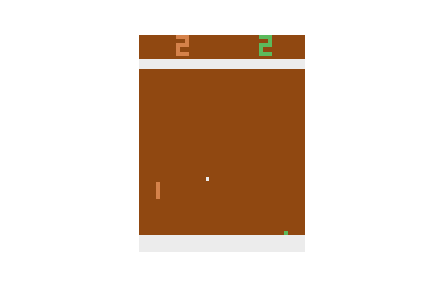
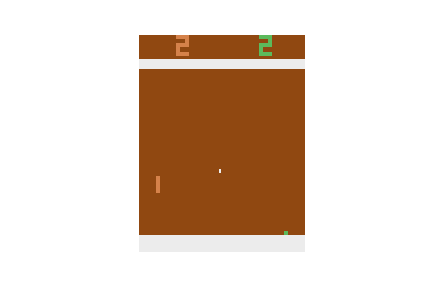
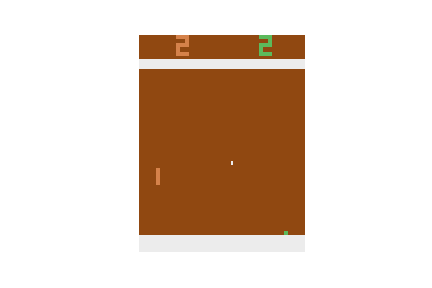
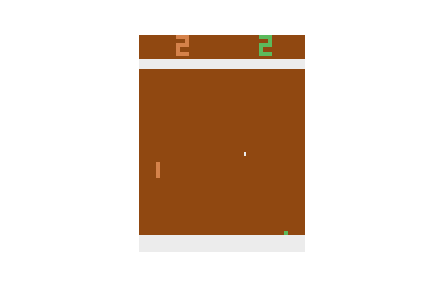
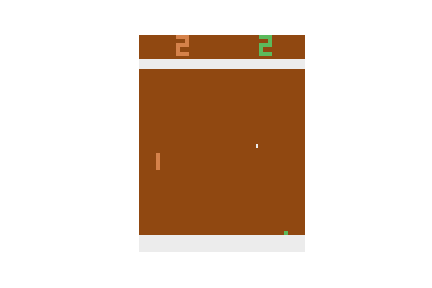
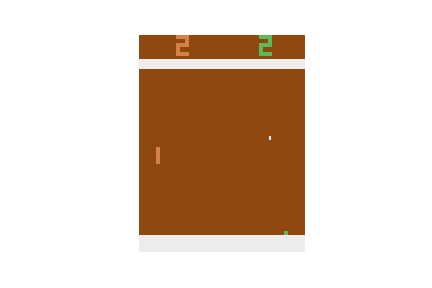
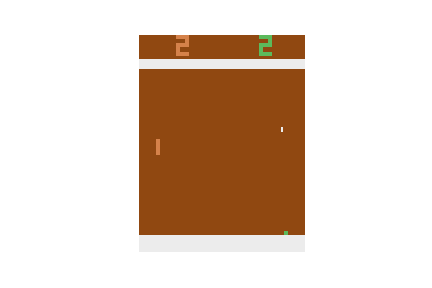
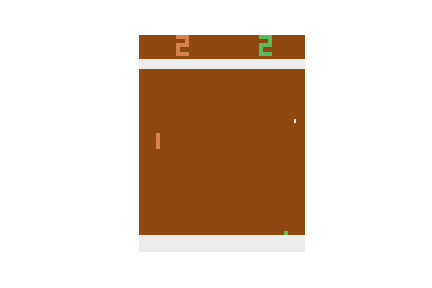
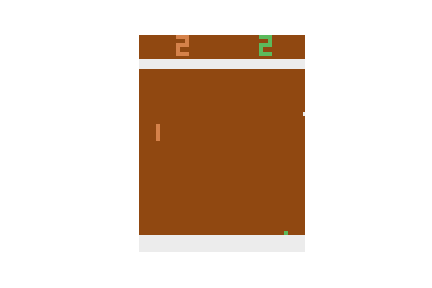
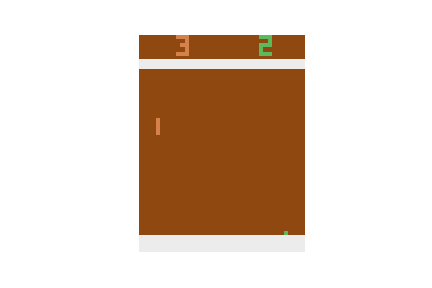
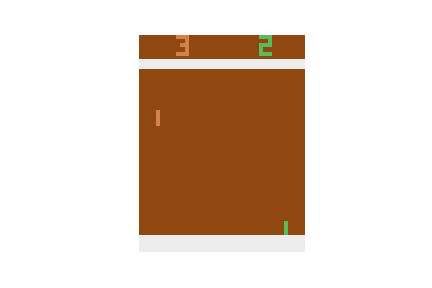
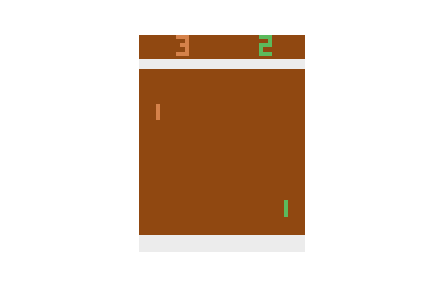
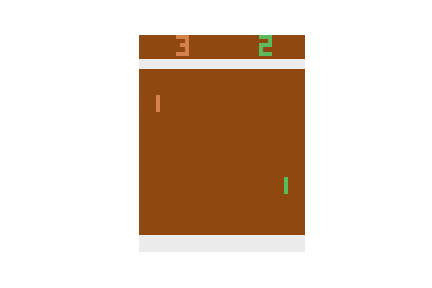
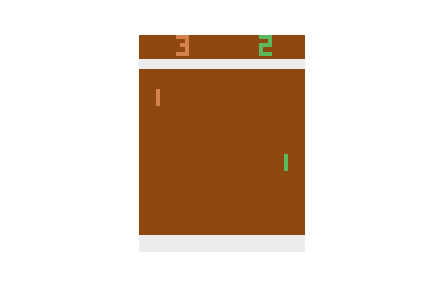
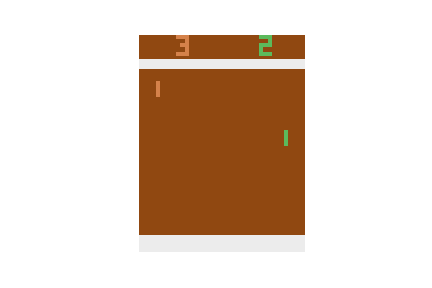
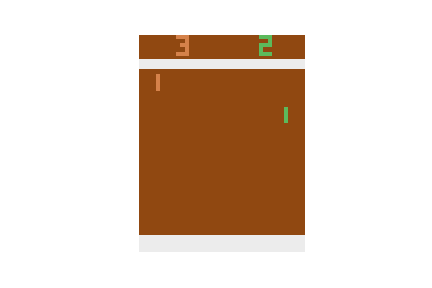
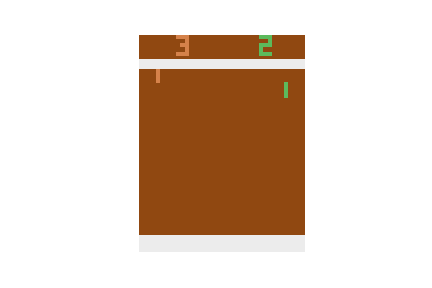
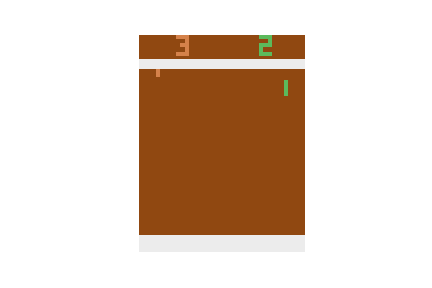
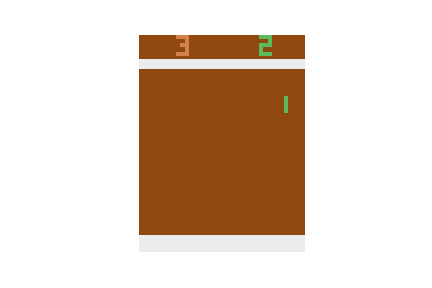
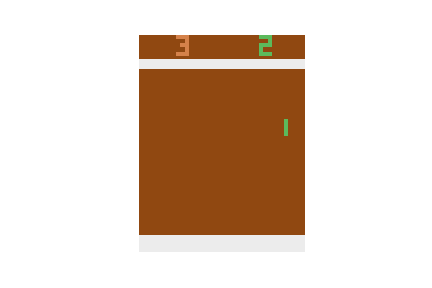
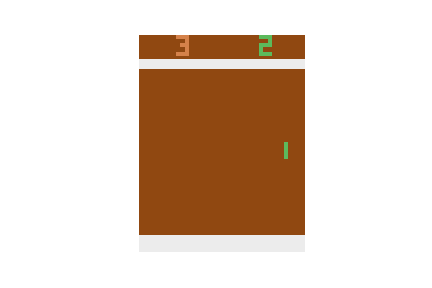
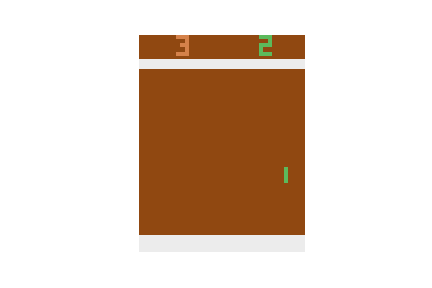
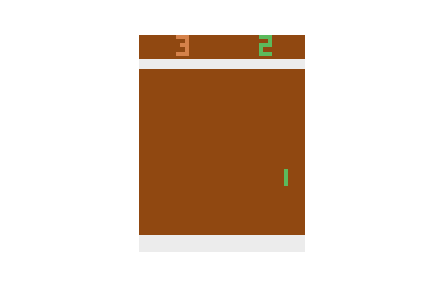
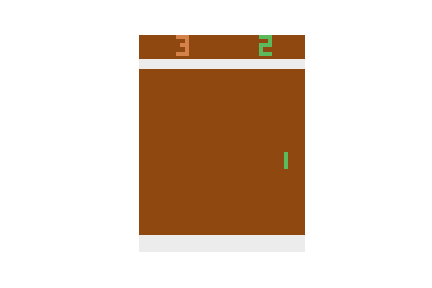
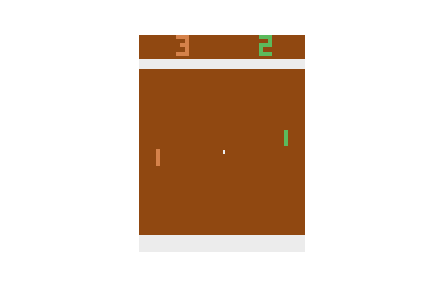
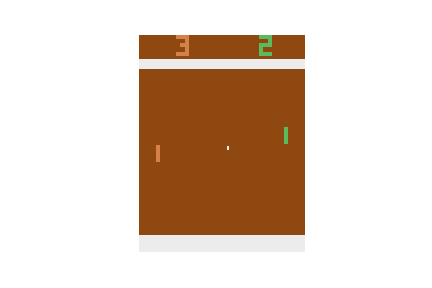
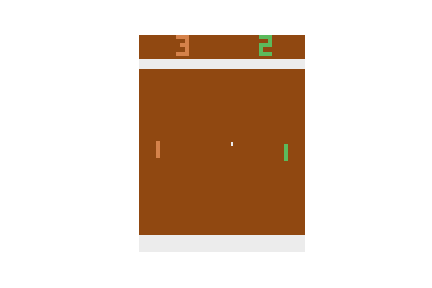
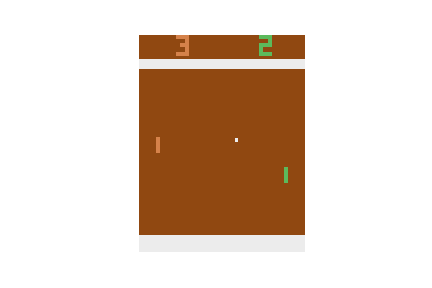
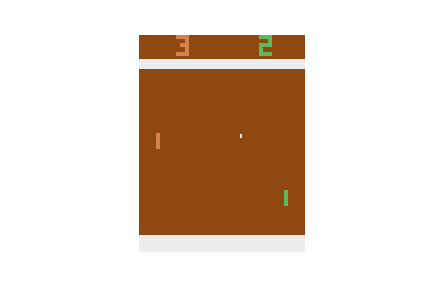
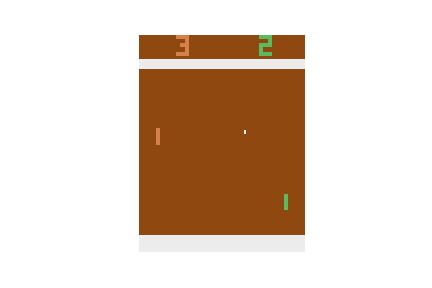
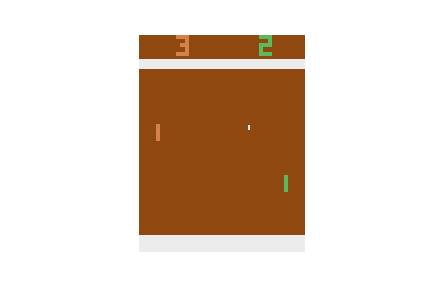
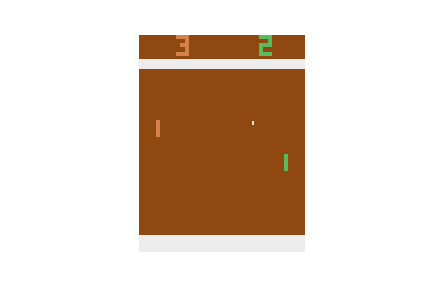
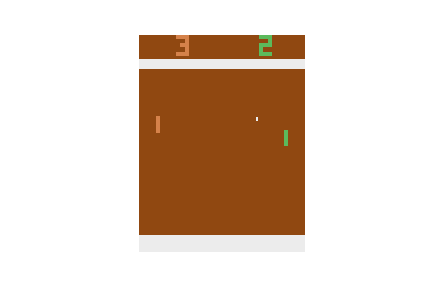
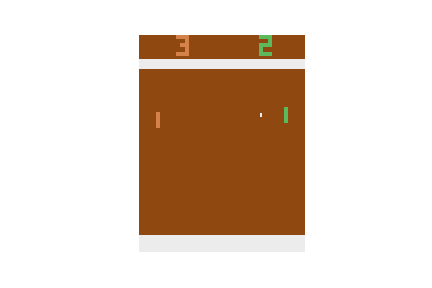
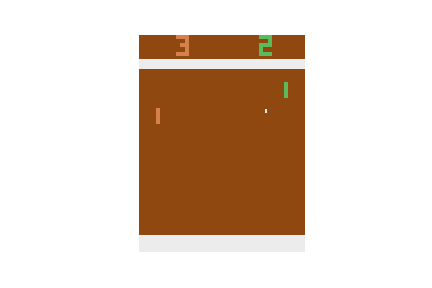
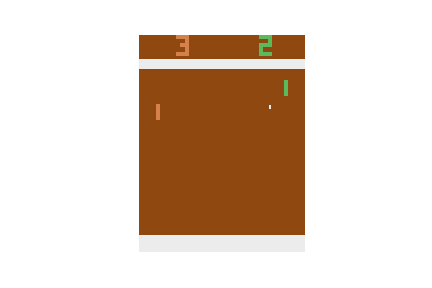
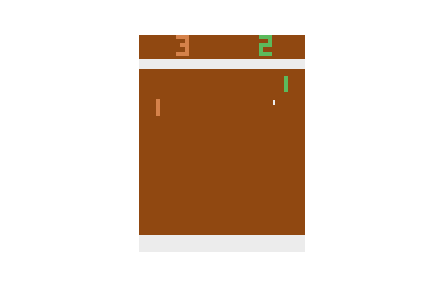
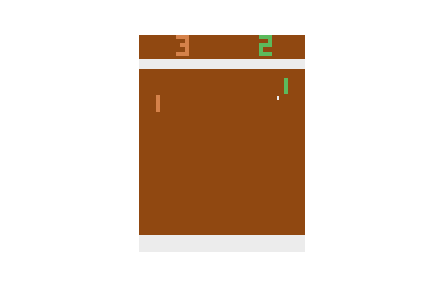
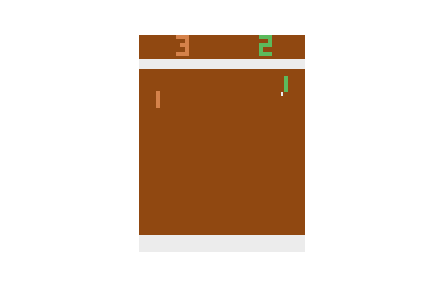
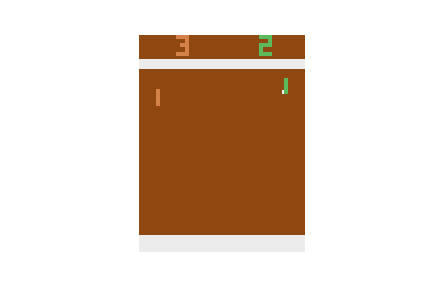
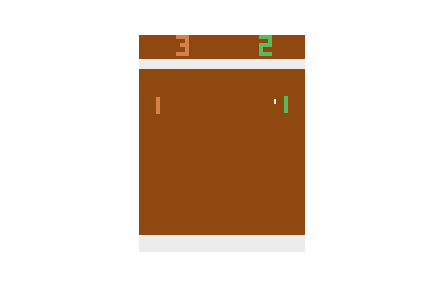
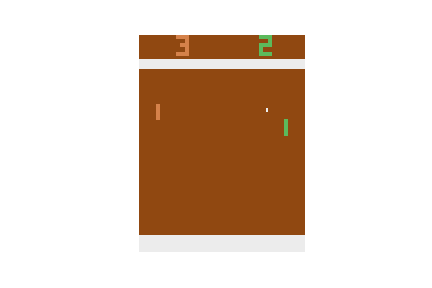
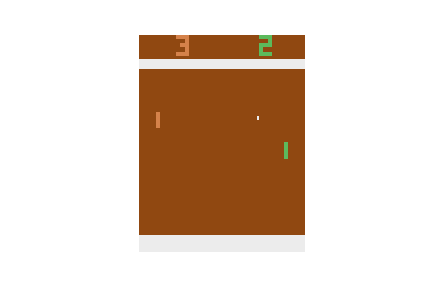
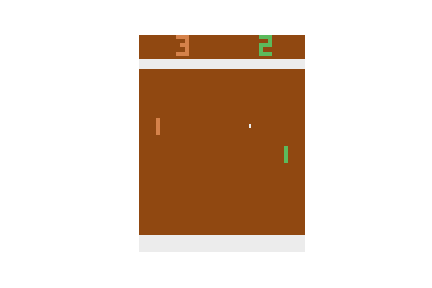
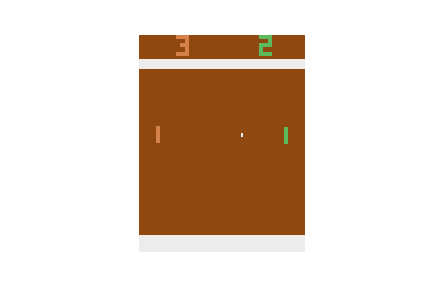
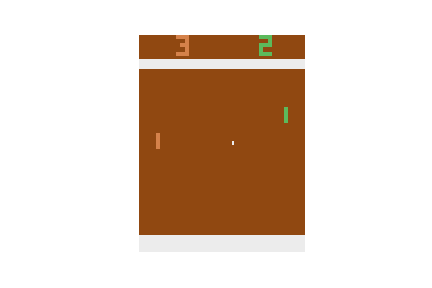
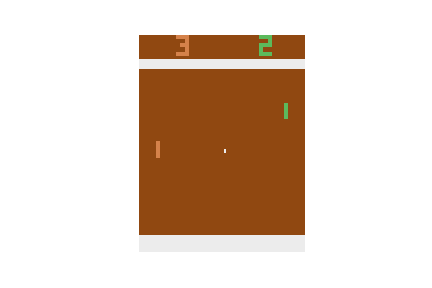
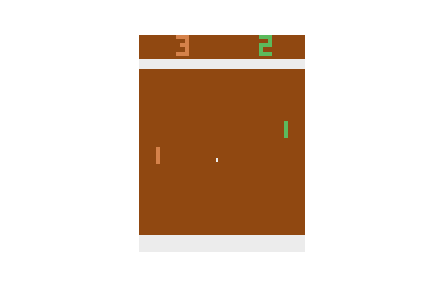
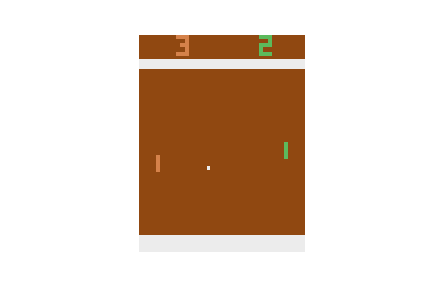
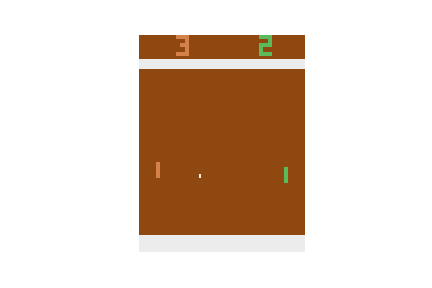
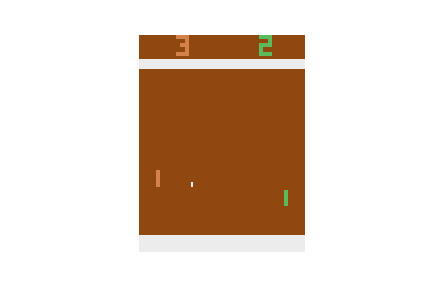
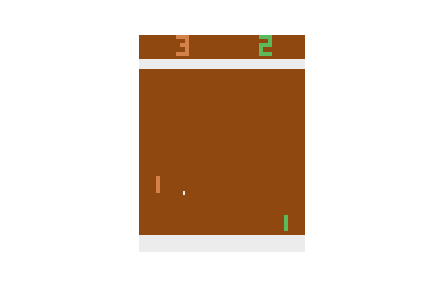
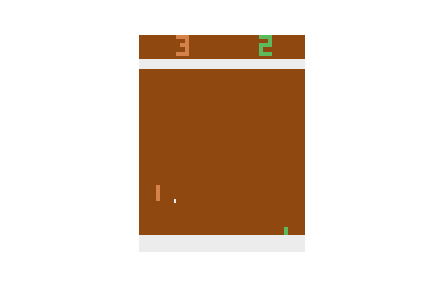
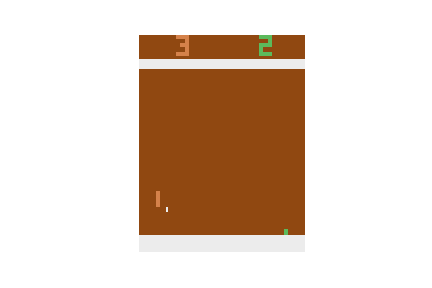
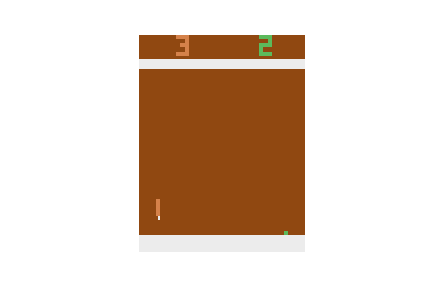
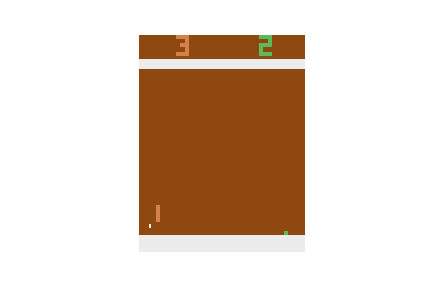
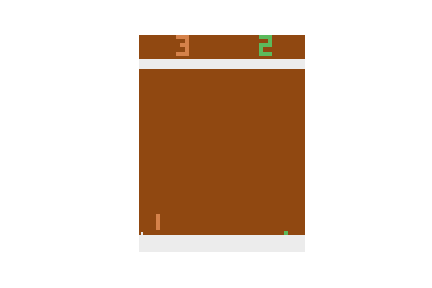
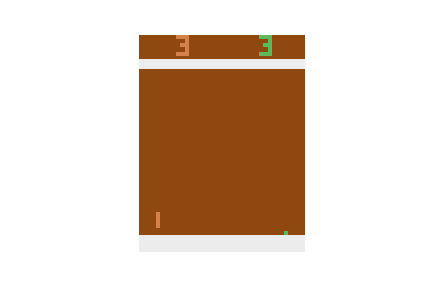
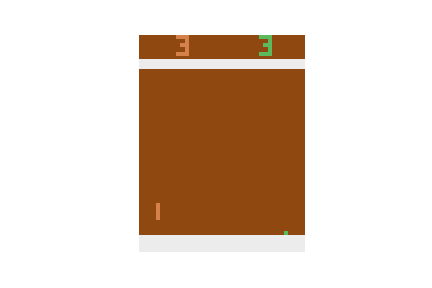
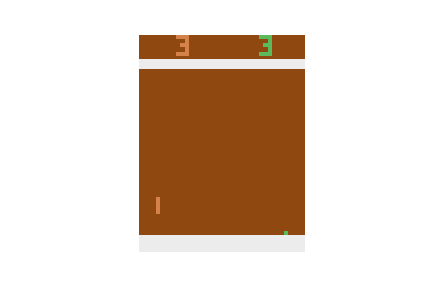
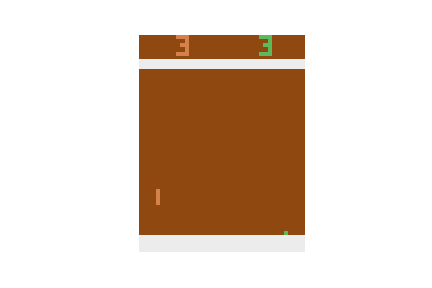
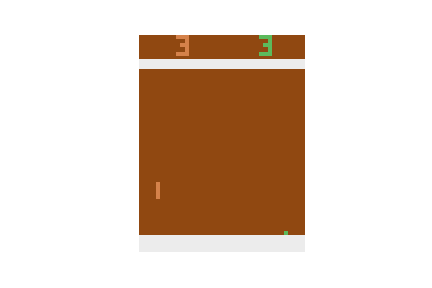
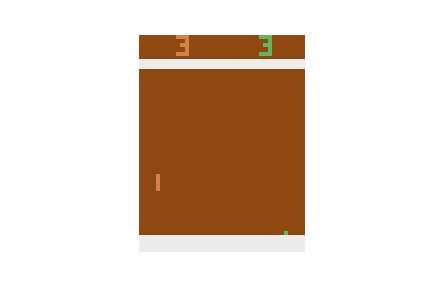
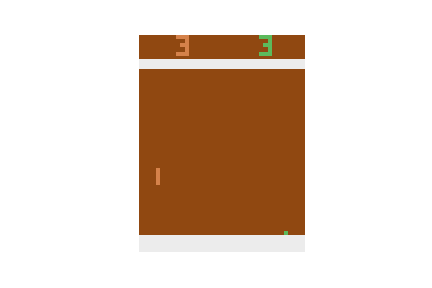
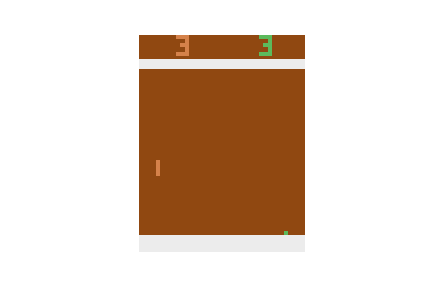
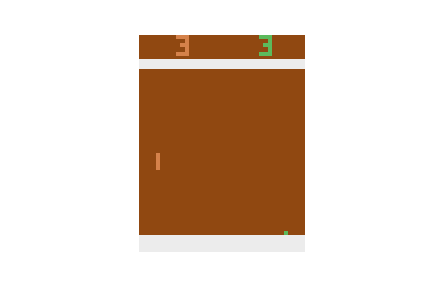
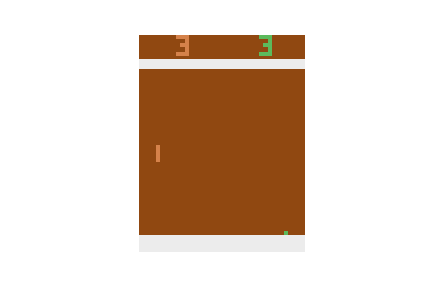
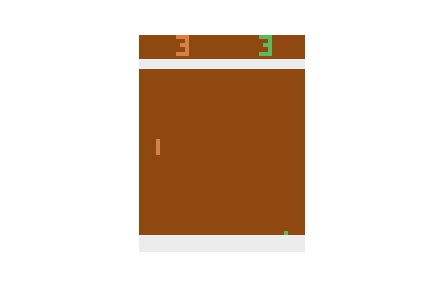
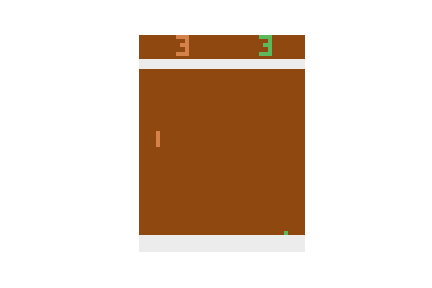
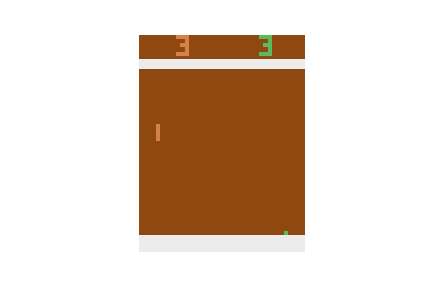
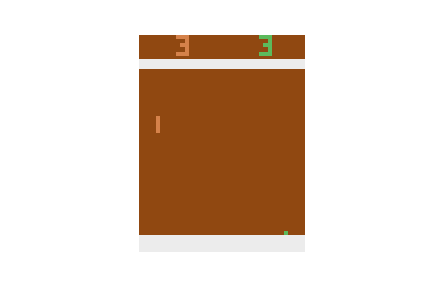
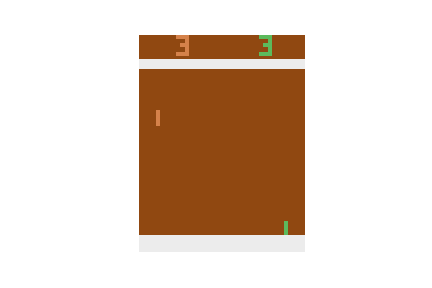
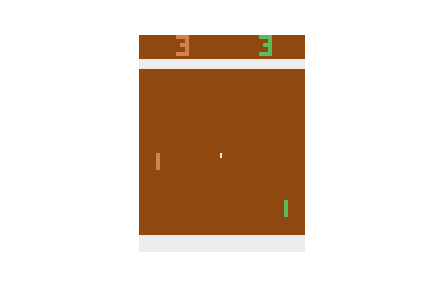
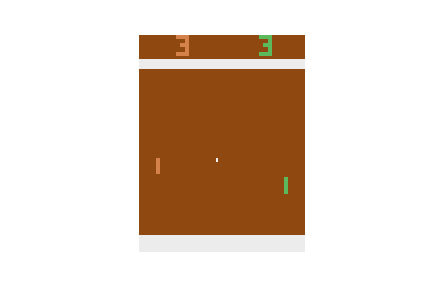
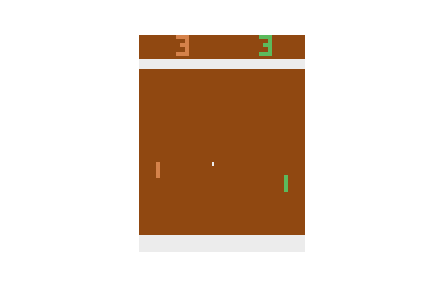
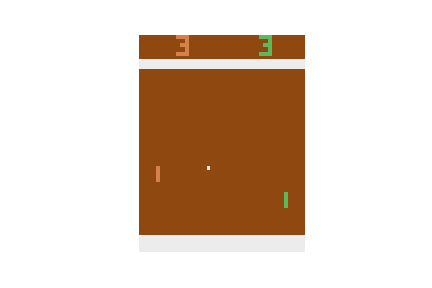
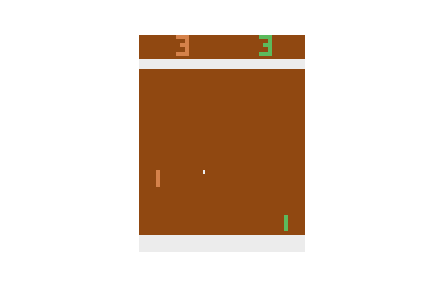
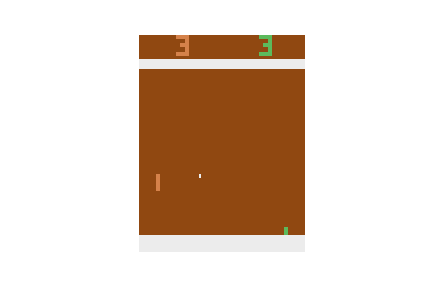
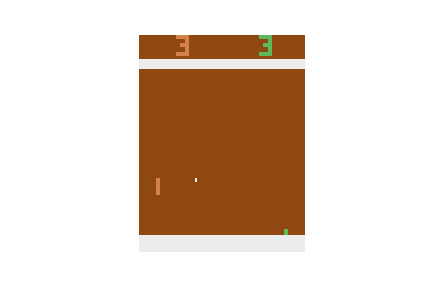
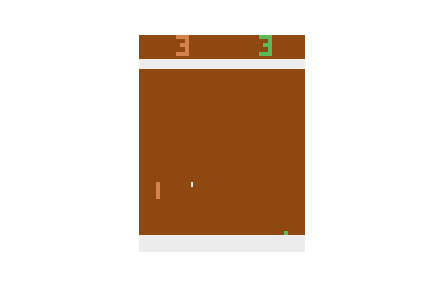
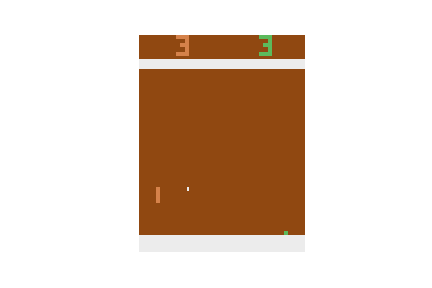
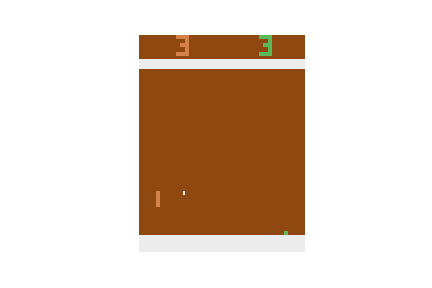
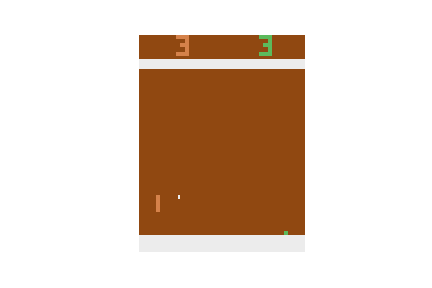
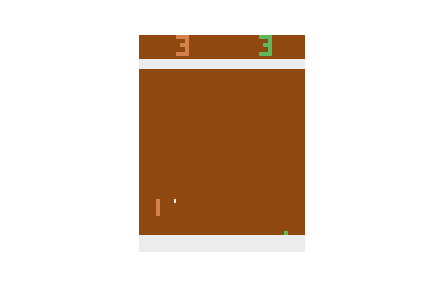
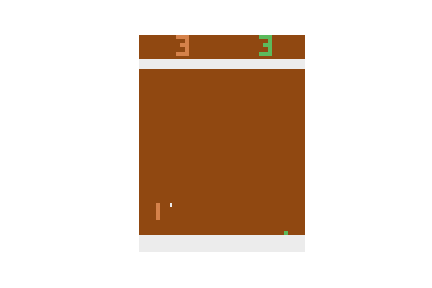
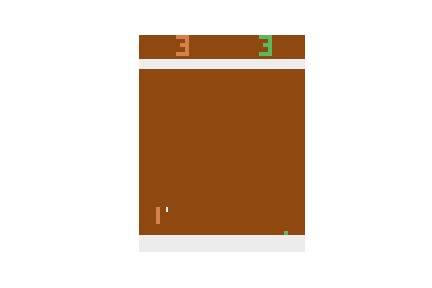
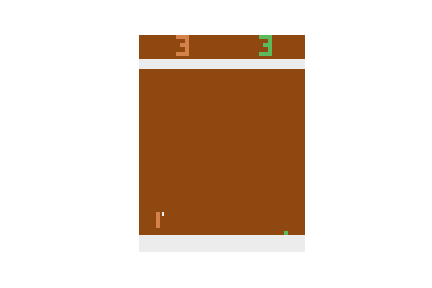
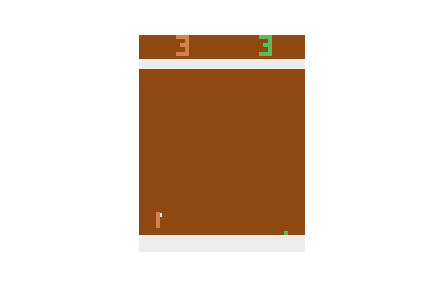
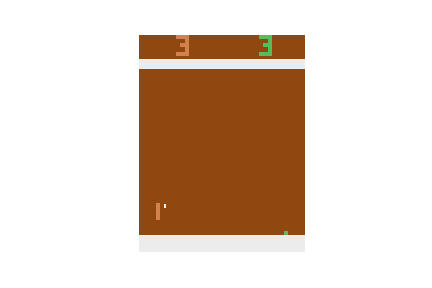
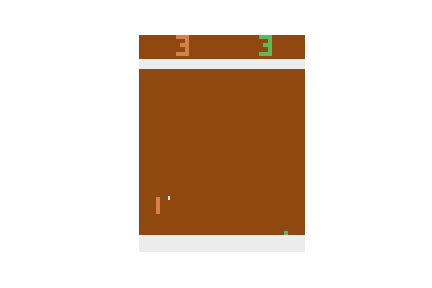
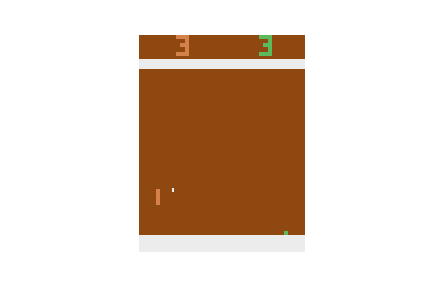
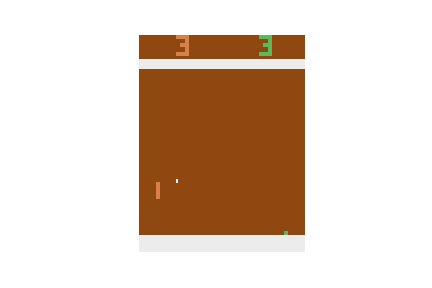
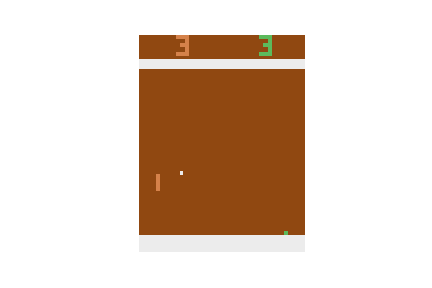
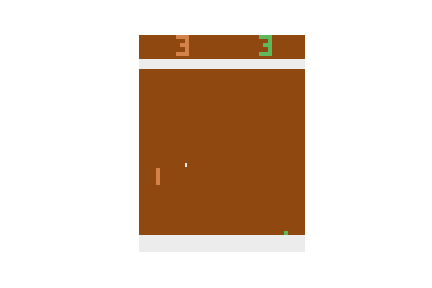
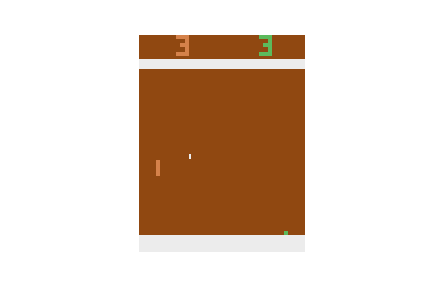
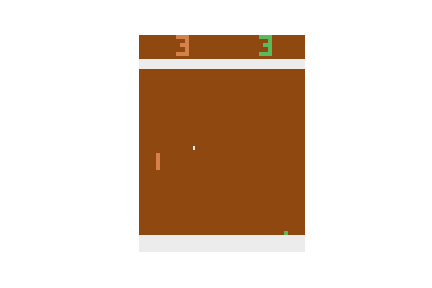
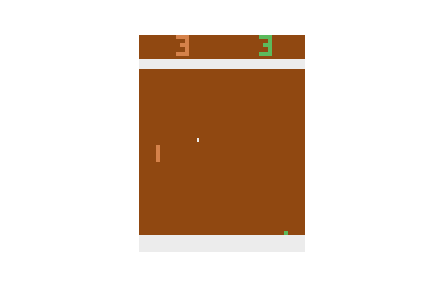
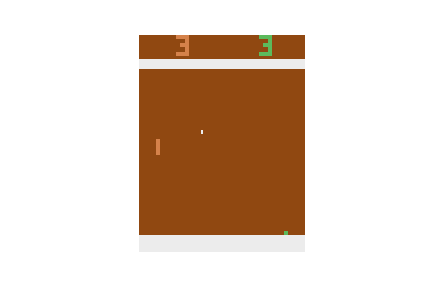
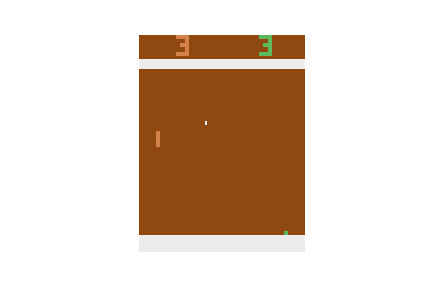
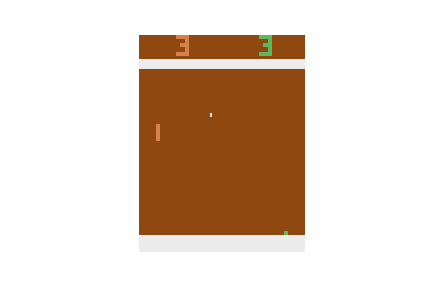
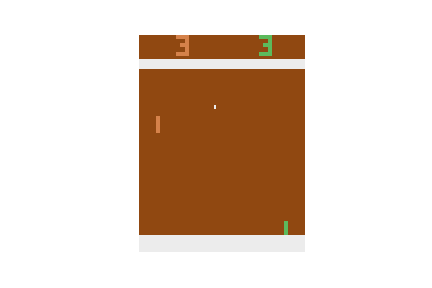
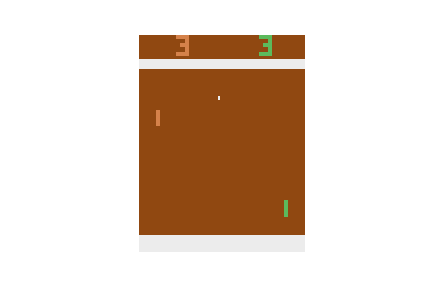
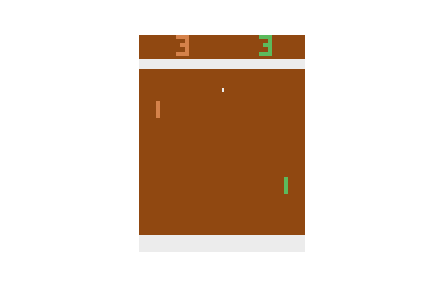
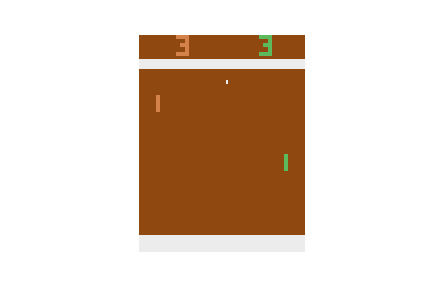
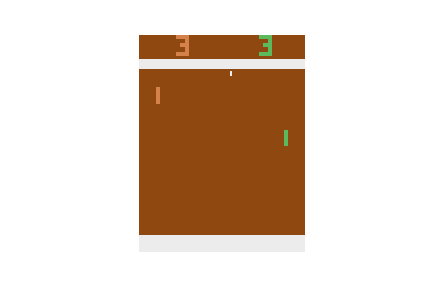
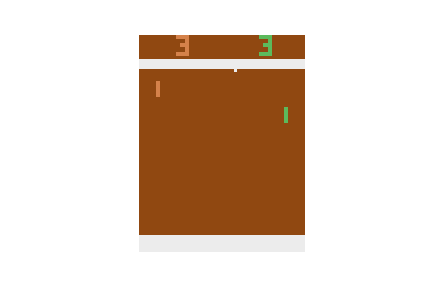
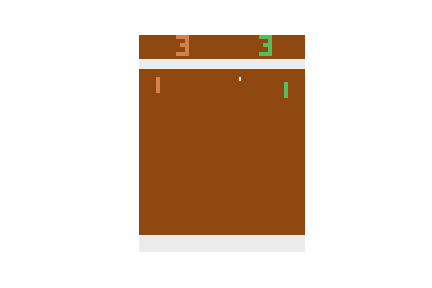
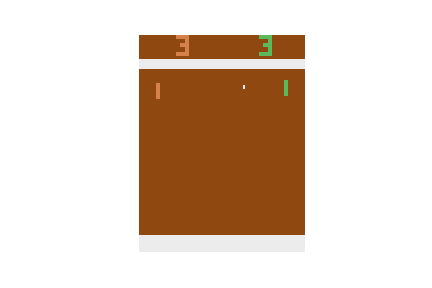
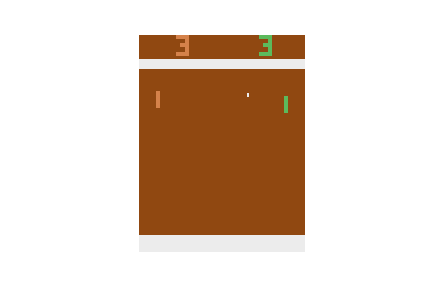
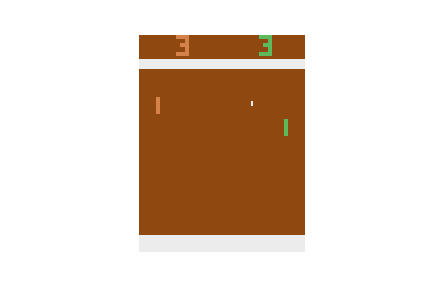
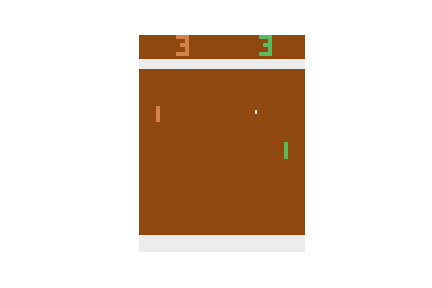
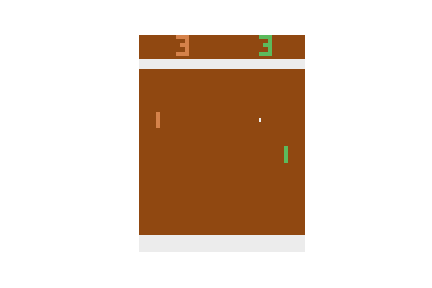
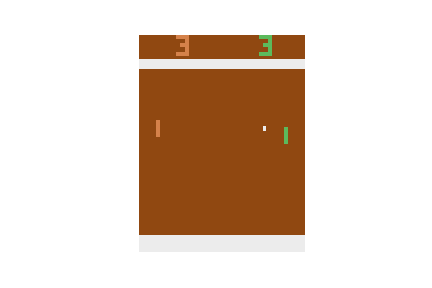
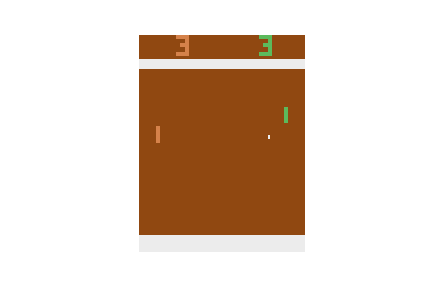
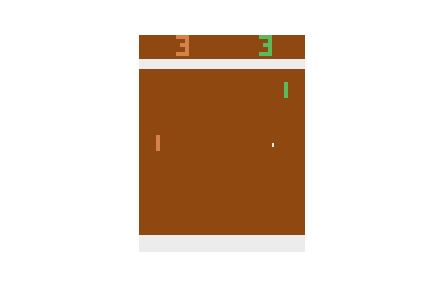
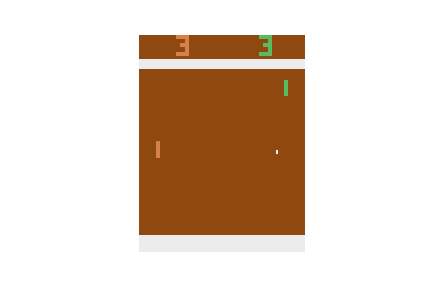
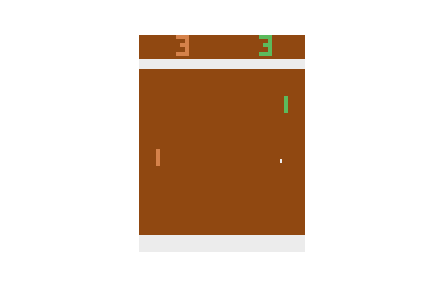
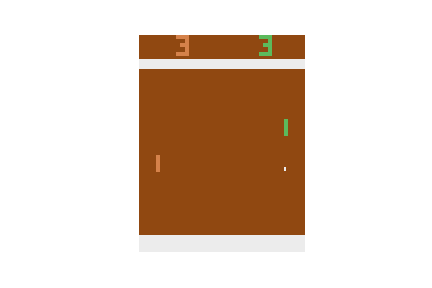
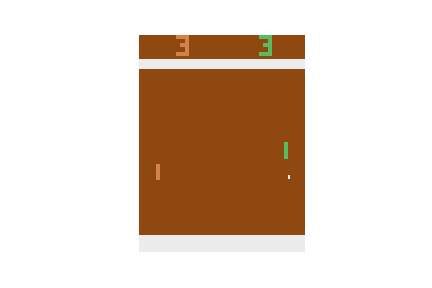
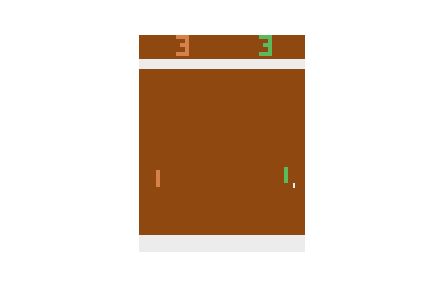
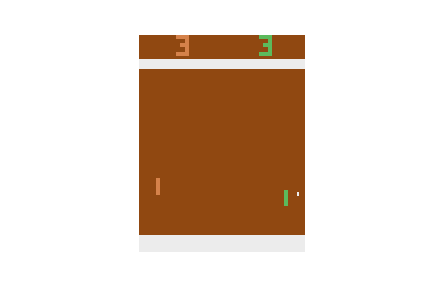
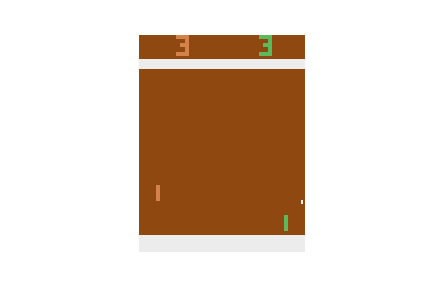
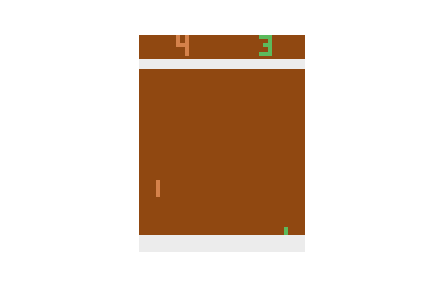
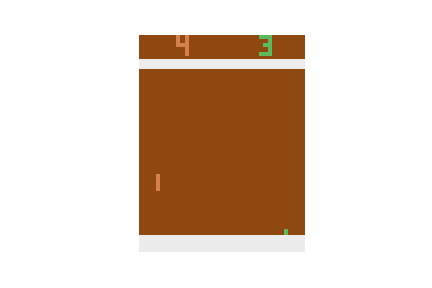
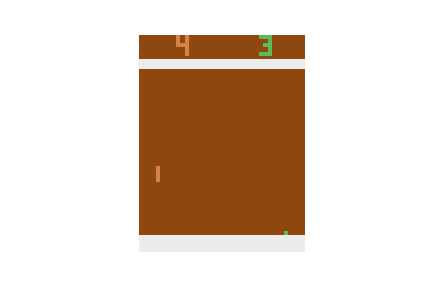
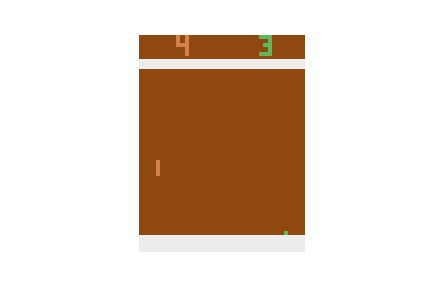
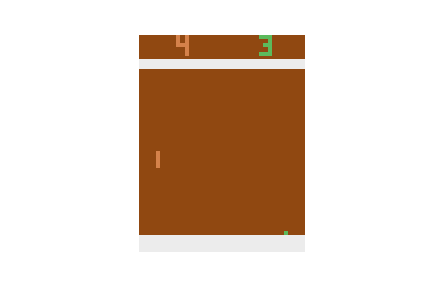
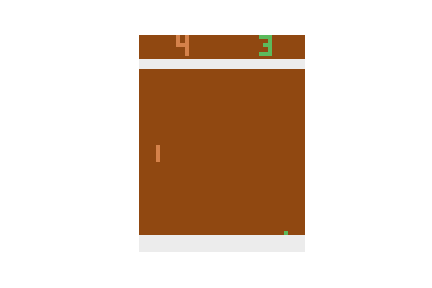
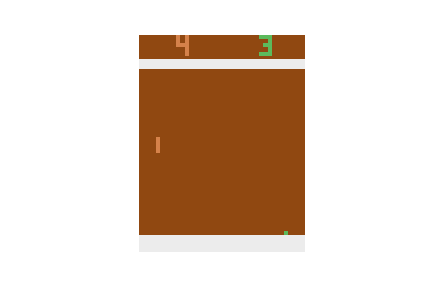
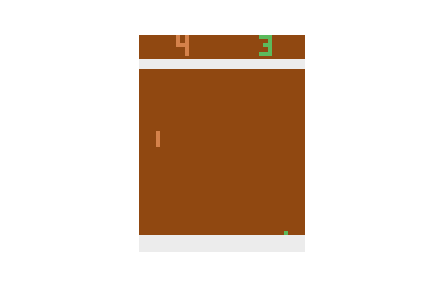
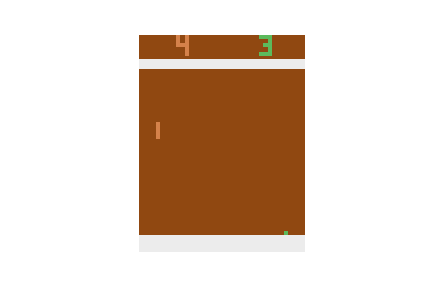
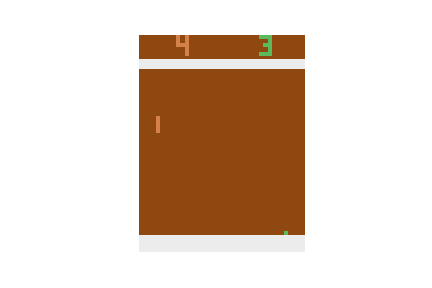
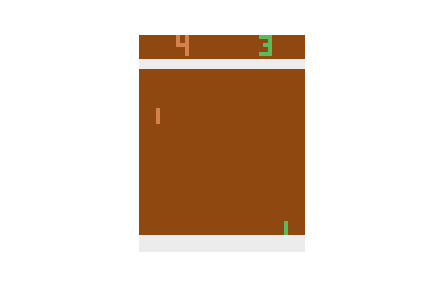
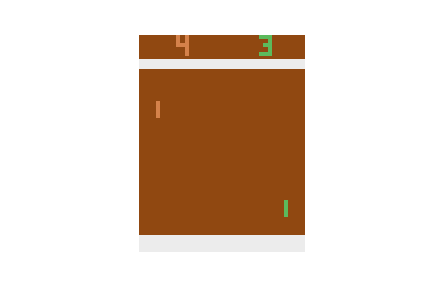
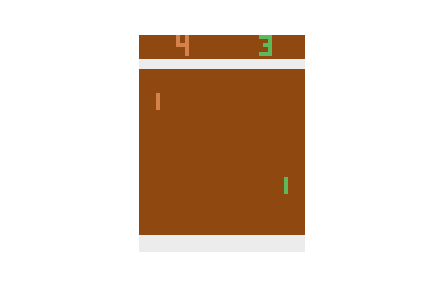
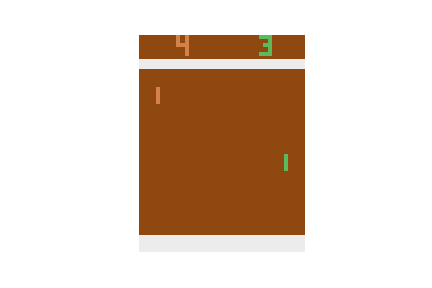
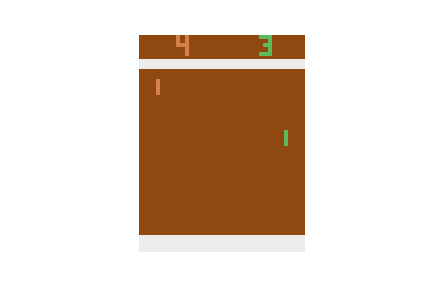
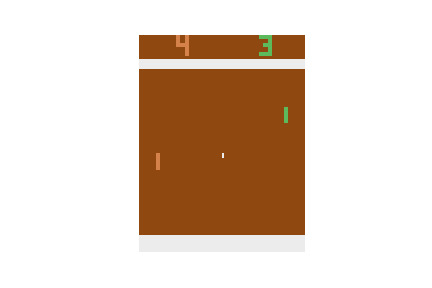
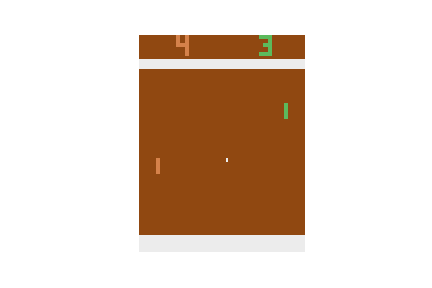
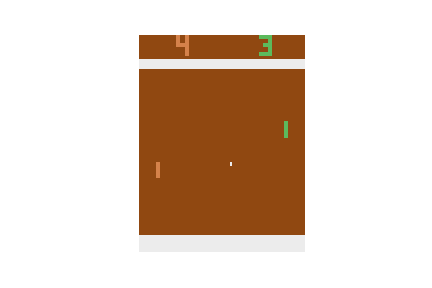
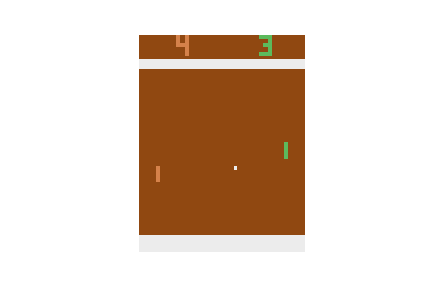
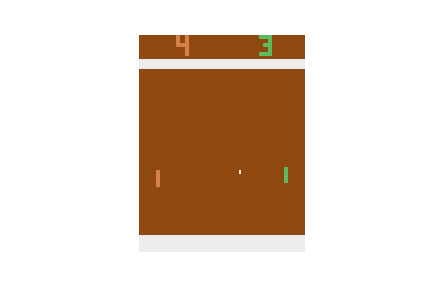
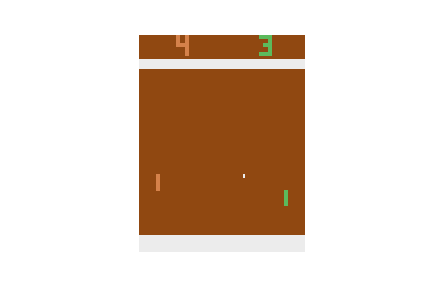
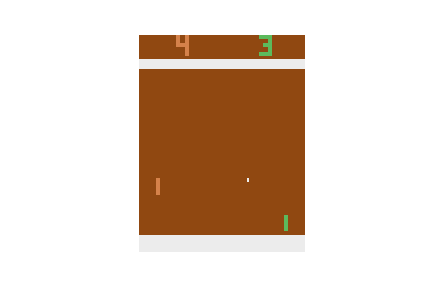
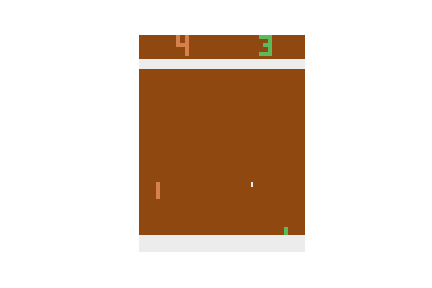
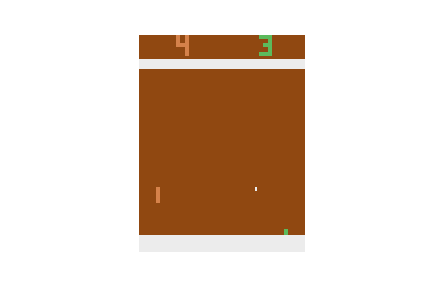
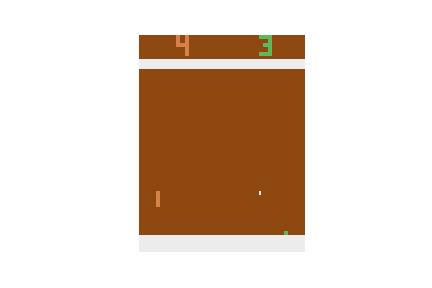
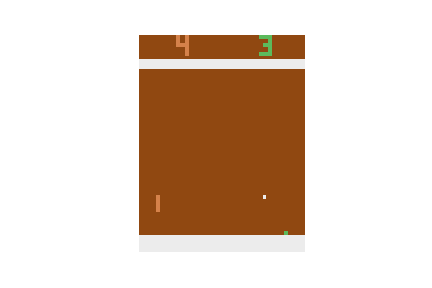
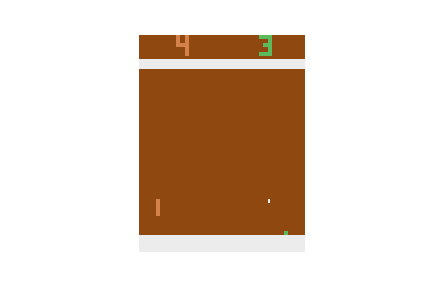
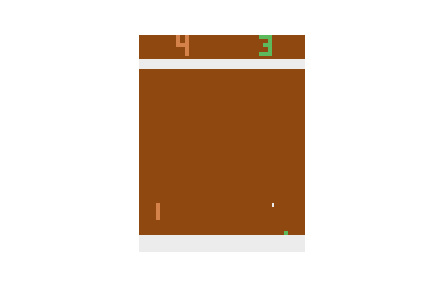
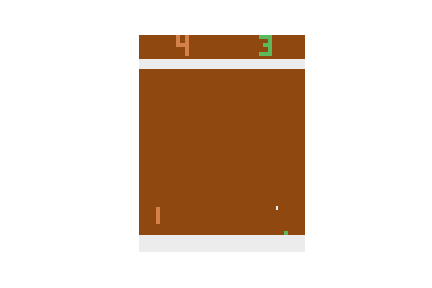
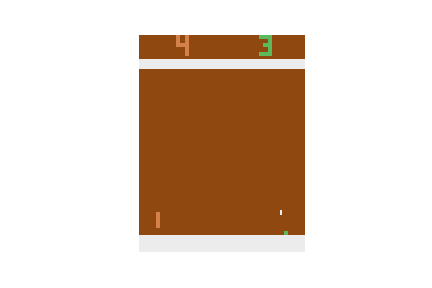
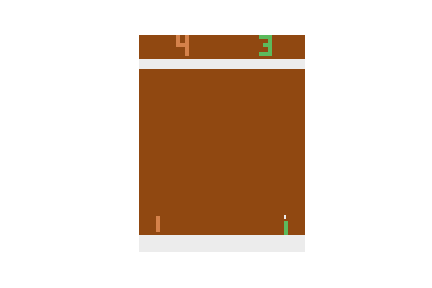
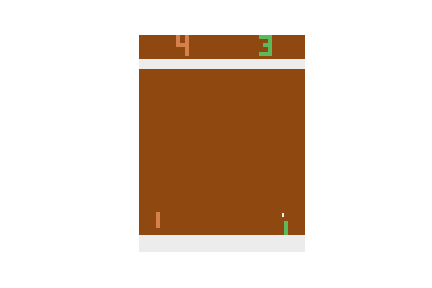
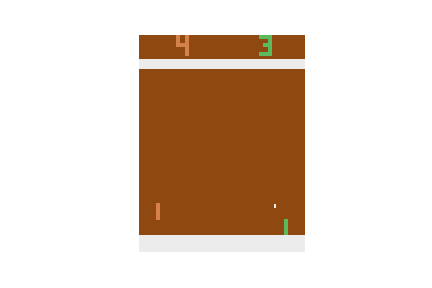
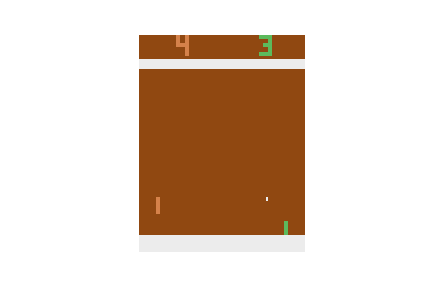
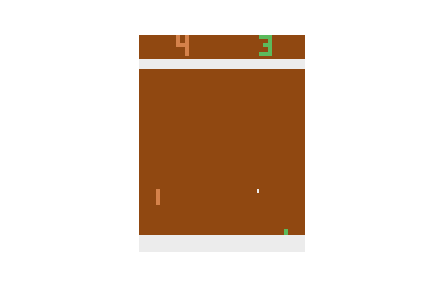
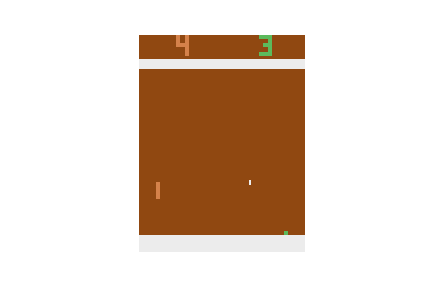
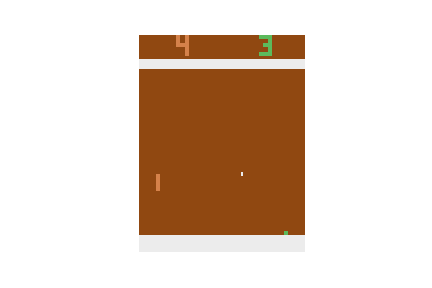
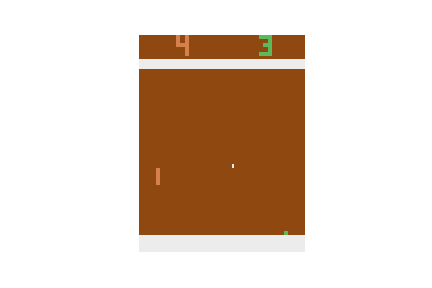
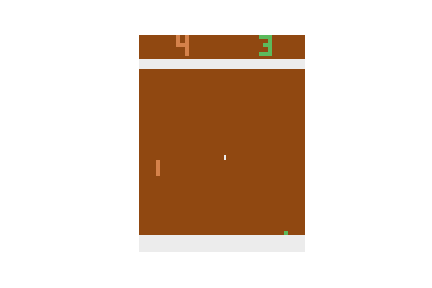
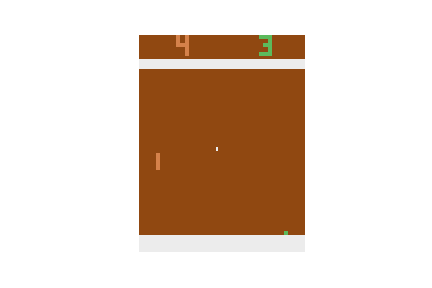
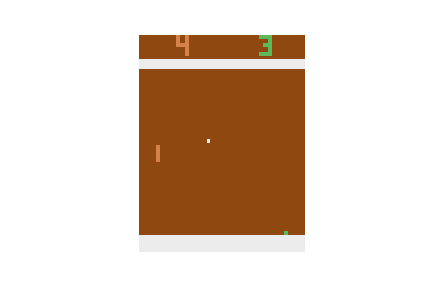
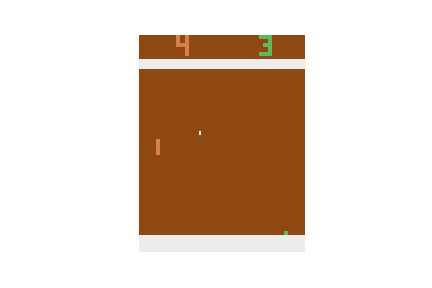
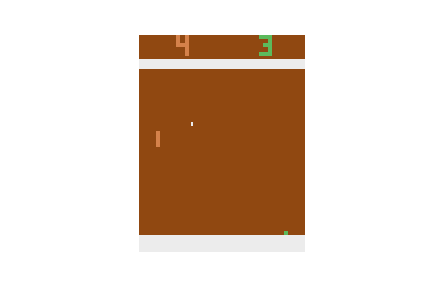
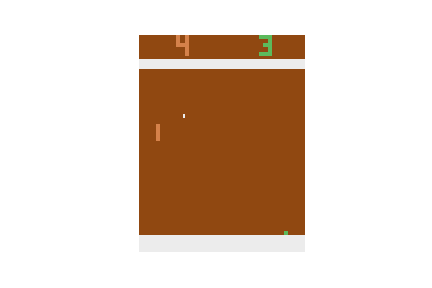
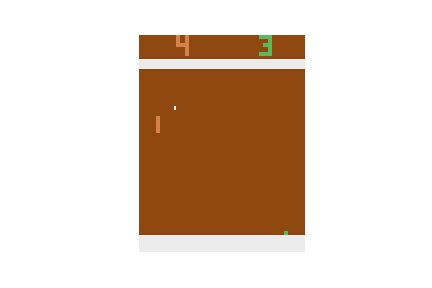
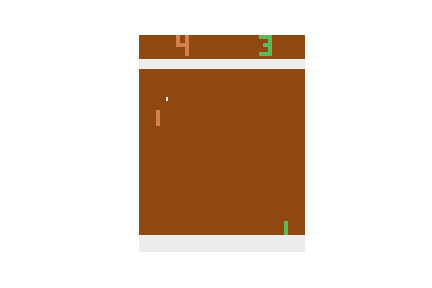
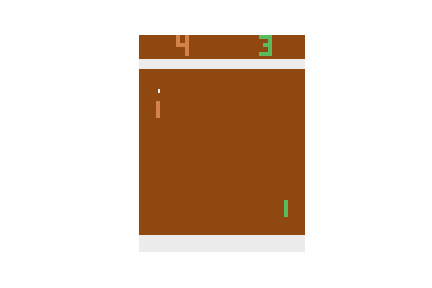
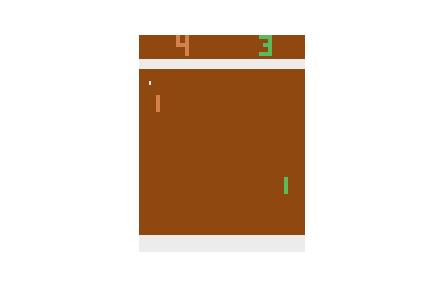
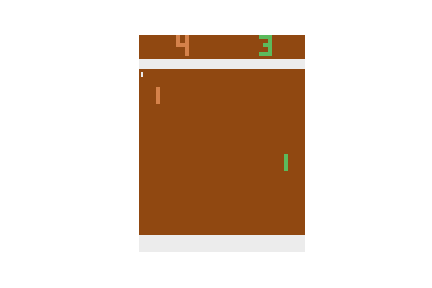
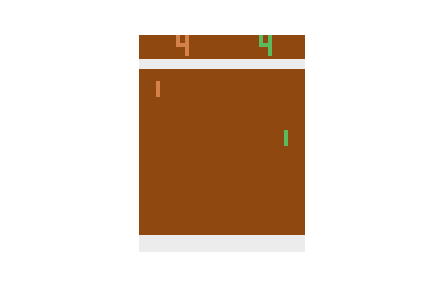
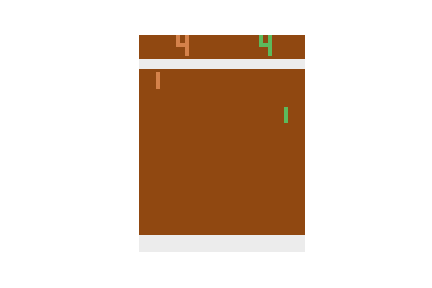
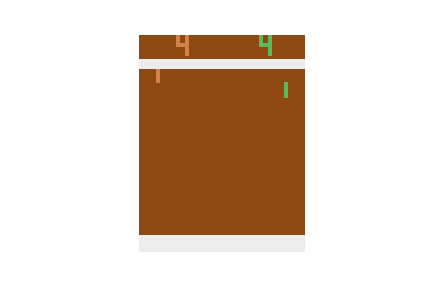
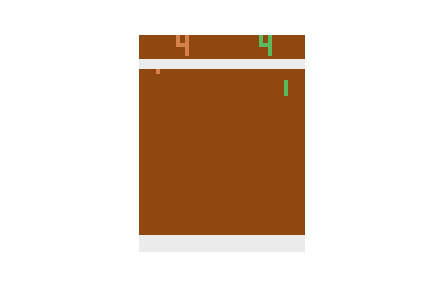
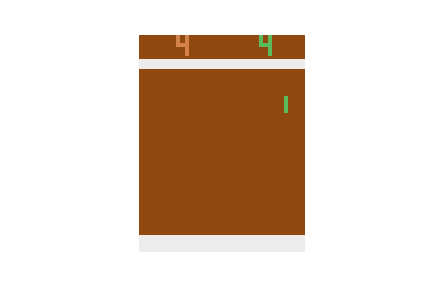
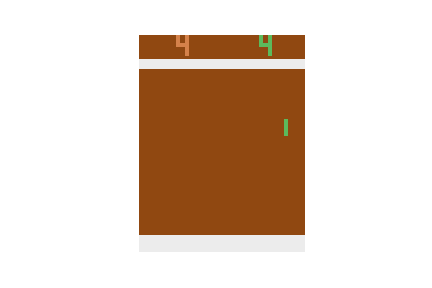
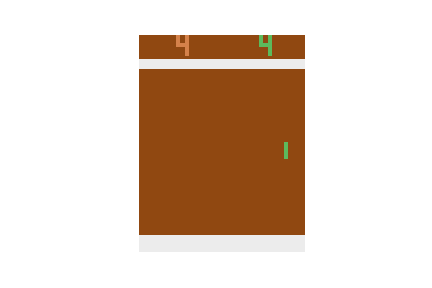
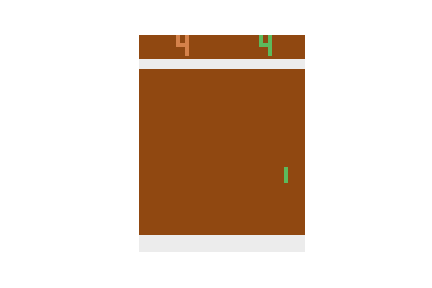
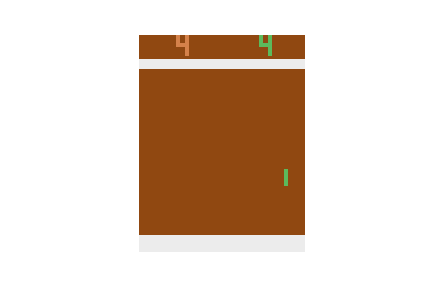
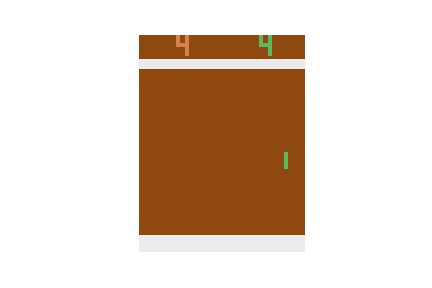
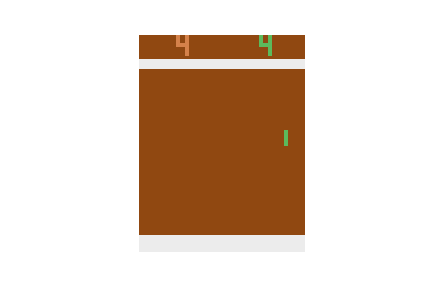
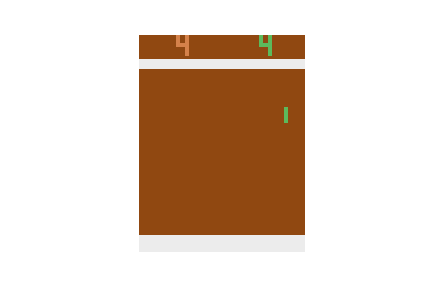
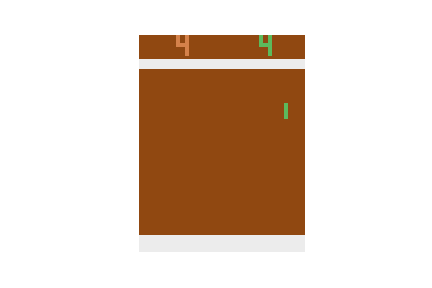
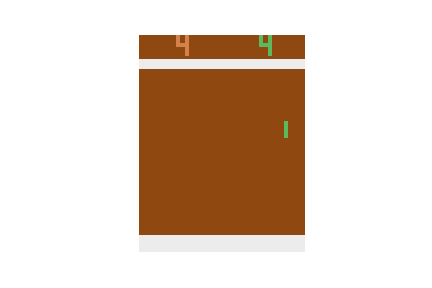
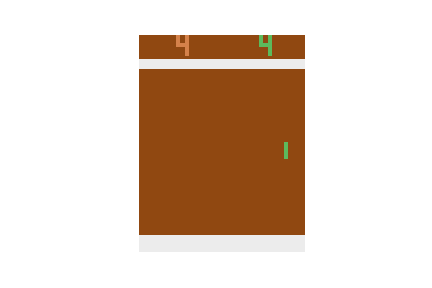
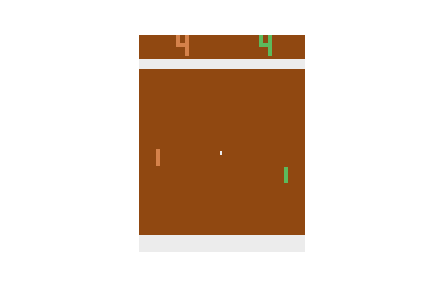
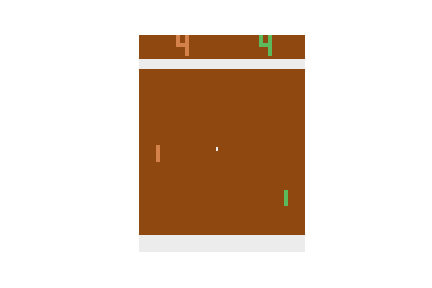
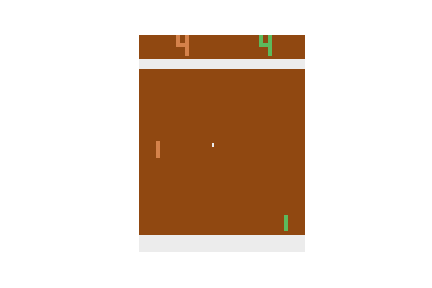
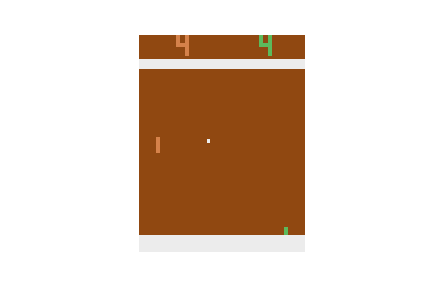
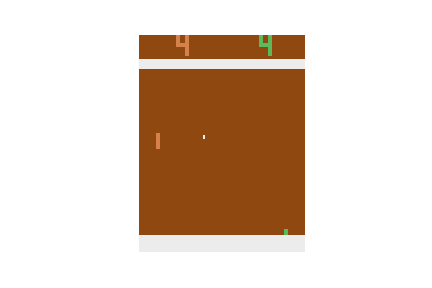
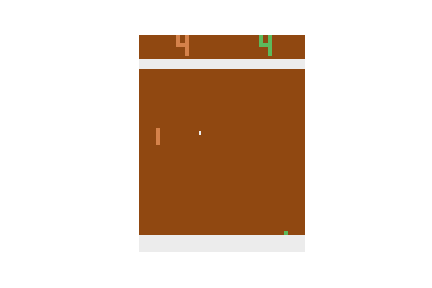
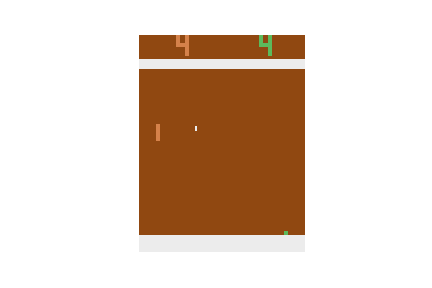
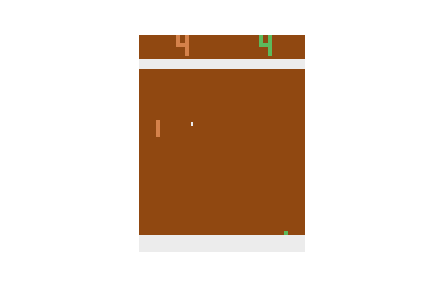
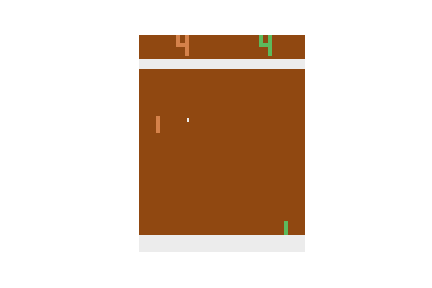
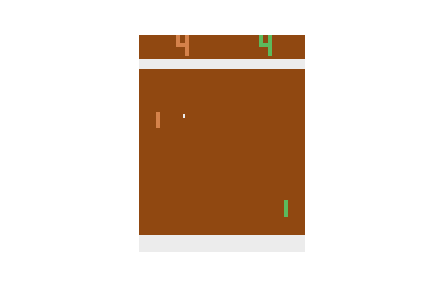
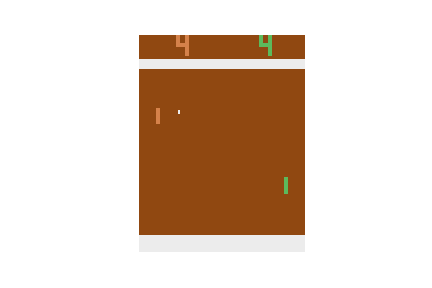
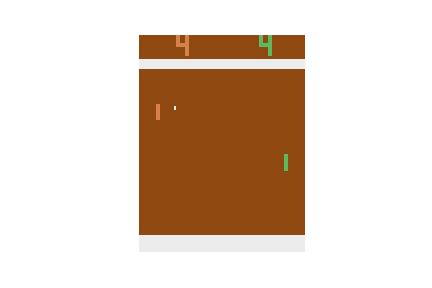
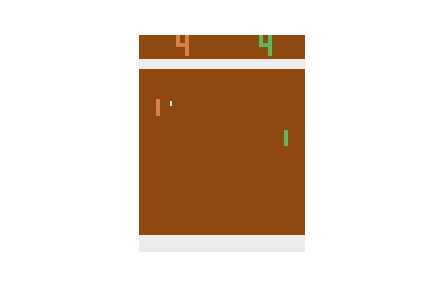
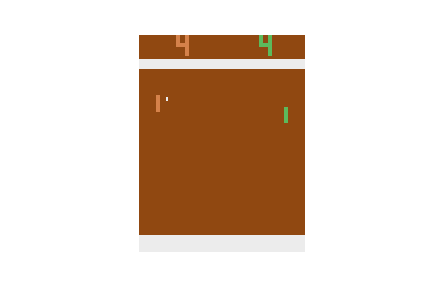
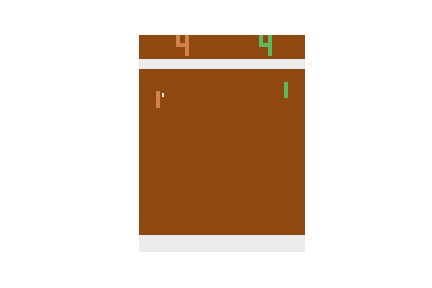
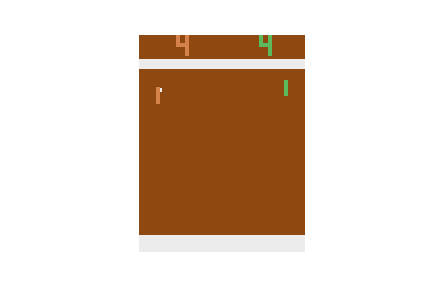
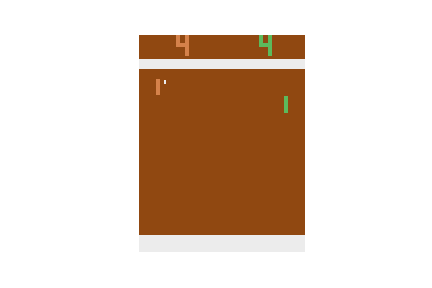
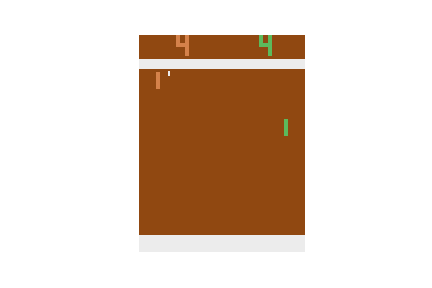
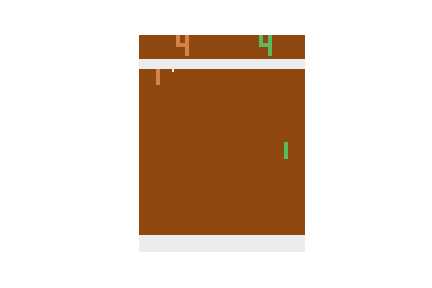
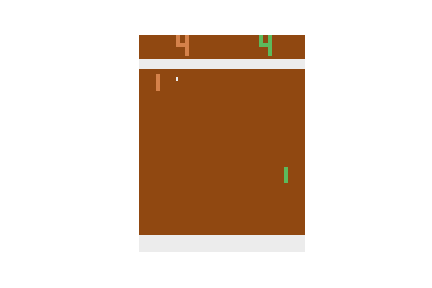
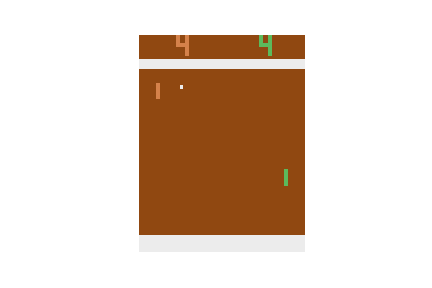
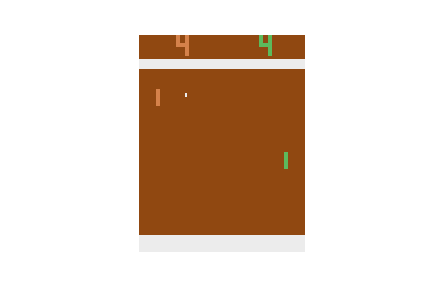
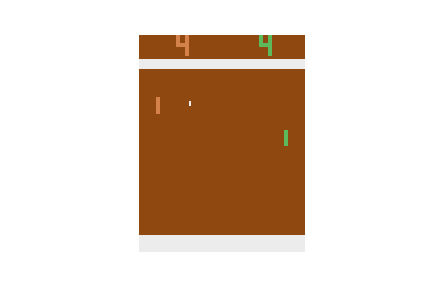
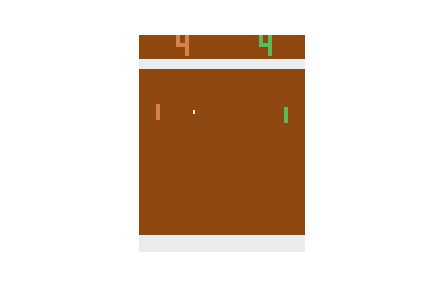
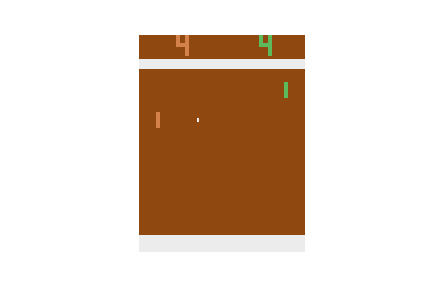
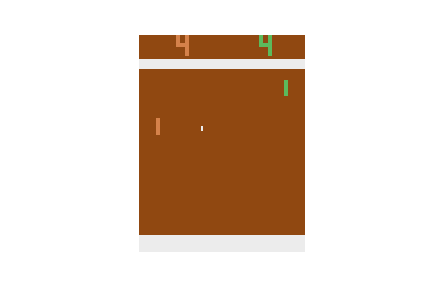
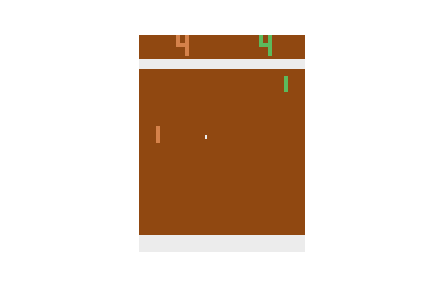
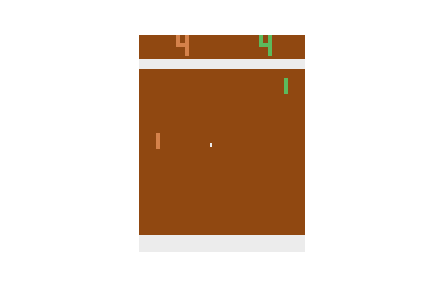
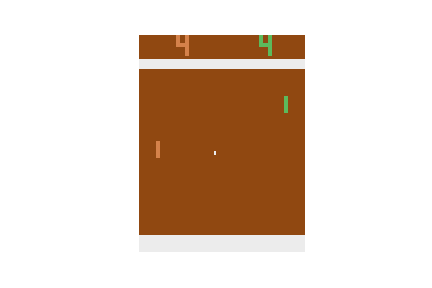
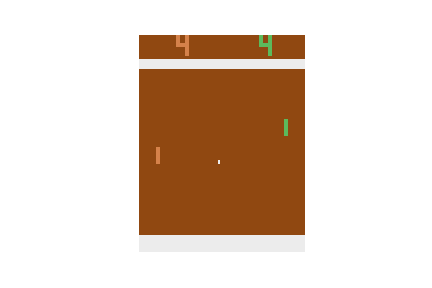
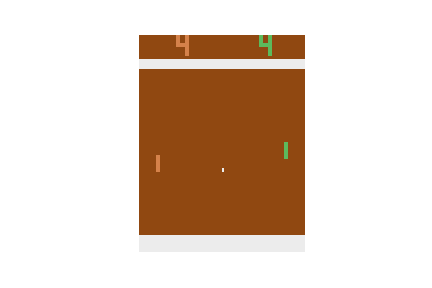
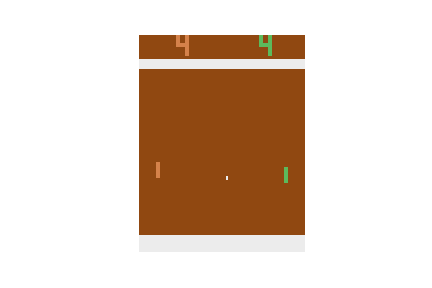
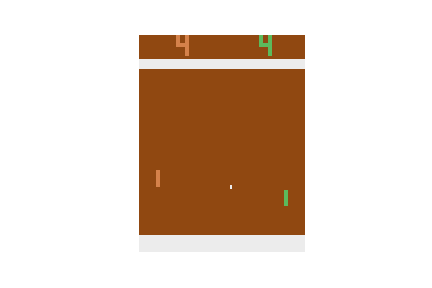
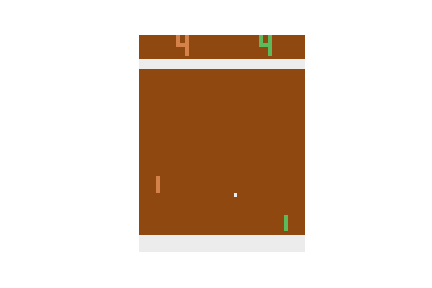
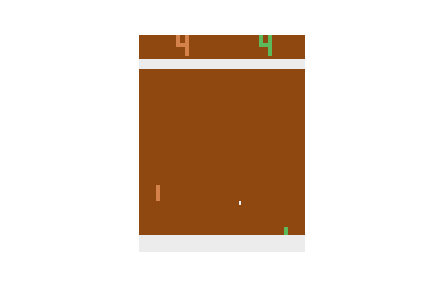
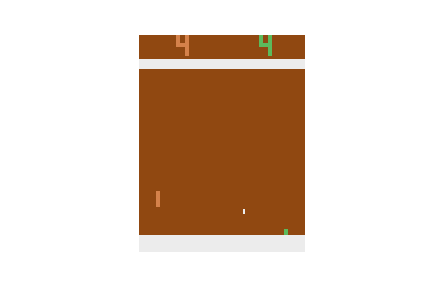
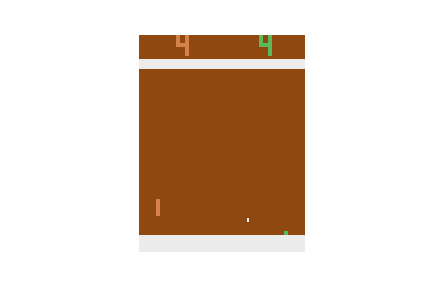
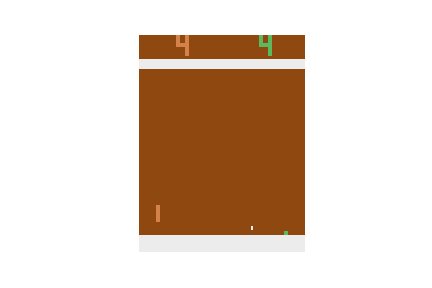
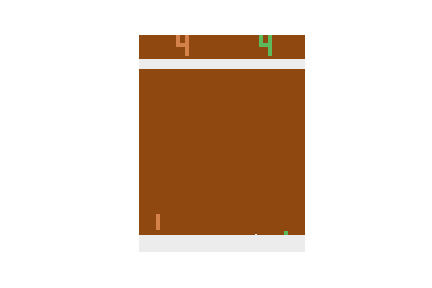
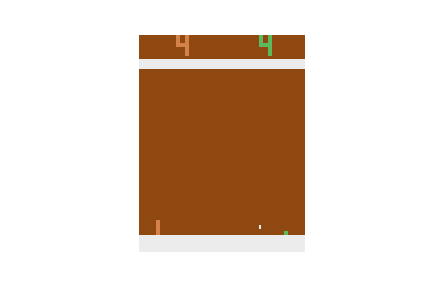
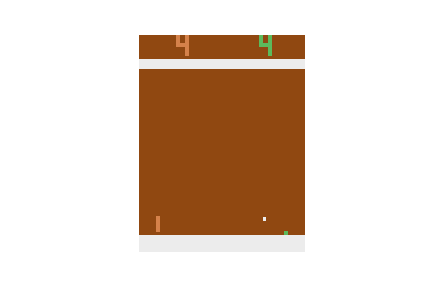
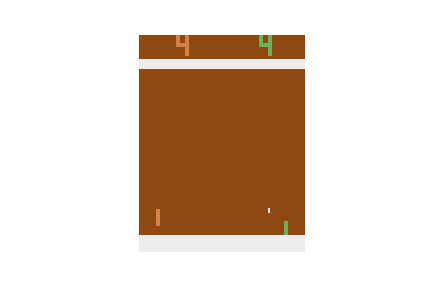
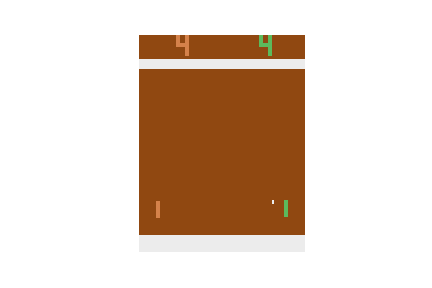
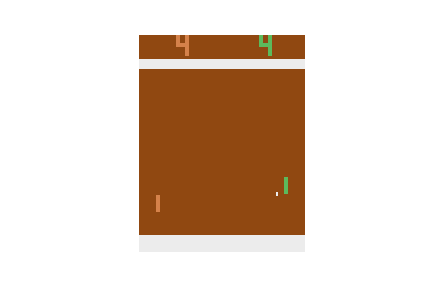
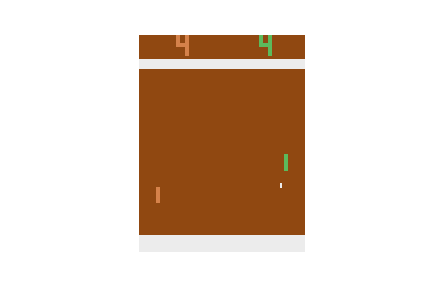
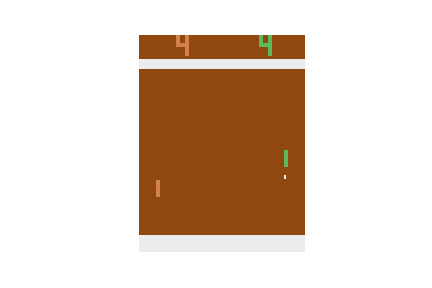
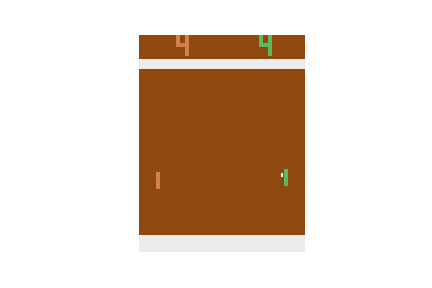
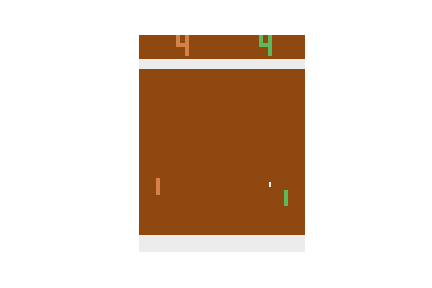
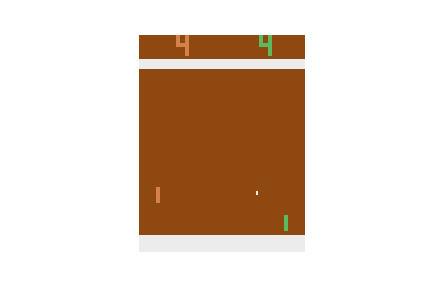
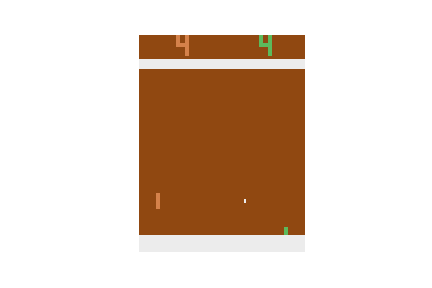
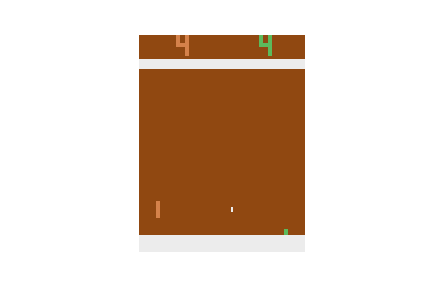
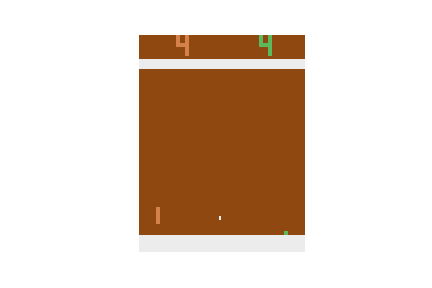
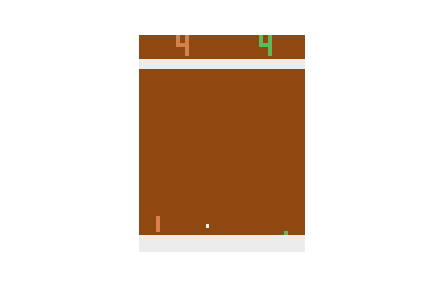
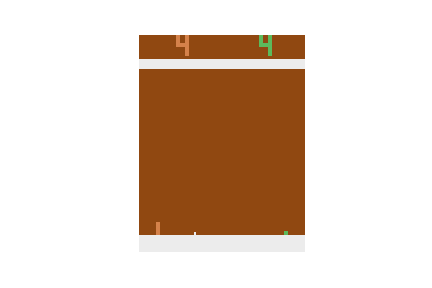
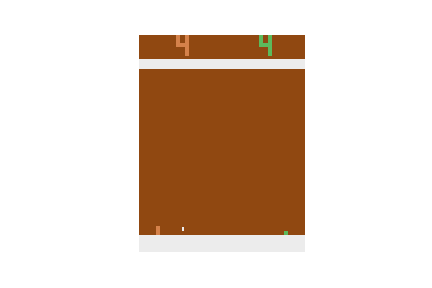
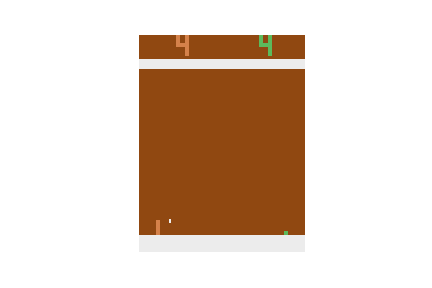
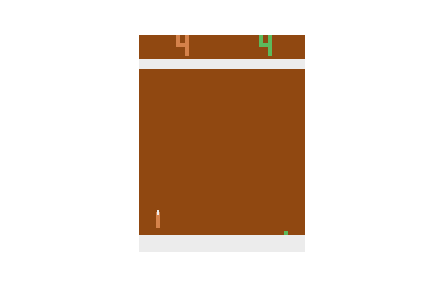
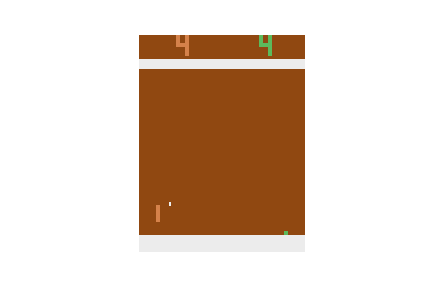
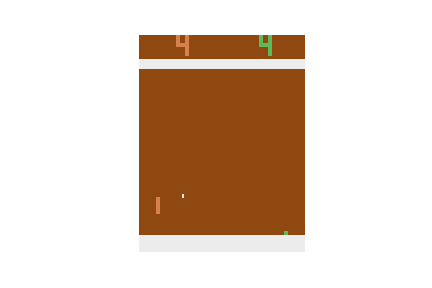
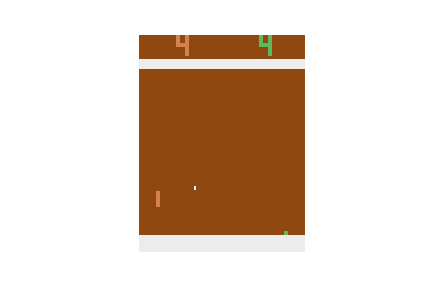
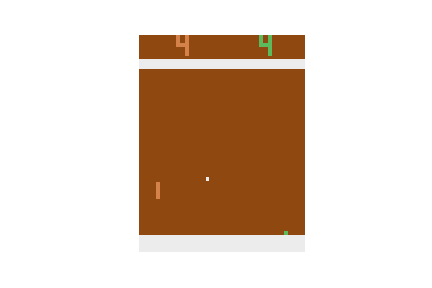
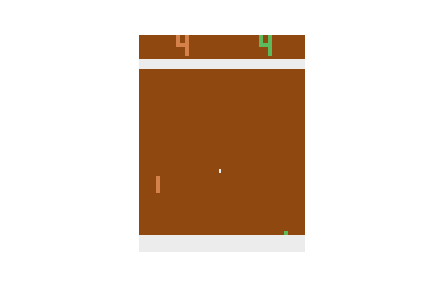
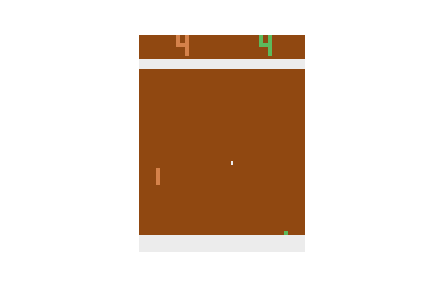
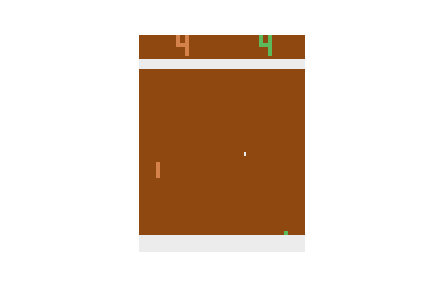
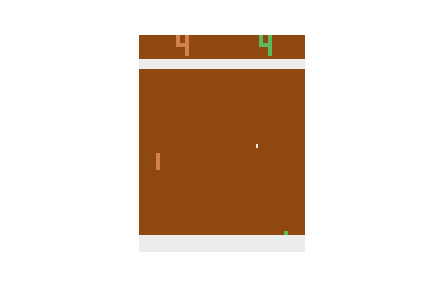
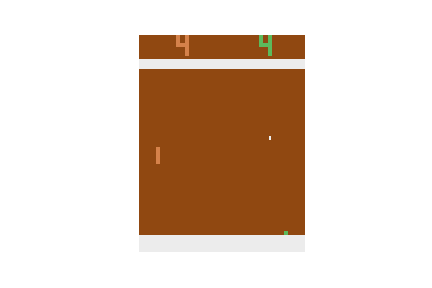
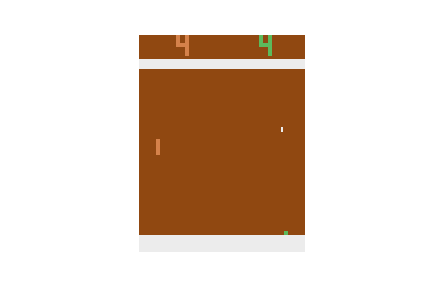
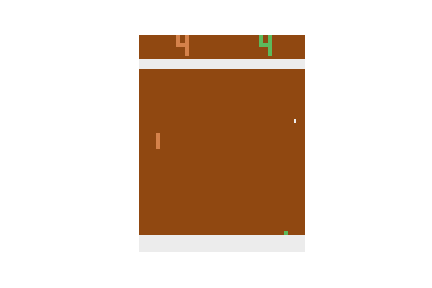
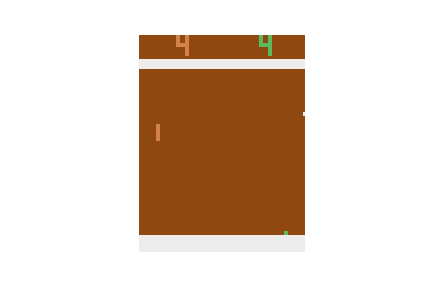
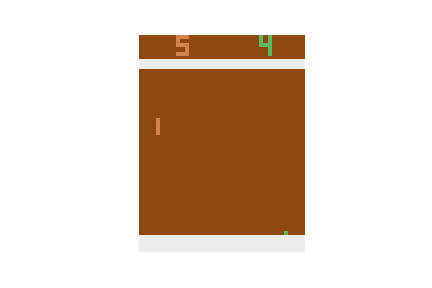
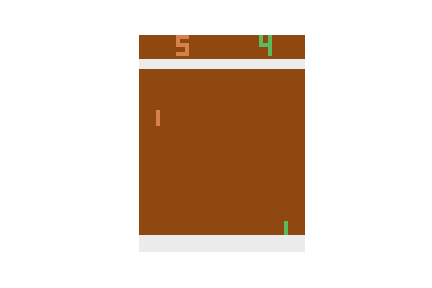
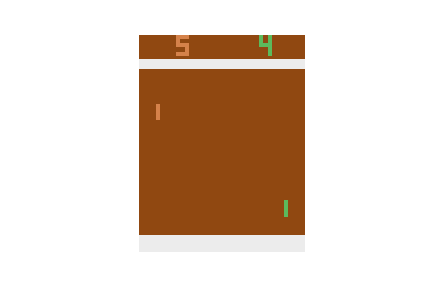
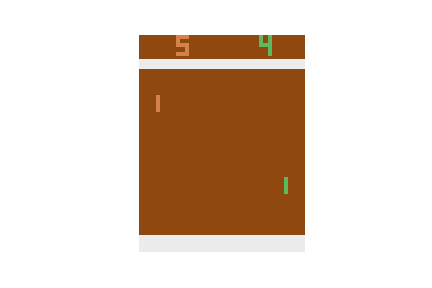
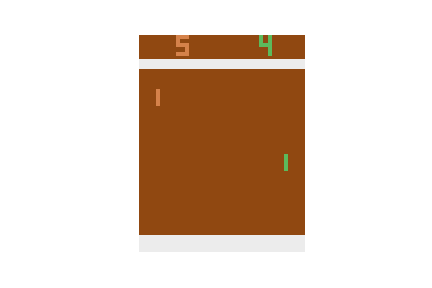
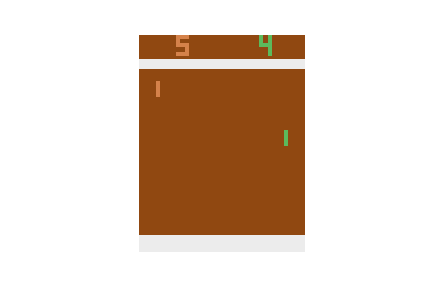
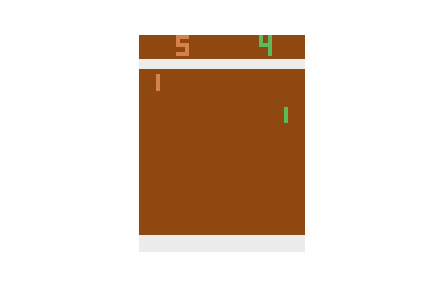
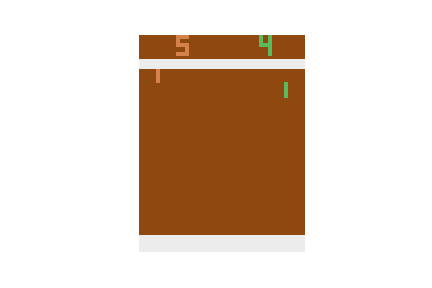
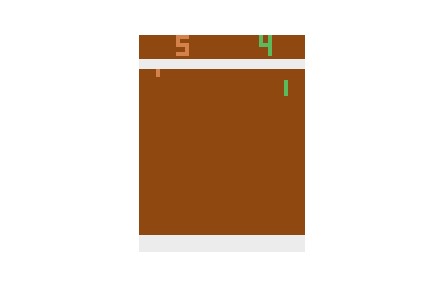
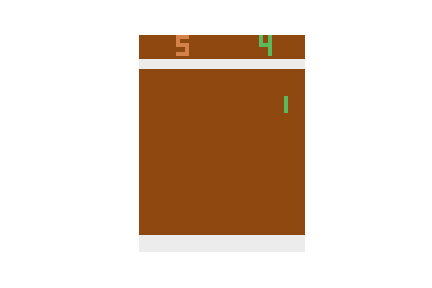
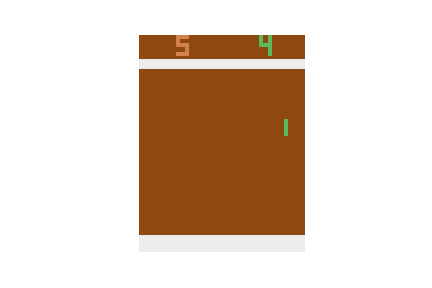
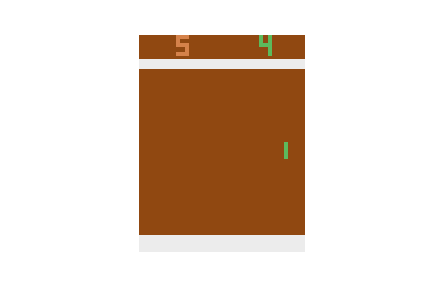
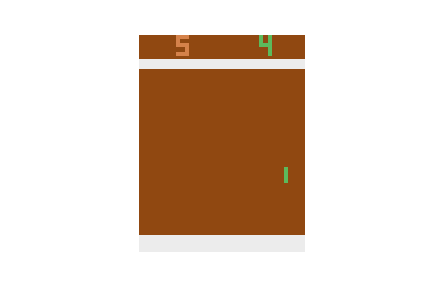
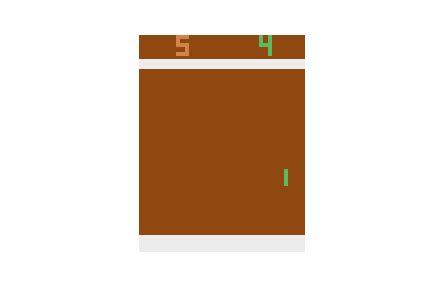
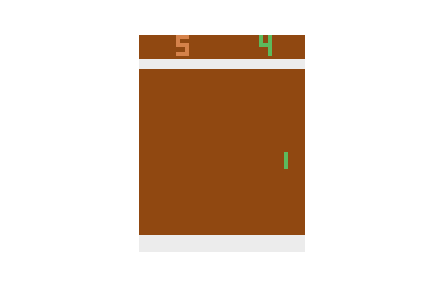
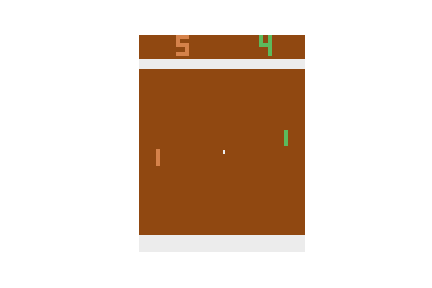
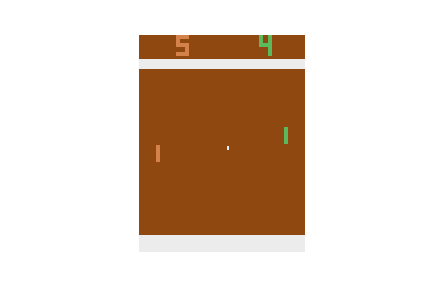
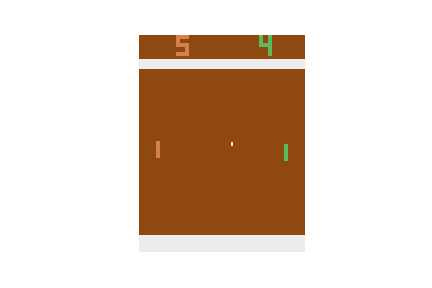
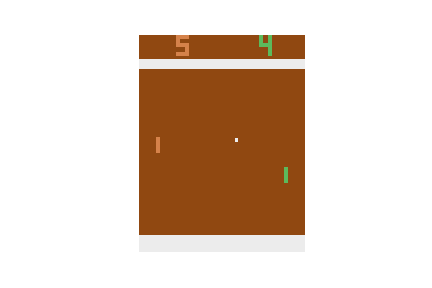
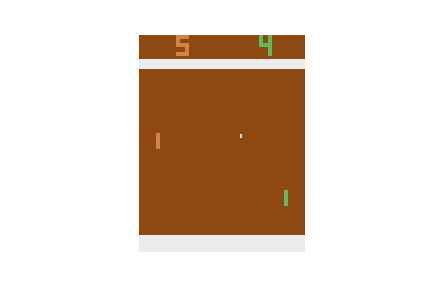
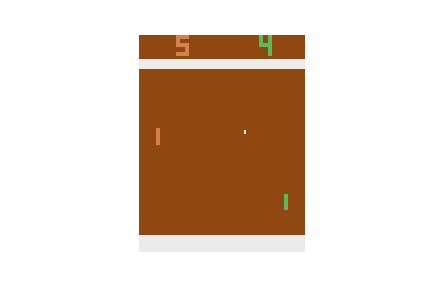
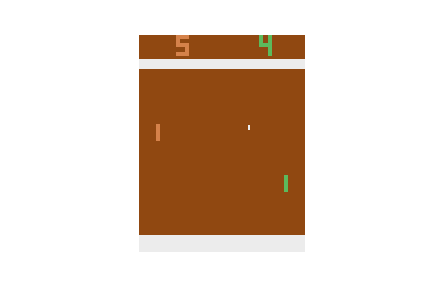
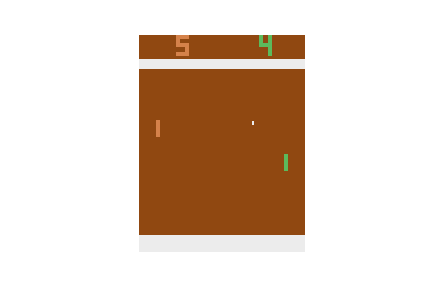
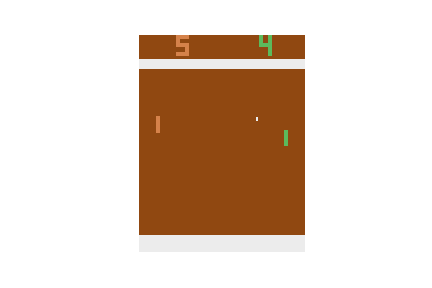
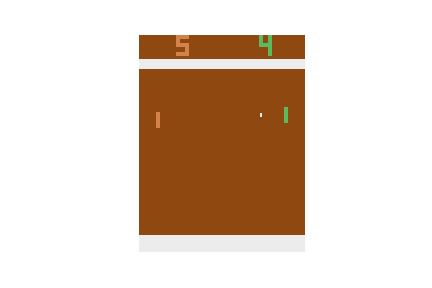
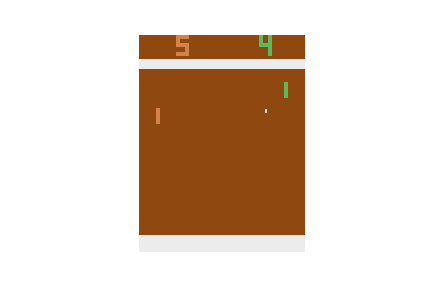
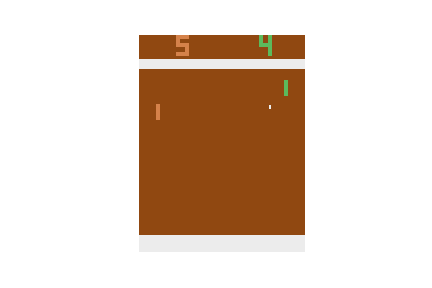
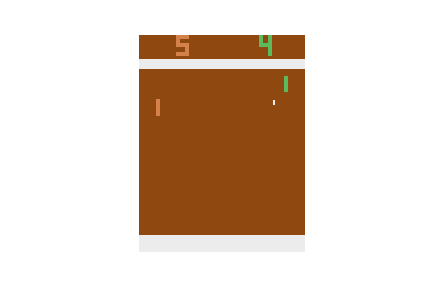
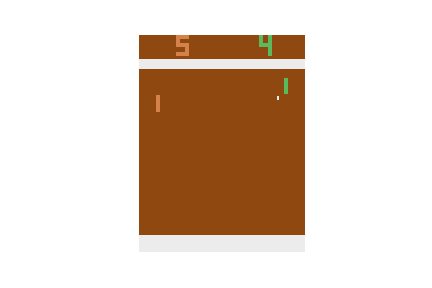
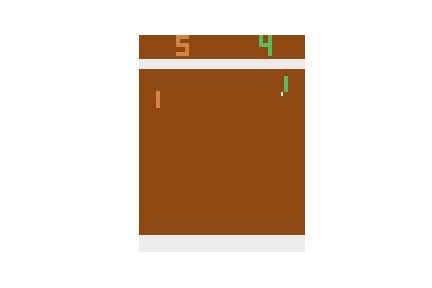
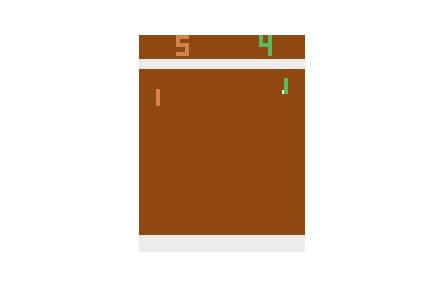
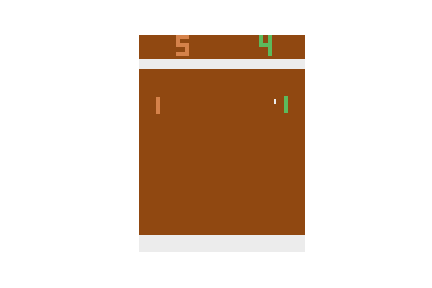
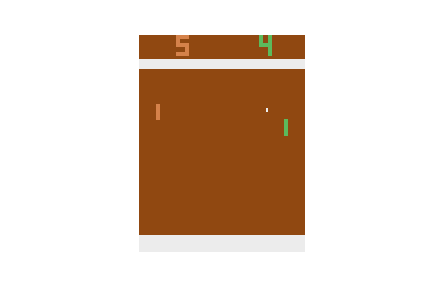
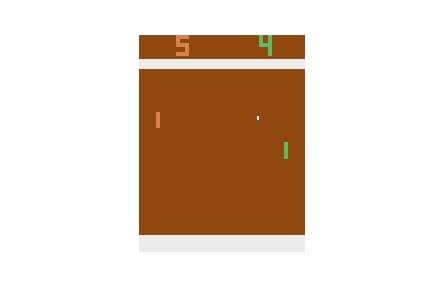
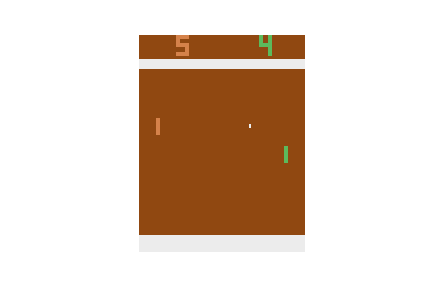
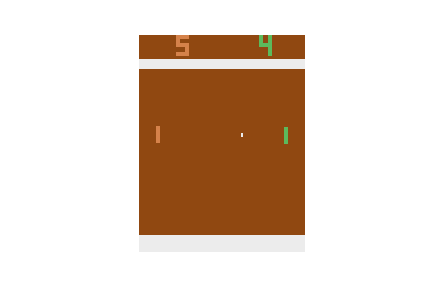
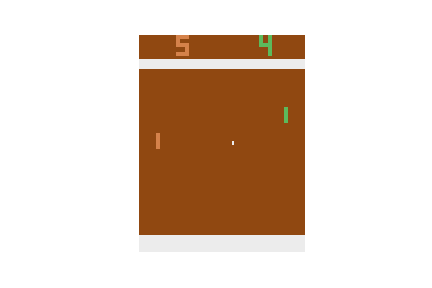
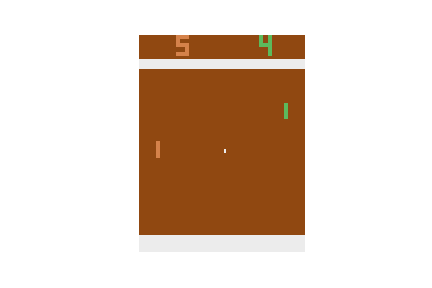
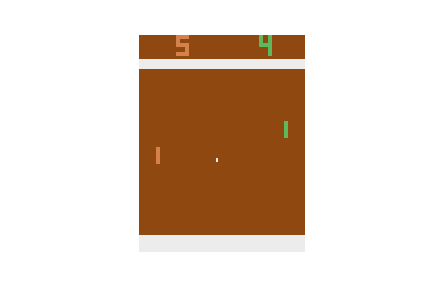
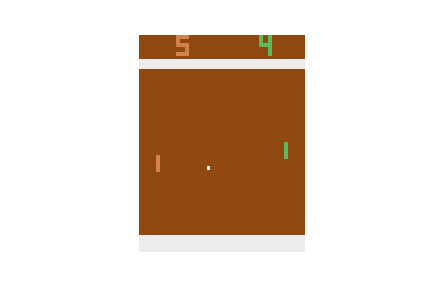
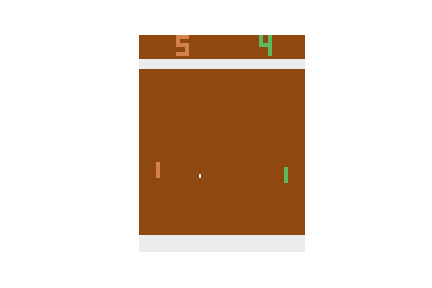
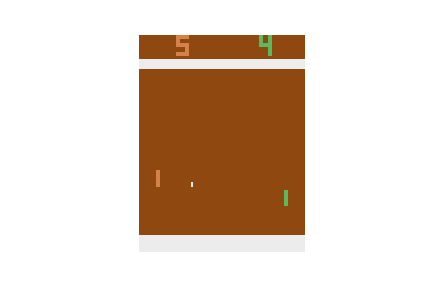
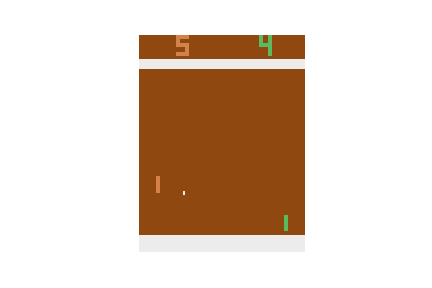
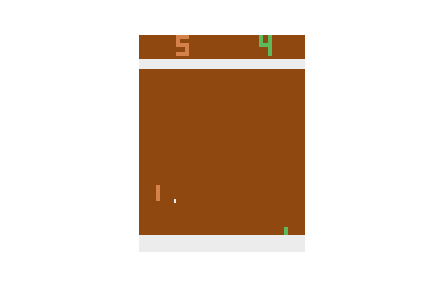
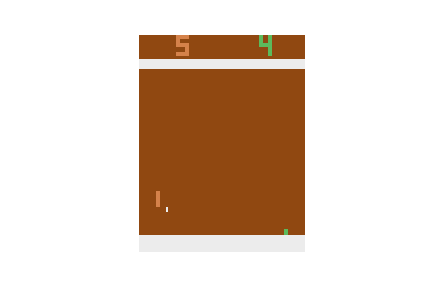
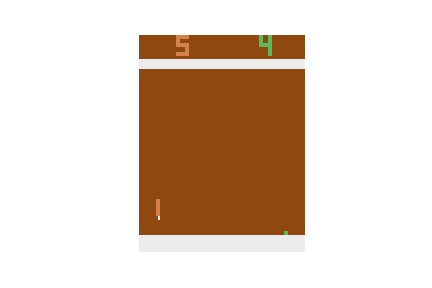
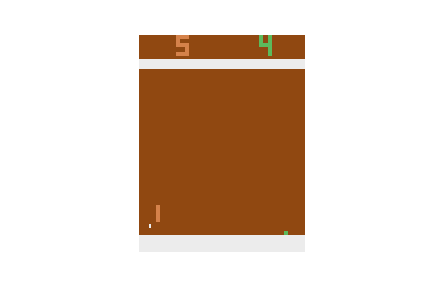
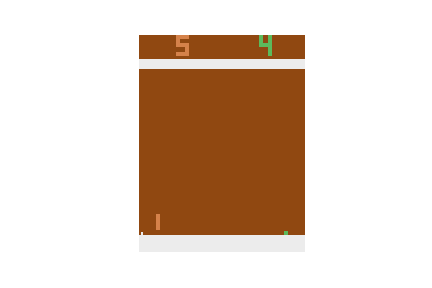
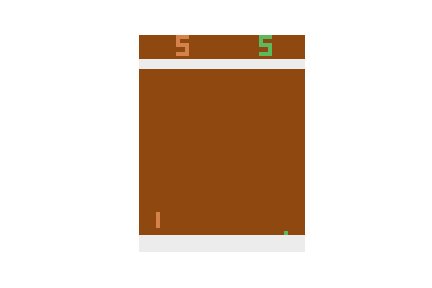
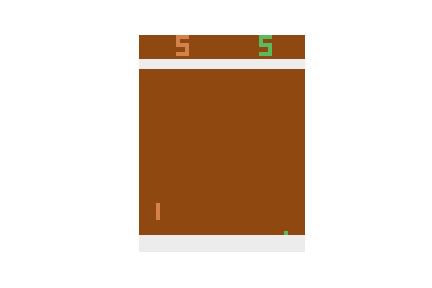
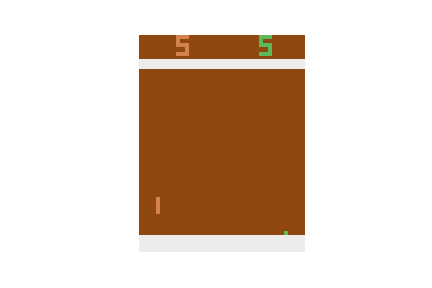
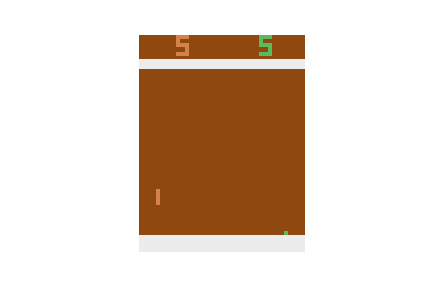
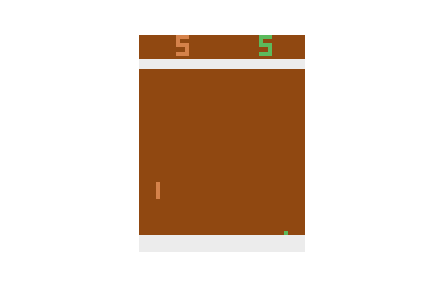
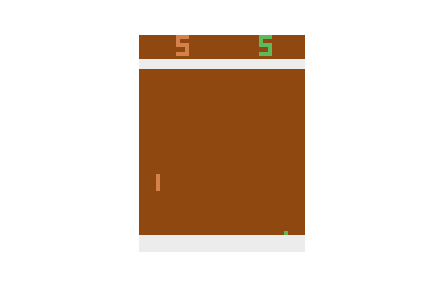
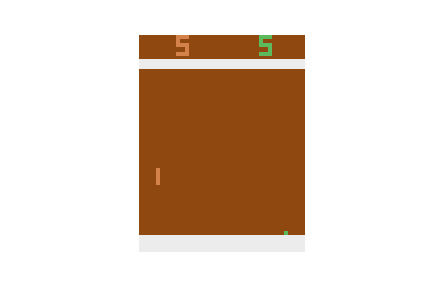
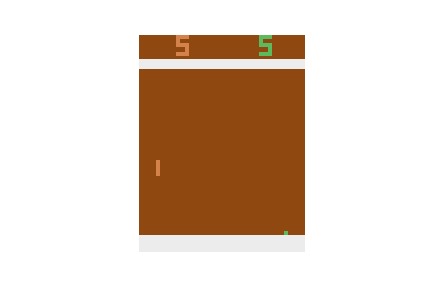
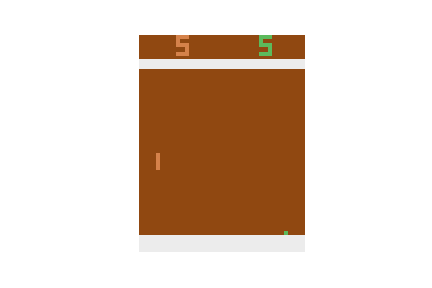
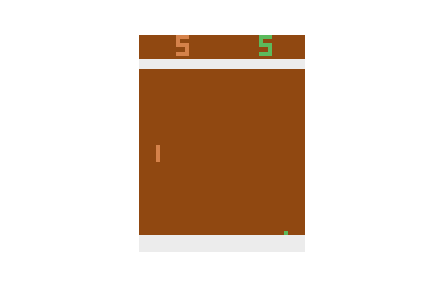
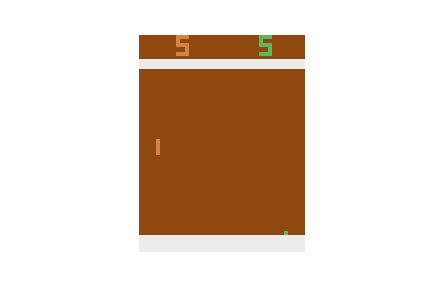
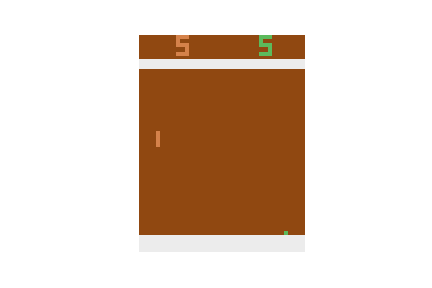
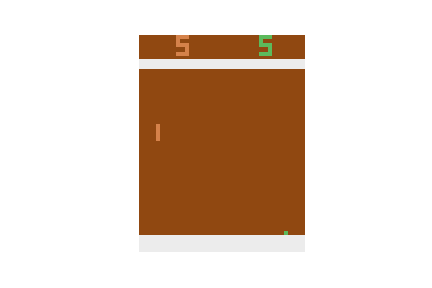
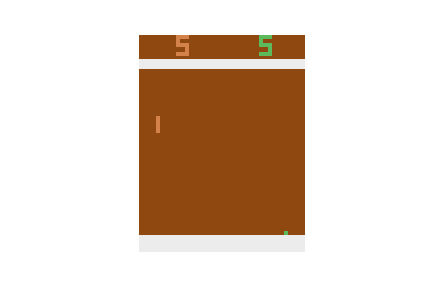
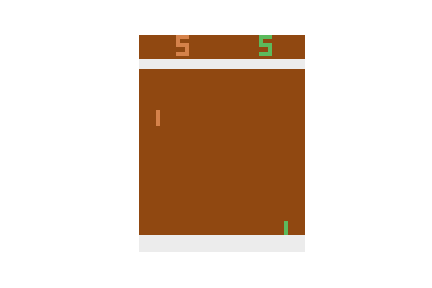
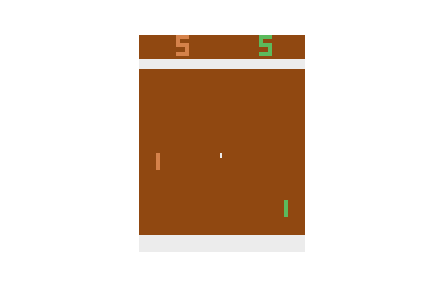
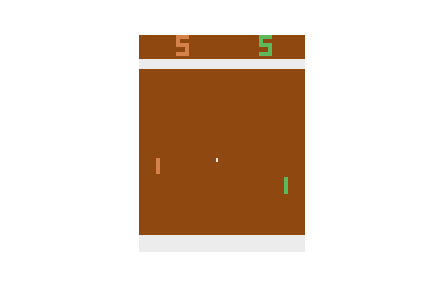
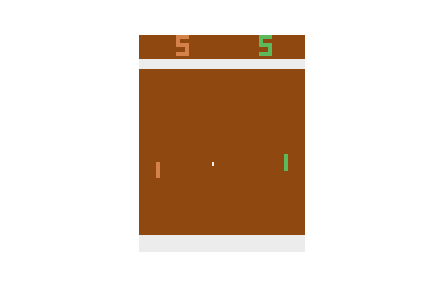
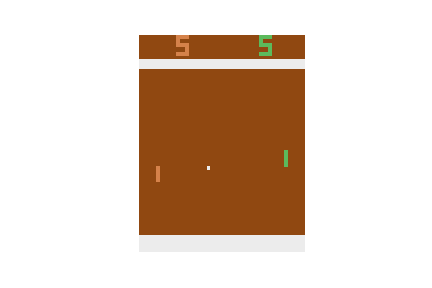
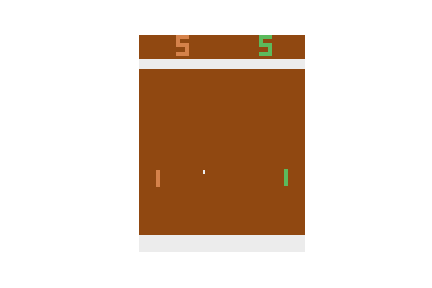
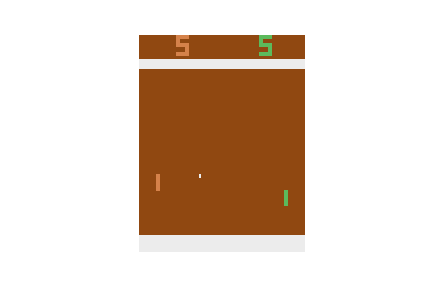
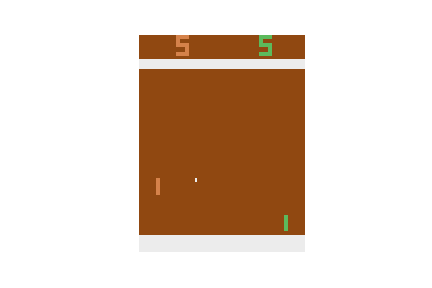
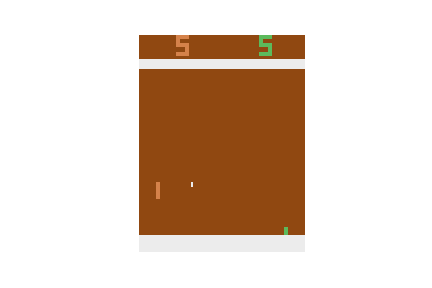
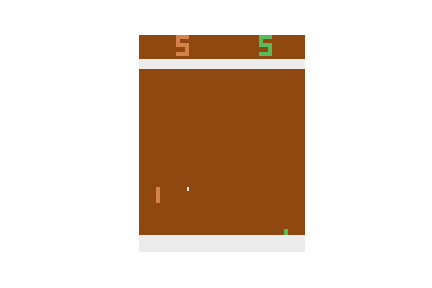
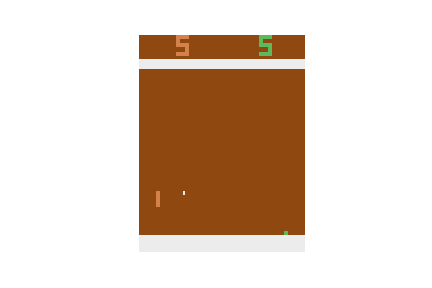
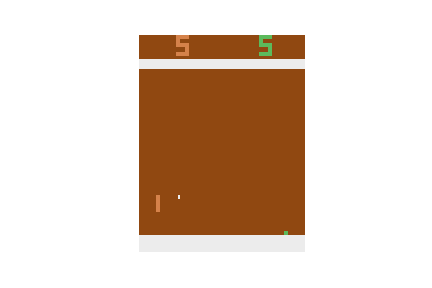
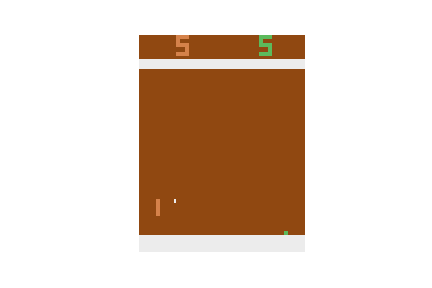
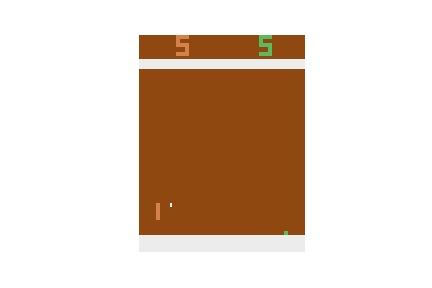
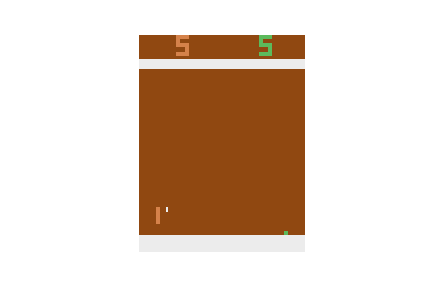
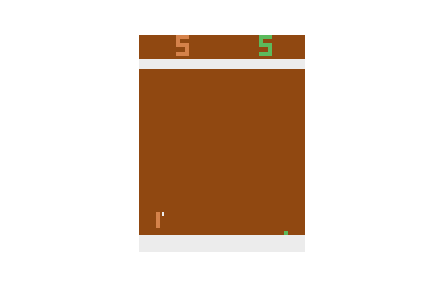
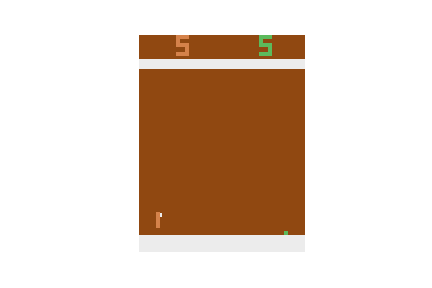
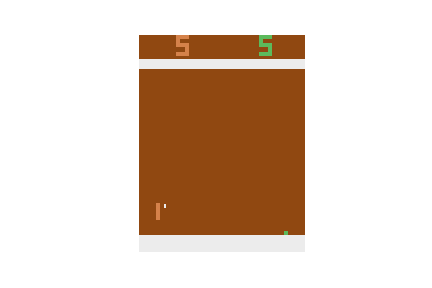
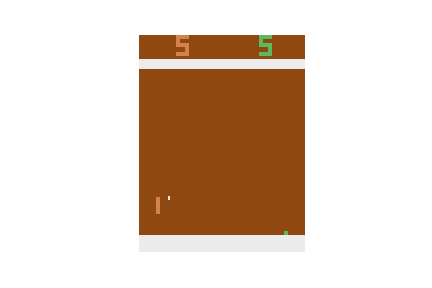
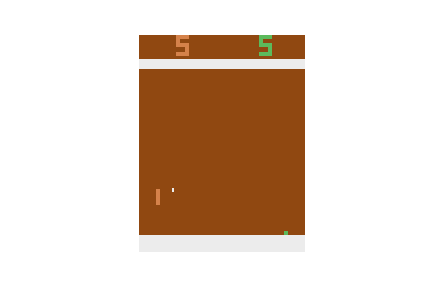
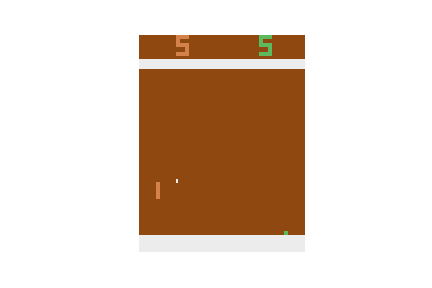
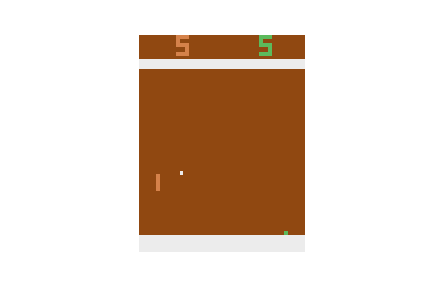
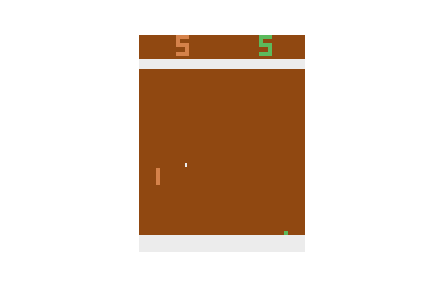
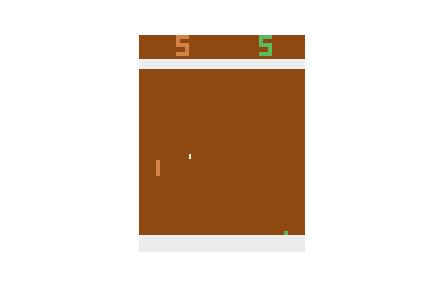
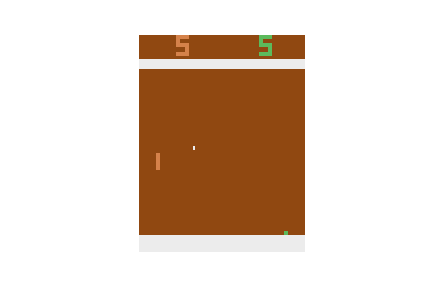
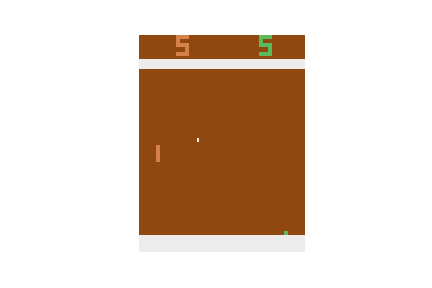
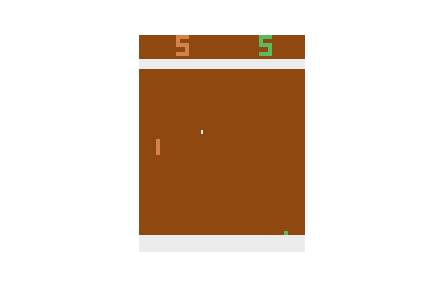
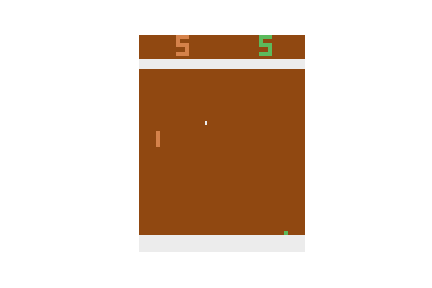
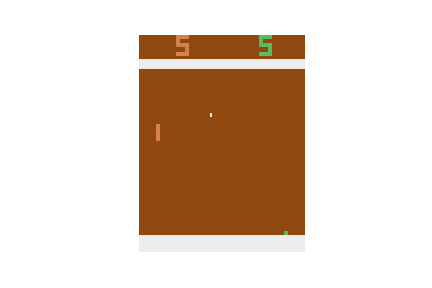
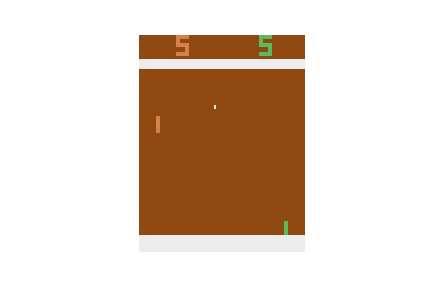
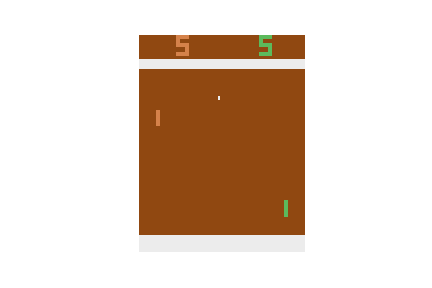
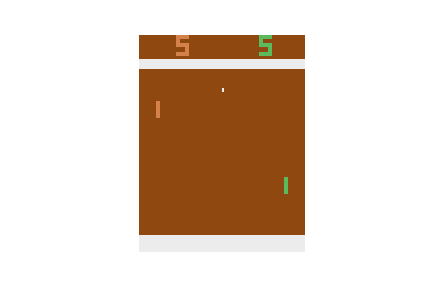
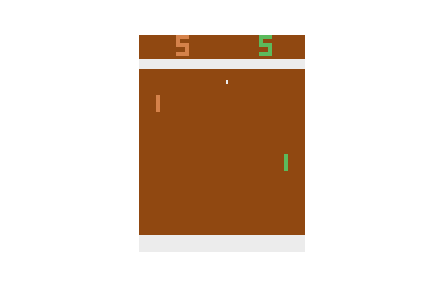
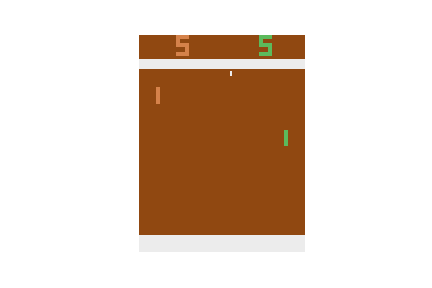
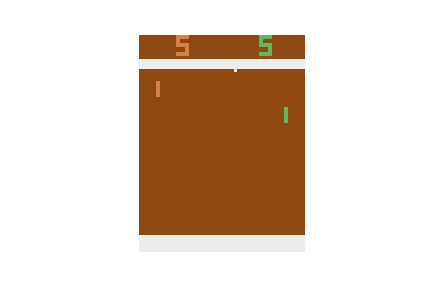
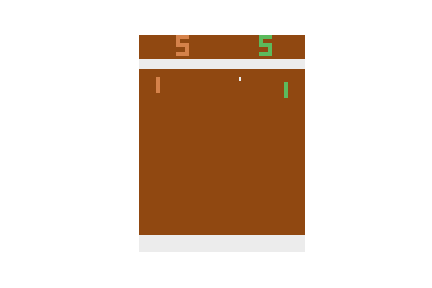
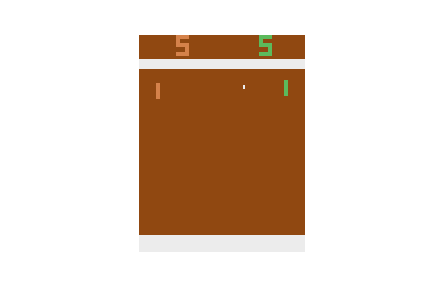
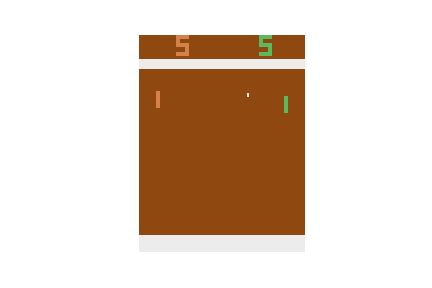
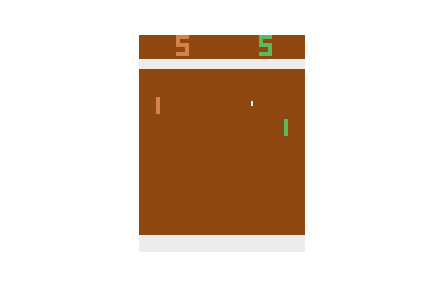
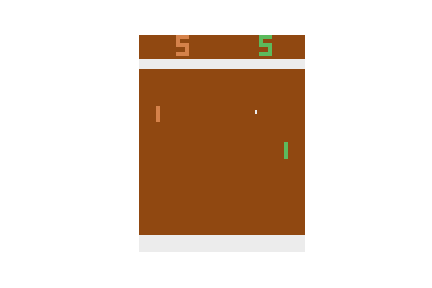
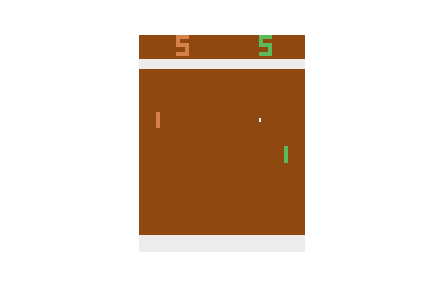
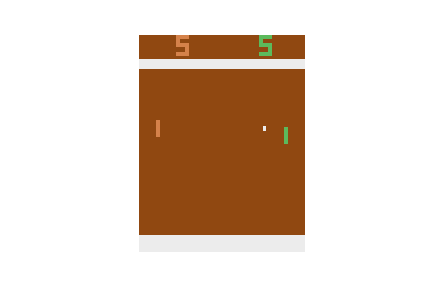
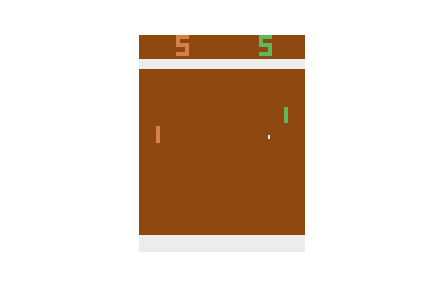
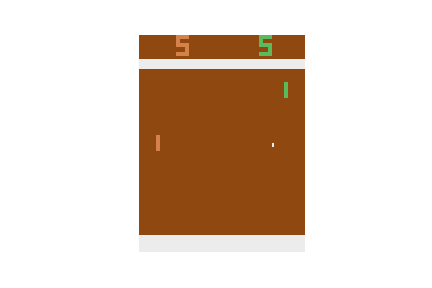
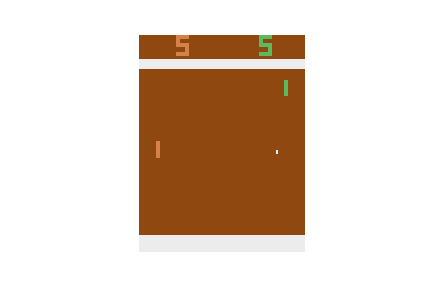
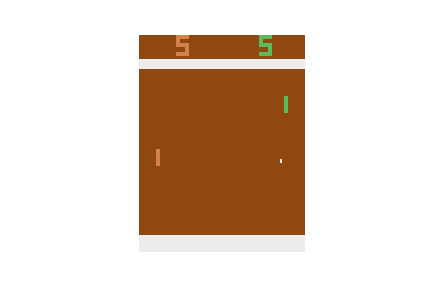
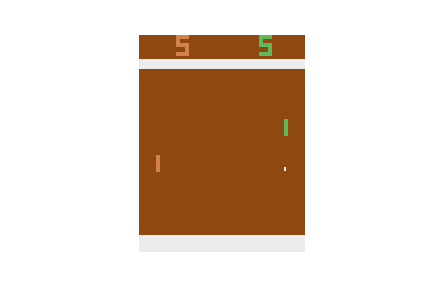
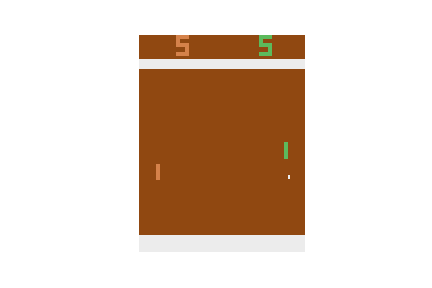
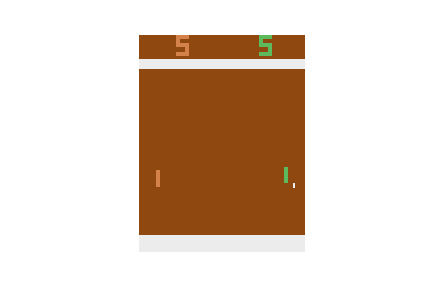
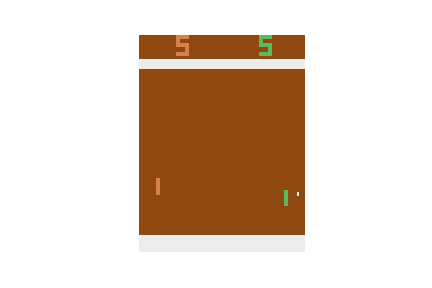
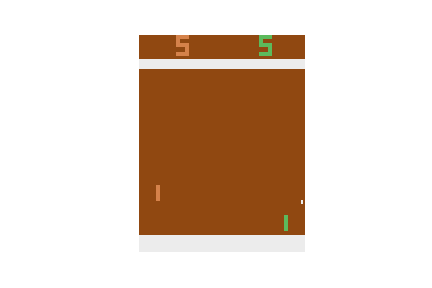
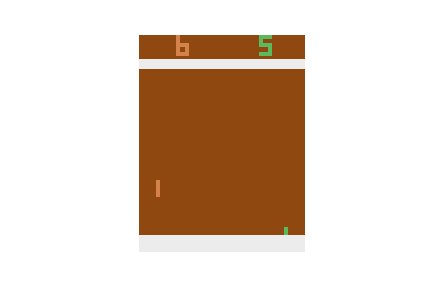
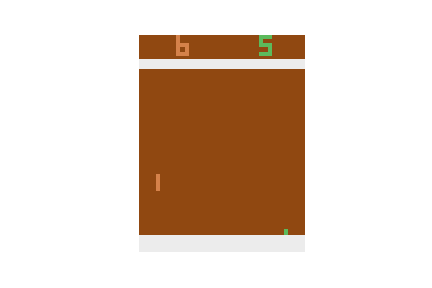
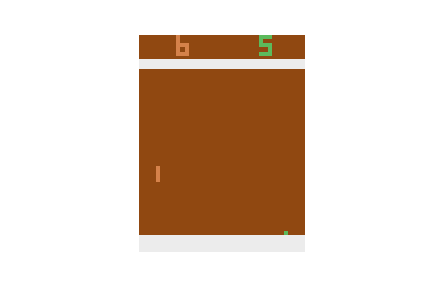
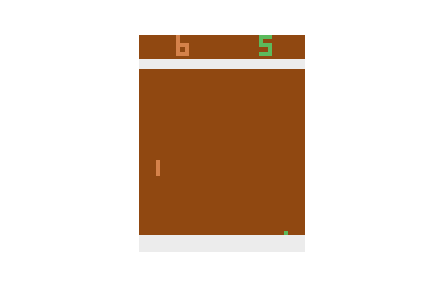
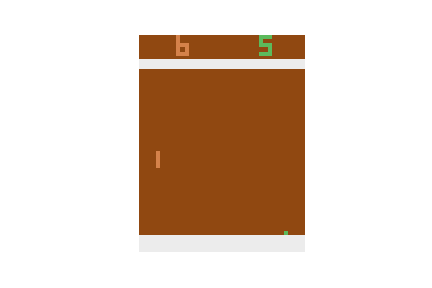
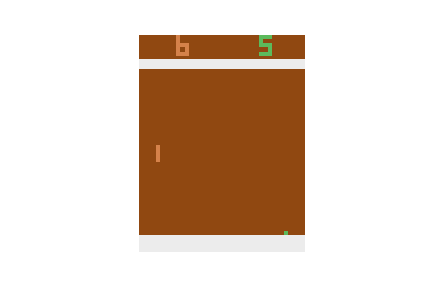
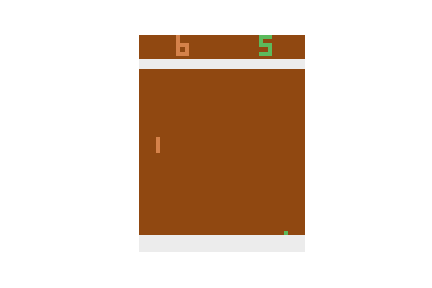
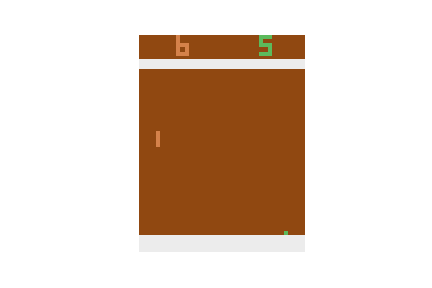
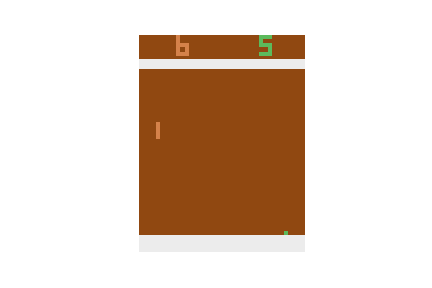
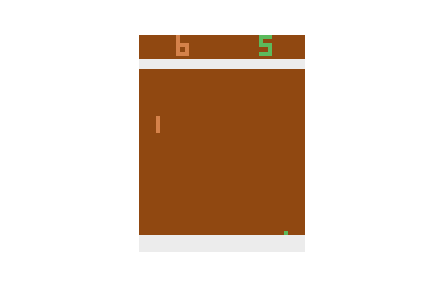
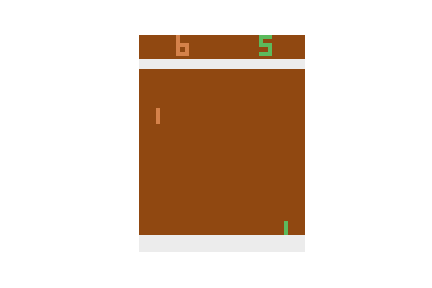
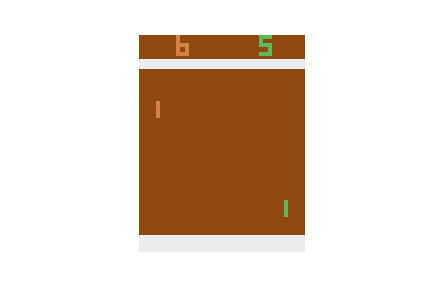
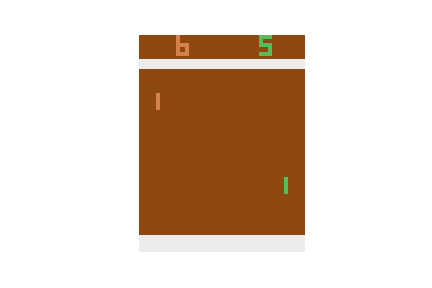
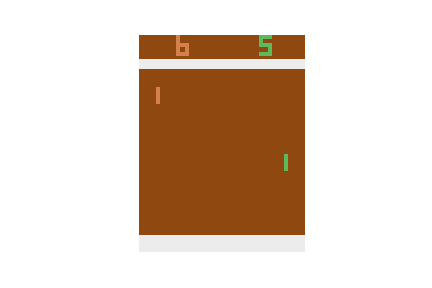
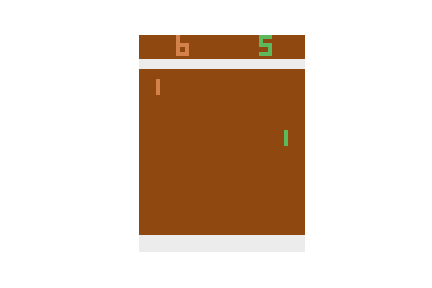
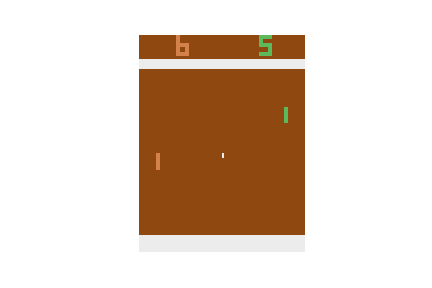
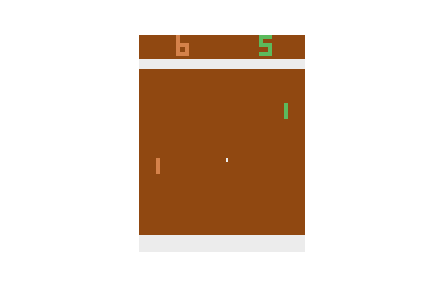
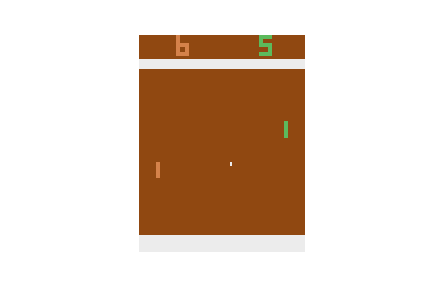
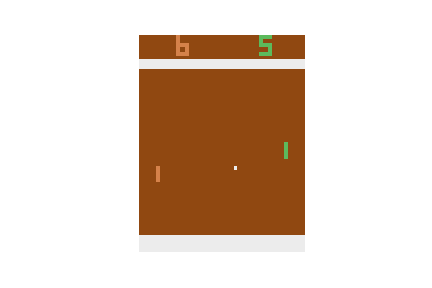
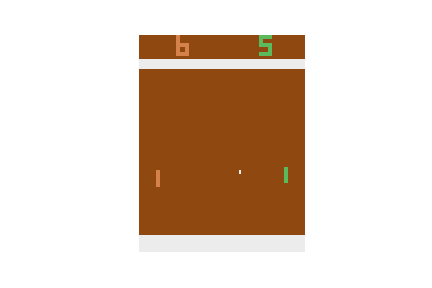
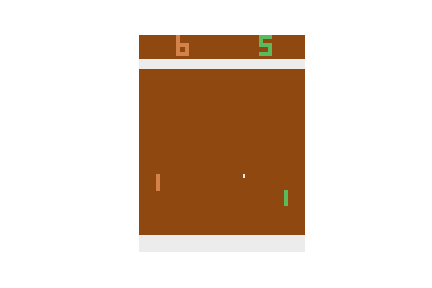
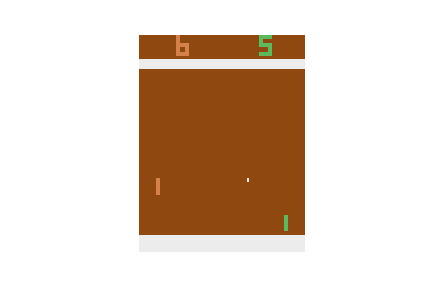
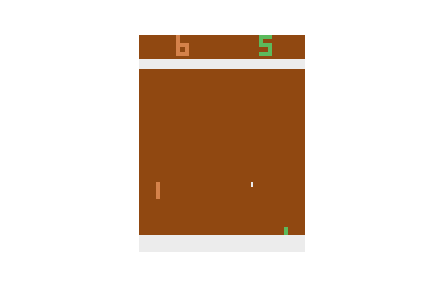
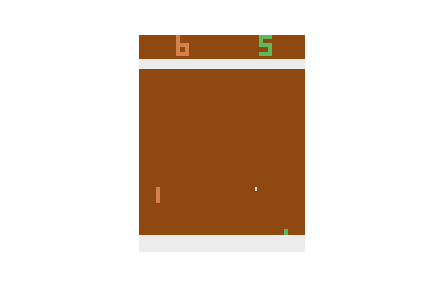
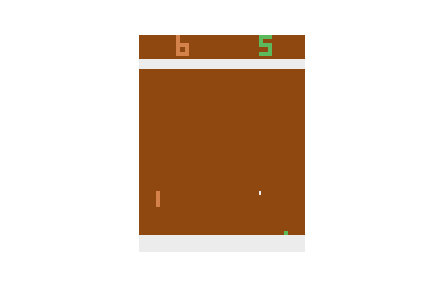
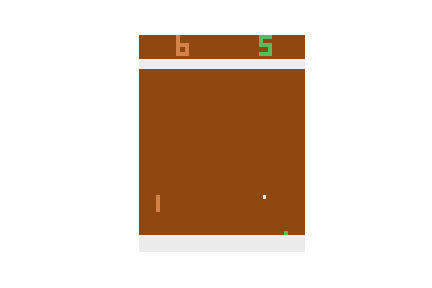
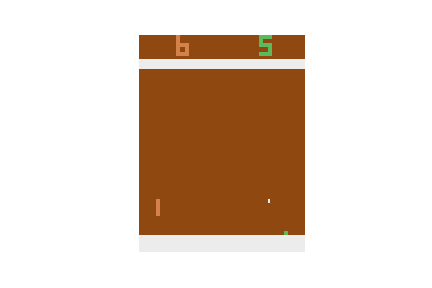
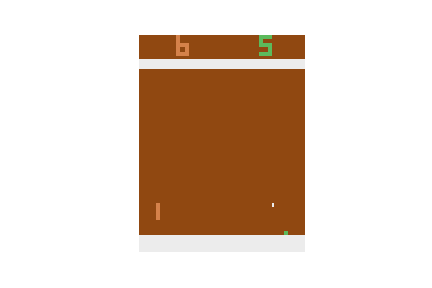
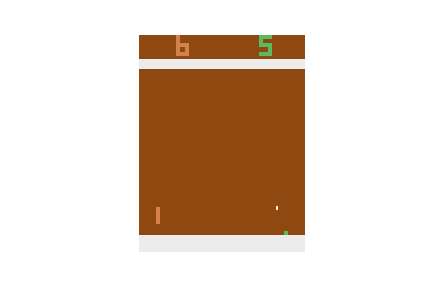
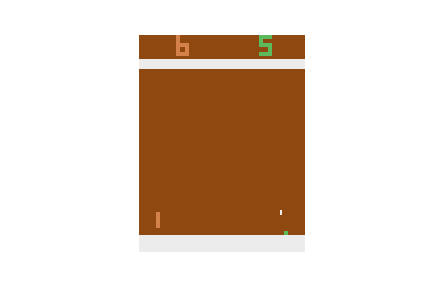
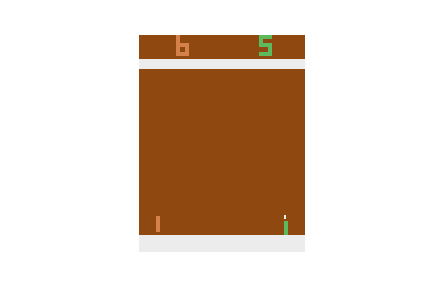
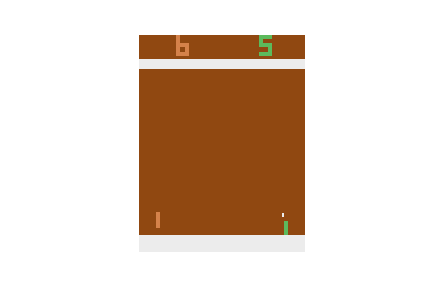
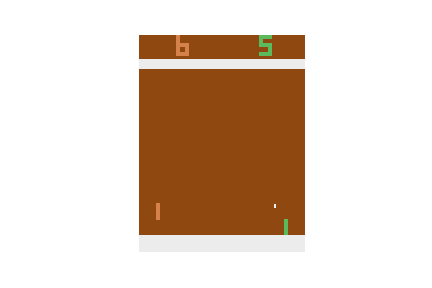
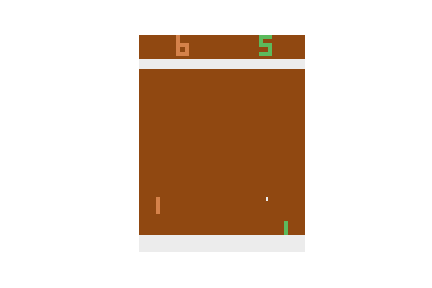
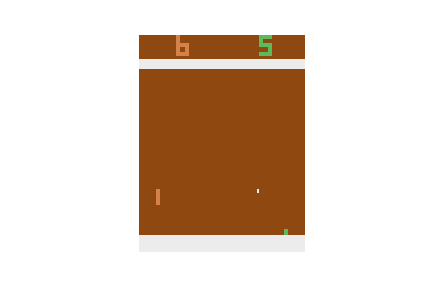
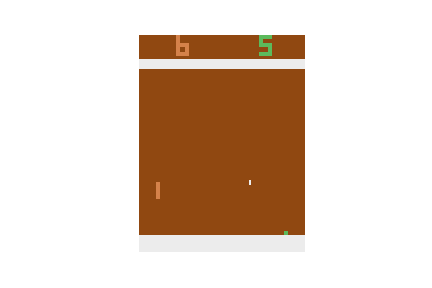
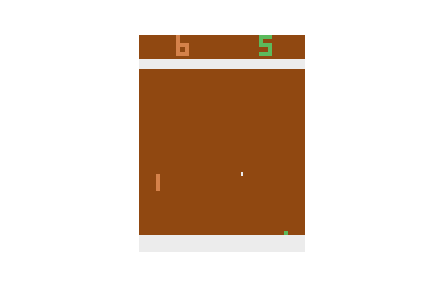
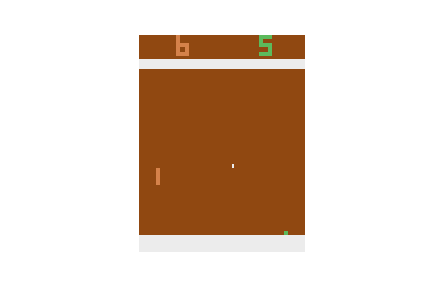
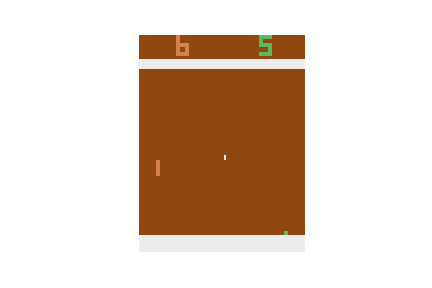
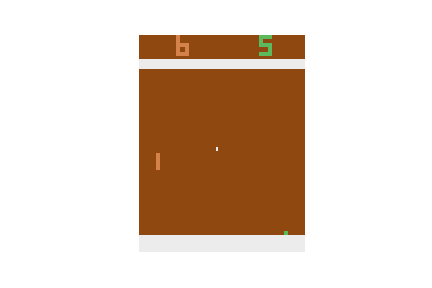
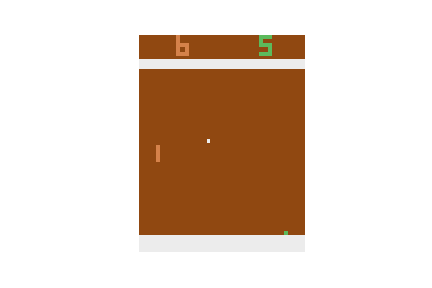
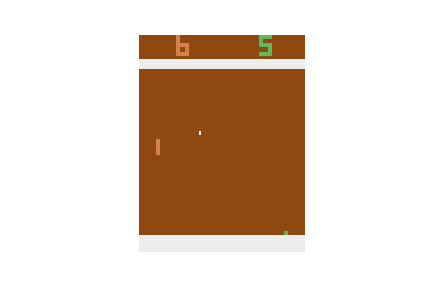
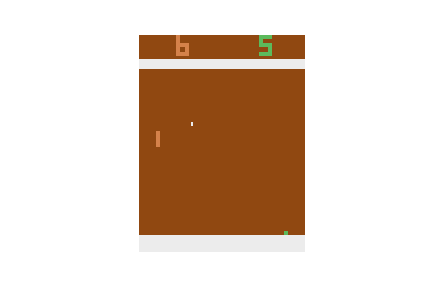
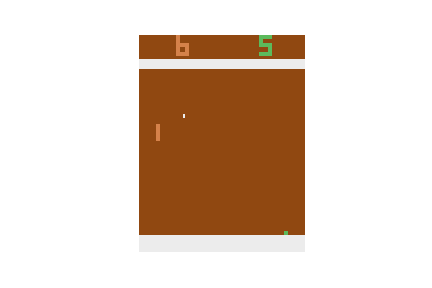
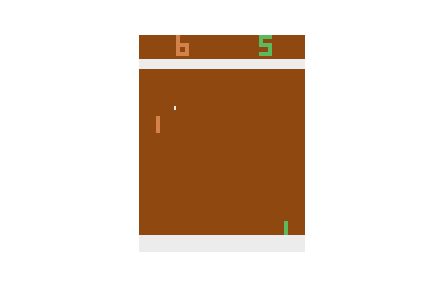
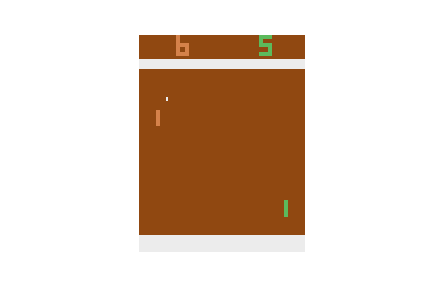
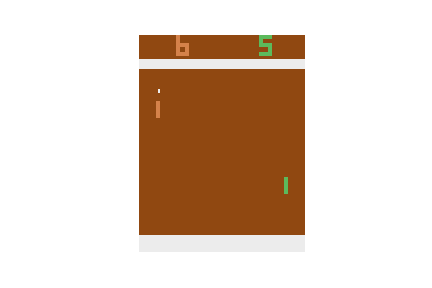
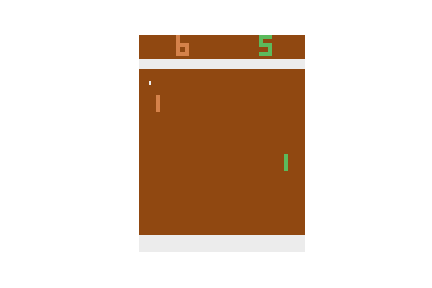
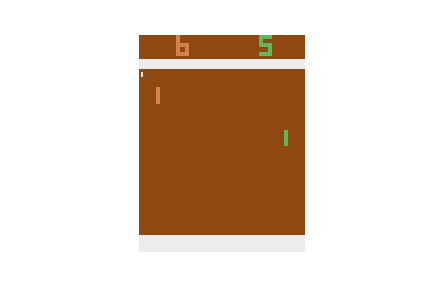
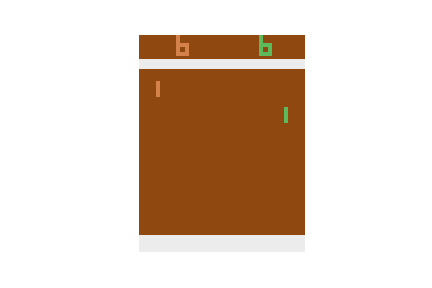
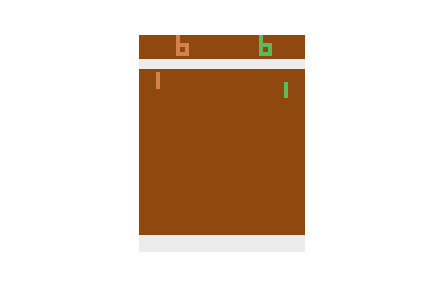
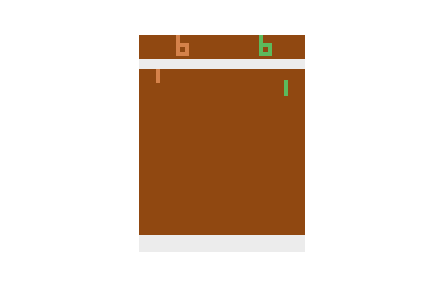
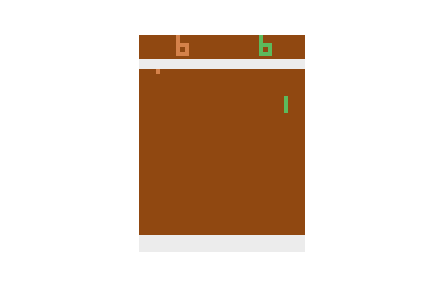
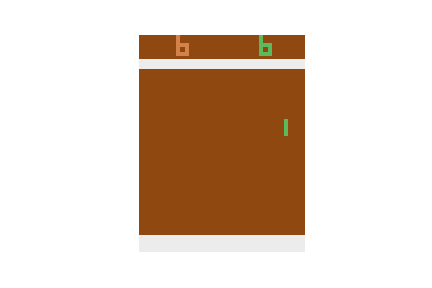
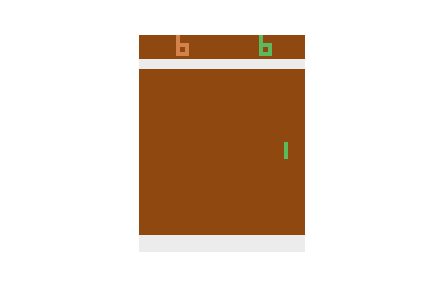
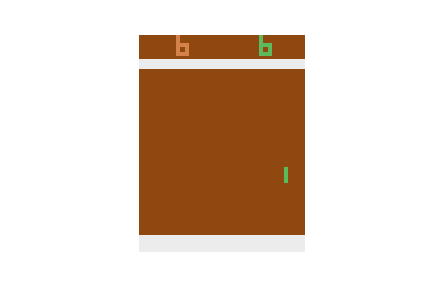
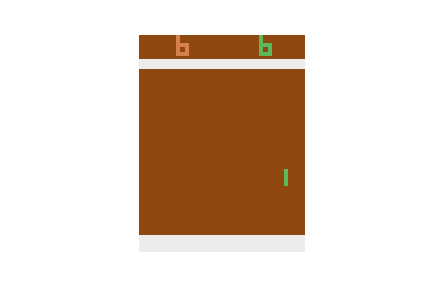
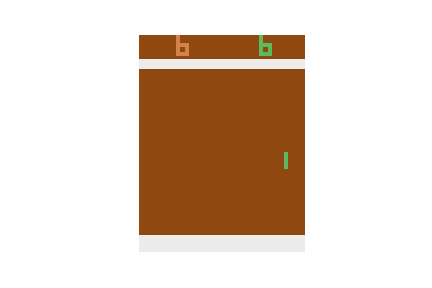
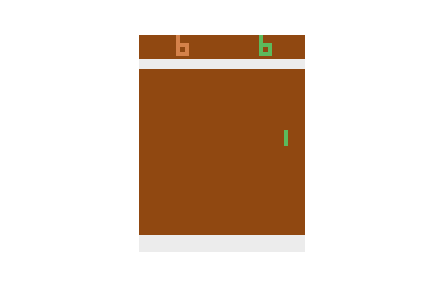
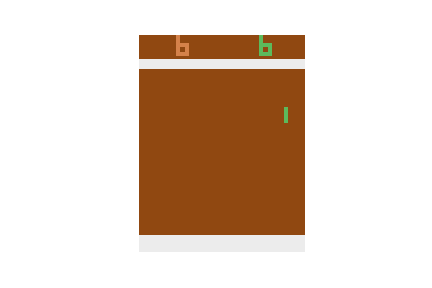
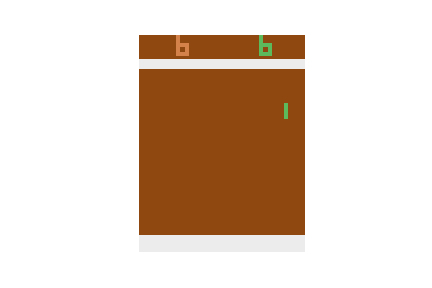
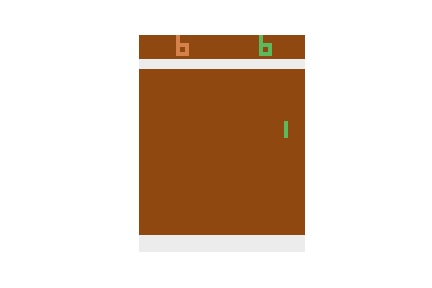
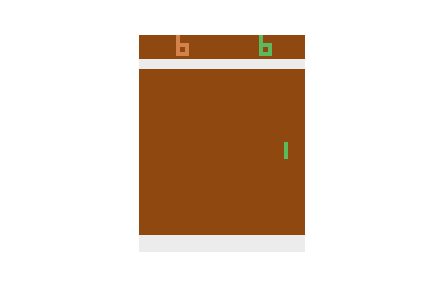
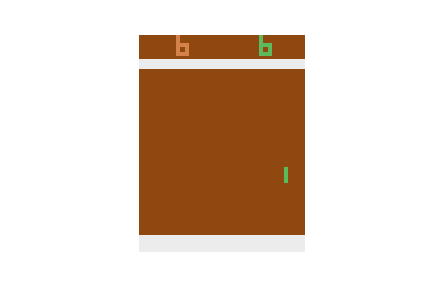
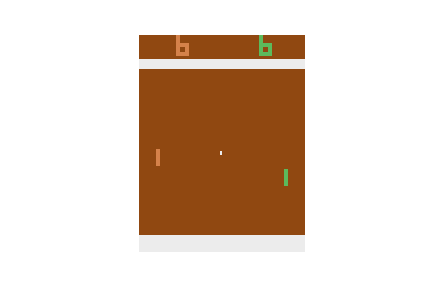
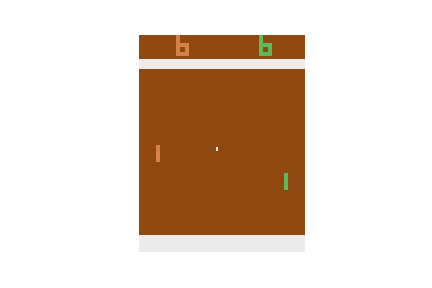
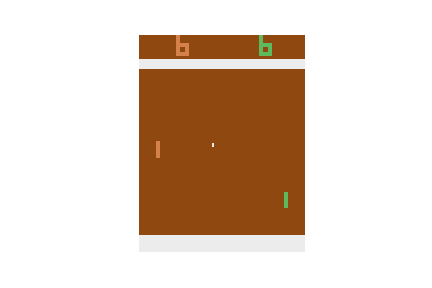
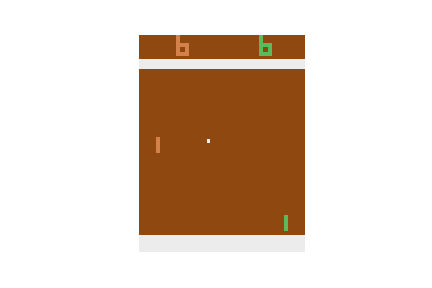
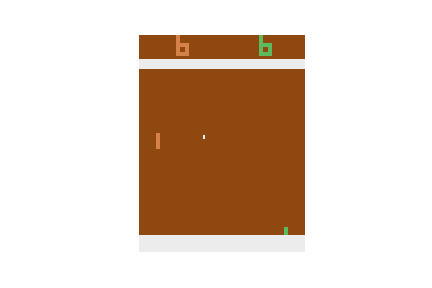
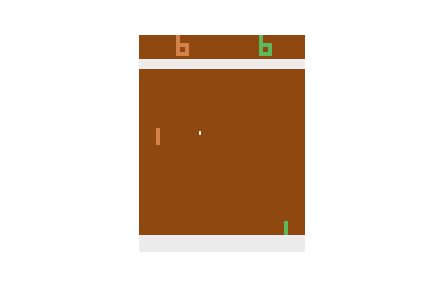
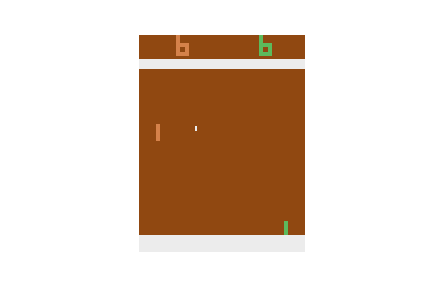
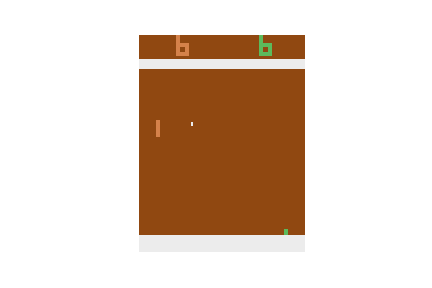
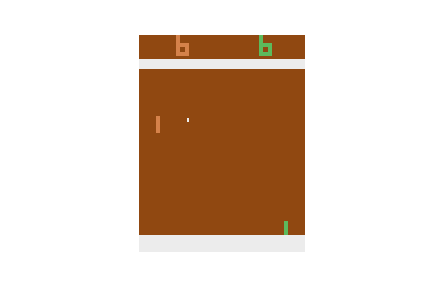
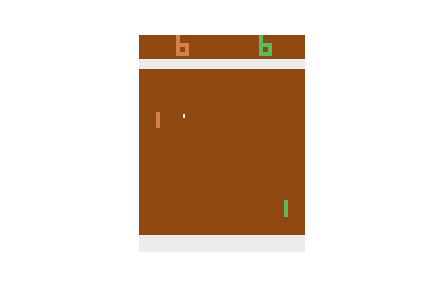
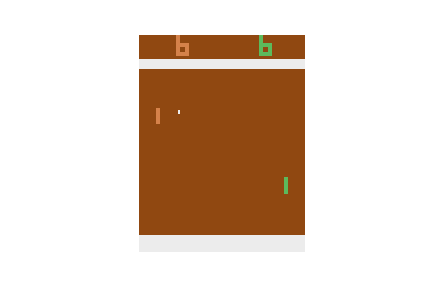
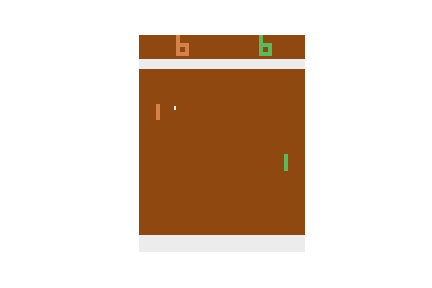
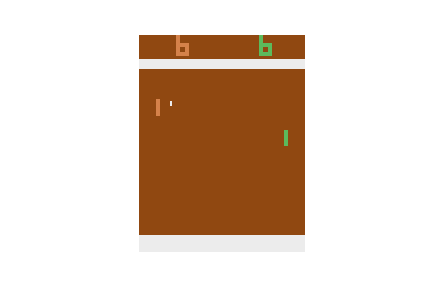
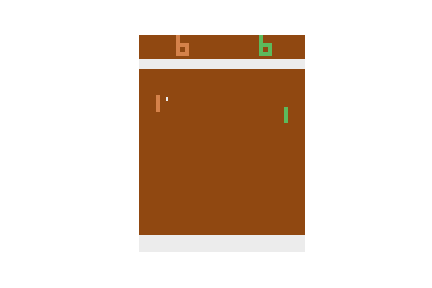
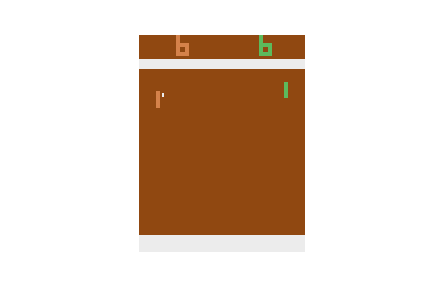
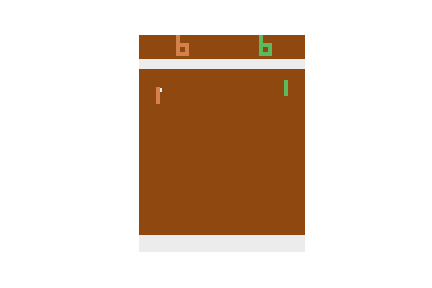
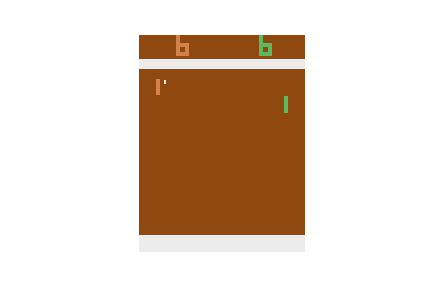
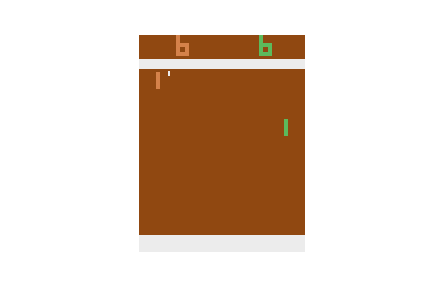
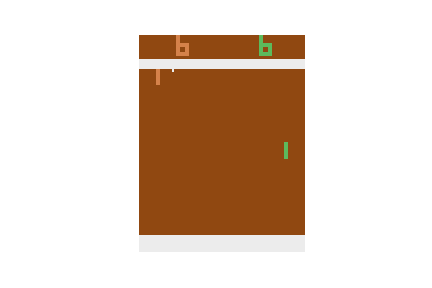
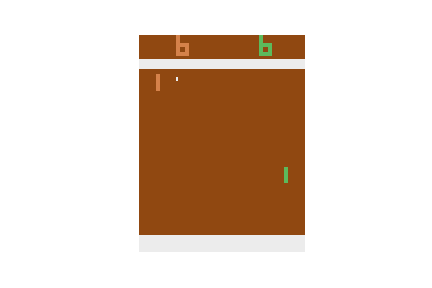
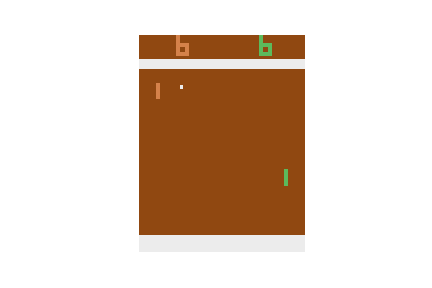
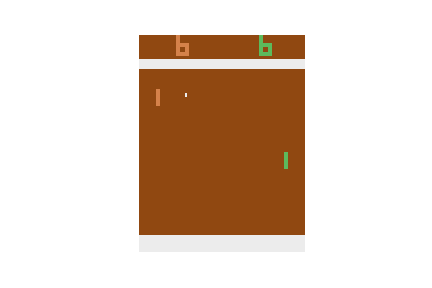
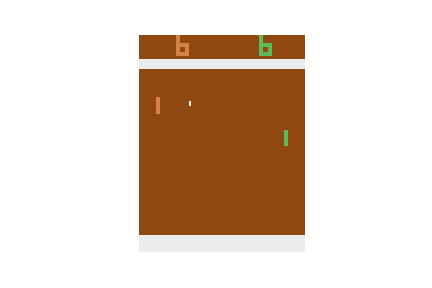
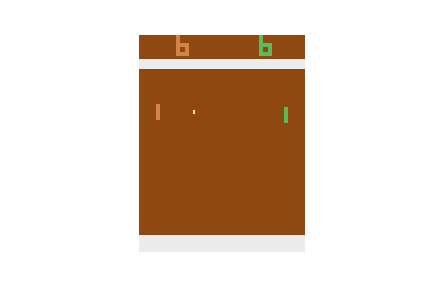
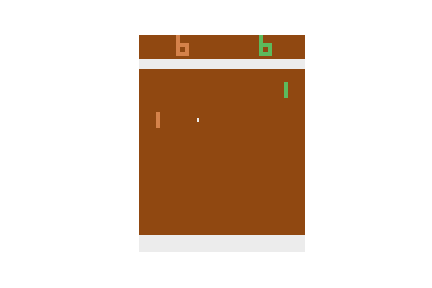
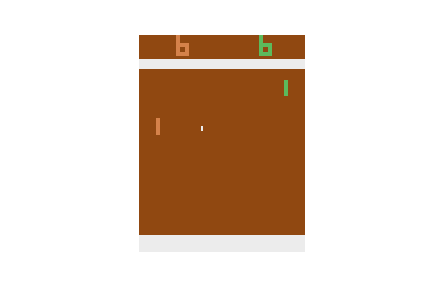
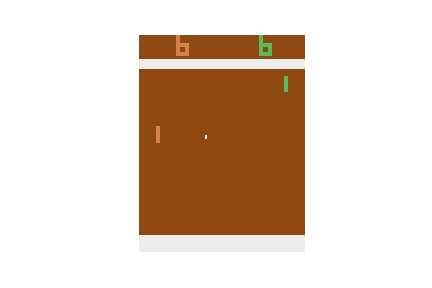
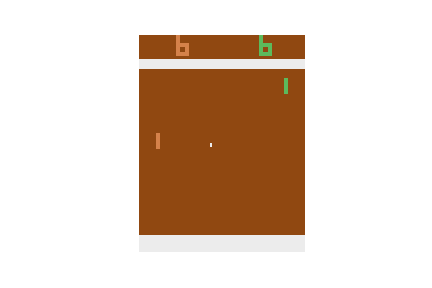
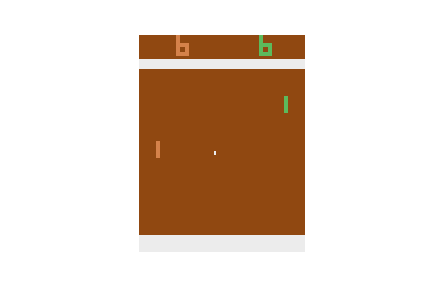
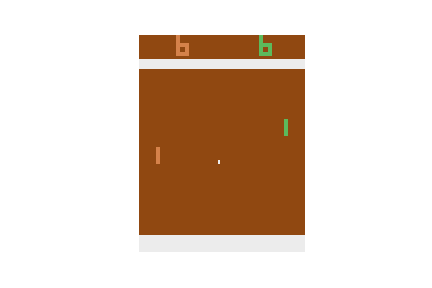
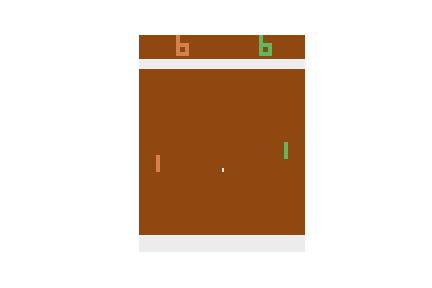
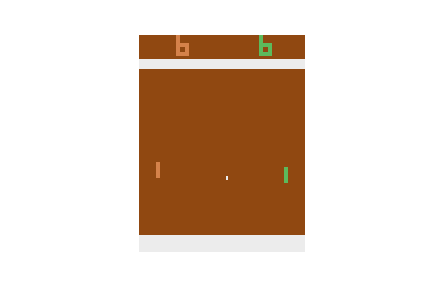
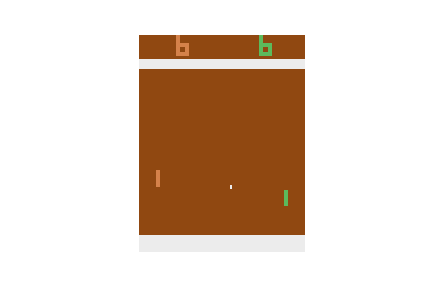
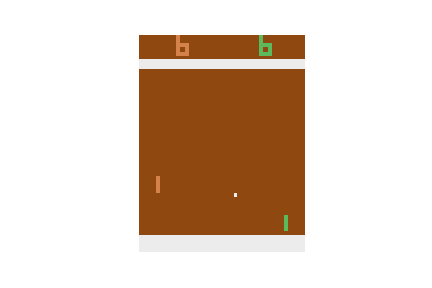
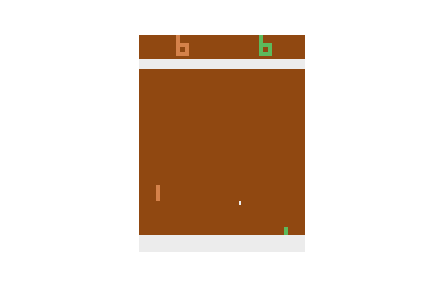
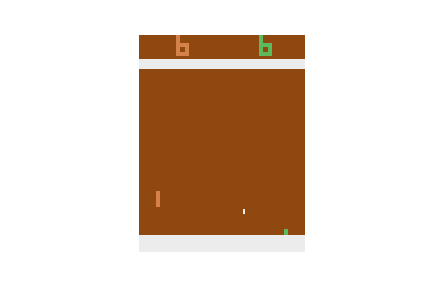
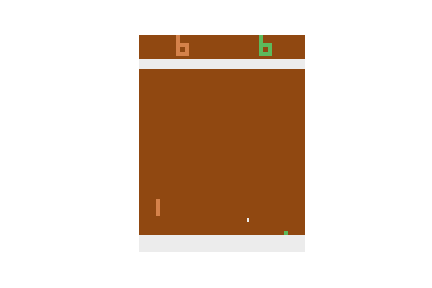
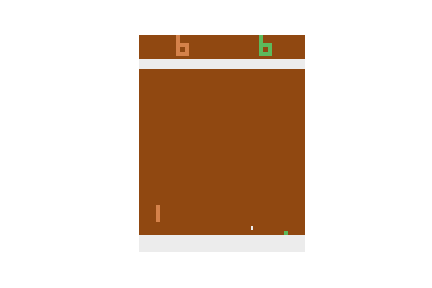
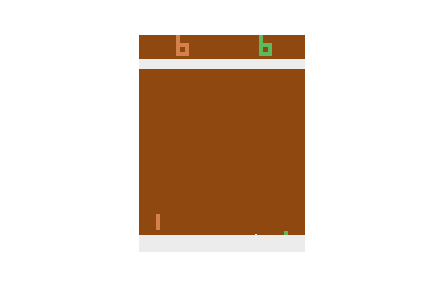
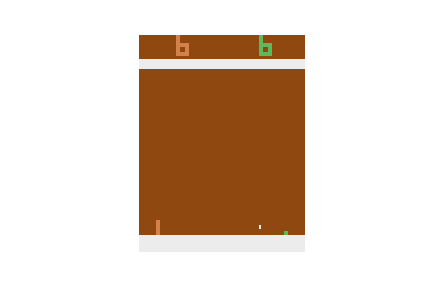
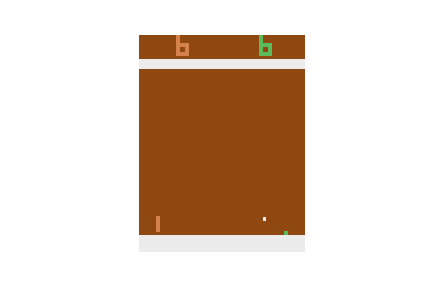
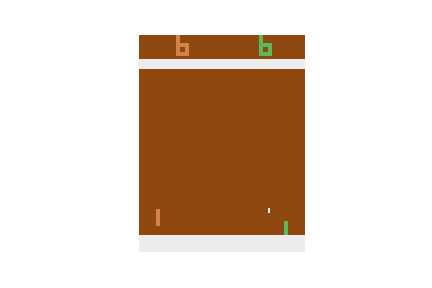
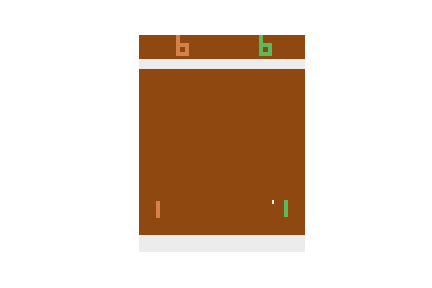
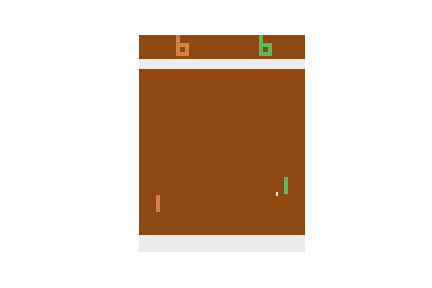
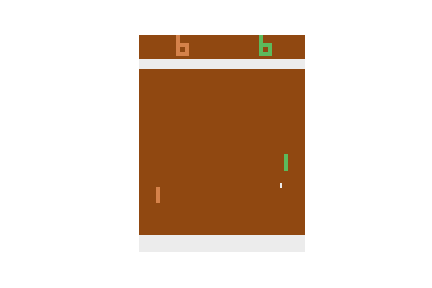
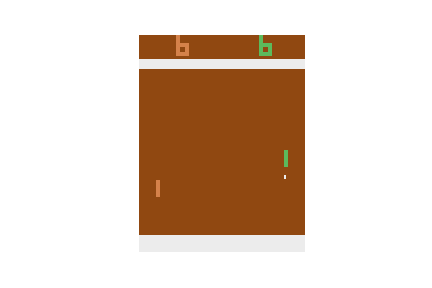
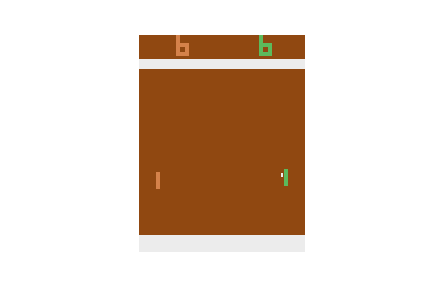
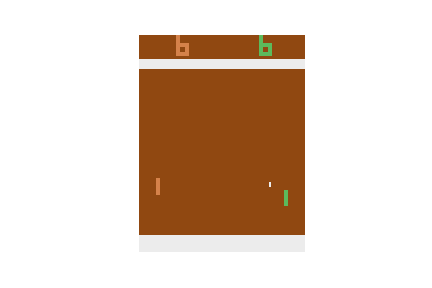
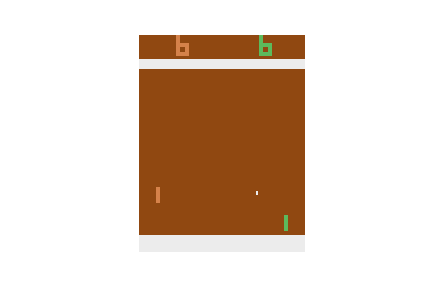
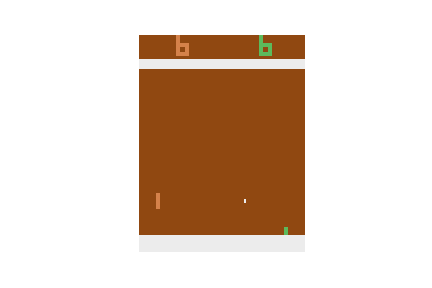
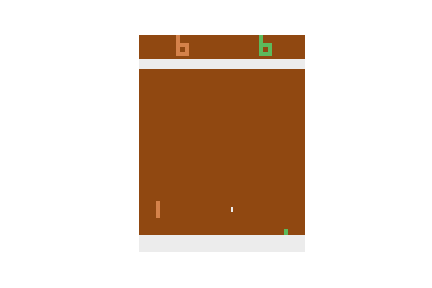
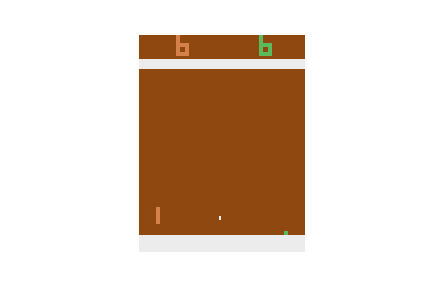
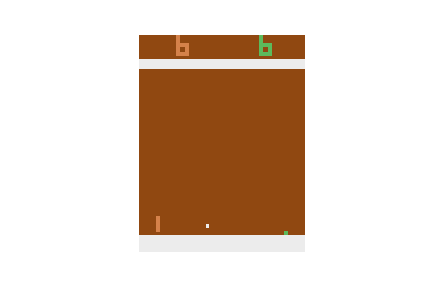
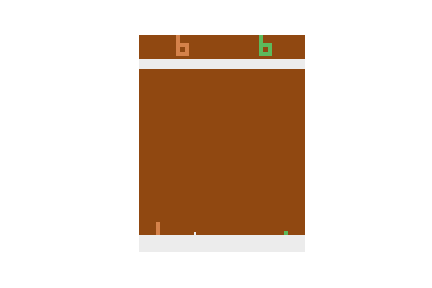
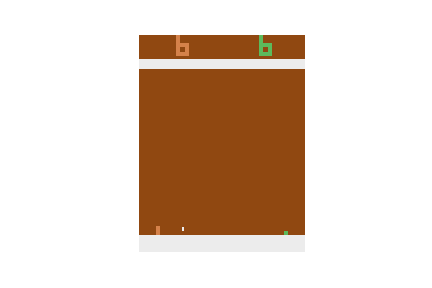
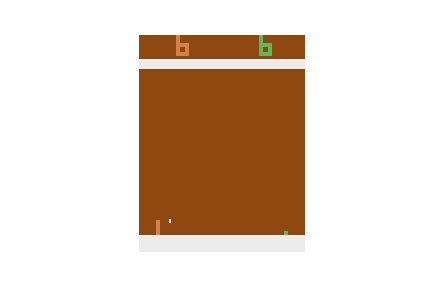
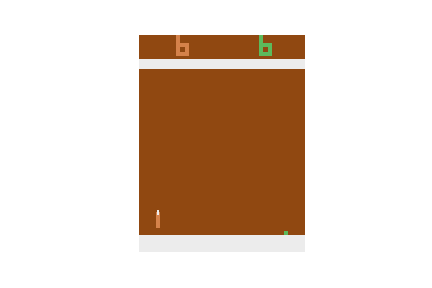
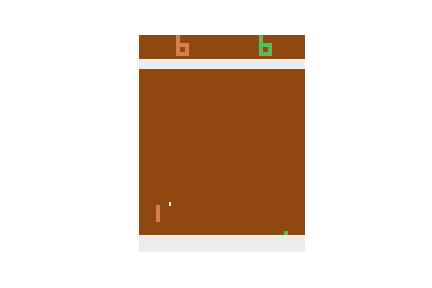
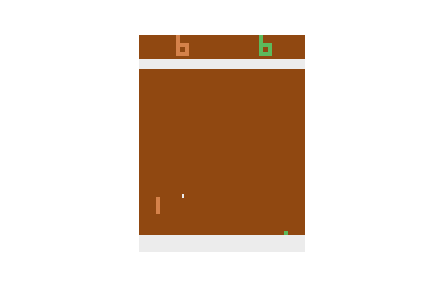
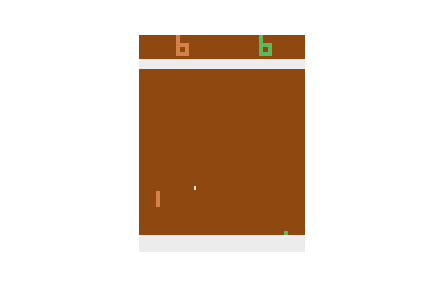
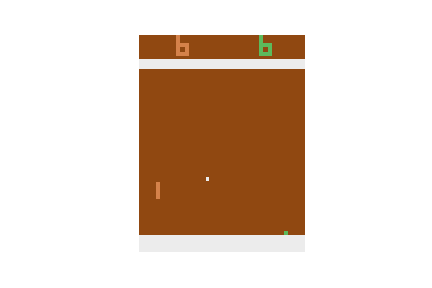
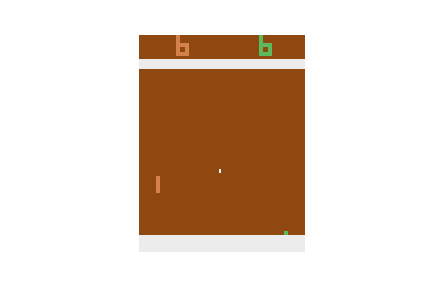
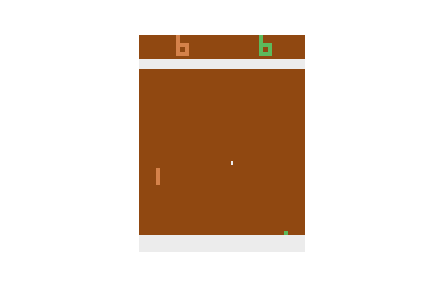
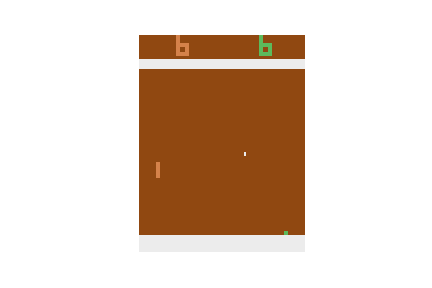
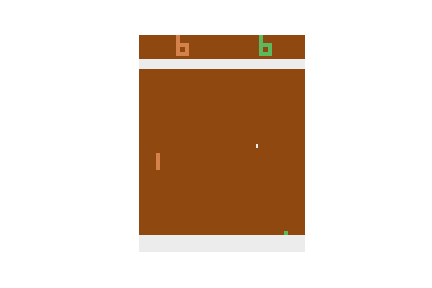
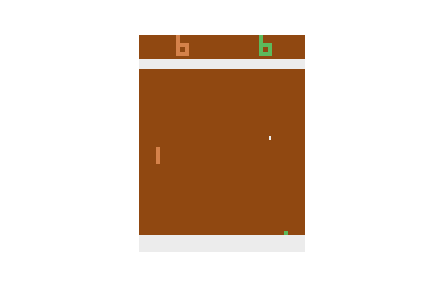
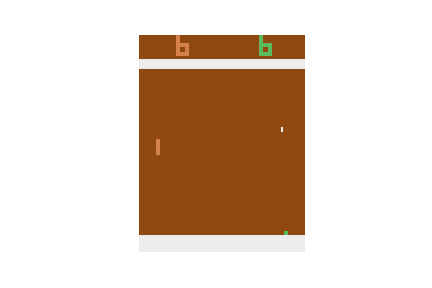
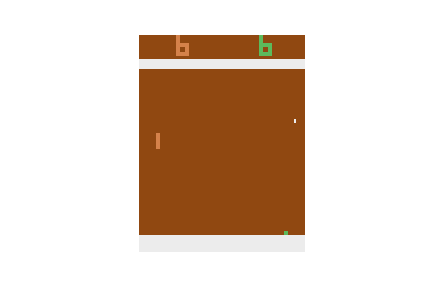
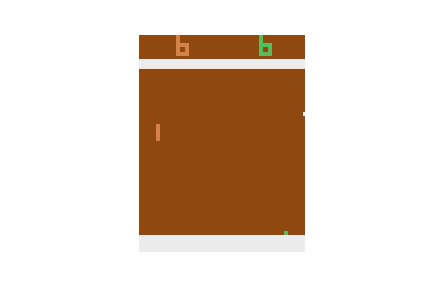
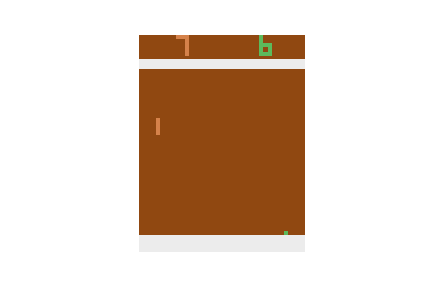
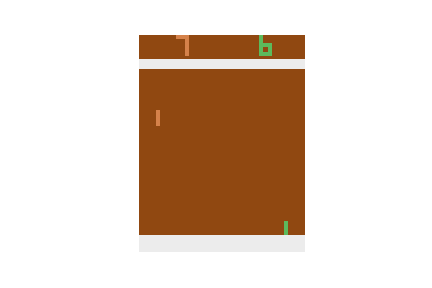
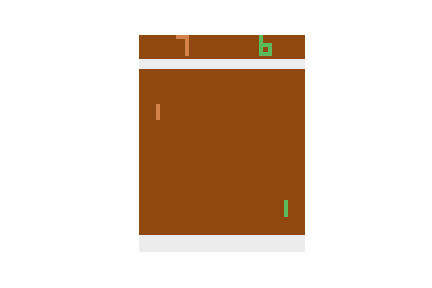
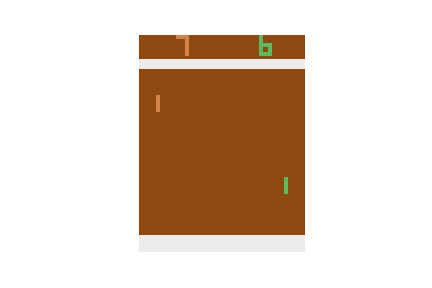
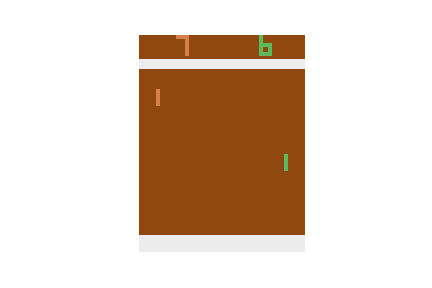
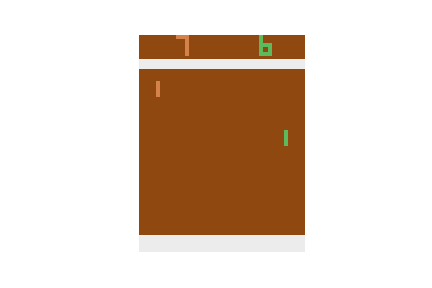
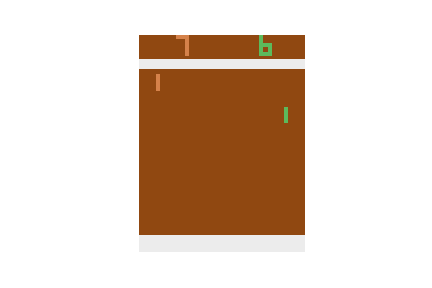
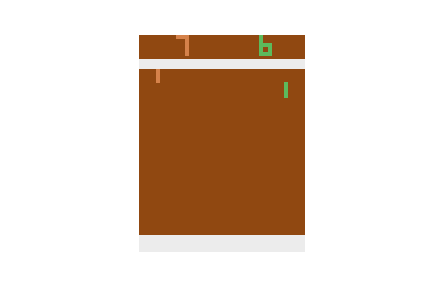
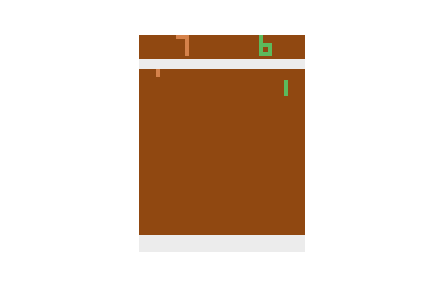
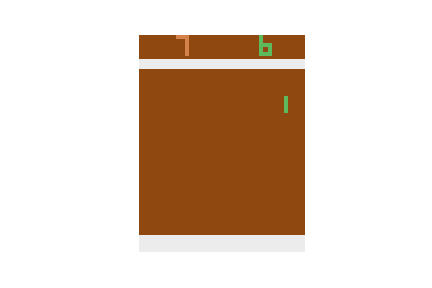
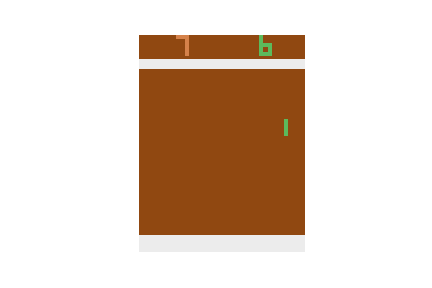
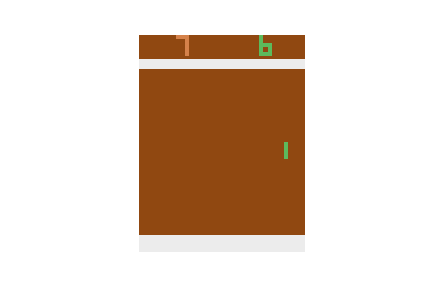
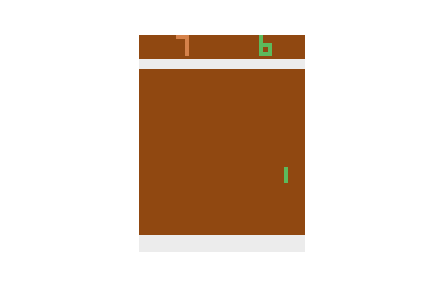
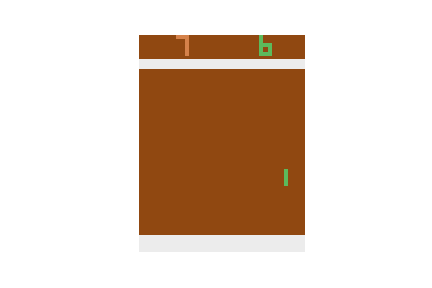
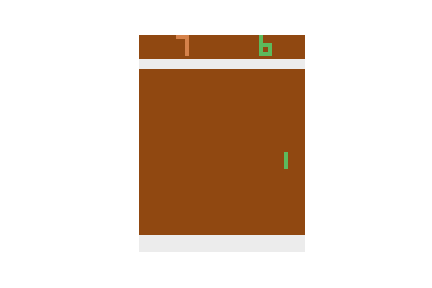
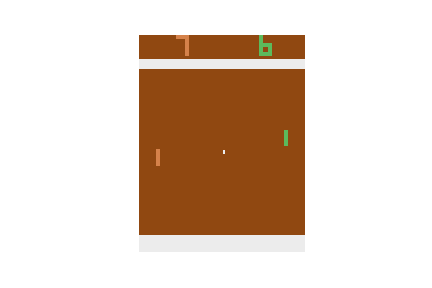
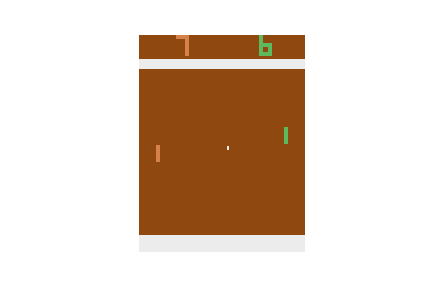
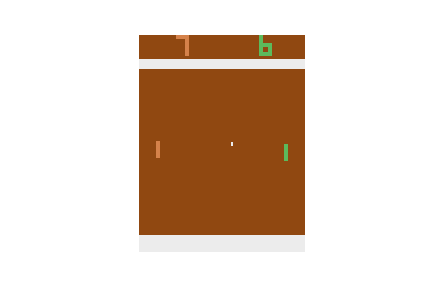
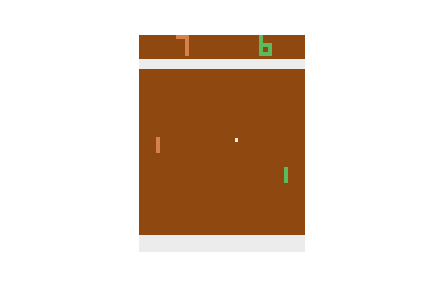
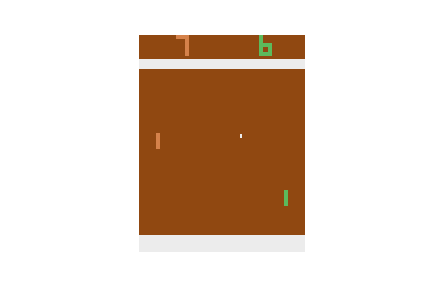
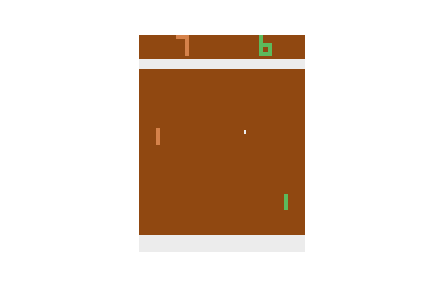
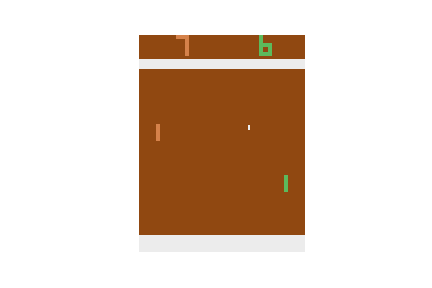
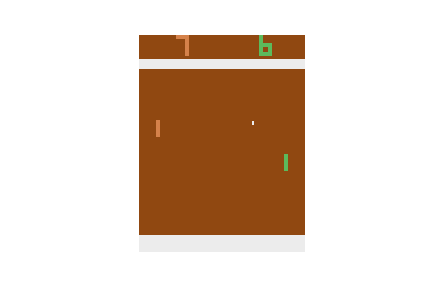
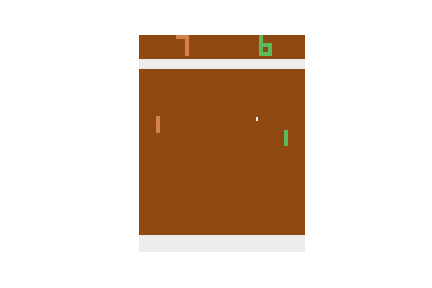
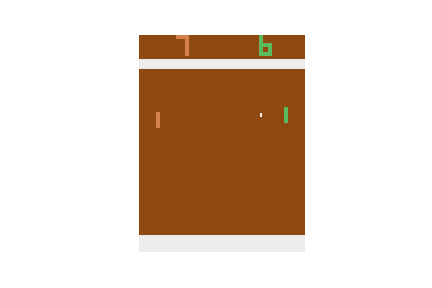
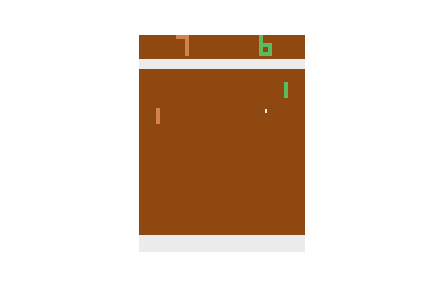
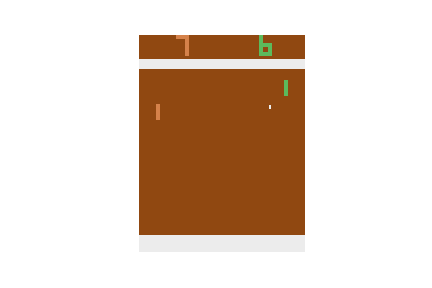
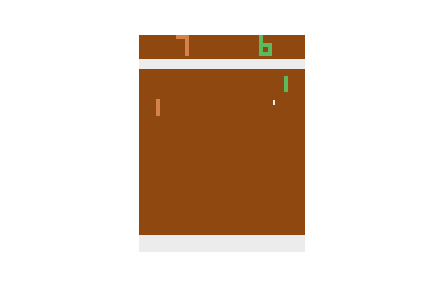
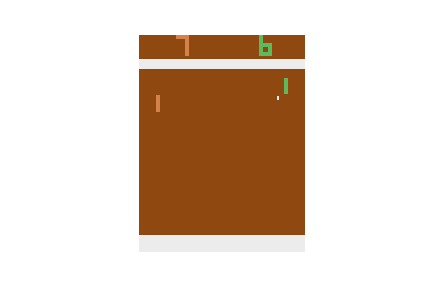
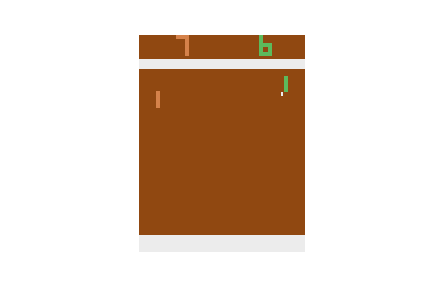
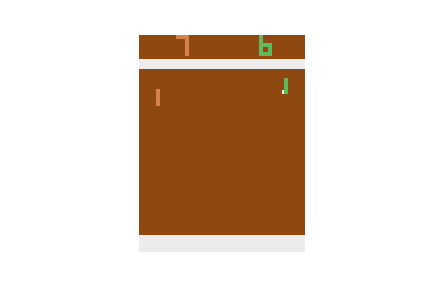
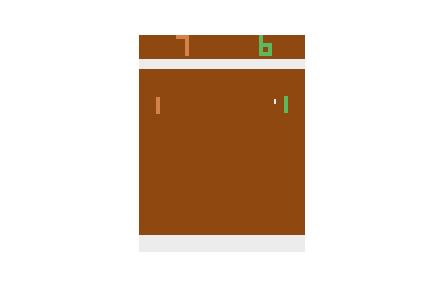
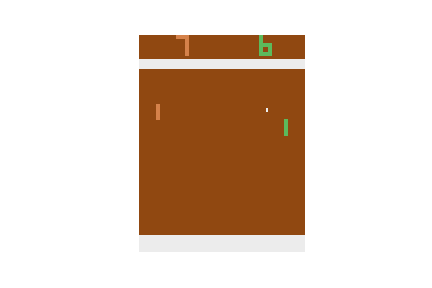
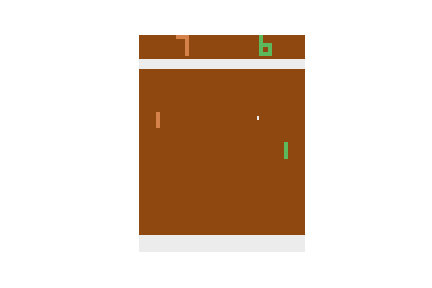
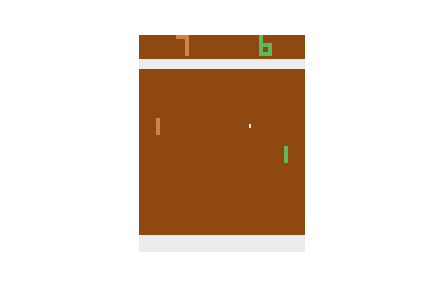
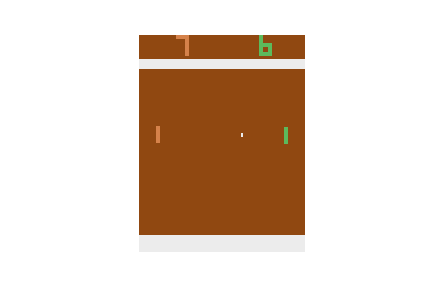
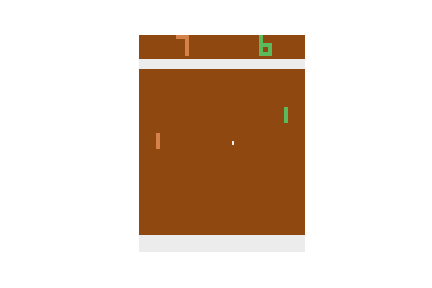
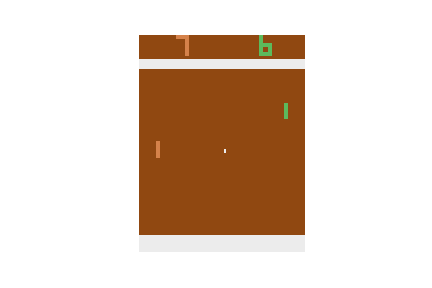
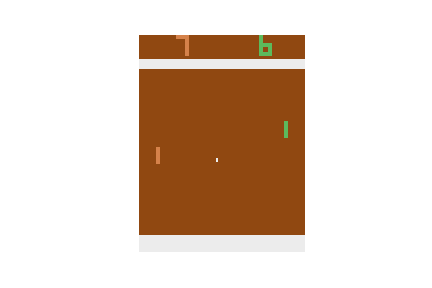
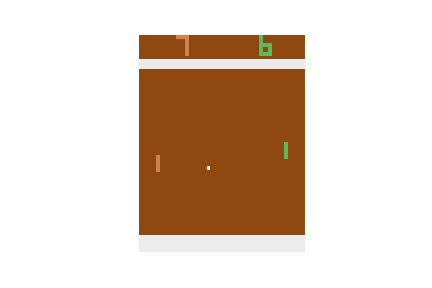
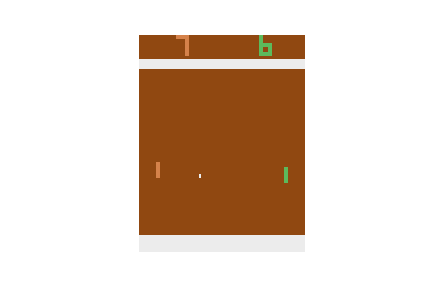
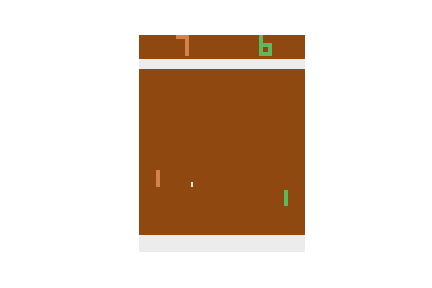
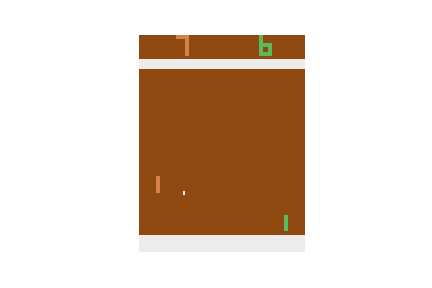
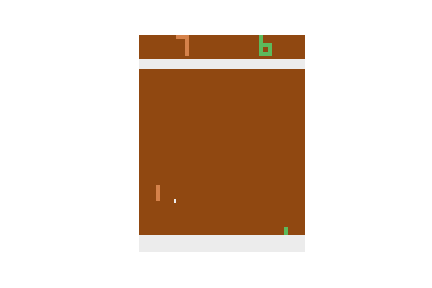
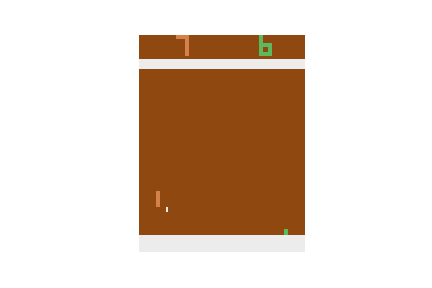
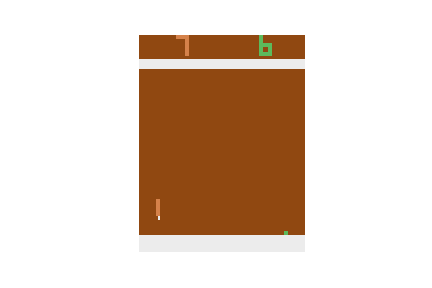
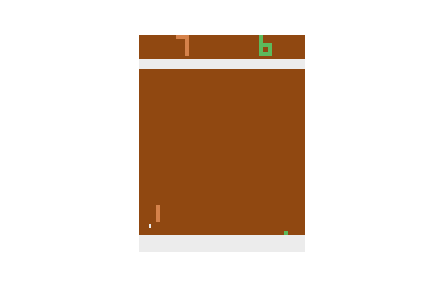
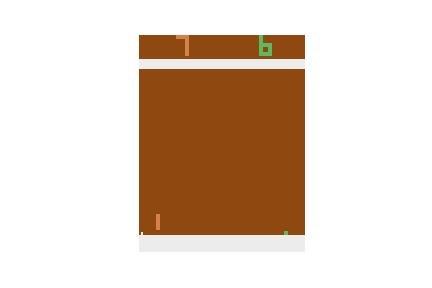
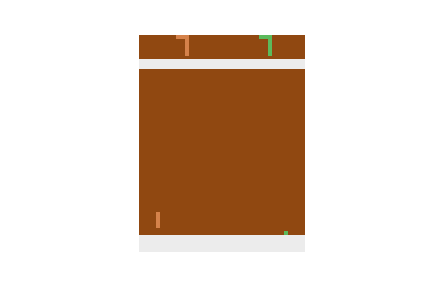
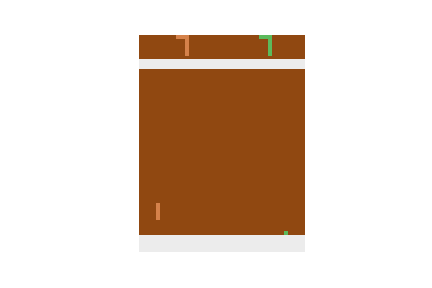
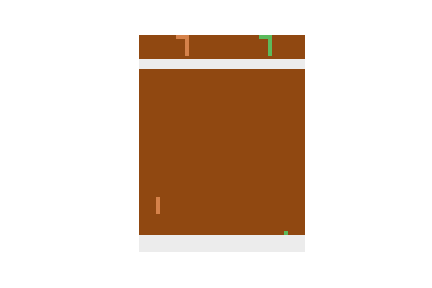
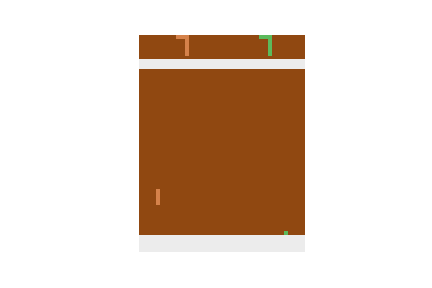
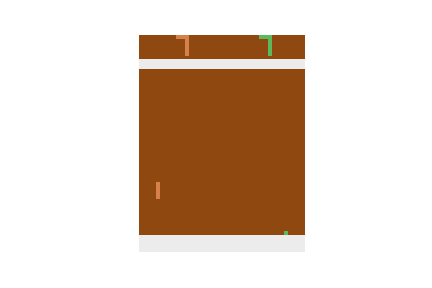
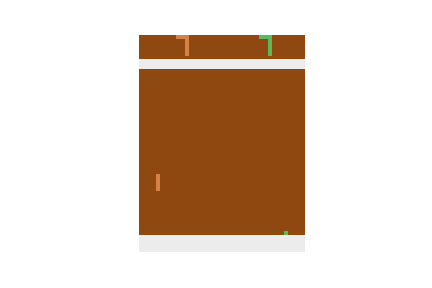
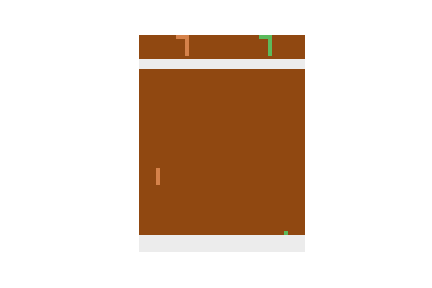
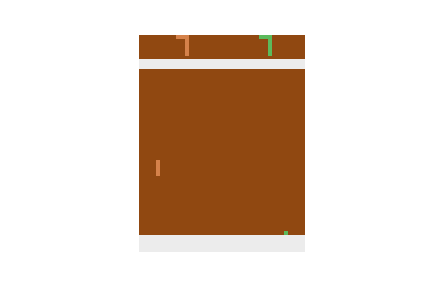
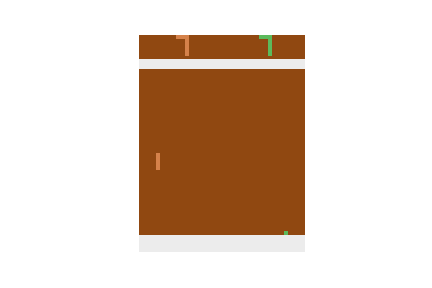
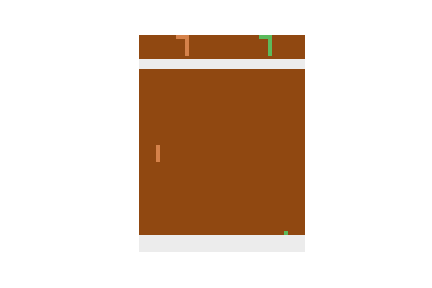
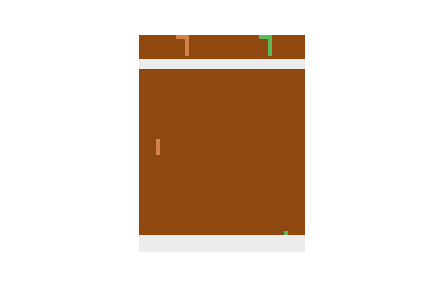
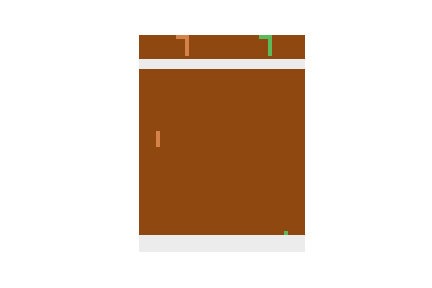
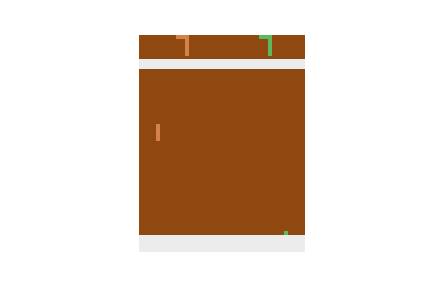
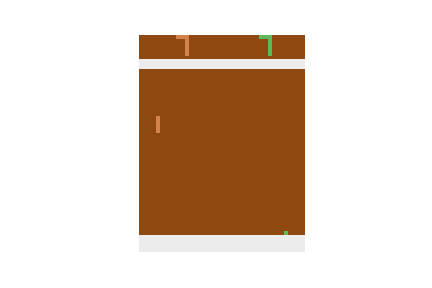
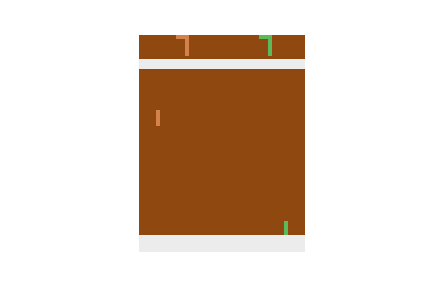
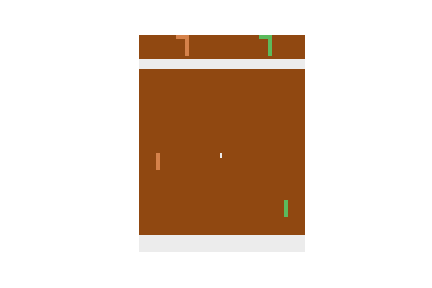
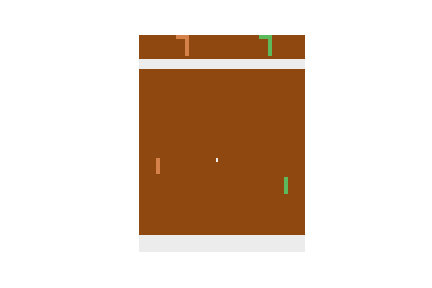
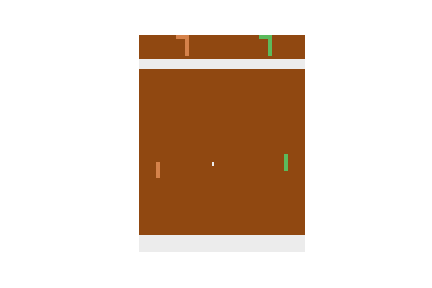
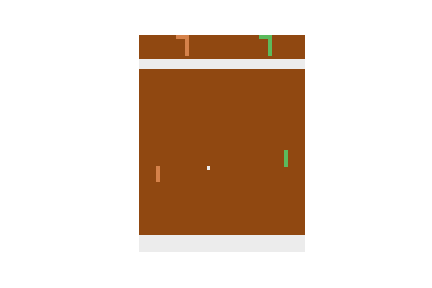
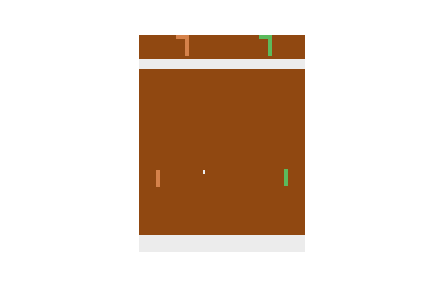
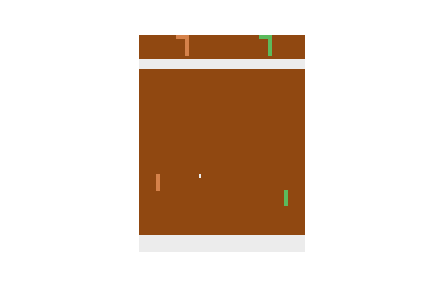
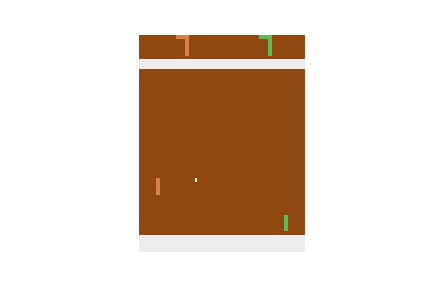
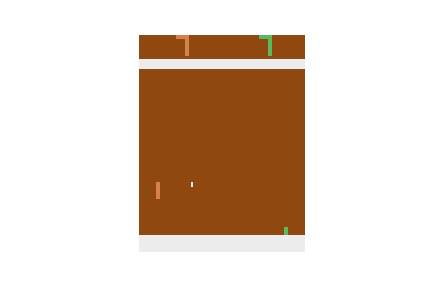
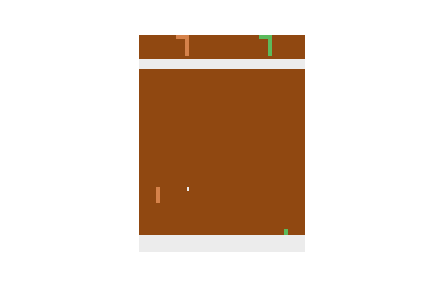
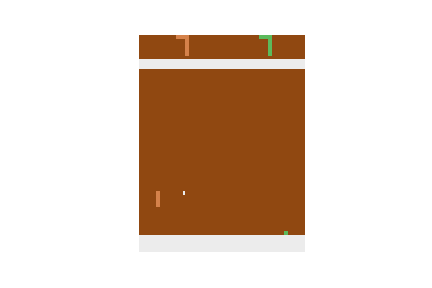
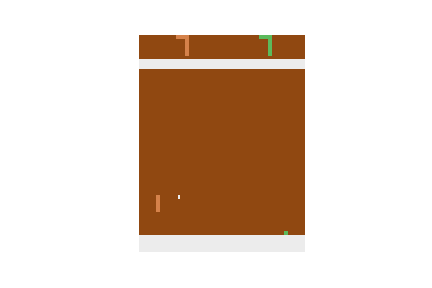
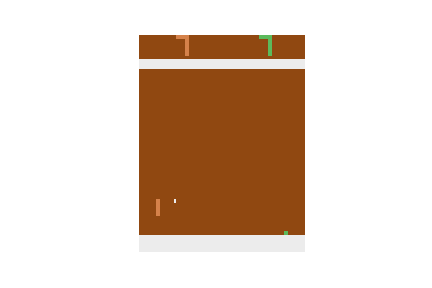
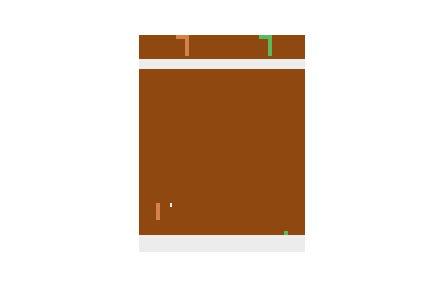
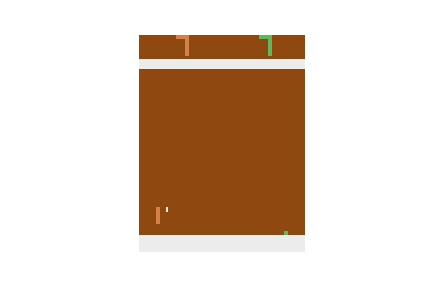
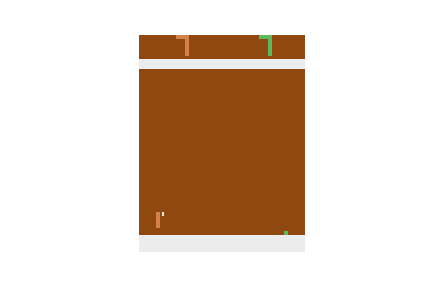
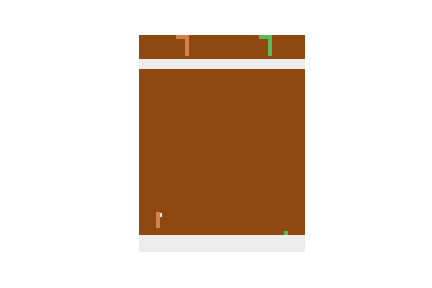
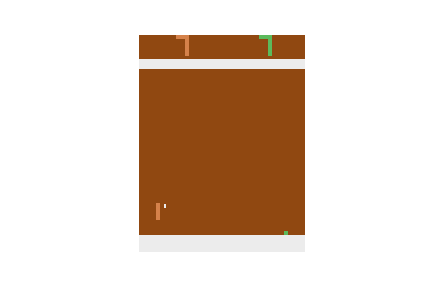
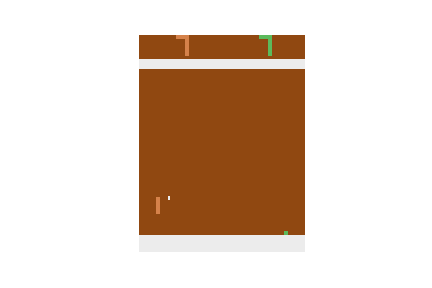
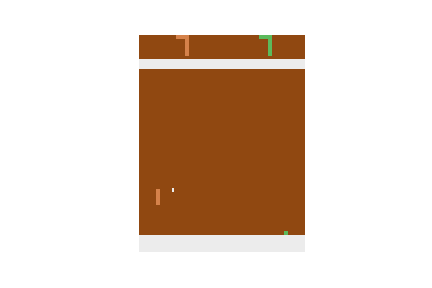
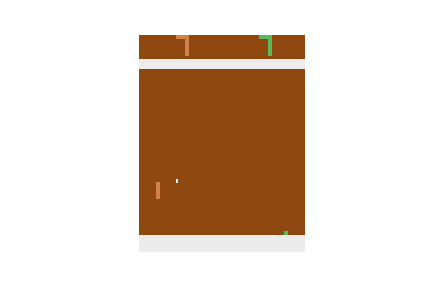
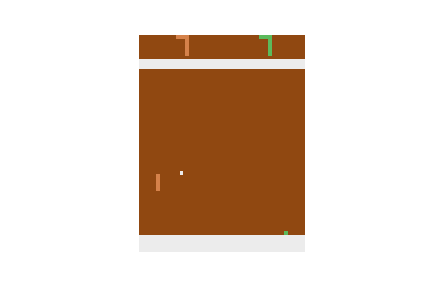
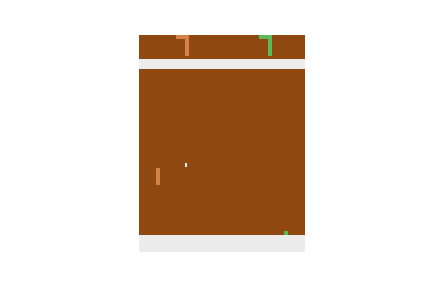
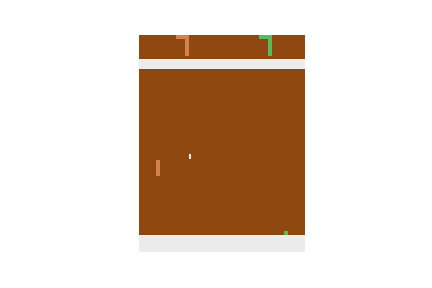
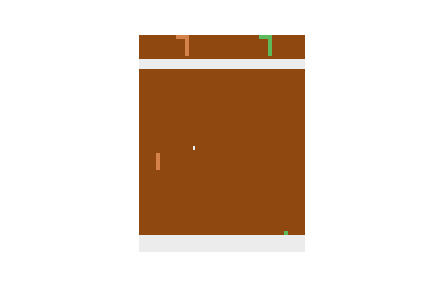
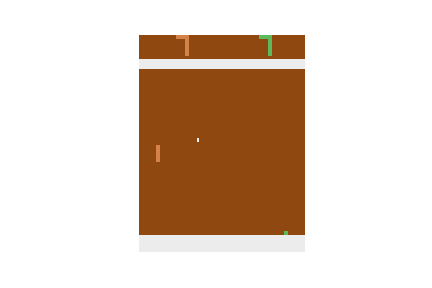
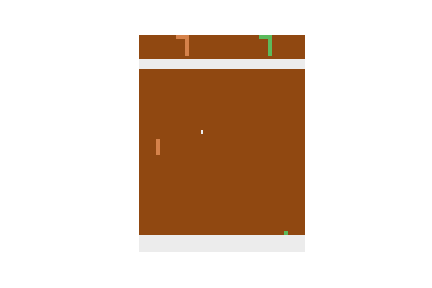
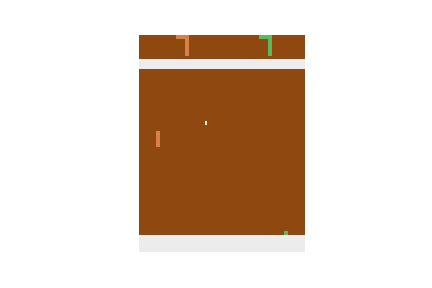
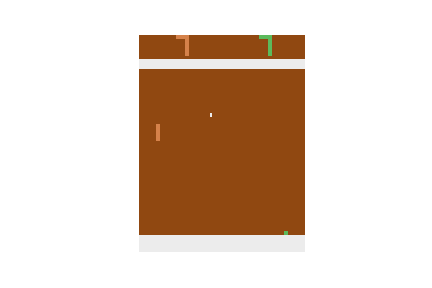
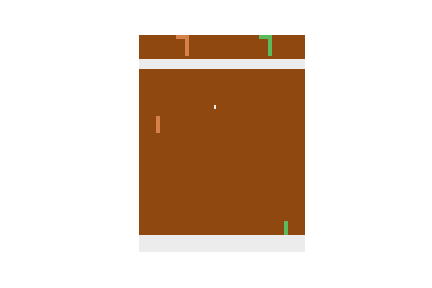
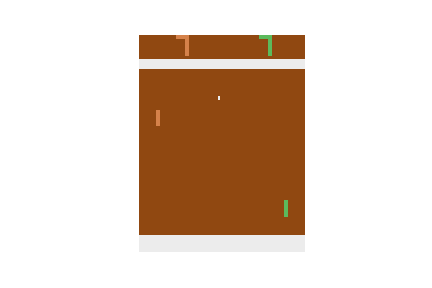
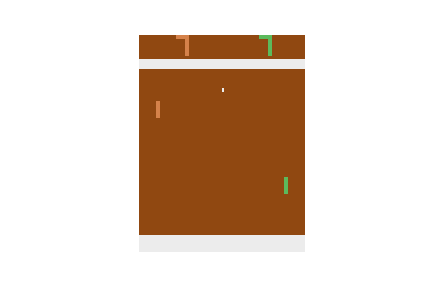
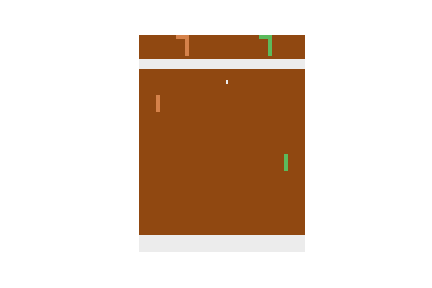
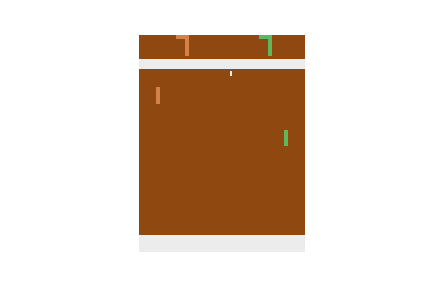
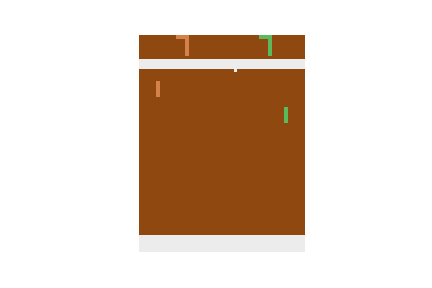
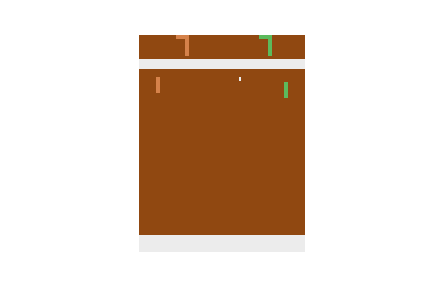
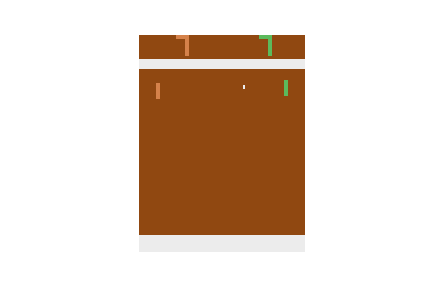
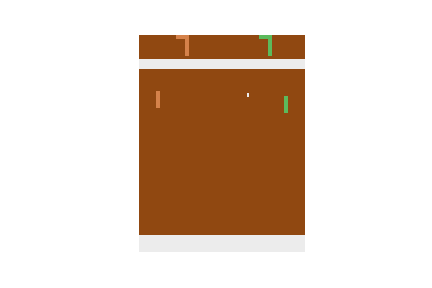
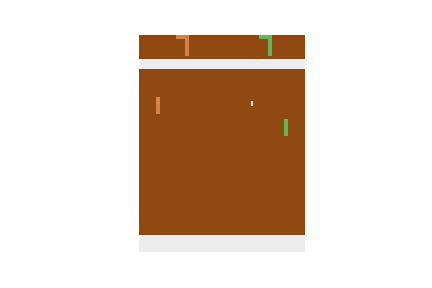
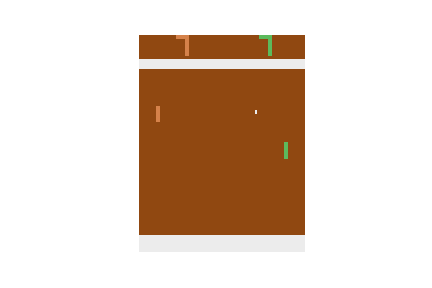
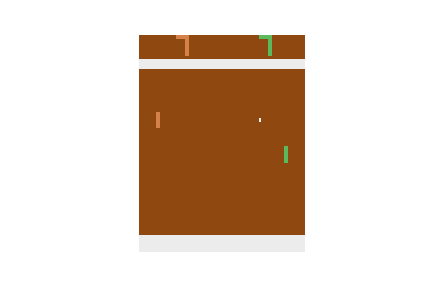
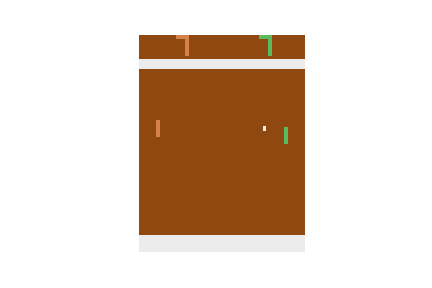
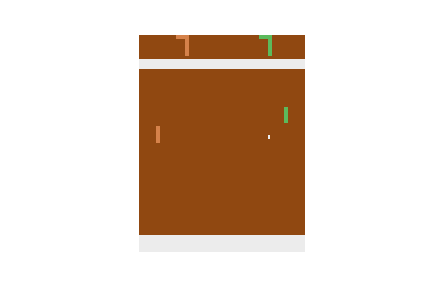
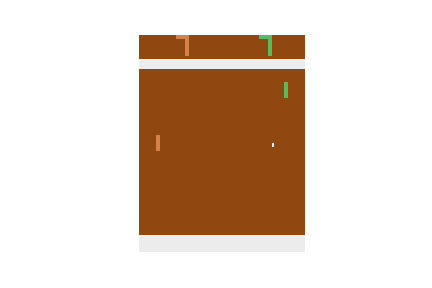
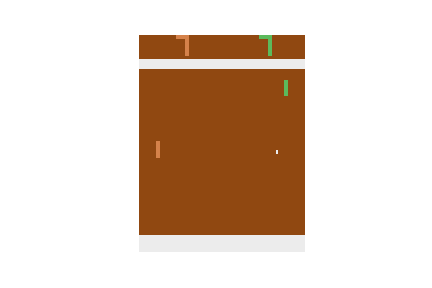
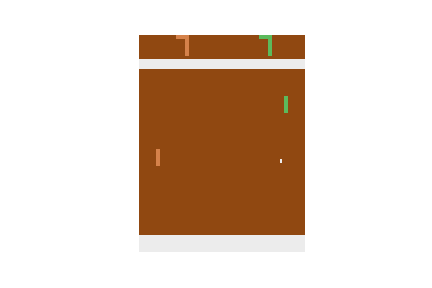
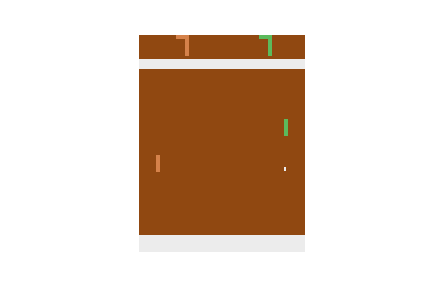
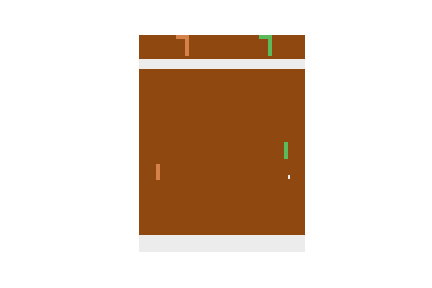
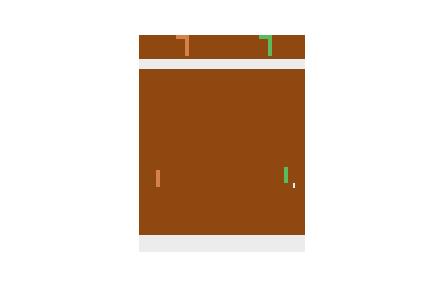
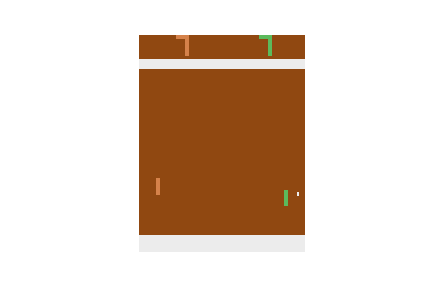
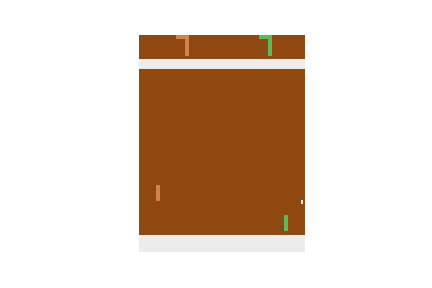
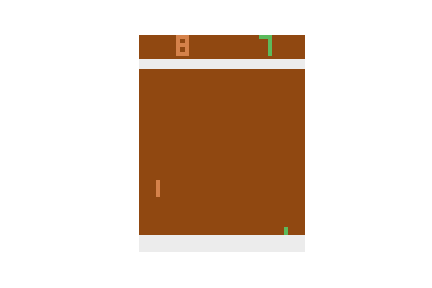
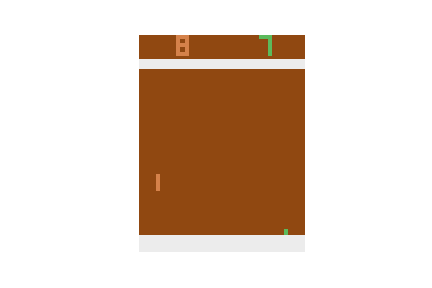
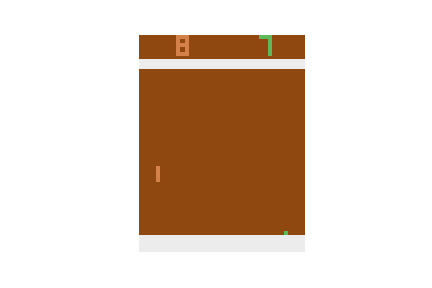
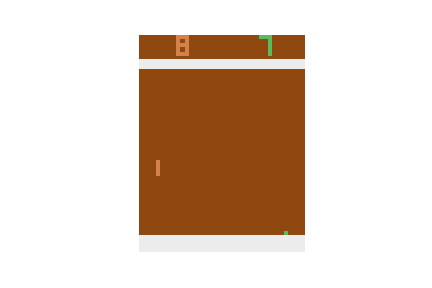
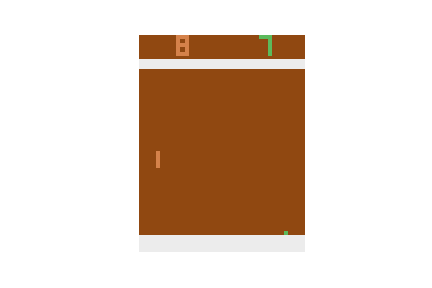
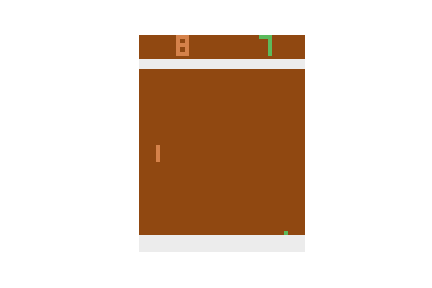
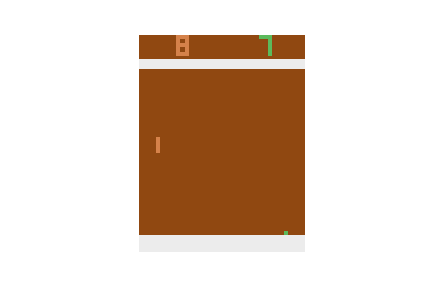
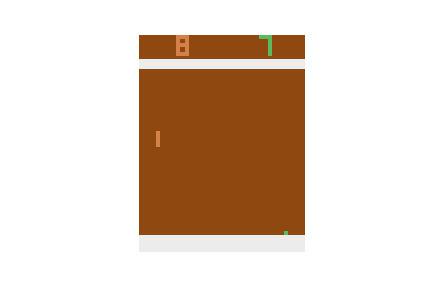
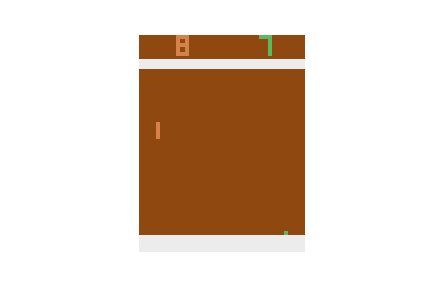
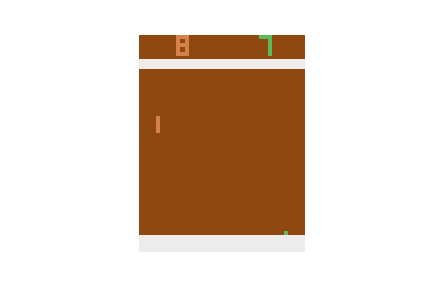
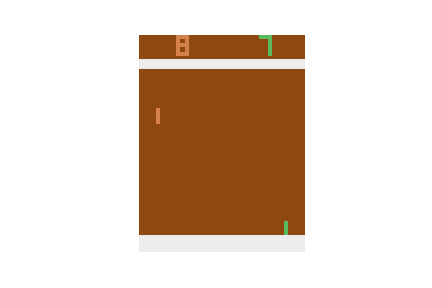
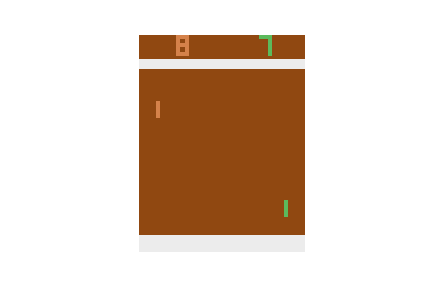
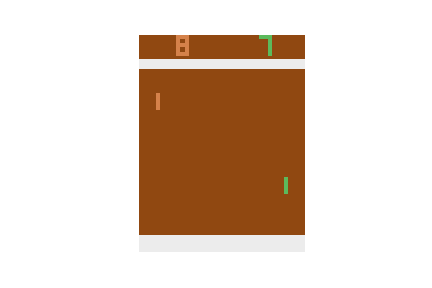
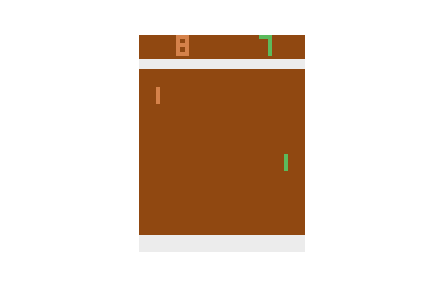
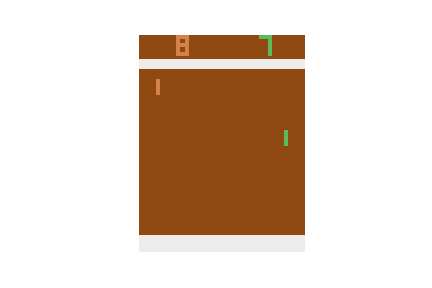
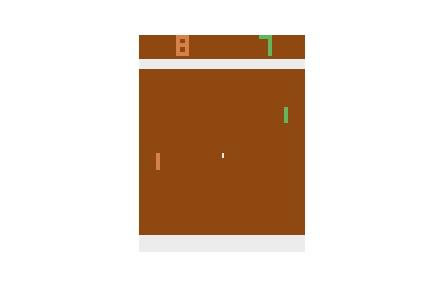
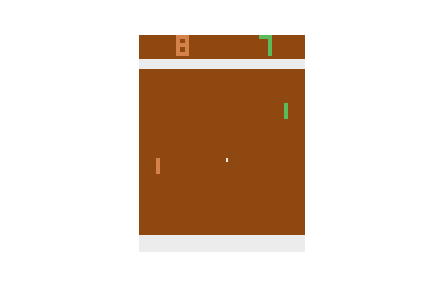
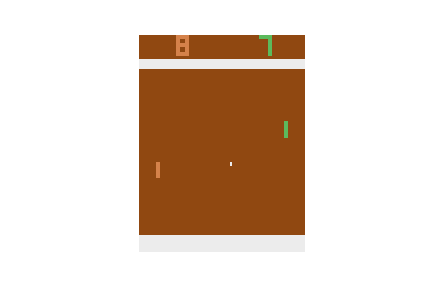
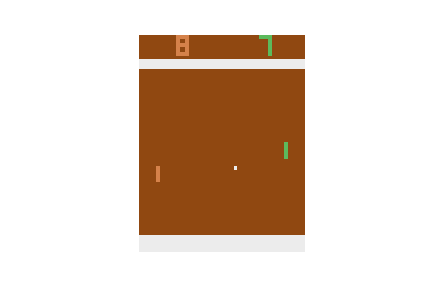
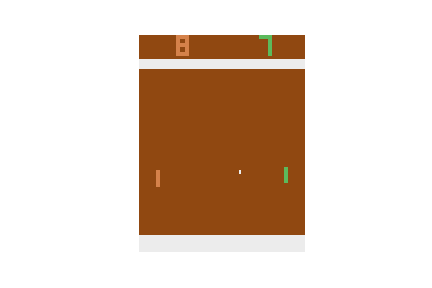
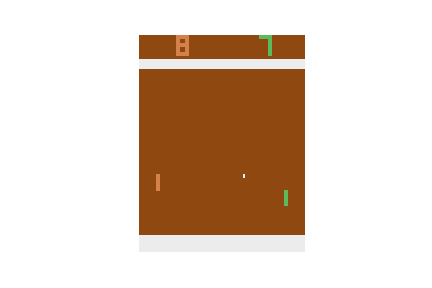
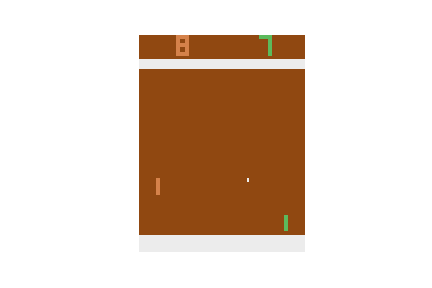
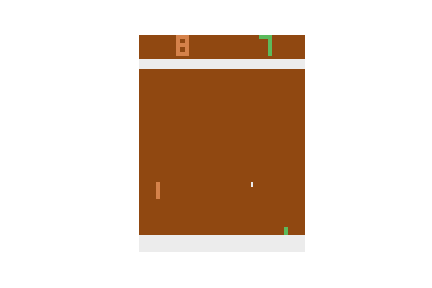
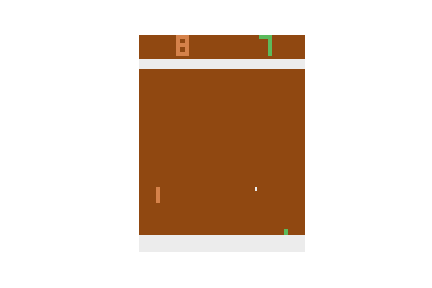
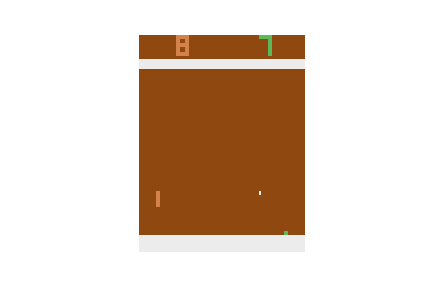
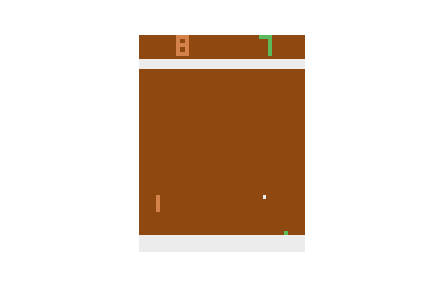
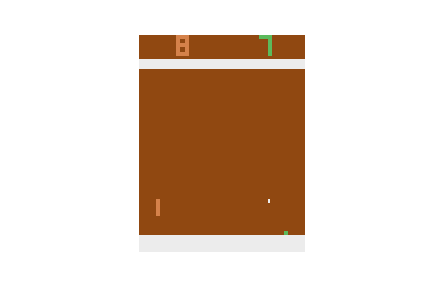
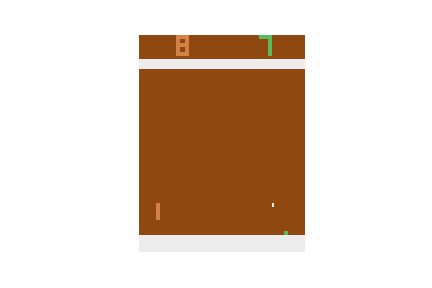
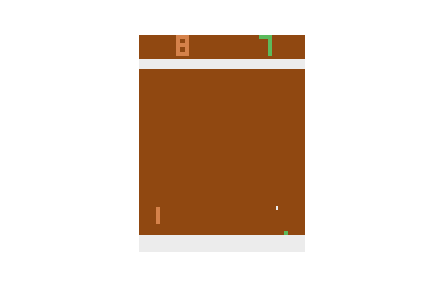
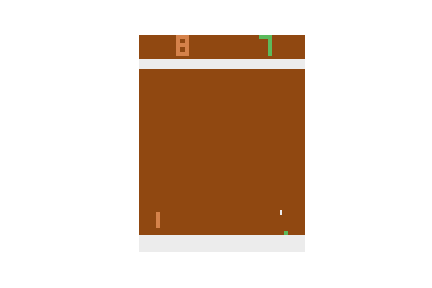
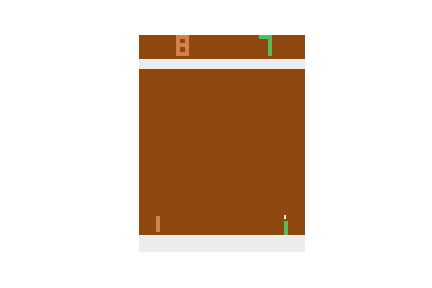
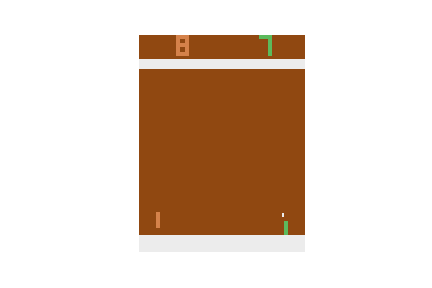
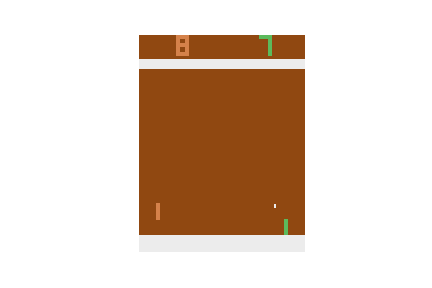
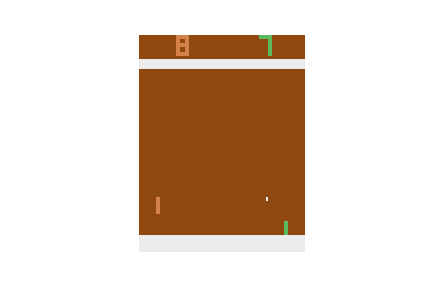
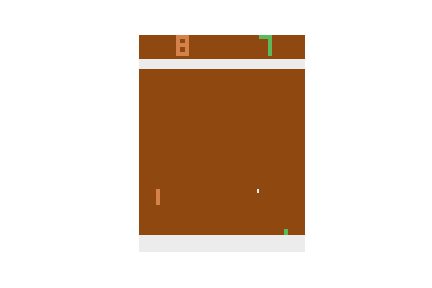
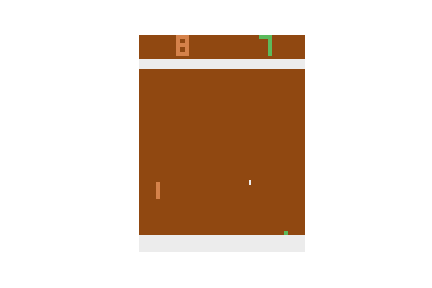
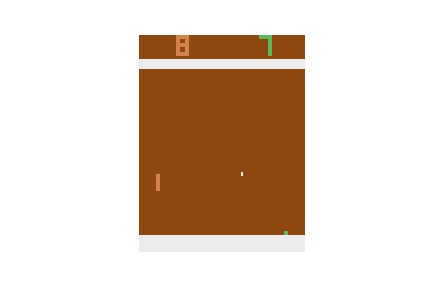
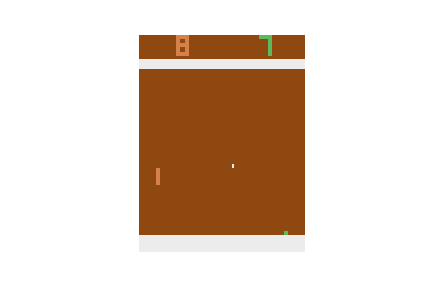
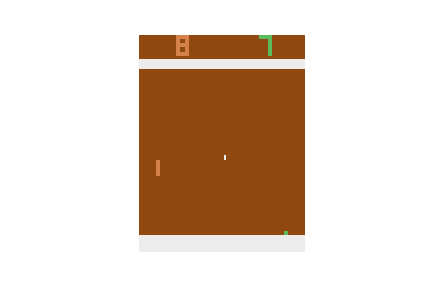
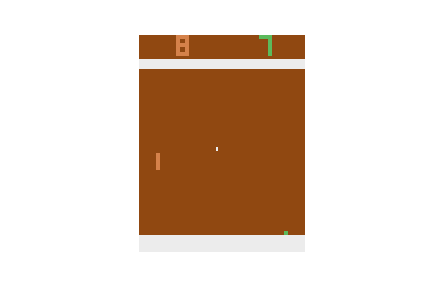
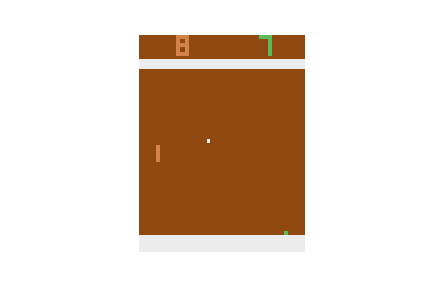
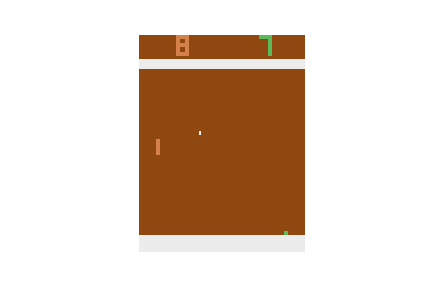
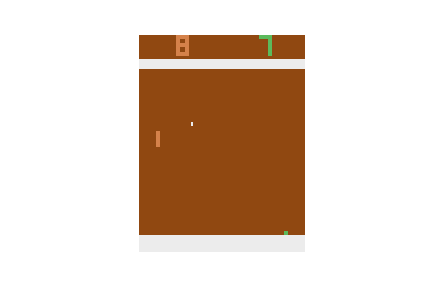
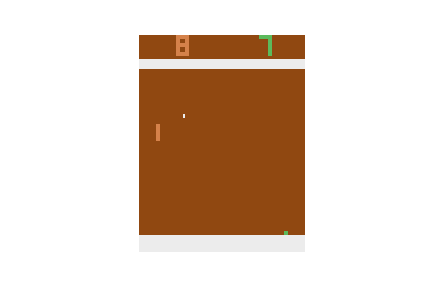
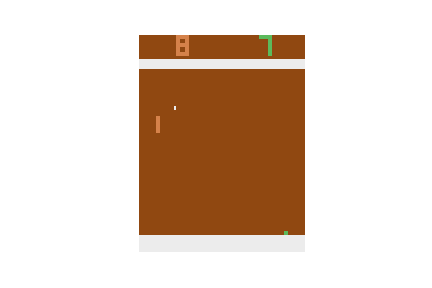
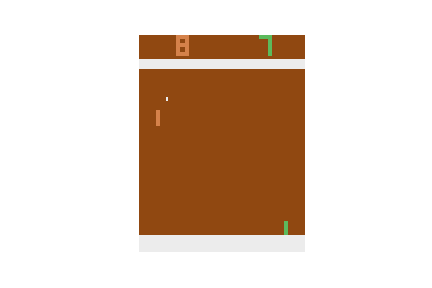
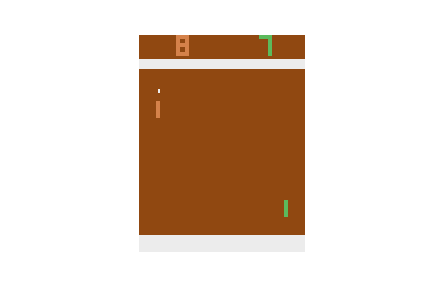
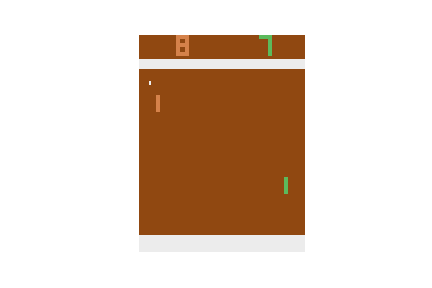
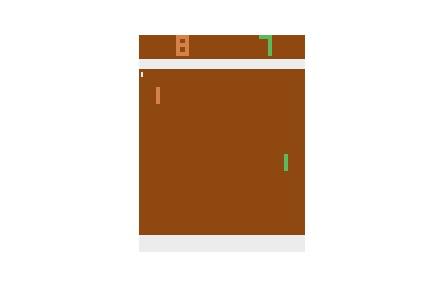
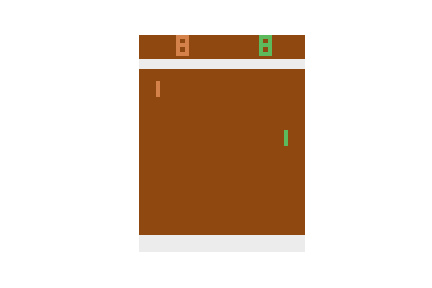
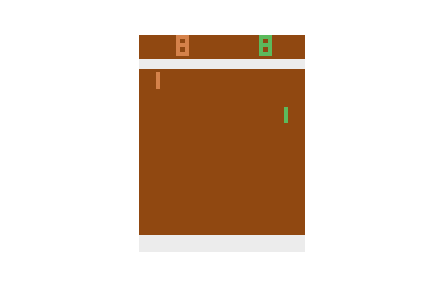
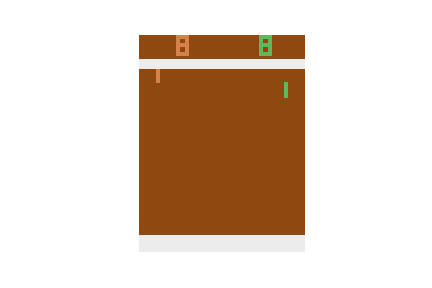
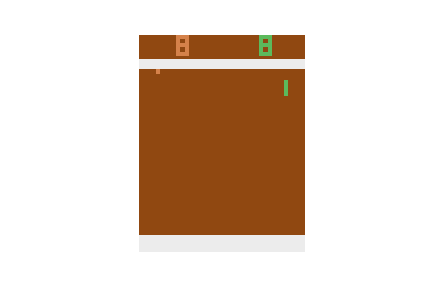
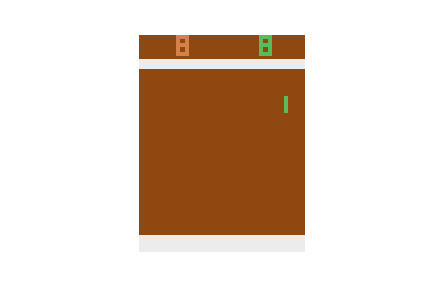
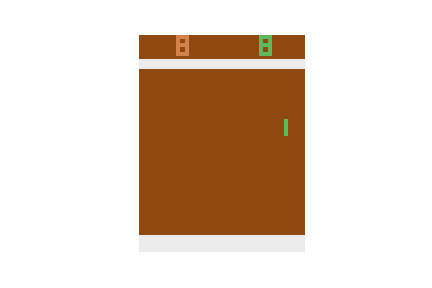
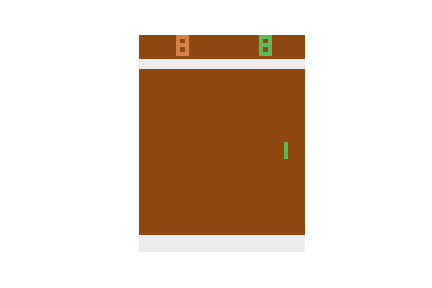

999


In [ ]:
observation = env.reset()
cum_reward = 0
frames = []
prev_frame = None
for t in range(1000):
    x = preprocess(observation) 
    diff = x - prev_frame if prev_frame is not None else np.zeros(im_shape)
    p = model.predict(diff[None,:,:,:])
    prev_frame = x
    a = np.random.choice(len(action_space), p=p[0])
    action = action_space[a]
    
    # Render into buffer. 
    frames.append(env.render(mode = 'rgb_array'))
    observation, reward, done, info = env.step(action)
    if done:
        break
        
# env.render(close=True)
display_frames_as_gif(frames)
print(t)